The objectif of this project is to use Deep Learning techniques to resolve m-height Problem faster than traditional LP-based algorithm with the minimal error possible.  
To tackle this problem, the first part is to generate data to train our model using LP-based algorithm.
Then we are going to train different model to which architecture fit the best the problem.


Loading data and preprocessing class and function necessary for training model

In [12]:
# --- Final cell for Evaluation and Testing for every project ---
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import pickle 

# --- Problem setup ---
max_k_padded = 6  # Max height for padding P
max_nk_padded = 6 # Max width for padding P
params_size = 3 # n, k, m
p_flat_size = max_k_padded * max_nk_padded # 36
file_path = './test_data/DS-5-samples_n_k_m_P' # path to the test data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
output_filename = "CSCE 636-600 Spring 2025 Project Test Results THEO LIN 936005925.pkl"

# 3 lists to store the result for each model
H_1, H_2, H_3 = [], [], []

# dictionary to store the result for each model
project_results = {"project_1": H_1, "project_2": H_2, "project_3": H_3}

# --- Setup project 1 ---
model_path_1 = "best_moe_finetuned_final.pth"
expert_input_dim = p_flat_size + params_size # 39
gating_input_dim = 2 # Only n, k for gating
# parameters below has to match the trained model parameter
num_experts = 6 
expert_hidden_dims = [512, 256, 128] 
gating_hidden_dim = 16 

# --- Setup project 2 ---
model_path_2 = "best_resnet2d_no_norm.pth"
num_blocks = 3
base_ch = 32

# --- Setup project 3 ---
moe_model_path = 'best_moe_resnet_65_5_sparsegate_e6_k2_finetuned.pth'
# MoE Model Hyperparameters
moe_args = {
    'num_experts': 6,
    'k_max': 6,
    'nk_max': 6,
    'n_params': 3,
    'base_ch': 64,
    'num_blocks': 5,
    'top_k': 2,
    'gating_hidden_dim': 16
}

# --- Class and function to process the data for every project ---
# --- loading the test data function ---
def load_test_data(file_path):
    """
    Loads data from a pickle file.

    Args:
        file_path (str): The path to the pickle file.

    Returns:
        list: The data loaded from the pickle file. Returns None if an error occurs.
            The expected structure is a list of N samples, where each sample
            is a list [n, k, m, P]:
            - n (int): An integer, expected to be 9 or 10.
            - k (int): An integer, expected to be 4, 5, or 6.
            - m (int): An integer, expected to be in {2, 3, ..., n-k}.
            - P (numpy.ndarray): A 2-dimensional NumPy array with k rows and n-k columns.
    """
    try:
        # Ensure the file exists before attempting to open it
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Error: The file '{file_path}' was not found.")

        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            
            # Optional: Add data validation checks here if needed
            if not isinstance(data, list):
                 print(f"Warning: Loaded data is not a list, but type {type(data)}.")
            elif data and not isinstance(data[0], list):
                 print(f"Warning: First element of the loaded list is not a list, but type {type(data[0])}.")
            elif data and isinstance(data[0], list) and len(data[0]) != 4:
                 print(f"Warning: First inner list does not have 4 elements (it has {len(data[0])}).")
            elif data and isinstance(data[0], list) and len(data[0]) == 4 and not isinstance(data[0][3], np.ndarray):
                 print(f"Warning: The fourth element (P) of the first sample is not a NumPy array, but type {type(data[0][3])}.")

            print(f"Successfully loaded data from: {file_path}")
            print(f"Data type: {type(data)}")
            if isinstance(data, list):
                print(f"Data is a list with {len(data)} elements.")
                if data:
                    print(f"Type of the first element: {type(data[0])}")
                    if isinstance(data[0], list):
                         print(f"Length of the first inner list: {len(data[0])}")
            return data
            
    except FileNotFoundError as e:
        print(e)
        raise # Re-raise the exception after printing the message
    except pickle.UnpicklingError:
        print(f"Error: Could not unpickle the file '{file_path}'. It might be corrupted or in an incompatible format.")
        raise # Re-raise the exception
    except Exception as e:
        print(f"An unexpected error occurred while loading '{file_path}': {e}")
        raise # Re-raise the exception

# --- function for preprocessing the data in the correct format for our model ---
def preprocess_sample(sample, device):
    """Preprocesses a single sample [n, k, m, P] for model input."""
    n, k, m, P_np = sample
    
    # Pad P to (max_k_padded, max_nk_padded) = (6, 6)
    pad_h = max_k_padded - P_np.shape[0] # Padding height
    pad_w = max_nk_padded - P_np.shape[1] # Padding width
    
    # Ensure padding is non-negative (handles cases where P might already be max size)
    pad_h = max(0, pad_h)
    pad_w = max(0, pad_w)

    P_padded_np = np.pad(P_np, ((0, pad_h), (0, pad_w)), 'constant', constant_values=0)
    
    # Convert to tensors and add batch dimension
    P_tensor = torch.tensor(P_padded_np, dtype=torch.float32).unsqueeze(0).to(device) # Shape: (1, 6, 6)
    params_tensor = torch.tensor([n, k, m], dtype=torch.float32).unsqueeze(0).to(device) # Shape: (1, 3)
    
    return P_tensor, params_tensor

# Project 1 class function used 
# --- soft gated MoE architecture with FCN as expert ---
class GatingNetwork(nn.Module):
    def __init__(self, input_dim=2, num_experts=4, hidden_dim=16):
        super(GatingNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_experts)
        # print(f"Initialized GatingNetwork: input_dim={input_dim}, num_experts={num_experts}, hidden_dim={hidden_dim}")


    def forward(self, n_k_params):
        x = self.relu(self.fc1(n_k_params.float()))
        gate_outputs = self.fc2(x)
        gate_weights = F.softmax(gate_outputs, dim=1)
        return gate_weights

class Expert(nn.Module):
    """Fully connected layer architecture used as expert """
    def __init__(self, input_dim=39, hidden_dims=[512, 256, 128], output_dim=1):
        super(Expert, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2)) 
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
        # print(f"Initialized Expert: input_dim={input_dim}, hidden_dims={hidden_dims}, output_dim={output_dim}")


    def forward(self, p_flat_params):
        return self.network(p_flat_params.float())

class MoE_FCN_SoftGate(nn.Module):

    def __init__(self, num_experts=6, expert_input_dim=39, expert_hidden_dims=[512, 256, 128], gating_input_dim=2, gating_hidden_dim=16, output_dim=1):
        super(MoE_FCN_SoftGate, self).__init__()
        self.num_experts = num_experts
        # Initialize sub-modules
        self.gating_network = GatingNetwork(input_dim=gating_input_dim, num_experts=num_experts, hidden_dim=gating_hidden_dim)
        self.experts = nn.ModuleList([
            Expert(input_dim=expert_input_dim, hidden_dims=expert_hidden_dims, output_dim=output_dim)
            for _ in range(num_experts)
        ])
        #print(f"Initialized MoE_FCN_SoftGate: num_experts={num_experts}")


    def forward(self, p_matrix, params):
        # Input type and shape validation/casting
        batch_size = p_matrix.size(0)
        p_matrix = p_matrix.float().to(params.device) # Ensure float and same device
        params = params.float()

        # Prepare inputs for gating and experts
        n_k_params = params[:, :2] # First two elements (n, k) for gating
        p_flat = p_matrix.view(batch_size, -1)
        expert_input = torch.cat((p_flat, params), dim=1)

        # Dynamic dimension check
        expected_expert_input_dim = p_flat.shape[1] + params.shape[1]
        actual_expert_input_dim = self.experts[0].network[0].in_features
        if expected_expert_input_dim != actual_expert_input_dim:
            raise ValueError(f"Expert input dimension mismatch! Expected {expected_expert_input_dim}, but model configured with {actual_expert_input_dim}")

        # Get gating weights and expert outputs
        gate_weights = self.gating_network(n_k_params)
        expert_outputs_list = [expert(expert_input) for expert in self.experts]

        # Stack expert outputs along a new dimension (batch_size, num_experts, output_dim)
        expert_outputs = torch.stack(expert_outputs_list, dim=1)

        # Reshape gate_weights for broadcasting (batch_size, num_experts, 1)
        gate_weights_reshaped = gate_weights.unsqueeze(-1)

        # Weighted sum of expert outputs
        # Broadcasting: (batch_size, num_experts, 1) * (batch_size, num_experts, output_dim)
        # Result before sum: (batch_size, num_experts, output_dim)
        # Sum along dim=1 (experts): (batch_size, output_dim)
        final_output = torch.sum(gate_weights_reshaped * expert_outputs, dim=1)

        return final_output

# Project 2 class function used
# --- Small 2‑D ResNet on P “image” ---
class ConvResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(ch)
        self.bn2 = nn.BatchNorm2d(ch)

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return F.relu(x + h)

class ResNet2DWithParams(nn.Module):
    """
    Interprets padded P as a single‑channel image (k_max×nk_max).
    """
    def __init__(self,
                 k_max=6, nk_max=6,
                 n_params=3,
                 base_ch=32,
                 num_blocks=3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU()
        )
        self.blocks = nn.Sequential(
            *[ConvResBlock(base_ch) for _ in range(num_blocks)]
        )
        flat_dim = base_ch * k_max * nk_max
        self.param_proj = nn.Linear(n_params, 64)
        self.head = nn.Sequential(
            nn.Linear(flat_dim + 64, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, P, params):
        x = P.unsqueeze(1)                  # (B, 1, k_max, nk_max)
        x = self.blocks(self.stem(x))
        x = x.flatten(1)
        p = F.relu(self.param_proj(params.float()))
        x = torch.cat([x, p], dim=1)
        return self.head(x)


# Project 3 class function used
# --- Sparse soft gated MoE architecture with pre trained ResNet as Expert---
class ConvResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(ch)
        self.bn2 = nn.BatchNorm2d(ch)

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return F.relu(x + h)

class ResNet2DWithParams(nn.Module):
    """
    Interprets padded P as a single‑channel image (k_max×nk_max).
    """
    def __init__(self,
                 k_max=6, nk_max=6,
                 n_params=3,
                 base_ch=32,
                 num_blocks=3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU()
        )
        self.blocks = nn.Sequential(
            *[ConvResBlock(base_ch) for _ in range(num_blocks)]
        )
        flat_dim = base_ch * k_max * nk_max
        self.param_proj = nn.Linear(n_params, 64)
        self.head = nn.Sequential(
            nn.Linear(flat_dim + 64, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, p, params):
        x = p.unsqueeze(1)                  # (B, 1, k_max, nk_max)
        x = self.blocks(self.stem(x))
        x = x.flatten(1)
        p = F.relu(self.param_proj(params.float()))
        x = torch.cat([x, p], dim=1)
        return self.head(x)

class SparseGatingNetwork(nn.Module):
    """Outputs raw logits for each expert based on n and k."""
    def __init__(self, input_dim=2, num_experts=4, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_experts) # Outputs logits

    def forward(self, n_k_params):
        """
        Args:
            n_k_params (torch.Tensor): Input tensor containing normalized 'n' and 'k' parameters, shape (B, 2).

        Returns:
            torch.Tensor: Raw logits for each expert, shape (B, num_experts).
        """
        x = self.relu(self.fc1(n_k_params))
        gate_logits = self.fc2(x) # Raw logits, no softmax here
        return gate_logits
# --- Mixture‐of‐Experts with ResNet2D experts + sparse gating (Top-K) ---
class MoE_ResNet_SparseGate(nn.Module):
    """
    Mixture of ResNet2DWithParams experts with a sparse gating network (top-k).

    Selects the top_k experts based on gating network logits, applies softmax
    only to the selected experts' logits, and computes a weighted sum of their outputs.
    """
    def __init__(self,
                 num_experts: int,
                 k_max: int,
                 nk_max: int,
                 n_params: int,
                 base_ch: int,
                 num_blocks: int,
                 top_k: int = 1, # Number of experts to select per input
                 gating_hidden_dim: int = 16):
        """
        Args:
            num_experts (int): Total number of expert networks.
            k_max (int): Maximum height dimension for the input P matrix padding. Used by experts.
            nk_max (int): Maximum width dimension for the input P matrix padding. Used by experts.
            n_params (int): The dimension of the parameter vector input (excluding P matrix). Used by experts.
            base_ch (int): Base number of channels for the ResNet experts.
            num_blocks (int): Number of blocks in the ResNet experts.
            top_k (int): The number of experts to route each input to. Must be <= num_experts.
                         Default is 1 (standard sparse MoE).
            gating_hidden_dim (int): Hidden dimension size for the gating network.
        """
        super().__init__()
        if not 1 <= top_k <= num_experts:
            raise ValueError(f"top_k ({top_k}) must be between 1 and num_experts ({num_experts})")

        self.num_experts = num_experts
        self.top_k = top_k

        # 1) Gating network producing raw logits
        self.gating = SparseGatingNetwork(
            input_dim=2, # Assumes gating is based on first 2 params (n, k)
            num_experts=num_experts,
            hidden_dim=gating_hidden_dim
        )
        # 2) Build N identical ResNet2D experts
        self.experts = nn.ModuleList([
            ResNet2DWithParams(
                k_max=k_max,
                nk_max=nk_max,
                n_params=n_params,
                base_ch=base_ch,
                num_blocks=num_blocks
            )
            for _ in range(num_experts)
        ])

    def forward(self, p_matrix, params):
        """
        Forward pass for the sparse MoE model.

        Args:
            p_matrix (torch.Tensor): Input P matrix, shape (B, k_max, nk_max).
            params (torch.Tensor): Input parameters, shape (B, n_params).
                                    It's assumed params[:, :2] contains normalized (n, k).

        Returns:
            torch.Tensor: Final output tensor, shape (B, 1).
        """
        batch_size = p_matrix.size(0)
        n_k = params[:, :2] # Extract n, k for gating

        # 1) Compute gating logits
        gate_logits = self.gating(n_k) # Shape: (B, num_experts)

        # 2) Select top-k experts
        top_k_logits, top_k_indices = torch.topk(gate_logits, self.top_k, dim=1)


        # 3) Compute weights for selected experts (softmax over top-k logits)
        top_k_weights = F.softmax(top_k_logits, dim=1) # Shape: (B, top_k)

        # 4) Compute outputs from ALL experts initially
        all_expert_outputs = torch.stack(
            [expert(p_matrix, params) for expert in self.experts],
            dim=1
        ) # Shape: (B, num_experts, 1)

        # 5) Gather outputs of the selected top-k experts
        # Expand indices to match the dimensions of all_expert_outputs for gather
        # Target shape for indices: (B, top_k, 1)
        indices_expanded = top_k_indices.unsqueeze(-1).expand(-1, -1, all_expert_outputs.size(-1))
        selected_expert_outputs = torch.gather(all_expert_outputs, 1, indices_expanded)
        # Shape: (B, top_k, 1)

        # 6) Compute final output: weighted sum of selected expert outputs
        # Expand weights to match the shape of selected_expert_outputs for broadcasting
        # Target shape for weights: (B, top_k, 1)
        top_k_weights_expanded = top_k_weights.unsqueeze(-1) # Shape: (B, top_k, 1)

        final_output = (top_k_weights_expanded * selected_expert_outputs).sum(dim=1) # Shape: (B, 1)

        return final_output


print("\n--- Cell execution started")
test_data = load_test_data(file_path)

# --- Load Model 1 (MoE_FCN_SoftGate) ---
print("\n--- Loading Model 1 ---")
model_1 = MoE_FCN_SoftGate(
    num_experts=num_experts,
    expert_input_dim=expert_input_dim,
    expert_hidden_dims=expert_hidden_dims,
    gating_input_dim=gating_input_dim,
    gating_hidden_dim=gating_hidden_dim
)
try:
    model_1.load_state_dict(torch.load(model_path_1, map_location=device))
    model_1.to(device)
    model_1.eval()
    print(f"Successfully loaded Model 1 from {model_path_1}")
except FileNotFoundError:
    print(f"Error: Model 1 file not found at {model_path_1}. Cannot proceed with Project 1 predictions.")
    model_1 = None # Set to None to skip predictions
except Exception as e:
    print(f"Error loading Model 1 state_dict: {e}")
    model_1 = None


# --- Load Model 2 (ResNet2DWithParams) ---
print("\n--- Loading Model 2 ---")
model_2 = ResNet2DWithParams(
    k_max=max_k_padded,      
    nk_max=max_nk_padded,    
    n_params=params_size,    
    base_ch=base_ch,              
    num_blocks=num_blocks             
)

try:
    model_2.load_state_dict(torch.load(model_path_2, map_location=device))
    model_2.to(device)
    model_2.eval()
    print(f"Successfully loaded Model 2 from {model_path_2}")
except FileNotFoundError:
    print(f"Error: Model 2 file not found at {model_path_2}. Cannot proceed with Project 2 predictions.")
    model_2 = None
except Exception as e:
    print(f"Error loading Model 2 state_dict: {e}")
    model_2 = None


# --- Load Model 3 (MoE_ResNet_SparseGate) ---
print("\n--- Loading Model 3 ---")
model_3 = MoE_ResNet_SparseGate(**moe_args)
try:
    model_3.load_state_dict(torch.load(moe_model_path, map_location=device))
    model_3.to(device)
    model_3.eval()
    print(f"Successfully loaded Model 3 from {moe_model_path}")
except FileNotFoundError:
    print(f"Error: Model 3 file not found at {moe_model_path}. Cannot proceed with Project 3 predictions.")
    model_3 = None
except Exception as e:
    print(f"Error loading Model 3 state_dict: {e}")
    model_3 = None

# --- Run Predictions ---
print("\n--- Running Predictions ---")
if test_data:
    num_samples = len(test_data)
    print(f"Processing {num_samples} samples...")
    with torch.no_grad(): 
        for i, sample in enumerate(test_data):
            try:
                # Preprocess the current sample
                P_tensor, params_tensor = preprocess_sample(sample, device)

                # Predict with Model 1
                if model_1:
                    pred_1 = model_1(P_tensor, params_tensor)
                    H_1.append(pred_1.item())
                else:
                    H_1.append(None) # Append None if model loading failed

                # Predict with Model 2
                if model_2:
                     # Model 2 expects P first, then params
                    pred_2 = model_2(P_tensor, params_tensor)
                    H_2.append(pred_2.item())
                else:
                     H_2.append(None)

                # Predict with Model 3
                if model_3:
                     # Model 3 expects p_matrix, then params
                    pred_3 = model_3(P_tensor, params_tensor)
                    H_3.append(pred_3.item())
                else:
                     H_3.append(None)

                # if (i + 1) % 500 == 0:
                #     print(f"Processed {i + 1}/{num_samples} samples...")

            except Exception as e:
                print(f"\nError processing sample {i}: {sample[:3]}") # Print n, k, m for context
                print(f"Error type: {type(e).__name__}")
                print(f"Error message: {e}")
                if model_1 and len(H_1) == i: H_1.append(float('nan')) 
                if model_2 and len(H_2) == i: H_2.append(float('nan'))
                if model_3 and len(H_3) == i: H_3.append(float('nan'))


    print("\n--- Prediction Complete ---")
    print(f"Length of H_1: {len(H_1)}")
    print(f"Length of H_2: {len(H_2)}")
    print(f"Length of H_3: {len(H_3)}")

    # Optional: Print first few predictions
    print("\nFirst 5 predictions (or fewer if errors):")
    print(f"H_1: {H_1[:5]}")
    print(f"H_2: {H_2[:5]}")
    print(f"H_3: {H_3[:5]}")

else:
    print("Test data is empty or failed to load. Skipping predictions.")

# --- Results are now stored in H_1, H_2, H_3 and the project_results dictionary ---
print(f"\nproject_results dictionary keys: {list(project_results.keys())}")
print(f"Lengths in dictionary - H_1: {len(project_results['project_1'])}, H_2: {len(project_results['project_2'])}, H_3: {len(project_results['project_3'])}")

print("results project 1 with loss value on the validation set of 1.34:\n", project_results['project_1']) 
print("\nresults project 2 with loss value on the validation set of 1.13:\n", project_results['project_2']) 
print("\nresults project 3 with loss value on the validation set of 0.88:\n", project_results['project_3']) 

try:
    with open(output_filename, 'wb') as f:
        pickle.dump(project_results, f)
    print(f"\nSuccessfully saved prediction results to: {output_filename}")
except Exception as e:
    print(f"\nError saving results to {output_filename}: {e}")

print("\n--- Cell Execution Finished ---")


Using device: cuda

--- Cell execution started
Successfully loaded data from: ./test_data/DS-5-samples_n_k_m_P
Data type: <class 'list'>
Data is a list with 3704 elements.
Type of the first element: <class 'list'>
Length of the first inner list: 4

--- Loading Model 1 ---
Successfully loaded Model 1 from best_moe_finetuned_final.pth

--- Loading Model 2 ---
Successfully loaded Model 2 from best_resnet2d_no_norm.pth

--- Loading Model 3 ---
Successfully loaded Model 3 from best_moe_resnet_65_5_sparsegate_e6_k2_finetuned.pth

--- Running Predictions ---
Processing 3704 samples...

--- Prediction Complete ---
Length of H_1: 3704
Length of H_2: 3704
Length of H_3: 3704

First 5 predictions (or fewer if errors):
H_1: [139.56544494628906, 285.4405517578125, 1003.6488037109375, 28412.740234375, 132.1489715576172]
H_2: [134.3802032470703, 541.3582763671875, 2892.449951171875, 58914.1796875, 111.31688690185547]
H_3: [164.2878875732422, 544.5164794921875, 3186.829345703125, 42754.71484375, 130.0

In [52]:
# --- Libraries ---
# Standard libraries
import os
import time
import uuid
import itertools
import traceback
import glob
import multiprocessing
import sys
import math
import copy



# Data handling
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
# import pulp not useful anymore as we already generated all the data

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision import transforms
import optuna 

# Visualization
import matplotlib.pyplot as plt

# Utility checks
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Num GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
print("Default device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Example: Parallel multiprocessing
print("CPU cores available:", multiprocessing.cpu_count())


PyTorch version: 2.6.0+cu118
CUDA available: True
Num GPUs: 1
GPU name: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Default device: cuda
CPU cores available: 16


In [53]:
# --- Define the class "PickleFolderDataset" to load the data from pkl files ---

# --- Normalisation function ---
EPS = 1e-9
def norm_none(t):
    return t                                      # raw P

def norm_row_standard(t):
    mu  = t.mean(dim=1, keepdim=True)
    std = t.std (dim=1, keepdim=True) + EPS
    return (t - mu) / std                         # each row N(0,1)

def norm_col_minmax(t, to=(-1., 1.)):
    lo, hi = to
    col_min = t.min(dim=0, keepdim=True).values
    col_max = t.max(dim=0, keepdim=True).values
    rng = (col_max - col_min).clamp_min(EPS)
    return (t - col_min) / rng * (hi - lo) + lo   # columns -> [-1,1]

NORMALISERS = {
    "none":           norm_none,
    "row_standard":   norm_row_standard,
    "col_minmax":     norm_col_minmax,
}

# --- Data Loader class from Pickle files ---
class PickleFolderDataset(Dataset):
    """
    PyTorch Dataset for loading data from a **list of .pkl file paths**.

    Assumes each .pkl file contains a Pandas DataFrame with columns
    'n', 'k', 'm', 'result', 'P'.
    Handles cases where 'P' might be a 2D array OR a flattened 1D array.
    Reshapes 1D 'P' arrays to 2D using 'n' and 'k' before padding.
    Handles padding P_matrices. 
    Returns data as (params, h, P).
    """
    def __init__(self, file_paths: list, max_k :int = 6, max_nk:int = 6, transform:callable=None, p_normaliser:str = "none", return_col_indices=False): 
        """
        Args:
            file_paths (list[str]): A list of full paths to the .pkl files.
            max_k (int): The height to pad P matrices to.
            max_nk (int): The width to pad P matrices to.
            p_normaliser (str): key in NORMALISERS (str) – 'none', 'row_standard', 'col_minmax', ...
            return_col_indices (bool): if True -> __getitem__ returns an extra tensor [n‑k] with 0…n‑k‑1
            transform (callable): additional callable applied AFTER padding & normalisation
        """
        super().__init__()
        if p_normaliser not in NORMALISERS:
            raise ValueError(f"Invalid p_normaliser: {p_normaliser}. Must be one of: {list(NORMALISERS.keys())}")
        
        self._normalise = NORMALISERS[p_normaliser]
        self.return_col_indices = return_col_indices
        self.max_k,self.max_nk = max_k,max_nk
        self.transform = transform

        if not file_paths:
            raise ValueError("The provided file_paths list is empty.")


        # ------------------------------------------------------------------
        # LOAD DATA  
        # ------------------------------------------------------------------        
        # Store data directly as loaded from pickle (P can be 1D or 2D)
        self.P_raw, self.h_vals, self.n_vals, self.k_vals, self.m_vals = \
            [], [], [], [], []

        print(f"Loading data from {len(file_paths)} specified pickle files (expecting DataFrames)...")
        required = ['n', 'k', 'm', 'result', 'P']

        for fp in file_paths: # Iterate through the provided list
            # print(f"  Loading: {os.path.basename(file_path)}") # Keep print concise
            try:
                with open(fp, "rb") as f:
                    df = pickle.load(f)
                if not all(col in df.columns for col in required):
                    continue

                self.P_raw.extend([np.array(p) for p in df['P']])
                self.h_vals.extend(df['result'].astype(float).tolist())
                self.n_vals.extend(df['n'].astype(int).tolist())
                self.k_vals.extend(df['k'].astype(int).tolist())
                self.m_vals.extend(df['m'].astype(int).tolist())

            except FileNotFoundError:
                    print(f"Error: File not found {fp}. Skipping.")
            except Exception as e:
                print(f"Error loading/processing {fp}: {type(e).__name__} - {e}. Skipping file.")
                # print(traceback.format_exc()) # Uncomment for more detail

        if not self.h_vals:
                raise ValueError("No valid data loaded from any pickle files.")

        if not self.h_vals:
                raise ValueError("No valid data loaded from any pickle files.")

        print(f"Finished initial loading. Total samples found: {len(self.h_vals)}")

        # --- Convert non-P lists to tensors ---
        self.h_vals  = torch.tensor(self.h_vals , dtype=torch.float32)
        self.n_vals  = torch.tensor(self.n_vals , dtype=torch.float32)
        self.k_vals  = torch.tensor(self.k_vals , dtype=torch.float32)
        self.m_vals  = torch.tensor(self.m_vals , dtype=torch.float32)

    def __len__(self):
        return len(self.h_vals)

    def _pad(self, p2d: torch.Tensor):
        k_act, nk_act = p2d.shape
        pad = (0, self.max_nk - nk_act, 0, self.max_k - k_act)  # (W_left,W_right,H_top,H_bottom)
        return F.pad(p2d, pad, value=0.)

    def __getitem__(self, idx):
        # --- reshape / pad ---
        p_np   = self.P_raw[idx]
        n, k   = int(self.n_vals[idx]), int(self.k_vals[idx])
        target = (k, n - k)
        if p_np.ndim == 1:
            p_np = p_np.reshape(*target)  # raises if shape mismatched
        p_t = torch.tensor(p_np, dtype=torch.float32)
        p_t = self._pad(p_t)

        # --- normalise ---
        p_t = self._normalise(p_t)

        # --- extra transform hook ---
        if self.transform:
            p_t = self.transform(p_t)

        # --- build output ---
        params  = torch.tensor([self.n_vals[idx], self.k_vals[idx], self.m_vals[idx]],
                               dtype=torch.float32)
        h       = self.h_vals[idx].unsqueeze(0)

        if self.return_col_indices:
            col_idx = torch.arange(target[1], dtype=torch.long)      # 0 … n‑k‑1
            if target[1] < self.max_nk:
                 col_idx = F.pad(col_idx, (0, self.max_nk - target[1]), value = 0)
            return params, h, p_t, col_idx

        return params, h, p_t
    



In [54]:
# --- Data Loading and Preparation ---
# --- Configuration ---
TRAIN_DATA_FOLDERS = ['./split_data_train_20000_random']
VALIDATION_DATA_FOLDERS = ['./split_data_validation_20000_random']
max_k = 6
max_nk = 6
batch_size = 512 
val_split_ratio = 0.2 # 80/20 split
NUM_WORKERS = 0 # Safer default for Windows
PIN_MEMORY = True # Generally good if using GPU

# --- Variables to store loaders (so they are accessible by the next cell) ---
train_loader = None
val_loader = None

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load and Split Data ---
try:
    print("--- Preparing Data ---")
    all_files = []
    for folder in TRAIN_DATA_FOLDERS + VALIDATION_DATA_FOLDERS:
         files = glob.glob(os.path.join(folder, '*.pkl'))
         if not files:
              print(f"Warning: No .pkl files found in folder: {folder}")
         all_files.extend(files)

    if not all_files:
        raise FileNotFoundError("No .pkl files found in any specified train/validation folders.")

    print(f"Found {len(all_files)} total .pkl files.")

    # Instantiate the dataset with the combined list of files
    combined_dataset = PickleFolderDataset(
        file_paths=all_files,
        max_k=max_k,
        max_nk=max_nk,
        # p_normaliser = "col_minmax" best normalisation result but don't use it for ResNet
    )

    total_samples = len(combined_dataset)
    print(f"Total samples loaded from combined files: {total_samples}")

    # Perform random split
    val_size = int(total_samples * val_split_ratio)
    train_size = total_samples - val_size

    if train_size <= 0 or val_size <= 0:
         raise ValueError(f"Calculated train ({train_size}) or validation ({val_size}) size is zero or less.")

    print(f"Splitting data: Training={train_size} ({100*(1-val_split_ratio):.1f}%), Validation={val_size} ({100*val_split_ratio:.1f}%)")
    train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

    # Create DataLoaders and store them in global scope for this cell block
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    print("\nFinal DataLoaders created successfully.")
    print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

except FileNotFoundError as e:
    print(f"\nData Loading Error: {e}")
    print("Please ensure the TRAIN_DATA_FOLDERS and VALIDATION_DATA_FOLDERS paths are correct.")
except ValueError as e:
     print(f"\nData Loading/Splitting Error: {e}")
     print("Check data contents, split ratio, or if the dataset ended up empty.")
except NameError as e:
     print(f"\nDefinition Error: {e}. Make sure 'PickleFolderDatasetWithParams' class is defined and executed first.")
except ImportError as e:
     print(f"\nImport Error: {e}. Make sure required libraries (torch, pickle, pandas etc.) are imported.")
except Exception as e:
    print(f"\nAn unexpected error occurred during data loading/splitting: {type(e).__name__} - {e}")
    print("Traceback:")
    print(traceback.format_exc())


Using device: cuda
--- Preparing Data ---
Found 42 total .pkl files.
Loading data from 42 specified pickle files (expecting DataFrames)...
Finished initial loading. Total samples found: 840000
Total samples loaded from combined files: 840000
Splitting data: Training=672000 (80.0%), Validation=168000 (20.0%)

Final DataLoaders created successfully.
Training batches: 1313, Validation batches: 329


In [63]:
# --- Analyzes the new  distribution to make sure we don't have unbalanced data ---
from collections import Counter

print("Analyzing distribution of (n, k, m) combinations in training and validation sets...")

# --- Function to get counts from a dataset subset ---
def get_nkm_counts(dataset):
    """Iterates through a PyTorch Subset and counts (n, k, m) combinations."""
    counts = Counter()
    num_samples = len(dataset)
    print(f"  Processing dataset with {num_samples} samples...")
    for i in range(num_samples):
        try:
            # __getitem__ returns (params, h, P, [col_idx]) or similar
            item_data = dataset[i]
            params_tensor = item_data[0] # Assuming params is the first element

            # Convert params tensor [n, k, m] to an integer tuple key
            n_val = int(params_tensor[0].item())
            k_val = int(params_tensor[1].item())
            m_val = int(params_tensor[2].item())
            key = (n_val, k_val, m_val)
            counts[key] += 1
        except Exception as e:
            print(f"    Error processing item {i}: {e}")
            continue 

        # Optional: Print progress
        # if (i + 1) % 5000 == 0:
        #      print(f"    Processed {i + 1}/{num_samples} samples...")

    print(f"  Finished processing dataset.")
    return counts

# --- Get counts for training and validation sets ---
print("\n--- Training Set ---")
train_counts = get_nkm_counts(train_dataset)

print("\n--- Validation Set ---")
val_counts = get_nkm_counts(val_dataset)

# --- Prepare for comparison ---
total_train = len(train_dataset)
total_val = len(val_dataset)

# Get all unique keys found in either dataset
all_keys = sorted(list(train_counts.keys() | val_counts.keys()))

print(f"\nTotal Training Samples: {total_train}")
print(f"Total Validation Samples: {total_val}")
print(f"Found {len(all_keys)} unique (n, k, m) combinations across both sets.")

# --- Create a comparison DataFrame ---
comparison_data = []
for key in all_keys:
    train_count = train_counts.get(key, 0)
    val_count = val_counts.get(key, 0)
    train_percent = (train_count / total_train) * 100 if total_train > 0 else 0
    val_percent = (val_count / total_val) * 100 if total_val > 0 else 0
    comparison_data.append({
        '(n, k, m)': key,
        'Train Count': train_count,
        'Train %': train_percent,
        'Val Count': val_count,
        'Val %': val_percent
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df.set_index('(n, k, m)', inplace=True)

# --- Display the comparison ---
print("\n--- Distribution Comparison (Train vs Validation) ---")
# Configure pandas display options for better readability
pd.set_option('display.max_rows', None) # Show all rows
pd.set_option('display.float_format', '{:.2f}'.format) # Format percentages

print(comparison_df)

# Reset pandas display options if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.float_format')



Analyzing distribution of (n, k, m) combinations in training and validation sets...

--- Training Set ---
  Processing dataset with 672000 samples...
    Processed 5000/672000 samples...
    Processed 10000/672000 samples...
    Processed 15000/672000 samples...
    Processed 20000/672000 samples...
    Processed 25000/672000 samples...
    Processed 30000/672000 samples...
    Processed 35000/672000 samples...
    Processed 40000/672000 samples...
    Processed 45000/672000 samples...
    Processed 50000/672000 samples...
    Processed 55000/672000 samples...
    Processed 60000/672000 samples...
    Processed 65000/672000 samples...
    Processed 70000/672000 samples...
    Processed 75000/672000 samples...
    Processed 80000/672000 samples...
    Processed 85000/672000 samples...
    Processed 90000/672000 samples...
    Processed 95000/672000 samples...
    Processed 100000/672000 samples...
    Processed 105000/672000 samples...
    Processed 110000/672000 samples...
    Processe

In [55]:
# --- Define functions for training and testing the model and data pre processing, plotting---

# --- Define the custom MSE loss function on the log2 scale --- 
class LogMSELoss(nn.Module):
    """
    Calculates the Mean Squared Error on the log2 scale.
    Loss = mean( (log2(y_true) - log2(y_pred))^2 )
    Adds a small epsilon to prevent log2(0).
    """
    def __init__(self, eps=1e-9):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        """
        Args:
            y_pred (torch.Tensor): Predictions from the model.
            y_true (torch.Tensor): Ground truth values.
        """
        # Clamp inputs to be positive to avoid log2(<=0)
        y_pred_safe = torch.clamp(y_pred, min=self.eps)
        y_true_safe = torch.clamp(y_true, min=self.eps) # Clamp true values too for safety

        # Calculate log base 2
        log2_pred = torch.log2(y_pred_safe)
        log2_true = torch.log2(y_true_safe)

        # Calculate the squared difference and mean over the batch
        loss = torch.mean((log2_true - log2_pred) ** 2)
        return loss

def train_epoch_with_params(model, dataloader, criterion, optimizer, device):
    """Trains the model (accepting params, h, P) for one epoch."""
    model.train()
    running_loss = 0.0
    total_samples = 0

    # Make sure this unpacking order matches the Dataset's __getitem__ return order
    for i, batch_data in enumerate(dataloader):
        # Unpack data correctly based on Dataset return order (params, h, P)
        params, targets, p_matrices = batch_data
        params, targets, p_matrices = params.to(device), targets.to(device), p_matrices.to(device)

        optimizer.zero_grad()

        # Pass data to the model in the order its forward method expects
        # Assuming models expect (p_matrix, params)
        outputs = model(p_matrices, params)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Accumulate loss correctly using the actual batch size
        running_loss += loss.item() * params.size(0)
        total_samples += params.size(0)

        ## --- Batch-level print ---
        # if (i + 1) % 100 == 0:
        #      print(f'  Batch {i+1}/{len(dataloader)}, Loss: {loss.item():.4f}')

    # Calculate average loss for the epoch
    epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
    return epoch_loss

def train_epoch_with_params_embed(model, dataloader, criterion, optimizer, device):
    model.train(); running_loss = 0; total = 0
    for batch in dataloader:
        params, targets, P, col_idx = batch           # <- 4 tensors
        params, targets, P, col_idx = [t.to(device) for t in (params, targets, P, col_idx)]
        optimizer.zero_grad()
        outputs = model(P, params, col_idx)           # pass 3rd arg
        loss = criterion(outputs, targets)
        loss.backward(); optimizer.step()
        running_loss += loss.item()*params.size(0); total += params.size(0)
    return running_loss/total

def validate_epoch_with_params_embed(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_samples = 0
    
    for batch in dataloader:
        params, targets, P, col_idx = batch
        params, targets, P, col_idx = [t.to(device) for t in (params, targets, P, col_idx)]
        outputs = model(P, params, col_idx)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * params.size(0)
        total_samples += params.size(0)

    epoch_loss = running_loss = total_samples if total_samples > 0 else 0.0
    return epoch_loss

# --- Keep validate_epoch_with_params as is (it doesn't have batch printing) ---
def validate_epoch_with_params(model, dataloader, criterion, device):
    """Evaluates the model (accepting params, h, P) on the validation set."""
    model.eval()
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        # Make sure this unpacking order matches the Dataset's __getitem__ return order
        for batch_data in dataloader:
            # Unpack data correctly (params, h, P)
            params, targets, p_matrices = batch_data
            params, targets, p_matrices = params.to(device), targets.to(device), p_matrices.to(device)

            # Pass data to the model in the order its forward method expects
            # Assuming models expect (p_matrix, params)
            outputs = model(p_matrices, params)

            loss = criterion(outputs, targets)

            running_loss += loss.item() * params.size(0) # Use actual batch size
            total_samples += params.size(0)

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
    return epoch_loss



def load_and_split_data(train_folders, val_folders, max_k, max_nk, batch_size, val_split_ratio=0.2, num_workers=0, pin_memory=True, dataset_class=PickleFolderDataset):
    """
    Loads data from specified folders, combines them, performs a random split,
    and returns training and validation DataLoaders.

    Args:
        train_folders (list[str]): List of paths to folders containing training .pkl files.
        val_folders (list[str]): List of paths to folders containing validation .pkl files.
                                  (Data will be combined before splitting).
        max_k (int): Max height for padding P matrices.
        max_nk (int): Max width for padding P matrices.
        batch_size (int): Batch size for DataLoaders.
        val_split_ratio (float): Proportion of the *combined* data to use for validation (e.g., 0.2 for 20%).
        num_workers (int): Number of worker processes for DataLoader.
        pin_memory (bool): Whether to use pin_memory for DataLoader.
        dataset_class (Dataset): The Dataset class to use (e.g., PickleFolderDataset).

    Returns:
        tuple: (train_loader, val_loader)
    """
    print("--- Preparing Data ---")
    all_files = []
    for folder in train_folders + val_folders: # Combine paths from both lists
         files = glob.glob(os.path.join(folder, '*.pkl'))
         if not files:
              print(f"Warning: No .pkl files found in folder: {folder}")
         all_files.extend(files)

    if not all_files:
        raise FileNotFoundError("No .pkl files found in any of the specified train/validation folders.")

    print(f"Found {len(all_files)} total .pkl files.")

    # Instantiate the dataset with the combined list of files
    # Note: This loads ALL data into memory. May be an issue for extremely large datasets.
    combined_dataset = dataset_class(
        file_paths=all_files,
        max_k=max_k,
        max_nk=max_nk
        # transform can be added here if needed
    )

    total_samples = len(combined_dataset)
    print(f"Total samples loaded from combined files: {total_samples}")

    # Perform random split
    val_size = int(total_samples * val_split_ratio)
    train_size = total_samples - val_size

    if train_size <= 0 or val_size <= 0:
         raise ValueError(f"Calculated train ({train_size}) or validation ({val_size}) size is zero or less. Check data or split ratio.")

    print(f"Splitting data: Training={train_size} ({100*(1-val_split_ratio):.1f}%), Validation={val_size} ({100*val_split_ratio:.1f}%)")
    train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    print("DataLoaders created.")
    print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")
    return train_loader, val_loader


def run_training(model, train_loader, val_loader, criterion, optimizer, epochs, device, model_name="Model",patience=10, scheduler = None):
    """
    Runs the training and validation loop for a given model.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): The loss function.
        optimizer (Optimizer): The optimizer.
        epochs (int): Number of epochs to train.
        device (torch.device): Device to train on ('cuda' or 'cpu').
        model_name (str): Name of the model for printing logs.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
    Returns:
        tuple: (train_losses, val_losses) lists containing loss per epoch.
    """
    print(f"\n--- Starting Training Loop for {model_name} ---")
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()
        print(f"\nEpoch {epoch}/{epochs} ({model_name})")

        train_loss = train_epoch_with_params(model, train_loader, criterion, optimizer, device)
        val_loss   = validate_epoch_with_params(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        duration = time.time() - epoch_start
        print(f"Epoch {epoch} Summary ({model_name}): "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Duration: {duration:.2f}s")

        if val_loss < best_val_loss:
            print(f"  {model_name} Val loss improved "
                  f"({best_val_loss:.4f} -> {val_loss:.4f}). Saving checkpoint.")
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(),
                       f"best_{model_name.lower().replace(' ', '_')}.pth")
        else:
            epochs_no_improve += 1
            print(f"  No improvement for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {patience} epochs with no improvement.")
                break
            
        if scheduler is not None:
            # ReduceLROnPlateau expects the validation loss, others do not
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

    total_time = time.time() - start_time
    print(f"\n{model_name} Training Finished. Total time: {total_time:.2f}s. "
          f"Best Val Loss: {best_val_loss:.4f}")
    return train_losses, val_losses

def run_training_embed_data(model, train_loader, val_loader, criterion, optimizer, epochs, device, model_name="Model",patience=10,scheduler = None):
    """
    Runs the training and validation loop for a given model.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): The loss function.
        optimizer (Optimizer): The optimizer.
        epochs (int): Number of epochs to train.
        device (torch.device): Device to train on ('cuda' or 'cpu').
        model_name (str): Name of the model for printing logs.

    Returns:
        tuple: (train_losses, val_losses) lists containing loss per epoch.
    """
    print(f"\n--- Starting Training Loop for {model_name} ---")
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()
        print(f"\nEpoch {epoch}/{epochs} ({model_name})")

        train_loss = train_epoch_with_params_embed(model, train_loader, criterion, optimizer, device)
        val_loss   = validate_epoch_with_params_embed(model, val_loader, criterion, device= device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        duration = time.time() - epoch_start
        print(f"Epoch {epoch} Summary ({model_name}): "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Duration: {duration:.2f}s")

        if val_loss < best_val_loss:
            print(f"  {model_name} Val loss improved "
                  f"({best_val_loss:.4f} -> {val_loss:.4f}). Saving checkpoint.")
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(),
                       f"best_{model_name.lower().replace(' ', '_')}.pth")
        else:
            epochs_no_improve += 1
            print(f"  No improvement for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {patience} epochs with no improvement.")
                break

        if scheduler is not None:
            scheduler.step()

    total_time = time.time() - start_time
    print(f"\n{model_name} Training Finished. Total time: {total_time:.2f}s. "
          f"Best Val Loss: {best_val_loss:.4f}")
    return train_losses, val_losses

def plot_losses(results_dict):
    """
    Plots training and validation losses for multiple models.

    Args:
        results_dict (dict): A dictionary where keys are model names and
                             values are tuples of (train_losses, val_losses).
                             Example: {'Dense': ([...], [...]), 'CNN': ([...], [...])}
    """
    num_models = len(results_dict)
    if num_models == 0:
        print("No results to plot.")
        return

    print("\nPlotting losses...")
    cols = 2
    rows = (num_models + cols - 1) // cols
    plt.figure(figsize=(6 * cols, 5 * rows))

    for idx, (model_name, (train_losses, val_losses)) in enumerate(results_dict.items(), start=1):
        if not train_losses or not val_losses:
            print(f"Skipping plot for {model_name} (no data).")
            continue

        epochs = list(range(1, len(train_losses) + 1))
        best_loss  = min(val_losses)
        best_epoch = val_losses.index(best_loss) + 1

        plt.subplot(rows, cols, idx)
        plt.plot(epochs,
                 train_losses,
                 label=f"{model_name} Train Loss")
        plt.plot(epochs,
                 val_losses,
                 label=(f"{model_name} Val Loss "
                        f"(best: {best_loss:.4f} @ epoch {best_epoch})"))

        plt.title(f"{model_name} Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Log2 MSE Loss")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
results = {}

# ---------------------------------------------------------      
Below this line are the code of the PROJET 3: we put on the top every class that is useful for every project and we are going to use 840,000 data split into training and validation set in a 80/20 ratio.

Here is the plan for this project: 

- Try to change the regression problem into a classification problem
- Try MoE with hard gate and sparse gate
- Trying ViT transformers
- fine tune ResNet and MoE   


the final cell is the last one, just below the final cell of the previous project

Accessing data from the 'combined_dataset' object...
Total samples available for analysis: 840000
Found 21 unique (n, k, m) combinations.

--- Plotting log2(h) histograms for each (n, k, m) combination ---


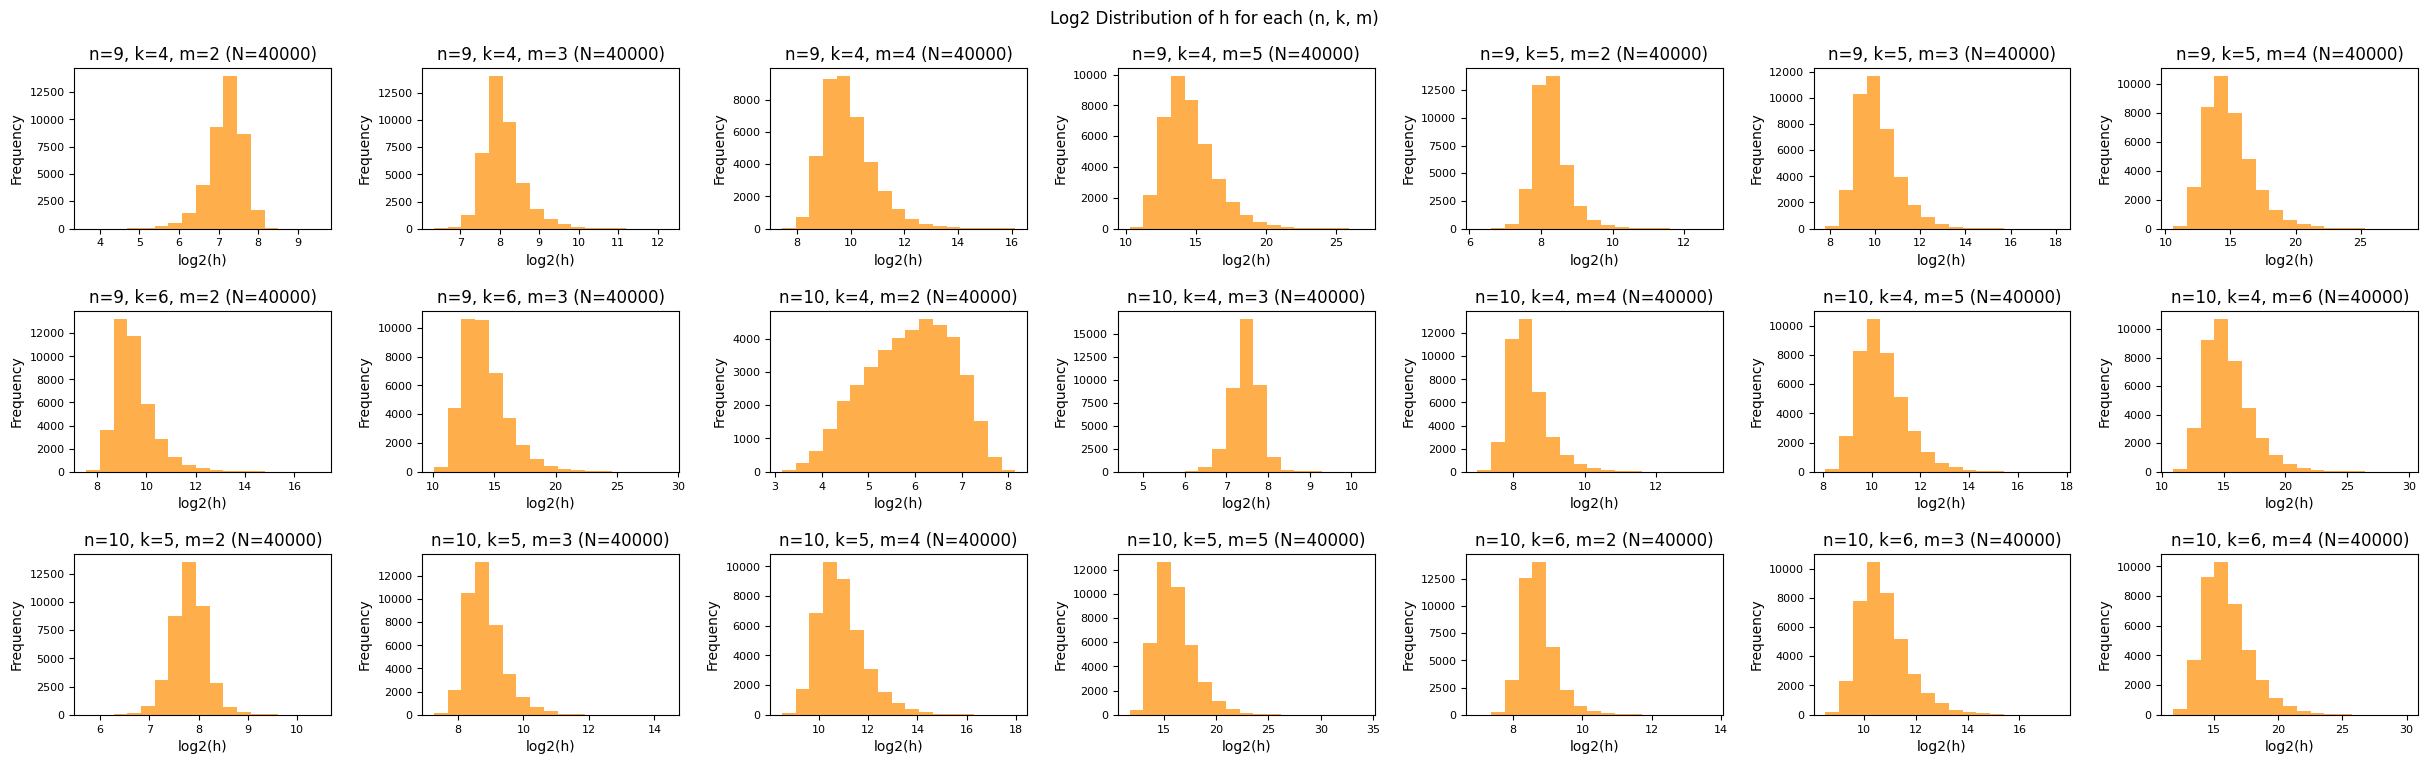


--- Analyzing overall log2(h) distribution for classification binning ---
Total values for overall analysis: 840000
Sturges rule suggests: 21 bins (classes)
Rice rule suggests:    100 bins (classes)
FD rule suggests:      100 bins (classes)

--- Plotting Overall log2(h) Histograms with Suggested Bins ---


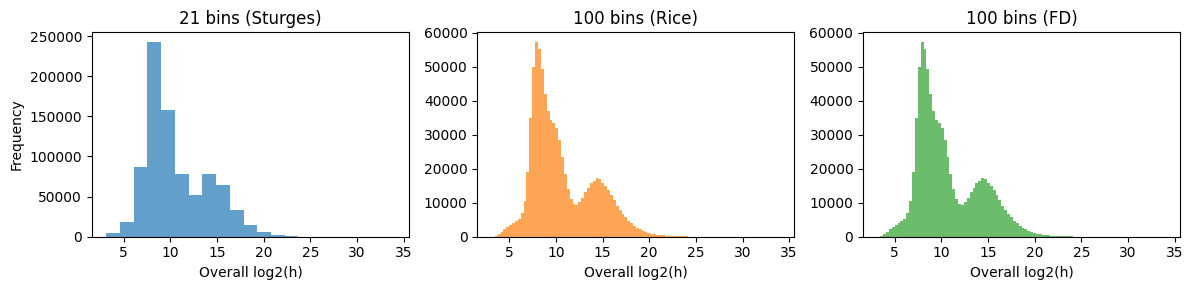


--- Interpretation ---
Review the plots above.
- The first set shows log2(h) distributions within each (n, k, m) group.
- The second set shows the overall log2(h) distribution with bin counts suggested by different rules.
Consider the overall shape, peaks, and the suggestions to decide on a suitable number of classes for the classification task.


In [27]:
# --- Analyze of the dataset to determine the number of classes for the classification problem ---

print("Accessing data from the 'combined_dataset' object...")
# --- Prepare Data (similar to the start of the first analysis cell) ---
n_vals_np = combined_dataset.n_vals.numpy()
k_vals_np = combined_dataset.k_vals.numpy()
m_vals_np = combined_dataset.m_vals.numpy()
h_vals_np = combined_dataset.h_vals.numpy() 

print(f"Total samples available for analysis: {len(h_vals_np)}")

# Group data by (n, k, m)
param_groups = defaultdict(list)
for n, k, m, h in zip(n_vals_np, k_vals_np, m_vals_np, h_vals_np):
    param_groups[(int(n), int(k), int(m))].append(h)
print(f"Found {len(param_groups)} unique (n, k, m) combinations.")

# --- 1. Plot log2(h) distribution for each (n, k, m) group ---
print(f"\n--- Plotting log2(h) histograms for each (n, k, m) combination ---")

num_groups = len(param_groups)
if num_groups > 0:
    ncols = math.ceil(math.sqrt(num_groups))
    if num_groups > 10:
            ncols = max(ncols, math.ceil(num_groups / 3))
            ncols = min(ncols, 7)
    nrows = math.ceil(num_groups / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3.5, nrows * 2.5), squeeze=False)
    axes = axes.flatten()
    plot_idx = 0
    sorted_groups = sorted(param_groups.items())

    for (n, k, m), h_values in sorted_groups:
        if plot_idx < len(axes):
            ax = axes[plot_idx]
            h_vals_group_np = np.array(h_values)
            N_group = len(h_vals_group_np)

            if N_group > 0:
                log2_h_vals_group = np.log2(h_vals_group_np + 1e-9)
                if np.isnan(log2_h_vals_group).any() or np.isinf(log2_h_vals_group).any():
                    print(f"Warning: Found NaN/Inf in log2(h) for group ({n},{k},{m}). Skipping plot.")
                    ax.set_title(f"n={n}, k={k}, m={m} (N={N_group}) - Log Error")
                    ax.text(0.5, 0.5, 'Log Error', ha='center', va='center', transform=ax.transAxes)
                else:
                    bins_group = max(1, min(int(np.ceil(np.log2(N_group))) + 1 if N_group > 1 else 1, 50))
                    ax.hist(log2_h_vals_group, bins=bins_group, alpha=0.7, color='darkorange')
                    ax.set_title(f"n={n}, k={k}, m={m} (N={N_group})")
                    ax.set_xlabel("log2(h)")
                    ax.set_ylabel("Frequency")
                    ax.tick_params(axis='x', labelsize=8)
                    ax.tick_params(axis='y', labelsize=8)
            else:
                ax.set_title(f"n={n}, k={k}, m={m} (N={N_group}) - No data")
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            plot_idx += 1

    # Remove unused subplot axes from the figure
    # When creating a grid with plt.subplots(nrows, ncols), it creates a fixed number of axes
    # If we have fewer groups to plot than available subplot spaces, we need to remove the empty ones
    for i in range(plot_idx, len(axes)): fig.delaxes(axes[i])
    plt.tight_layout(pad=1.5)
    plt.suptitle(f'Log2 Distribution of h for each (n, k, m)', y=1.02)
    plt.show()
else:
    print("No (n, k, m) groups found to plot.")


# --- 2. Analyze overall log2(h) distribution for class definition ---
print("\n--- Analyzing overall log2(h) distribution for classification binning ---")

all_vals = h_vals_np
log_vals = np.log2(all_vals + 1e-9) 
N = len(log_vals)
print(f"Total values for overall analysis: {N}")

if np.isnan(log_vals).any() or np.isinf(log_vals).any():
    print("Warning: Found NaN/Inf in overall log2(h) values. Clamping for analysis.")
    log_vals = np.nan_to_num(log_vals, nan=np.nanmin(log_vals)-1, posinf=np.nanmax(log_vals)+1, neginf=np.nanmin(log_vals)-1)

# Calculate suggested bin counts
sturges, rice, fd_bins = 0, 0, 0 # Initialize
if N > 1:
    sturges = int(np.ceil(np.log2(N))) + 1
    rice    = int(np.ceil(2 * N**(1/3)))
    q75, q25 = np.percentile(log_vals, [75, 25])
    iqr     = q75 - q25
    if iqr > 0:
        fd_bw   = 2 * iqr * N**(-1/3)
        data_range = log_vals.max() - log_vals.min()
        if fd_bw > 0 and data_range > 0:
                fd_bins = int(np.ceil(data_range / fd_bw))
        else:
            fd_bins = sturges 
    else: 
        fd_bins = sturges 

    # Apply reasonableness checks
    max_reasonable_bins = 100
    sturges = max(1, min(sturges, max_reasonable_bins))
    rice = max(1, min(rice, max_reasonable_bins))
    fd_bins = max(1, min(fd_bins, max_reasonable_bins))

    print(f"Sturges rule suggests: {sturges} bins (classes)")
    print(f"Rice rule suggests:    {rice} bins (classes)")
    print(f"FD rule suggests:      {fd_bins} bins (classes)")

    print("\n--- Plotting Overall log2(h) Histograms with Suggested Bins ---")
    plt.figure(figsize=(12, 3))

    plt.subplot(1, 3, 1)
    plt.hist(log_vals, bins=sturges, color="C0", alpha=0.7)
    plt.title(f"{sturges} bins (Sturges)")
    plt.xlabel("Overall log2(h)")
    plt.ylabel("Frequency")

    plt.subplot(1, 3, 2)
    plt.hist(log_vals, bins=rice, color="C1", alpha=0.7)
    plt.title(f"{rice} bins (Rice)")
    plt.xlabel("Overall log2(h)")

    plt.subplot(1, 3, 3)
    plt.hist(log_vals, bins=fd_bins, color="C2", alpha=0.7)
    plt.title(f"{fd_bins} bins (FD)")
    plt.xlabel("Overall log2(h)")

    plt.tight_layout()
    plt.show()

else:
    print("Not enough data points (N<=1) for overall distribution analysis.")

print("\n--- Interpretation ---")
print("Review the plots above.")
print("- The first set shows log2(h) distributions within each (n, k, m) group.")
print("- The second set shows the overall log2(h) distribution with bin counts suggested by different rules.")
print("Consider the overall shape, peaks, and the suggestions to decide on a suitable number of classes for the classification task.")

In [28]:
# --- calculating the best numbers of classes for classification tasks ---
h_vals_np = combined_dataset.h_vals.numpy() 
overall_h_values = h_vals_np

print(f"Calculating bin edges for {len(overall_h_values)} samples...")

# --- Calculate log2 values ---
log2_h_values = np.log2(overall_h_values + 1e-9) # Add epsilon for stability

# Clean up potential NaNs/Infs if any exist (should have been handled before, but good practice)
if np.isnan(log2_h_values).any() or np.isinf(log2_h_values).any():
    print("Warning: Found NaN/Inf in log2(h) values. Clamping for bin calculation.")
    min_val = np.nanmin(log2_h_values[np.isfinite(log2_h_values)]) -1
    max_val = np.nanmax(log2_h_values[np.isfinite(log2_h_values)]) +1
    log2_h_values = np.nan_to_num(log2_h_values, nan=min_val, posinf=max_val, neginf=min_val)

N = len(log2_h_values)

# --- Freedman-Diaconis for Bin Width ---
q75, q25 = np.percentile(log2_h_values, [75, 25])
iqr = q75 - q25
fd_bw = 0
if iqr > 0 and N > 0:
    fd_bw = 2 * iqr * N**(-1/3)

# --- Determine Number of Bins (FD rule) ---
fd_bins = 0
data_range = log2_h_values.max() - log2_h_values.min()
if fd_bw > 0 and data_range > 0:
    fd_bins = int(np.ceil(data_range / fd_bw))
    print(f"FD rule suggests bin width: {fd_bw:.4f}, leading to ~{fd_bins} bins.")
else:
    # Fallback if FD width is invalid (e.g., IQR=0 or N=0)
    sturges_bins = int(np.ceil(np.log2(N))) + 1 if N > 1 else 1
    fd_bins = sturges_bins
    print(f"FD rule failed (IQR={iqr:.4f}, range={data_range:.4f}). Falling back to Sturges rule: {fd_bins} bins.")

num_classes = fd_bins
# --- Generate Bin Edges ---
_, bin_edges_log2 = np.histogram(log2_h_values, bins=num_classes)

# Ensure edges are sorted and unique (should be by default from histogram)
bin_edges_log2 = np.unique(bin_edges_log2)

# Handle edge case where histogram might return fewer bins if data is degenerate
if len(bin_edges_log2) < num_classes + 1:
     print(f"Warning: Histogram generated only {len(bin_edges_log2)-1} bins. Using linspace as fallback.")
     bin_edges_log2 = np.linspace(log2_h_values.min(), log2_h_values.max(), num_classes + 1)


# Convert bin edges back to the original h scale 
bin_edges_orig = 2**bin_edges_log2

print(f"Successfully calculated {len(bin_edges_log2) - 1} bin edges for log2(h).")
print(f"Log2 scale edges (first 5): {bin_edges_log2[:5]}")
print(f"Log2 scale edges (last 5): {bin_edges_log2[-5:]}")

# Convert edges to a tensor for later use
bin_edges_log2_tensor = torch.tensor(bin_edges_log2, dtype=torch.float32)


Calculating bin edges for 840000 samples...
FD rule suggests bin width: 0.1073, leading to ~288 bins.
Successfully calculated 288 bin edges for log2(h).
Log2 scale edges (first 5): [3.1420481 3.2492633 3.3564782 3.4636934 3.5709085]
Log2 scale edges (last 5): [33.591137 33.698353 33.805565 33.91278  34.019997]


In [29]:
# --- Preprocess the data for classification ---
class ClassifWrapper(Dataset):
    """
    Wraps a Dataset to convert continuous targets into class labels based on bin edges.

    Assumes the wrapped dataset's __getitem__ returns (params, h, P, ...).
    Returns (params, class_label, P, original_h, ...).
    """
    def __init__(self, wrapped_dataset: Dataset, bin_edges_log2: np.ndarray):
        """
        Args:
            wrapped_dataset (Dataset): The dataset to wrap (e.g., PickleFolderDataset).
            bin_edges_log2 (np.ndarray): Sorted array of bin edges for the log2(h) values.
                                          Should have length num_classes + 1.
        """
        super().__init__()
        self.wrapped_dataset = wrapped_dataset
        # Ensure edges are numpy for np.digitize
        self.bin_edges_log2 = np.array(bin_edges_log2)
        self.num_classes = len(bin_edges_log2) - 1
        print(f"ClassifWrapper initialized for {self.num_classes} classes.")

    def __len__(self):
        return len(self.wrapped_dataset)

    def __getitem__(self, idx):
        # Get original data - unpack carefully based on wrapped_dataset's return
        original_data = self.wrapped_dataset[idx]
        # Assuming standard return: params, h, P
        # Check if it returns 4 elements 
        if len(original_data) == 4:
             params, original_h, p_matrix, col_indices = original_data
        elif len(original_data) == 3:
            params, original_h, p_matrix = original_data
            col_indices = None 
        else:
            raise ValueError(f"Unexpected number of items ({len(original_data)}) returned by wrapped dataset.")


        # Ensure original_h is a scalar tensor or easily convertible
        if not isinstance(original_h, torch.Tensor):
             original_h = torch.tensor(original_h) # Make sure it's a tensor
        if original_h.ndim > 1:
             original_h = original_h.squeeze() # Remove extra dims if present
        if original_h.numel() != 1:
              raise ValueError(f"Expected scalar h value, got shape {original_h.shape}")


        # Convert h to log2 scale for binning
        h_val = original_h.item() # Get Python float
        log2_h = np.log2(h_val + 1e-9)

        # Find the bin index (class label 0 to num_classes-1)
        # np.digitize returns index i where edges[i-1] <= x < edges[i]
        # Indices are 1-based, so subtract 1 for 0-based class labels.
        class_label = np.digitize(log2_h, self.bin_edges_log2) - 1

        # Clamp label to be within [0, num_classes-1] just in case
        # Handles values exactly equal to the last edge or outside the range.
        class_label = np.clip(class_label, 0, self.num_classes - 1)

        class_label_tensor = torch.tensor(class_label, dtype=torch.long) # CrossEntropyLoss expects Long

        # Return params, label, P, and the original h for later evaluation
        if col_indices is not None:
            return params, class_label_tensor, p_matrix, original_h, col_indices
        else:
            return params, class_label_tensor, p_matrix, original_h


In [30]:
# --- Data loading for classification task ---
train_data_folders = ['./split_data_train_20000_random'] 
validation_data_folders = ['./split_data_validation_20000_random']
max_k = 6
max_nk = 6
batch_size = 512 
val_split_ratio = 0.2
num_workers = 0
pin_memory = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- load original dataset (no normalization at this stage) ---
print("--- Loading Data for Classification ---")
all_files_cls = []
for folder in train_data_folders + validation_data_folders:
     files = glob.glob(os.path.join(folder, '*.pkl'))
     if not files: print(f"Warning: No .pkl files found in folder: {folder}")
     all_files_cls.extend(files)

if not all_files_cls:
    raise FileNotFoundError("No .pkl files found in any specified train/validation folders.")

print(f"Found {len(all_files_cls)} total .pkl files for classification setup.")

# Assuming the model don't need col_indices for now
needs_col_indices = False # Set to True if ResNet/Dense classifiers use embeddings

base_dataset = PickleFolderDataset(
    file_paths=all_files_cls,
    max_k=max_k,
    max_nk=max_nk,
    p_normaliser="none", 
    return_col_indices=needs_col_indices
)

print(f"Base dataset loaded with {len(base_dataset)} samples.")

# --- wrap the dataset for classification ---
wrapped_cls_dataset = ClassifWrapper(
    wrapped_dataset=base_dataset,
    bin_edges_log2=bin_edges_log2 
)

# --- split the wrapped dataset ---
total_samples_cls = len(wrapped_cls_dataset)
val_size_cls = int(total_samples_cls * val_split_ratio)
train_size_cls = total_samples_cls - val_size_cls

if train_size_cls <= 0 or val_size_cls <= 0:
     raise ValueError(f"Calculated train ({train_size_cls}) or validation ({val_size_cls}) size is zero or less.")

print(f"Splitting wrapped data: Training={train_size_cls}, Validation={val_size_cls}")
train_dataset_cls, val_dataset_cls = random_split(wrapped_cls_dataset, [train_size_cls, val_size_cls])

# --- create dataloaders for classification ---
train_loader_cls = DataLoader(
    train_dataset_cls,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)
val_loader_cls = DataLoader(
    val_dataset_cls,
    batch_size=batch_size,
    shuffle=False, # No shuffle for validation
    num_workers=num_workers,
    pin_memory=pin_memory
)
print("Classification DataLoaders created.")
print(f"Training batches: {len(train_loader_cls)}, Validation batches: {len(val_loader_cls)}")

# --- quick check of the first batch ---
try:
    print("\nChecking first batch structure...")
    first_batch = next(iter(train_loader_cls))
    if needs_col_indices:
         params_b, labels_b, p_matrices_b, orig_h_b, col_indices_b = first_batch
         print(f"Params shape: {params_b.shape}, Labels shape: {labels_b.shape}, P shape: {p_matrices_b.shape}, Orig_h shape: {orig_h_b.shape}, Col_idx shape: {col_indices_b.shape}")
    else:
         params_b, labels_b, p_matrices_b, orig_h_b = first_batch
         print(f"Params shape: {params_b.shape}, Labels shape: {labels_b.shape}, P shape: {p_matrices_b.shape}, Orig_h shape: {orig_h_b.shape}")

    print(f"Labels dtype: {labels_b.dtype}, Orig_h dtype: {orig_h_b.dtype}")
    print(f"Sample labels: {labels_b[:5]}")
    print(f"Sample orig_h: {orig_h_b[:5].squeeze()}")

except Exception as e:
    print(f"Error checking first batch: {e}")


--- Loading Data for Classification ---
Found 42 total .pkl files for classification setup.
Loading data from 42 specified pickle files (expecting DataFrames)...
Finished initial loading. Total samples found: 840000
Base dataset loaded with 840000 samples.
ClassifWrapper initialized for 288 classes.
Splitting wrapped data: Training=672000, Validation=168000
Classification DataLoaders created.
Training batches: 1313, Validation batches: 329

Checking first batch structure...
Params shape: torch.Size([512, 3]), Labels shape: torch.Size([512]), P shape: torch.Size([512, 6, 6]), Orig_h shape: torch.Size([512, 1])
Labels dtype: torch.int64, Orig_h dtype: torch.float32
Sample labels: tensor([108,  62,  38,  45, 133])
Sample orig_h: tensor([2.7167e+04, 8.8573e+02, 1.5154e+02, 2.6878e+02, 1.7909e+05])


In [31]:
# --- Definition of the new class model for classification
 
class FlexibleDenseNetworkWithParams(nn.Module): # Placeholder
    def __init__(self, input_p_flat_dim, param_dim, hidden_dims, output_dim=1):
        super().__init__()
        self.flatten = nn.Flatten()
        layers = []
        current_dim = input_p_flat_dim + param_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2)) 
            current_dim = h_dim
        layers.append(nn.Linear(current_dim, output_dim))
        self.network = nn.Sequential(*layers)
        print(f"Placeholder Dense: Input P_flat={input_p_flat_dim}, Param={param_dim}, Hidden={hidden_dims}, Output={output_dim}")


    def forward(self, p_matrix, params):
        p_flat = self.flatten(p_matrix)
        combined = torch.cat([p_flat, params], dim=1)
        return self.network(combined)

class ResNet2DWithParams(nn.Module): # Placeholder
     def __init__(self, block, layers, num_input_channels=1, num_params=3, output_dim=1):
        super().__init__()
        # Dummy ResNet structure - replace with your actual ResNet
        self.encoder = nn.Sequential(
             nn.Conv2d(num_input_channels, 64, kernel_size=3, stride=1, padding=1),
             nn.ReLU(),
             nn.AdaptiveAvgPool2d((1, 1)),
             nn.Flatten()
        )
        self.fc_params = nn.Linear(num_params, 16) # Process params
        self.fc_final = nn.Linear(64 + 16, output_dim) # Combine and output
        print(f"Placeholder ResNet: Input Channels={num_input_channels}, Params={num_params}, Output={output_dim}")


     def forward(self, p_matrix, params):
        p_matrix_unsqueezed = p_matrix.unsqueeze(1) # Add channel dim if needed
        features = self.encoder(p_matrix_unsqueezed)
        param_features = F.relu(self.fc_params(params))
        combined = torch.cat([features, param_features], dim=1)
        return self.fc_final(combined)

# --- Classifier Versions ---

class FlexibleDenseClassifier(nn.Module):
    def __init__(self, base_model: FlexibleDenseNetworkWithParams, num_classes: int):
        super().__init__()
        # Keep all layers except the last one from the base model
        self.features = nn.Sequential(*list(base_model.network.children())[:-1])
        # Get the input dimension to the original last layer
        last_layer_in_features = base_model.network[-1].in_features
        # Add the new classification head
        self.classifier_head = nn.Linear(last_layer_in_features, num_classes)
        self.flatten = base_model.flatten # Reuse flatten layer

        print(f"Dense Classifier: Using base features up to dim {last_layer_in_features}, outputting {num_classes} logits.")

    def forward(self, p_matrix, params):
        p_flat = self.flatten(p_matrix)
        combined = torch.cat([p_flat, params], dim=1)
        # Pass through all layers except the original output layer
        feat = self.features(combined)
        logits = self.classifier_head(feat)
        return logits


class ResNetClassifier(nn.Module):
     def __init__(self, base_model: ResNet2DWithParams, num_classes: int):
        super().__init__()
        # Reuse the encoder and param processing parts
        self.encoder = base_model.encoder
        self.fc_params = base_model.fc_params
        # Get the input dimension to the original final FC layer
        last_layer_in_features = base_model.fc_final.in_features
        # New classification head
        self.classifier_head = nn.Linear(last_layer_in_features, num_classes)

        print(f"ResNet Classifier: Using base features up to dim {last_layer_in_features}, outputting {num_classes} logits.")


     def forward(self, p_matrix, params):
        p_matrix_unsqueezed = p_matrix.unsqueeze(1) # Add channel dim if needed
        features = self.encoder(p_matrix_unsqueezed)
        param_features = F.relu(self.fc_params(params))
        combined = torch.cat([features, param_features], dim=1)
        logits = self.classifier_head(combined)
        return logits

# --- Instantiate Base Models (needed to build classifiers) ---
# Determine flat dimension: max_k * max_nk
input_p_flat_dim = max_k * max_nk
param_dim = 3 # n, k, m
hidden_dims_example = [128, 64] # Example - use your actual dimensions

# Instantiate dummy base models just to get architecture info
# Replace with loading your actual trained regression models if needed,
# but we only need the architecture here.
base_dense_model = FlexibleDenseNetworkWithParams(input_p_flat_dim, param_dim, hidden_dims_example, output_dim=1)

# For ResNet, you need the block type and layer config used in your original model
# Example using dummy block/layers:
class DummyBlock(nn.Module): # Placeholder
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    def forward(self, x): return self.conv(x)

resnet_layers_example = [2, 2, 2, 2] # Example ResNet18-like config
base_resnet_model = ResNet2DWithParams(DummyBlock, resnet_layers_example, num_input_channels=1, num_params=param_dim, output_dim=1)

# --- Instantiate Classifier Models ---
dense_classifier = FlexibleDenseClassifier(base_dense_model, num_classes=num_classes).to(device)
resnet_classifier = ResNetClassifier(base_resnet_model, num_classes=num_classes).to(device)

print(f"\nClassifier models created and moved to {device}.")
# print("\nDense Classifier Structure:")
# print(dense_classifier)
# print("\nResNet Classifier Structure:")
# print(resnet_classifier)

Placeholder Dense: Input P_flat=36, Param=3, Hidden=[128, 64], Output=1
Placeholder ResNet: Input Channels=1, Params=3, Output=1
Dense Classifier: Using base features up to dim 64, outputting 288 logits.
ResNet Classifier: Using base features up to dim 80, outputting 288 logits.

Classifier models created and moved to cuda.


In [32]:
# --- function used for classification task ---
def train_epoch_cls(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_samples = 0

    for batch_data in dataloader:
        # Unpack: params, labels, p_matrices, _ (ignore orig_h)
        # Adjust unpacking if col_indices are present
        if needs_col_indices:
             params, labels, p_matrices, _, col_indices = batch_data
             params, labels, p_matrices, col_indices = params.to(device), labels.to(device), p_matrices.to(device), col_indices.to(device)
        else:
             params, labels, p_matrices, _ = batch_data
             params, labels, p_matrices = params.to(device), labels.to(device), p_matrices.to(device)


        optimizer.zero_grad()

        # --- Model Forward Pass ---
        # Pass data in the order the classifier's forward expects
        # Assuming (p_matrix, params) for both classifiers
        if needs_col_indices:
             outputs = model(p_matrices, params, col_indices) # If model uses col_indices
        else:
             outputs = model(p_matrices, params) # Logits


        # --- Calculate Loss ---
        loss = criterion(outputs, labels) # CrossEntropyLoss expects logits and long labels
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * params.size(0)
        total_samples += params.size(0)

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
    return epoch_loss

def validate_epoch_cls(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch_data in dataloader:
            # Unpack: params, labels, p_matrices, _ (ignore orig_h)
            if needs_col_indices:
                 params, labels, p_matrices, _, col_indices = batch_data
                 params, labels, p_matrices, col_indices = params.to(device), labels.to(device), p_matrices.to(device), col_indices.to(device)
            else:
                 params, labels, p_matrices, _ = batch_data
                 params, labels, p_matrices = params.to(device), labels.to(device), p_matrices.to(device)

            # --- Model Forward Pass ---
            if needs_col_indices:
                 outputs = model(p_matrices, params, col_indices)
            else:
                 outputs = model(p_matrices, params) # Logits

            # --- Calculate Loss ---
            loss = criterion(outputs, labels)

            # --- Calculate Accuracy (Optional) ---
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == labels).sum().item()

            running_loss += loss.item() * params.size(0)
            total_samples += params.size(0)

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0.0
    return epoch_loss, epoch_acc


def run_training_cls(model, train_loader, val_loader, criterion, optimizer, epochs, device, model_name="Classifier", patience=10, scheduler=None):
    print(f"\n--- Starting Classification Training for {model_name} ---")
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    start_time = time.time()
    best_model_path = f"best_{model_name.lower().replace(' ', '_')}_cls.pth"

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()
        print(f"\nEpoch {epoch}/{epochs} ({model_name})")

        train_loss = train_epoch_cls(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch_cls(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        duration = time.time() - epoch_start

        print(f"Epoch {epoch} Summary ({model_name}): "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Duration: {duration:.2f}s")

        if val_loss < best_val_loss:
            print(f"  Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving checkpoint to {best_model_path}")
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1
            print(f"  No improvement in validation loss for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {patience} epochs.")
                break

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

    total_time = time.time() - start_time
    print(f"\n{model_name} Training Finished. Total time: {total_time:.2f}s. Best Val Loss: {best_val_loss:.4f}")
    # Return history and path to best model
    return train_losses, val_losses, val_accuracies, best_model_path

def map_class_to_h_hat(predicted_class_indices, bin_edges_log2_tensor, device):
    """Maps predicted class indices back to continuous h estimates (midpoint)."""
    # Ensure edges are on the correct device
    bin_edges_log2_tensor = bin_edges_log2_tensor.to(device)

    # Get the lower and upper log2 bin edges for each predicted class
    lower_edges = bin_edges_log2_tensor[predicted_class_indices]
    upper_edges = bin_edges_log2_tensor[predicted_class_indices + 1]

    # Calculate the midpoint in log2 scale
    log2_h_hat = (lower_edges + upper_edges) / 2.0

    # Convert back to original h scale
    h_hat = torch.pow(2.0, log2_h_hat)
    return h_hat


class LogMSELossEval(nn.Module): # Renamed to avoid conflict
    """Calculates Log2 MSE for evaluation."""
    def __init__(self, eps=1e-9):
        super().__init__()
        self.eps = eps

    def forward(self, h_hat, h_true):
        h_hat_safe = torch.clamp(h_hat, min=self.eps)
        h_true_safe = torch.clamp(h_true, min=self.eps)
        log2_h_hat = torch.log2(h_hat_safe)
        log2_h_true = torch.log2(h_true_safe)
        loss = torch.mean((log2_h_true - log2_h_hat) ** 2)
        return loss


def evaluate_classifier_log2mse(model, dataloader, bin_edges_log2_tensor, device):
    """Evaluates a trained classifier using Log2-MSE."""
    model.eval()
    total_log2_mse = 0.0
    total_samples = 0
    log2_mse_criterion = LogMSELossEval() # Use the dedicated eval loss

    print("\n--- Evaluating Classifier with Log2-MSE ---")
    with torch.no_grad():
        for batch_data in dataloader:
            # Unpack: params, _, p_matrices, original_h (ignore labels)
            if needs_col_indices:
                 params, _, p_matrices, original_h, col_indices = batch_data
                 params, p_matrices, original_h, col_indices = params.to(device), p_matrices.to(device), original_h.to(device), col_indices.to(device)
            else:
                 params, _, p_matrices, original_h = batch_data
                 params, p_matrices, original_h = params.to(device), p_matrices.to(device), original_h.to(device)

            # --- Model Prediction ---
            if needs_col_indices:
                 outputs = model(p_matrices, params, col_indices) # Logits
            else:
                 outputs = model(p_matrices, params) # Logits

            _, predicted_labels = torch.max(outputs, 1) # Get predicted class indices

            # --- Map predicted class back to continuous h_hat ---
            h_hat = map_class_to_h_hat(predicted_labels, bin_edges_log2_tensor, device)

            # Ensure original_h is squeezed correctly for loss calculation
            original_h = original_h.squeeze()
            if h_hat.shape != original_h.shape:
                 # This might happen if original_h wasn't squeezed properly in dataloader
                 original_h = original_h.view_as(h_hat)


            # --- Calculate Log2-MSE for the batch ---
            batch_log2_mse = log2_mse_criterion(h_hat, original_h)

            total_log2_mse += batch_log2_mse.item() * params.size(0)
            total_samples += params.size(0)

    average_log2_mse = total_log2_mse / total_samples if total_samples > 0 else float('inf')
    print(f"Evaluation Complete. Average Log2-MSE: {average_log2_mse:.4f}")
    return average_log2_mse




--- Starting Classification Training for Dense Classifier ---

Epoch 1/50 (Dense Classifier)
Epoch 1 Summary (Dense Classifier): Train Loss: 4.8002, Val Loss: 4.6696, Val Acc: 0.0243, Duration: 87.44s
  Validation loss improved (inf -> 4.6696). Saving checkpoint to best_dense_classifier_cls.pth

Epoch 2/50 (Dense Classifier)
Epoch 2 Summary (Dense Classifier): Train Loss: 4.7286, Val Loss: 4.6619, Val Acc: 0.0240, Duration: 84.02s
  Validation loss improved (4.6696 -> 4.6619). Saving checkpoint to best_dense_classifier_cls.pth

Epoch 3/50 (Dense Classifier)
Epoch 3 Summary (Dense Classifier): Train Loss: 4.7166, Val Loss: 4.6488, Val Acc: 0.0249, Duration: 86.93s
  Validation loss improved (4.6619 -> 4.6488). Saving checkpoint to best_dense_classifier_cls.pth

Epoch 4/50 (Dense Classifier)
Epoch 4 Summary (Dense Classifier): Train Loss: 4.6950, Val Loss: 4.5985, Val Acc: 0.0293, Duration: 80.50s
  Validation loss improved (4.6488 -> 4.5985). Saving checkpoint to best_dense_classifier_

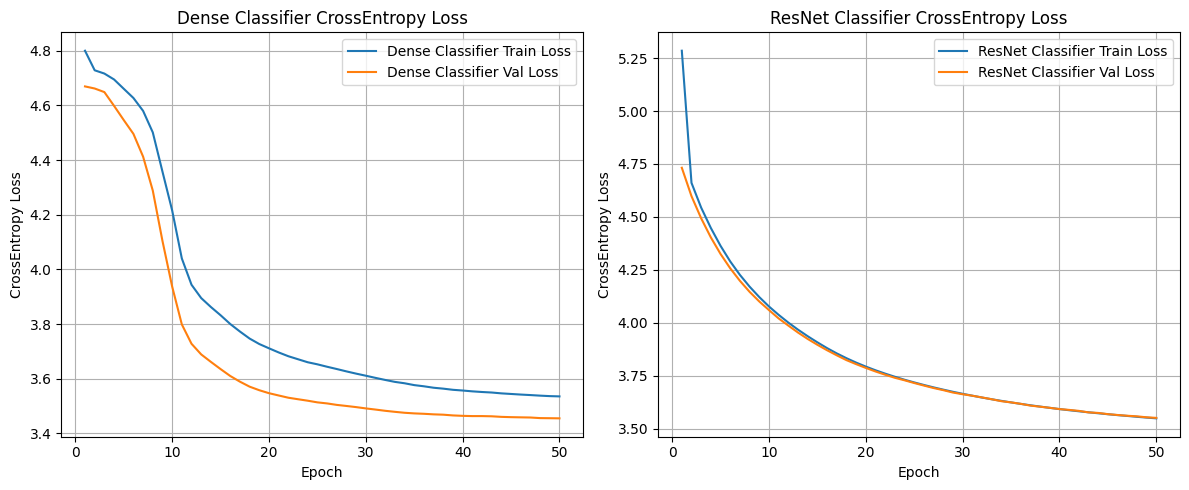

In [34]:
# --- Training Hyperparameters for classification task ---
epochs = 50 
learning_rate = 1e-4 
patience_cls = 5 

# --- Loss Function ---
criterion_cls = nn.CrossEntropyLoss()

# --- Results Storage ---
classification_results = {} # To store final Log2-MSE

# --- Train Dense Classifier ---
model_name_dense = "Dense Classifier"
optimizer_dense = optim.Adam(dense_classifier.parameters(), lr=learning_rate)

history_dense = run_training_cls(
    model=dense_classifier,
    train_loader=train_loader_cls,
    val_loader=val_loader_cls,
    criterion=criterion_cls,
    optimizer=optimizer_dense,
    epochs=epochs,
    device=device,
    model_name=model_name_dense,
    patience=patience_cls,
    scheduler=None 
)
train_losses_d, val_losses_d, val_acc_d, best_model_path_d = history_dense

# Load best checkpoint and evaluate
print(f"\nLoading best model for {model_name_dense} from {best_model_path_d}")
dense_classifier.load_state_dict(torch.load(best_model_path_d))
log2_mse_dense = evaluate_classifier_log2mse(
    model=dense_classifier,
    dataloader=val_loader_cls, # Use the validation loader
    bin_edges_log2_tensor=bin_edges_log2_tensor,
    device=device
)
classification_results[model_name_dense] = log2_mse_dense


# --- Train ResNet Classifier ---
model_name_resnet = "ResNet Classifier"
optimizer_resnet = optim.Adam(resnet_classifier.parameters(), lr=learning_rate)

history_resnet = run_training_cls(
    model=resnet_classifier,
    train_loader=train_loader_cls,
    val_loader=val_loader_cls,
    criterion=criterion_cls,
    optimizer=optimizer_resnet,
    epochs=epochs,
    device=device,
    model_name=model_name_resnet,
    patience=patience_cls,
    scheduler=None 
)
train_losses_r, val_losses_r, val_acc_r, best_model_path_r = history_resnet

# Load best checkpoint and evaluate
print(f"\nLoading best model for {model_name_resnet} from {best_model_path_r}")
resnet_classifier.load_state_dict(torch.load(best_model_path_r))
log2_mse_resnet = evaluate_classifier_log2mse(
    model=resnet_classifier,
    dataloader=val_loader_cls, # Use the validation loader
    bin_edges_log2_tensor=bin_edges_log2_tensor,
    device=device
)
classification_results[model_name_resnet] = log2_mse_resnet


# --- Plot Classification Training Curves (Optional) ---
plot_losses_cls = {
    model_name_dense: (train_losses_d, val_losses_d),
    model_name_resnet: (train_losses_r, val_losses_r)
}

print("\nPlotting Classification Training Loss (CrossEntropy)...")
print("Note: Plot below shows CrossEntropyLoss, not Log2MSE.")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_d)+1), train_losses_d, label=f"{model_name_dense} Train Loss")
plt.plot(range(1, len(val_losses_d)+1), val_losses_d, label=f"{model_name_dense} Val Loss")
plt.title(f"{model_name_dense} CrossEntropy Loss")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses_r)+1), train_losses_r, label=f"{model_name_resnet} Train Loss")
plt.plot(range(1, len(val_losses_r)+1), val_losses_r, label=f"{model_name_resnet} Val Loss")
plt.title(f"{model_name_resnet} CrossEntropy Loss")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()




In [35]:
print("\n--- Final Comparison ---")
print("Log2-MSE from Classification Approach:")
for model_name, score in classification_results.items():
    print(f"- {model_name}: {score:.4f}")

# Add your best regression score here for comparison
best_regression_score = 1.13 # best result obtains in training for the second project
print(f"\nBest Regression Log2-MSE (Example): {best_regression_score:.4f}")

# --- Analysis ---
print("\nComparison:")
improvement = False
for model_name, score in classification_results.items():
    if score < best_regression_score:
        print(f"- {model_name} ({score:.4f}) performed better than the regression baseline ({best_regression_score:.4f}).")
        improvement = True
    else:
        print(f"- {model_name} ({score:.4f}) did not perform better than the regression baseline ({best_regression_score:.4f}).")

if improvement:
    print("Conclusion: Framing the problem as classification appears to have improved the final Log2-MSE.")
else:
    print("Conclusion: Framing the problem as classification did not yield a better Log2-MSE than direct regression.")



--- Final Comparison ---
Log2-MSE from Classification Approach:
- Dense Classifier: 1.6086
- ResNet Classifier: 1.7416

Best Regression Log2-MSE (Example): 1.1300

Comparison:
- Dense Classifier (1.6086) did not perform better than the regression baseline (1.1300).
- ResNet Classifier (1.7416) did not perform better than the regression baseline (1.1300).
Conclusion: Framing the problem as classification did not yield a better Log2-MSE than direct regression.


I increase the number of bins from 100 to 288 but I didn't get a better results

In [ ]:
# --- ViT transformers ---
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.optim.lr_scheduler import CosineAnnealingLR

class ViT2DWithParams(nn.Module):
    """
    Interprets padded P as a single-channel image (k_max x nk_max),
    extracts patches, runs through a Transformer encoder, combines with params,
    and predicts a single output value.
    """
    def __init__(self,
                 k_max=6, nk_max=6,             # Input "image" dimensions
                 n_params=3,                    # Dimension of your parameter vector
                 patch_size=3,                  # Size of square patches (e.g., 3x3)
                 emb_dim=128,                   # Dimension of patch embeddings & transformer
                 n_heads=8,                     # Number of attention heads
                 n_layers=6,                    # Number of transformer encoder layers
                 mlp_dim=512,                   # Dimension of the MLP inside transformer blocks
                 dropout=0.1):
        super().__init__()

        # --- Input validation ---
        assert k_max % patch_size == 0 and nk_max % patch_size == 0, \
            f"Image dimensions ({k_max}x{nk_max}) must be divisible by patch size ({patch_size})"
        self.patch_size = patch_size
        self.emb_dim = emb_dim

        # --- Patching and Embedding ---
        self.num_patches = (k_max // patch_size) * (nk_max // patch_size)
        self.patch_dim = 1 * patch_size * patch_size # 1 channel
        self.patch_embedding = nn.Linear(self.patch_dim, emb_dim)

        # --- Positional Encoding ---
        # Learnable positional embeddings for each patch
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, emb_dim))

        # --- Transformer Encoder ---
        encoder_layer = TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=n_heads,
            dim_feedforward=mlp_dim,
            dropout=dropout,
            batch_first=True  # Important: expects (Batch, Seq, Feature)
        )
        self.transformer_encoder = TransformerEncoder(
            encoder_layer,
            num_layers=n_layers
        )

        # --- Parameter Projection ---
        # Project the n_params vector to match embedding dimension for concatenation
        self.param_proj = nn.Linear(n_params, emb_dim)

        # --- Head ---
        # Takes the pooled transformer output + projected params
        self.head = nn.Sequential(
            nn.LayerNorm(emb_dim + emb_dim), # Normalize combined features
            nn.Linear(emb_dim + emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)               # Final regression output
        )

    def forward(self, P, params):
        B, K, NK = P.shape # Batch, k_max, nk_max
        PS = self.patch_size

        # 1. Reshape and Extract Patches
        # P: (B, K, NK) -> (B, 1, K, NK) add channel dim
        x = P.unsqueeze(1)
        # Extract patches: (B, 1, K, NK) -> (B, num_patches, patch_dim)
        # unfold(dim, size, step)
        x = x.unfold(2, PS, PS).unfold(3, PS, PS) # -> (B, 1, K/PS, NK/PS, PS, PS)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous() # -> (B, K/PS, NK/PS, 1, PS, PS)
        x = x.view(B, self.num_patches, -1) # -> (B, num_patches, patch_dim)

        # 2. Linear Embedding of Patches
        x = self.patch_embedding(x) # (B, num_patches, emb_dim)

        # 3. Add Positional Embedding
        x = x + self.pos_embedding # Broadcasting adds to each batch element

        # 4. Transformer Encoder
        x = self.transformer_encoder(x) # (B, num_patches, emb_dim)

        # 5. Pooling (mean pooling over patch dimension)
        x_pooled = x.mean(dim=1) # (B, emb_dim)

        # 6. Project Parameters
        p = F.relu(self.param_proj(params.float())) # (B, emb_dim)

        # 7. Combine and Predict
        combined = torch.cat([x_pooled, p], dim=1) # (B, emb_dim + emb_dim)
        output = self.head(combined) # (B, 1)

        return output

# --- Example Usage (similar to your training cell setup) ---
# Hyperparameters for the ViT model
vit_config = {
    'k_max': max_k,         # From your data loading
    'nk_max': max_nk,       # From your data loading
    'n_params': 3,          # Your parameter vector size
    'patch_size': 3,        # Choose based on k_max, nk_max (e.g., 2 or 3 if dims are 6x6)
    'emb_dim': 128,
    'n_heads': 8,
    'n_layers': 4,
    'mlp_dim': 256,
    'dropout': 0.1
}

# Instantiate the model
vit_model = ViT2DWithParams(**vit_config).to(device)

# Optimizer, Criterion (use your existing ones)
optimizer_vit = torch.optim.AdamW(vit_model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion_vit = LogMSELoss()

scheduler_vit = CosineAnnealingLR(
    optimizer_vit,
    T_max=100,              # Maximum number of iterations (usually total epochs).
    eta_min=0,              # Minimum learning rate. Default: 0.
    last_epoch=-1,          # The index of last epoch. Default: -1.
    verbose=False           # If True, prints a message to stdout for each update.
)

# Train using your run_training function
# Make sure run_training calls train_epoch_with_params and validate_epoch_with_params
# which expect (P, params) input for the model's forward method.
vit_train_losses, vit_val_losses = run_training(
    model=vit_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_vit,
    optimizer=optimizer_vit,
    scheduler=scheduler_vit, 
    epochs=100, # Adjust as needed
    device=device,
    model_name="ViT_Transformer",
    patience=20
)

# Record and plot
results["ViT_Transformer"] = (vit_train_losses, vit_val_losses)
plot_losses(results)

Results of ViT transformers : Val losses: 1.30, took a lot of time to train and performs better than a normal transformers

In [ ]:
# --- MoE_ResNet with hardgate ---
class MoE_ResNet(nn.Module):
    """
    Mixture-of-Experts with hard gating, using ResNet2DWithParams as each expert.
    Routes each sample to exactly one ResNet expert based on its (n, k) params.
    """
    def __init__(self, unique_nk_pairs, expert_config, params_size=3):
        """
        Args:
            unique_nk_pairs (list[tuple]): List of distinct (n, k) tuples in your dataset.
            expert_config (dict): kwargs for ResNet2DWithParams 
                                  (e.g. {'k_max':6,'nk_max':6,'n_params':3,'base_ch':32,'num_blocks':3}).
            params_size (int):   Dimensionality of the params vector (should match n_params in expert_config).
        """
        super().__init__()
        if not unique_nk_pairs:
            raise ValueError("unique_nk_pairs cannot be empty.")

        # Sort and de-dupe
        self.unique_nk_pairs = sorted(set(unique_nk_pairs))
        self.num_experts     = len(self.unique_nk_pairs)
        self.params_size     = params_size

        # Map each (n,k) to an expert index
        self.nk_to_expert_idx = {
            pair: idx for idx, pair in enumerate(self.unique_nk_pairs)
        }

        # Instantiate one ResNet expert per (n,k)
        self.experts = nn.ModuleList([
            ResNet2DWithParams(**expert_config)
            for _ in range(self.num_experts)
        ])


    def forward(self, p_matrix, params):
        """
        Args:
            p_matrix (Tensor): shape (batch, max_k, max_nk)
            params   (Tensor): shape (batch, params_size), with params[:,0]=n, params[:,1]=k, params[:,2]=m

        Returns:
            Tensor of shape (batch, 1): each row is the output of the single chosen expert.
        """
        batch_size = params.size(0)
        device     = params.device

        # --- 1) Determine expert index per sample ---
        n_vals = params[:, 0].long().tolist()
        k_vals = params[:, 1].long().tolist()
        try:
            expert_indices = [ self.nk_to_expert_idx[(n,k)]
                               for n,k in zip(n_vals, k_vals) ]
        except KeyError as e:
            raise KeyError(f"Unknown (n,k) pair {e} – not in unique_nk_pairs {self.unique_nk_pairs}.")

        expert_idx_tensor = torch.tensor(expert_indices, dtype=torch.long, device=device)
        # shape (batch,)

        # --- 2) Compute every expert’s output on the full batch ---
        all_outputs = []
        for expert in self.experts:
            out = expert(p_matrix, params)   # ➞ (batch, 1)
            all_outputs.append(out)

        # stack ⇒ (batch, num_experts, 1)
        stacked = torch.stack(all_outputs, dim=1)

        # --- 3) Gather the chosen expert’s output per sample ---
        # build an index tensor of shape (batch,1,1)
        idx = expert_idx_tensor.unsqueeze(1).unsqueeze(2)
        idx = idx.expand(-1, 1, stacked.size(2))  # (batch,1,1)

        # gather along dim=1, then squeeze
        selected = torch.gather(stacked, 1, idx).squeeze(1)  # (batch,1)

        return selected

In [ ]:
# --- Training cell for hard‐gated MoE_ResNet ---------------

# 1) configure hyper‐parameters
k_max, nk_max   = max_k, max_nk
n_params        = 3
base_ch, n_blocks = 32, 3
epochs_hard     = 3000
lr_hard         = 3e-4
wd_hard         = 1e-4

unique_nk_pairs = sorted([
    (9, 4), (9, 5), (9, 6),
    (10, 4), (10, 5), (10, 6)
])

# 2) instantiate hard‐gated MoE with ResNet experts
moe_model_hard = MoE_ResNet(
    unique_nk_pairs=unique_nk_pairs,
    expert_config={
        'k_max':   k_max,
        'nk_max':  nk_max,
        'n_params': n_params,
        'base_ch':  base_ch,
        'num_blocks': n_blocks
    },
    params_size=n_params
).to(device)

# 3) loss & optimizer
criterion_hard = LogMSELoss()
optimizer_hard = torch.optim.AdamW(
    moe_model_hard.parameters(), lr=lr_hard, weight_decay=wd_hard
)

# 4) train & validate using your helper
hard_train_losses, hard_val_losses = run_training(
    model=moe_model_hard,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_hard,
    optimizer=optimizer_hard,
    epochs=epochs_hard,
    device=device,
    model_name="MoE_ResNet_HardGate",
    patience = 200
)

# 5) record & plot
results["MoE_ResNet_HardGate"] = (hard_train_losses, hard_val_losses)
plot_losses(results)

Best results : on the training set 0.19 and validation set 1.29 loss value. We can see that the model is overfitting on the training set but maybe as we shuffle randomly the data between the training set and validation set, we have inbalance for some class 

In [44]:
# --- MoE with sparse soft gating

class ConvResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(ch)
        self.bn2 = nn.BatchNorm2d(ch)

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return F.relu(x + h)

class ResNet2DWithParams(nn.Module):
    """
    Interprets padded P as a single‑channel image (k_max×nk_max).
    """
    def __init__(self,
                 k_max=6, nk_max=6,
                 n_params=3,
                 base_ch=32,
                 num_blocks=3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU()
        )
        self.blocks = nn.Sequential(
            *[ConvResBlock(base_ch) for _ in range(num_blocks)]
        )
        flat_dim = base_ch * k_max * nk_max
        self.param_proj = nn.Linear(n_params, 64)
        self.head = nn.Sequential(
            nn.Linear(flat_dim + 64, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, P, params):
        x = P.unsqueeze(1)                  # (B, 1, k_max, nk_max)
        x = self.blocks(self.stem(x))
        x = x.flatten(1)
        p = F.relu(self.param_proj(params.float()))
        x = torch.cat([x, p], dim=1)
        return self.head(x)

# --- Sparse Gating Network ---
class SparseGatingNetwork(nn.Module):
    """Outputs raw logits for each expert based on n and k."""
    def __init__(self, input_dim=2, num_experts=4, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_experts) # Outputs logits

    def forward(self, n_k_params):
        """
        Args:
            n_k_params (torch.Tensor): Input tensor containing normalized 'n' and 'k' parameters, shape (B, 2).

        Returns:
            torch.Tensor: Raw logits for each expert, shape (B, num_experts).
        """
        x = self.relu(self.fc1(n_k_params))
        gate_logits = self.fc2(x) # Raw logits, no softmax here
        return gate_logits


# --- Mixture‐of‐Experts with ResNet2D experts + sparse gating (Top-K) ---
class MoE_ResNet_SparseGate(nn.Module):
    """
    Mixture of ResNet2DWithParams experts with a sparse gating network (top-k).

    Selects the top_k experts based on gating network logits, applies softmax
    only to the selected experts' logits, and computes a weighted sum of their outputs.
    """
    def __init__(self,
                 num_experts: int,
                 k_max: int,
                 nk_max: int,
                 n_params: int,
                 base_ch: int,
                 num_blocks: int,
                 top_k: int = 1, # Number of experts to select per input
                 gating_hidden_dim: int = 16):
        """
        Args:
            num_experts (int): Total number of expert networks.
            k_max (int): Maximum height dimension for the input P matrix padding. Used by experts.
            nk_max (int): Maximum width dimension for the input P matrix padding. Used by experts.
            n_params (int): The dimension of the parameter vector input (excluding P matrix). Used by experts.
            base_ch (int): Base number of channels for the ResNet experts.
            num_blocks (int): Number of blocks in the ResNet experts.
            top_k (int): The number of experts to route each input to. Must be <= num_experts.
                         Default is 1 (standard sparse MoE).
            gating_hidden_dim (int): Hidden dimension size for the gating network.
        """
        super().__init__()
        if not 1 <= top_k <= num_experts:
            raise ValueError(f"top_k ({top_k}) must be between 1 and num_experts ({num_experts})")

        self.num_experts = num_experts
        self.top_k = top_k

        # 1) Gating network producing raw logits
        self.gating = SparseGatingNetwork(
            input_dim=2, # Assumes gating is based on first 2 params (n, k)
            num_experts=num_experts,
            hidden_dim=gating_hidden_dim
        )
        # 2) Build N identical ResNet2D experts
        self.experts = nn.ModuleList([
            ResNet2DWithParams(
                k_max=k_max,
                nk_max=nk_max,
                n_params=n_params,
                base_ch=base_ch,
                num_blocks=num_blocks
            )
            for _ in range(num_experts)
        ])

    def forward(self, p_matrix, params):
        """
        Forward pass for the sparse MoE model.

        Args:
            p_matrix (torch.Tensor): Input P matrix, shape (B, k_max, nk_max).
            params (torch.Tensor): Input parameters, shape (B, n_params).
                                    It's assumed params[:, :2] contains normalized (n, k).

        Returns:
            torch.Tensor: Final output tensor, shape (B, 1).
        """
        batch_size = p_matrix.size(0)
        n_k = params[:, :2] # Extract n, k for gating

        # 1) Compute gating logits
        gate_logits = self.gating(n_k) # Shape: (B, num_experts)

        # 2) Select top-k experts
        # Find the indices and corresponding logits of the top k experts
        top_k_logits, top_k_indices = torch.topk(gate_logits, self.top_k, dim=1)
        # top_k_logits: (B, top_k)
        # top_k_indices: (B, top_k)

        # 3) Compute weights for selected experts (softmax over top-k logits)
        top_k_weights = F.softmax(top_k_logits, dim=1) # Shape: (B, top_k)

        # 4) Compute outputs from ALL experts initially
        # Note: This is less efficient for large num_experts/expensive experts.
        # Optimization: Compute only selected experts (more complex routing logic).
        all_expert_outputs = torch.stack(
            [expert(p_matrix, params) for expert in self.experts],
            dim=1
        ) # Shape: (B, num_experts, 1) (assuming experts output (B, 1))

        # 5) Gather outputs of the selected top-k experts
        # Expand indices to match the dimensions of all_expert_outputs for gather
        # Target shape for indices: (B, top_k, 1)
        indices_expanded = top_k_indices.unsqueeze(-1).expand(-1, -1, all_expert_outputs.size(-1))
        selected_expert_outputs = torch.gather(all_expert_outputs, 1, indices_expanded)
        # Shape: (B, top_k, 1)

        # 6) Compute final output: weighted sum of selected expert outputs
        # Expand weights to match the shape of selected_expert_outputs for broadcasting
        # Target shape for weights: (B, top_k, 1)
        top_k_weights_expanded = top_k_weights.unsqueeze(-1) # Shape: (B, top_k, 1)

        final_output = (top_k_weights_expanded * selected_expert_outputs).sum(dim=1) # Shape: (B, 1)

        return final_output

In [ ]:
# --- training moe with sparse soft gating ---

print("\n--- configuring and training sparse moe ---")

# --- 1) configure hyperparameters ---
sparse_num_experts = 6       # number of experts
sparse_top_k = 1             # <<< specific to sparse gate: number of experts per input
sparse_k_max, sparse_nk_max = max_k, max_nk 
sparse_n_params = 3          # number of parameters (e.g., n, k, m)
sparse_base_ch = 32          # base channels for resnet experts
sparse_n_blocks = 3          # number of resnet blocks
sparse_gating_hd = 16        # gating network hidden dimension
sparse_epochs = 30           # training epochs
sparse_lr = 3e-4             # learning rate
sparse_wd = 1e-4             # weight decay for adamw

# --- make sure data loaders exist ---
# you might need to run the data loading cell first if these are not defined
if 'train_loader' not in locals() or 'val_loader' not in locals():
    print("error: train_loader or val_loader not found. please run data loading cell first.")
    # you might want to stop execution here or load data again:
    # print("loading data again...")
    # train_loader, val_loader = load_and_split_data(...) # fill parameters
else:
    print(f"using existing train_loader ({len(train_loader)} batches) and val_loader ({len(val_loader)} batches).")
    
    # --- 2) instantiate sparse moe model ---
    print("instantiating sparse moe model...")
    try:
        sparse_moe_model = MoE_ResNet_SparseGate(
            num_experts=sparse_num_experts,
            k_max=sparse_k_max,
            nk_max=sparse_nk_max,
            n_params=sparse_n_params,
            base_ch=sparse_base_ch,
            num_blocks=sparse_n_blocks,
            top_k=sparse_top_k, # pass top_k here
            gating_hidden_dim=sparse_gating_hd
        ).to(device) 

        num_params_sparse = sum(p.numel() for p in sparse_moe_model.parameters() if p.requires_grad)
        print(f"sparse moe model instantiated. trainable parameters: {num_params_sparse:,}")

        # --- 3) loss & optimizer ---
        print("setting up loss and optimizer...")
        criterion_sparse = LogMSELoss()
        optimizer_sparse = torch.optim.AdamW(
            sparse_moe_model.parameters(), lr=sparse_lr, weight_decay=sparse_wd
        )
        # optional: define a scheduler if needed
        scheduler_sparse = None # example: torch.optim.lr_scheduler.steplr(optimizer_sparse, step_size=10, gamma=0.1)

        # --- 4) train & validate ---
        sparse_model_name = f"moe_resnet_sparsegate_e{sparse_num_experts}_k{sparse_top_k}"
        print(f"starting training for {sparse_model_name}...")
        
        # make sure run_training is defined and compatible
        sparse_train_losses, sparse_val_losses = run_training(
            model=sparse_moe_model,
            train_loader=train_loader, 
            val_loader=val_loader,     
            criterion=criterion_sparse,
            optimizer=optimizer_sparse,
            epochs=sparse_epochs,
            device=device,
            model_name=sparse_model_name,
            patience=10, # or use a specific patience hyperparameter
            scheduler=scheduler_sparse # pass scheduler if defined
        )

        # --- 5) record & plot ---
        print("training finished. recording and plotting results...")
        if 'results' not in locals():
            results = {} # initialize if it doesn't exist
        results[sparse_model_name] = (sparse_train_losses, sparse_val_losses)
        
        # make sure plot_losses function is defined
        plot_losses(results)

    except NameError as e:
        print(f"\n*** error: a required variable or function is not defined: {e} ***")
        print("please ensure all necessary classes (models, loss, dataset), functions (run_training, plot_losses),")
        print("and variables (device, train_loader, val_loader, max_k, max_nk) are defined in preceding cells.")
    except Exception as e:
        print(f"\n*** an unexpected error occurred during sparse moe setup or training: {e} ***")
        import traceback
        traceback.print_exc()

We have better result with a sparse soft gating than hard gated MoE, we have  1.19 loss value with k=1 and 1.21 with k=2 on the validation set.

In [ ]:
# --- training the best possible ResNet ---
# the fine tuning of the best possible ResNet can be found in the project 2 using Optuna

# ---------- Reuse of the class ResNet to train the best ResNet ---------------
class ConvResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(ch)
        self.bn2 = nn.BatchNorm2d(ch)

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return F.relu(x + h)

class ResNet2DWithParams(nn.Module):
    """
    Interprets padded P as a single‑channel image (k_max×nk_max).
    """
    def __init__(self,
                 k_max=6, nk_max=6,
                 n_params=3,
                 base_ch=32,
                 num_blocks=3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU()
        )
        self.blocks = nn.Sequential(
            *[ConvResBlock(base_ch) for _ in range(num_blocks)]
        )
        flat_dim = base_ch * k_max * nk_max
        self.param_proj = nn.Linear(n_params, 64)
        self.head = nn.Sequential(
            nn.Linear(flat_dim + 64, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, P, params):
        x = P.unsqueeze(1)                  # (B, 1, k_max, nk_max)
        x = self.blocks(self.stem(x))
        x = x.flatten(1)
        p = F.relu(self.param_proj(params.float()))
        x = torch.cat([x, p], dim=1)
        return self.head(x)
    
# Instantiate the 2D‑ResNet‑based model
model = ResNet2DWithParams(
    k_max=max_k,
    nk_max=max_nk,
    n_params=3,     # number of extra numerical features
    base_ch=64,     # number of channels in the stem and residual blocks
    num_blocks=5    # number of ConvResBlock’sx
).to(device)

# Loss & optimizer
criterion = LogMSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3.2e-3, weight_decay=3.8e-4)

# Training
train_losses, val_losses = run_training(
    model, train_loader, val_loader,
    criterion, optimizer,
    epochs=30, device=device,
    model_name='ResNet2D_64_5_finetuned'
)
# Record & plot
results["ResNet2D_64_5_finetuned"] = (train_losses, val_losses)
plot_losses(results)

I tried with different number of channels and number of blocks. turns out that 64ch with 5 blocks and 32ch with 3 blocks have good result.  We are goint to try with these two base model for the MoE architecture

In [ ]:
# --- loading the best pretrained ResNet result for MoE architecture and train with this---

print("\n--- Configuring and Training Sparse MoE with Pre-trained Experts ---")
# --- 1) Configure Hyperparameters ---
pretrained_resnet_weights_path = 'best_resnet_64_5_finetuned.pth' 

sparse_num_experts = 6       # Number of experts
sparse_top_k = 2             # Number of experts per input
sparse_k_max, sparse_nk_max = max_k, max_nk 
sparse_n_params = 3          # Num params (n, k, m) - must match ResNet2DWithParams and data
sparse_base_ch = 64          # Base channels for ResNet experts
sparse_n_blocks = 5          # Num ResNet blocks 
sparse_gating_hd = 16        # Gating network hidden dimension

# Training/Fine-tuning parameters
sparse_epochs = 50        
sparse_lr = 1e-4            # Smaller LR for fine-tuning
sparse_wd = 1e-5          
sparse_patience = 15        # Early stopping 


# Proceed only if all prerequisites are met
print(f"Using existing train_loader ({len(train_loader)} batches) and val_loader ({len(val_loader)} batches).")

# --- Load Pre-trained ResNet State Dictionary ---
print(f"Loading pre-trained ResNet weights from: {pretrained_resnet_weights_path}")
try:
    # Load the state dict from the standalone ResNet model
    pretrained_resnet_state_dict = torch.load(pretrained_resnet_weights_path, map_location=device)
    print("Pre-trained ResNet state_dict loaded successfully.")
except Exception as e:
    print(f"ERROR loading pre-trained weights: {e}")
    pretrained_resnet_state_dict = None

# --- 2) Instantiate Sparse MoE Model ---
# Instantiate regardless of pre-trained weights to check architecture
print("Instantiating Sparse MoE model...")
try:
    sparse_moe_model = MoE_ResNet_SparseGate(
        num_experts=sparse_num_experts,
        k_max=sparse_k_max,
        nk_max=sparse_nk_max,
        n_params=sparse_n_params,      
        base_ch=sparse_base_ch,        
        num_blocks=sparse_n_blocks,    
        top_k=sparse_top_k,
        gating_hidden_dim=sparse_gating_hd
    ).to(device)

    num_params_sparse = sum(p.numel() for p in sparse_moe_model.parameters() if p.requires_grad)
    print(f"Sparse MoE Model Instantiated. Trainable parameters: {num_params_sparse:,}")

    model_instantiated = True
except Exception as e:
    print(f"ERROR Instantiating MoE_ResNet_SparseGate: {e}")
    print("Check if model definition matches the hyperparameters.")
    model_instantiated = False

# --- Load Weights into Experts (if loaded and model instantiated) ---
if model_instantiated and pretrained_resnet_state_dict is not None:
    num_experts_loaded = 0
    total_experts = len(sparse_moe_model.experts)
    print(f"\nAttempting to load pre-trained ResNet weights into {total_experts} experts...")
    load_errors = []

    for i, expert in enumerate(sparse_moe_model.experts):
        try:
            # Load the entire state dict of the standalone ResNet into the expert
            missing_keys, unexpected_keys = expert.load_state_dict(
                pretrained_resnet_state_dict, strict=True
            )

            if not missing_keys and not unexpected_keys:
                num_experts_loaded += 1
            else:
                print(f"  Warning: Loading weights into Expert {i} with strict=True reported issues (unexpected):")
                if missing_keys: print(f"    Missing keys: {missing_keys}")
                if unexpected_keys: print(f"    Unexpected keys: {unexpected_keys}")
                load_errors.append(i)

        except RuntimeError as e:
                print(f"  ERROR loading state_dict into Expert {i} (likely architecture mismatch): {e}")
                print(f"  Expert keys: {expert.state_dict().keys()}")
                print(f"  Pre-trained keys: {pretrained_resnet_state_dict.keys()}")
                load_errors.append(i)
        except Exception as e:
            print(f"  ERROR loading weights into Expert {i}: {e}")
            load_errors.append(i)

    print(f"Finished loading attempt: Successfully loaded pre-trained weights into {num_experts_loaded}/{total_experts} experts.")
    if load_errors:
            print(f"ERROR: Failed to load weights correctly for experts indices: {load_errors}.")
            print("Ensure the ResNet2DWithParams architecture used for the experts")
            print("EXACTLY matches the architecture whose weights were saved in:")
            print(f"'{pretrained_resnet_weights_path}'")
            print("\nProceeding with training, but experts are NOT correctly pre-initialized.")



    # --- Proceed with Training (if model was instantiated) ---
    if model_instantiated:
        # --- 3) Loss & Optimizer ---
        print("\nSetting up loss and optimizer for fine-tuning...")
        criterion_sparse = LogMSELoss()
        optimizer_sparse = torch.optim.AdamW(
            sparse_moe_model.parameters(), lr=sparse_lr, weight_decay=sparse_wd
        )
        scheduler_sparse = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_sparse, 'min', patience=sparse_patience//2, factor=0.2, verbose=True)

        # --- 4) Train & Validate (Fine-tune) ---
        sparse_model_name = f"MoE_ResNet_SparseGate_E{sparse_num_experts}_K{sparse_top_k}_Finetuned"
        if num_experts_loaded != total_experts:
             sparse_model_name = f"MoE_ResNet_SparseGate_E{sparse_num_experts}_K{sparse_top_k}_Scratch" # Indicate training from scratch if loading failed
             print(f"\nWARNING: Starting training from scratch as pre-trained weights could not be loaded into all experts. Model name: {sparse_model_name}")
        else:
             print(f"\nStarting fine-tuning for {sparse_model_name}...")


        # Use the existing run_training function
        sparse_train_losses, sparse_val_losses = run_training(
            model=sparse_moe_model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion_sparse,
            optimizer=optimizer_sparse,
            epochs=sparse_epochs,
            device=device,
            model_name=sparse_model_name,
            patience=sparse_patience, # Use fine-tuning patience
            scheduler=scheduler_sparse
        )

        # --- 5) Record & Plot ---
        print("\nTraining/Fine-tuning finished. Recording and plotting results...")
        if 'results' not in locals():
            results = {} 
        results[sparse_model_name] = (sparse_train_losses, sparse_val_losses)

        plot_losses(results)

    else:
        print("\nSkipping training because model could not be instantiated or weights loaded incorrectly.")


else:
    print("\nSkipping Sparse MoE Training due to missing prerequisites.")


print("\n--- Sparse MoE Training Cell Execution Finished ---")

best results with a sparse soft-gated MoE architecture is 1.06873 on the validation set with 32 channels and 3 bloc for the ResNet and with 64 channels and 5 blocks, we get a better results even if the basemodel ResNet wasn't performing better, loss value on the validation set : 0.9197

In [56]:
# --- evaluate the best sparse moe model on the validation set ---
print("\n--- evaluating best sparse moe model on validation set ---")

# --- 1) Define the CORRECT hyperparameters for the SAVED model ---
sparse_num_experts = 6 
sparse_top_k = 2       
sparse_k_max = 6   
sparse_nk_max = 6 
sparse_n_params = 3    
sparse_base_ch = 64    
sparse_n_blocks = 5    
sparse_gating_hd = 16  

# --- 2) Instantiate the model with the CORRECT architecture ---
print("instantiating sparse moe model with correct architecture...")
try:
    evaluation_model = MoE_ResNet_SparseGate(
        num_experts=sparse_num_experts,
        k_max=sparse_k_max,
        nk_max=sparse_nk_max,
        n_params=sparse_n_params,
        base_ch=sparse_base_ch,
        num_blocks=sparse_n_blocks,
        top_k=sparse_top_k, 
        gating_hidden_dim=sparse_gating_hd
    ).to(device)
    print("model for evaluation instantiated.")

    # --- 3) Construct the path to the best saved model ---
    best_model_filename = "best_moe_resnet_65_5_sparsegate_e6_k2_finetuned.pth" 
    print(f"loading weights from: {best_model_filename}")

    # --- 4) Load the saved state dictionary ---
    state_dict = torch.load(best_model_filename, map_location=device)
    evaluation_model.load_state_dict(state_dict) 
    print("best model weights loaded successfully.")

    # --- 5) Run validation ---
    if 'criterion_sparse' not in locals():
         print("Error: 'criterion_sparse' (loss function) not defined. Please define it.")
    elif 'val_loader' not in locals():
         print("Error: 'val_loader' not defined. Please ensure data is loaded.")
    else:
        print("running validation...")
        final_val_loss = validate_epoch_with_params( 
            model=evaluation_model,      
            dataloader=val_loader,
            criterion=criterion_sparse,  
            device=device
        )
        print(f"\nfinal validation loss (log2 mse) for '{best_model_filename}': {final_val_loss:.4f}")

except FileNotFoundError:
    print(f"\n*** error: saved model file not found at '{best_model_filename}'. ***")
    print("please ensure the file exists.")
except NameError as e:
     print(f"\n*** error: a required variable/class is not defined: {e} ***")
     print("please ensure MoE_ResNet_SparseGate, LogMSELoss, validate_epoch_with_params, val_loader, device, max_k, max_nk etc. are defined.")
except RuntimeError as e:
    print(f"\n*** runtime error during loading (potentially still a mismatch): {e} ***")
    print("double-check ALL hyperparameters used for instantiation against the training run.")
except Exception as e:
    print(f"\n*** an unexpected error occurred during evaluation: {e} ***")
    import traceback
    traceback.print_exc()



--- evaluating best sparse moe model on validation set ---
instantiating sparse moe model with correct architecture...
model for evaluation instantiated.
loading weights from: best_moe_resnet_65_5_sparsegate_e6_k2_finetuned.pth
best model weights loaded successfully.
running validation...

final validation loss (log2 mse) for 'best_moe_resnet_65_5_sparsegate_e6_k2_finetuned.pth': 0.8875


In [57]:
# --- Function to evaluate and group losses by (n, k, m) ---
def evaluate_by_nkm_group(model, dataloader, criterion, device):
    """
    Evaluates the model on the dataloader and returns the average loss 
    for each unique (n, k, m) combination found in the data.

    Args:
        model (nn.Module): The trained model to evaluate.
        dataloader (DataLoader): DataLoader containing the dataset. 
                                 Assumes dataset yields (params, targets, p_matrices),
                                 where params is a tensor [batch_size, 3] with (n, k, m).
        criterion (nn.Module): The loss function (e.g., LogMSELoss).
        device (torch.device): The device to perform calculations on.

    Returns:
        dict: A dictionary where keys are (n, k, m) tuples and values 
              are the average loss for that group. Returns None if an error occurs.
    """
    model.eval() # Set model to evaluation mode
    # Use defaultdict to easily accumulate sum and count for each group
    grouped_losses = defaultdict(lambda: {'sum_loss': 0.0, 'count': 0})
    
    print(f"Iterating through {len(dataloader)} validation batches...")
    processed_samples = 0
    
    try:
        with torch.no_grad(): 
            for i, batch_data in enumerate(dataloader):
                params, targets, p_matrices = batch_data
                params, targets, p_matrices = params.to(device), targets.to(device), p_matrices.to(device)

                # Get model predictions
                outputs = model(p_matrices, params)

                # --- Calculate per-sample log2 mse loss ---
                # Ensure positive values before log2 using criterion's epsilon
                y_pred_safe = torch.clamp(outputs, min=criterion.eps)
                y_true_safe = torch.clamp(targets, min=criterion.eps) 
                log2_pred = torch.log2(y_pred_safe)
                log2_true = torch.log2(y_true_safe)
                
                # Calculate squared difference for each sample (shape: [batch_size, 1] or [batch_size])
                # .squeeze() removes the last dim if it's 1
                sample_losses = ((log2_true - log2_pred) ** 2).squeeze() 

                # Handle case where batch size is 1, resulting in 0-dim tensor
                if sample_losses.dim() == 0:
                    sample_losses = sample_losses.unsqueeze(0) # Make it 1D
                
                # Check if loss calculation was successful
                if sample_losses.shape[0] != params.shape[0]:
                     print(f"Warning: Mismatch in number of losses ({sample_losses.shape[0]}) and params ({params.shape[0]}) in batch {i}. Skipping batch.")
                     continue

                # --- Extract n, k, m and accumulate ---
                # Move params to CPU for numpy conversion, ensure integer type
                cpu_params = params.cpu().numpy().astype(int) 
                
                for j in range(params.size(0)):
                    n_val, k_val, m_val = cpu_params[j, 0], cpu_params[j, 1], cpu_params[j, 2]
                    nkm_tuple = (n_val, k_val, m_val)
                    loss_value = sample_losses[j].item() # Get Python float
                    
                    grouped_losses[nkm_tuple]['sum_loss'] += loss_value
                    grouped_losses[nkm_tuple]['count'] += 1
                
                processed_samples += params.size(0)

        print(f"Finished iterating through batches. Total samples processed: {processed_samples}")

        # --- Calculate average loss for each group ---
        results = {}
        print(f"Calculating average loss for {len(grouped_losses)} (n, k, m) groups found...")
        for nkm_tuple, data in grouped_losses.items():
            if data['count'] > 0:
                results[nkm_tuple] = data['sum_loss'] / data['count']
            else:
                print(f"Warning: Group {nkm_tuple} has count 0.") # Should not happen with defaultdict setup
        
        print("Calculation complete.")
        return results

    except AttributeError as e:
         if 'eps' in str(e):
              print(f"Error: The provided criterion object does not have an 'eps' attribute. Are you sure it's LogMSELoss or similar? Error: {e}")
         else:
              print(f"An AttributeError occurred: {e}")
         return None
    except IndexError as e:
         print(f"An IndexError occurred, likely accessing params tensor columns. Check params shape and indexing (n,k,m should be columns 0,1,2). Error: {e}")
         return None
    except Exception as e:
        print(f"An unexpected error occurred during grouped evaluation: {e}")
        import traceback
        traceback.print_exc()
        return None

# --- Run the evaluation and display results ---
print("\n--- Evaluating model performance per (n, k, m) group on validation set ---")

# Check if necessary variables exist before calling the function
if 'evaluation_model' not in locals():
    print("Error: 'evaluation_model' not found. Please run the cell that loads the model first.")
elif 'val_loader' not in locals():
    print("Error: 'val_loader' not found. Please ensure data loaders are created.")
elif 'criterion_sparse' not in locals():
    print("Error: 'criterion_sparse' (the loss function, e.g., LogMSELoss) not found.")
elif 'device' not in locals():
    print("Error: 'device' (e.g., 'cuda' or 'cpu') not found.")
else:
    grouped_results = evaluate_by_nkm_group(evaluation_model, val_loader, criterion_sparse, device)
    
    # --- Display results in a table if evaluation was successful ---
    if grouped_results is None:
        print("Grouped evaluation failed.")
    elif not grouped_results:
        print("No (n, k, m) groups found in the validation set or evaluation yielded no results.")
    else:
        # Convert the results dictionary to a Pandas DataFrame for nice formatting
        df_results = pd.DataFrame.from_dict(grouped_results, orient='index', columns=['Avg Log2 MSE'])
        df_results.index.names = ['(n, k, m)'] # Name the index
        df_results = df_results.sort_index() # Sort by the (n, k, m) tuple
        
        print("\nValidation Loss per (n, k, m) Group:")
        # Use to_string to print the full DataFrame without truncation
        # and format the float values
        print(df_results.to_string(float_format="%.4f")) 


--- Evaluating model performance per (n, k, m) group on validation set ---
Iterating through 329 validation batches...
Finished iterating through batches. Total samples processed: 168000
Calculating average loss for 21 (n, k, m) groups found...
Calculation complete.

Validation Loss per (n, k, m) Group:
            Avg Log2 MSE
(n, k, m)               
(9, 4, 2)         0.1456
(9, 4, 3)         0.1425
(9, 4, 4)         0.5461
(9, 4, 5)         2.0272
(9, 5, 2)         0.1180
(9, 5, 3)         0.4621
(9, 5, 4)         2.1613
(9, 6, 2)         0.1349
(9, 6, 3)         2.1572
(10, 4, 2)        0.8037
(10, 4, 3)        0.0827
(10, 4, 4)        0.1773
(10, 4, 5)        0.6114
(10, 4, 6)        2.1771
(10, 5, 2)        0.0862
(10, 5, 3)        0.1978
(10, 5, 4)        0.6641
(10, 5, 5)        2.5144
(10, 6, 2)        0.1197
(10, 6, 3)        0.5451
(10, 6, 4)        2.6729


Validation Loss per (n, k, m) Group:  
            Avg Log2 MSE 
(n, k, m)                 
(9, 4, 2)           0.1456   
(9, 4, 3)           0.1425    
(9, 4, 4)           0.5461    
(9, 4, 5)           2.0272    
(9, 5, 2)           0.1180    
(9, 5, 3)           0.4621     
(9, 5, 4)           2.1613    
(9, 6, 2)           0.1349    
(9, 6, 3)           2.1572    
(10, 4, 2)          0.8037    
(10, 4, 3)          0.0827     
(10, 4, 4)          0.1773   
(10, 4, 5)          0.6114     
(10, 4, 6)          2.1771    
(10, 5, 2)          0.0862     
(10, 5, 3)          0.1978    
(10, 5, 4)          0.6641    
(10, 5, 5)          2.5144      
(10, 6, 2)          0.1197     
(10, 6, 3)          0.5451    
(10, 6, 4)          2.6729    

we can wonder if training 21 models is better idea and just create a function that will use the right model.

Using device: cuda
Target combination: (n=10, k=6, m=4)
Using ResNet args: {'base_ch': 32, 'num_blocks': 3, 'k_max': 6, 'nk_max': 6, 'n_params': 3}
Using Training args: {'epochs': 50, 'batch_size': 512, 'learning_rate': 0.00488, 'weight_decay': 0.00027, 'patience': 10, 'scheduler_type': 'none'}

--- Preparing Data for ResNet_10_6_4_Specialized ---
Loading data from 2 specified pickle files (expecting DataFrames)...
Finished initial loading. Total samples found: 40000
Total samples loaded for (10, 6, 4): 40000
Splitting data: Training=32000, Validation=8000
Specialized DataLoaders created.
Training batches: 63, Validation batches: 16

--- Starting Training for ResNet_10_6_4_Specialized ---

--- Starting Training Loop for ResNet_10_6_4_Specialized ---

Epoch 1/50 (ResNet_10_6_4_Specialized)
Epoch 1 Summary (ResNet_10_6_4_Specialized): Train Loss: 66.8532, Val Loss: 27.0425, Duration: 3.93s
  ResNet_10_6_4_Specialized Val loss improved (inf -> 27.0425). Saving checkpoint.

Epoch 2/50 (Res

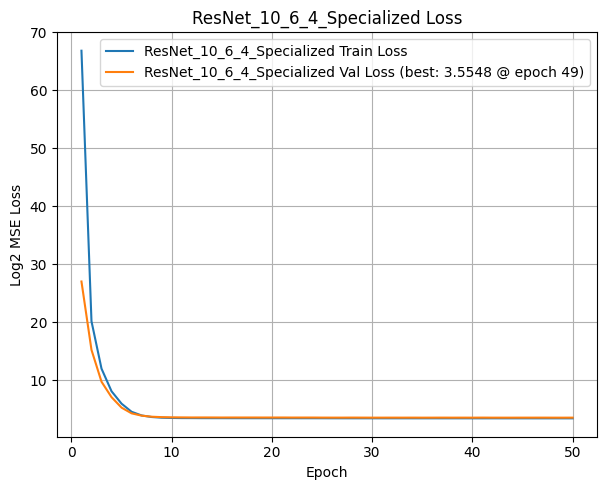

In [ ]:
# --- Configuration for Specific Combination with padding ---

# Data File Paths for (n=10, k=6, m=4)
train_file_10_6_4 = r'C:\Users\theo-\OneDrive\Documents\VS Code project\Deep learning\Project\split_data_train_20000_random\data_n10_k6_m4.pkl'
val_file_10_6_4 = r'C:\Users\theo-\OneDrive\Documents\VS Code project\Deep learning\Project\split_data_validation_20000_random\data_n10_k6_m4.pkl'
specific_files = [train_file_10_6_4, val_file_10_6_4]

# Model Architecture
model_class = ResNet2DWithParams

best_resnet_args = {
    'base_ch': 32,
    'num_blocks': 3,
    'k_max': 6,
    'nk_max': 6,
    'n_params': 3,   
}

# Training Hyperparameters
best_training_args = {
    'epochs': 50,         
    'batch_size': 512,        
    'learning_rate': 0.00488,
    'weight_decay': 0.00027,
    'patience': 10,
    'scheduler_type': 'none'
}
val_split_ratio = 0.2
model_name = "ResNet_10_6_4_Specialized"

# Other Setup
num_workers = 0
pin_memory = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Target combination: (n=10, k=6, m=4)")
print(f"Using ResNet args: {best_resnet_args}")
print(f"Using Training args: {best_training_args}")


# --- Load Data ONLY for the specific combination ---
try:
    print(f"\n--- Preparing Data for {model_name} ---")
    # Verify files exist
    for f_path in specific_files:
        if not os.path.exists(f_path):
            raise FileNotFoundError(f"Specified data file not found: {f_path}")

    # Instantiate dataset using only the two files
    combined_dataset_10_6_4 = PickleFolderDataset(
        file_paths=specific_files,
        max_k=best_resnet_args['k_max'],
        max_nk=best_resnet_args['nk_max'],
        p_normaliser="none"
    )

    total_samples = len(combined_dataset_10_6_4)
    if total_samples == 0:
         raise ValueError("No samples loaded from the specified files. Check file contents.")
    print(f"Total samples loaded for (10, 6, 4): {total_samples}")

    # Perform 80/20 random split on THIS specific dataset
    val_size = int(total_samples * val_split_ratio)
    train_size = total_samples - val_size

    if train_size <= 0 or val_size <= 0:
         raise ValueError(f"Calculated train ({train_size}) or validation ({val_size}) size is zero or less.")

    print(f"Splitting data: Training={train_size}, Validation={val_size}")
    train_dataset_10_6_4, val_dataset_10_6_4 = random_split(combined_dataset_10_6_4, [train_size, val_size])

    # Create DataLoaders for this specific split
    train_loader_10_6_4 = DataLoader(
        train_dataset_10_6_4,
        batch_size=best_training_args['batch_size'],
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    val_loader_10_6_4 = DataLoader(
        val_dataset_10_6_4,
        batch_size=best_training_args['batch_size'],
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    print("Specialized DataLoaders created.")
    print(f"Training batches: {len(train_loader_10_6_4)}, Validation batches: {len(val_loader_10_6_4)}")

except FileNotFoundError as e:
    print(f"\nData Loading Error: {e}")
except ValueError as e:
     print(f"\nData Loading/Splitting Error: {e}")
except Exception as e:
    print(f"\nAn unexpected error occurred during data loading: {type(e).__name__} - {e}")

# --- Setup Model, Loss, Optimizer ---
model_10_6_4 = model_class(**best_resnet_args).to(device)
criterion = LogMSELoss()
optimizer = optim.Adam(model_10_6_4.parameters(),
                       lr=best_training_args['learning_rate'],
                       weight_decay=best_training_args['weight_decay'])

# Optional: Setup scheduler based on Optuna results
scheduler = None
if best_training_args['scheduler_type'] == 'cosine':
     scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=best_training_args['epochs'])
elif best_training_args['scheduler_type'] == 'reduce_on_plateau':
     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# --- Run Training ---
results_10_6_4 = {}
if 'run_training' in globals():
    print(f"\n--- Starting Training for {model_name} ---")
    train_losses, val_losses = run_training(
        model=model_10_6_4,
        train_loader=train_loader_10_6_4,
        val_loader=val_loader_10_6_4,
        criterion=criterion,
        optimizer=optimizer,
        epochs=best_training_args['epochs'],
        device=device,
        model_name=model_name,
        patience=best_training_args['patience'],
        scheduler=scheduler
    )
    results_10_6_4[model_name] = (train_losses, val_losses)
    # --- Plot Losses ---
    if 'plot_losses' in globals():
         plot_losses(results_10_6_4)
    else:
         print("plot_losses function not found, skipping plot.")

else:
    print("\n'run_training' function not defined. Cannot start training.")
    print("Please ensure the training orchestration function is defined in your notebook.")


Using device: cuda
Target combination: (n=10, k=6, m=4)
Using ResNet args: {'base_ch': 32, 'num_blocks': 3, 'k_max': 6, 'nk_max': 4, 'n_params': 3}
Using Training args: {'epochs': 50, 'batch_size': 512, 'learning_rate': 0.00488, 'weight_decay': 0.00027, 'patience': 10, 'scheduler_type': 'none'}

--- Preparing Data for ResNet_10_6_4_Specialized ---
Loading data from 2 specified pickle files (expecting DataFrames)...
Finished initial loading. Total samples found: 40000
Total samples loaded for (10, 6, 4): 40000
Splitting data: Training=32000, Validation=8000
Specialized DataLoaders created.
Training batches: 63, Validation batches: 16

--- Starting Training for ResNet_10_6_4_Specialized ---

--- Starting Training Loop for ResNet_10_6_4_Specialized ---

Epoch 1/50 (ResNet_10_6_4_Specialized)
Epoch 1 Summary (ResNet_10_6_4_Specialized): Train Loss: 68.6757, Val Loss: 29.5803, Duration: 4.17s
  ResNet_10_6_4_Specialized Val loss improved (inf -> 29.5803). Saving checkpoint.

Epoch 2/50 (Res

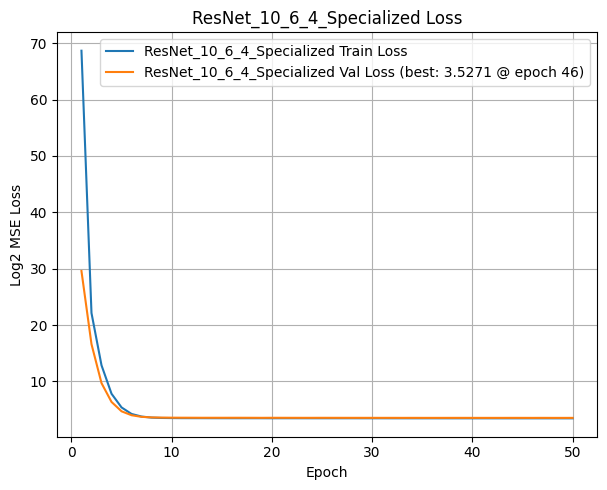

In [66]:
# --- Configuration for Specific Combination with no padding---

# 1. Data File Paths for (n=10, k=6, m=4)
train_file_10_6_4 = r'C:\Users\theo-\OneDrive\Documents\VS Code project\Deep learning\Project\split_data_train_20000_random\data_n10_k6_m4.pkl'
val_file_10_6_4 = r'C:\Users\theo-\OneDrive\Documents\VS Code project\Deep learning\Project\split_data_validation_20000_random\data_n10_k6_m4.pkl'
specific_files = [train_file_10_6_4, val_file_10_6_4]

# 2. Model Architecture (Ensure ResNet2DWithParams class is defined above)
MODEL_CLASS = ResNet2DWithParams

BEST_RESNET_ARGS = {
    'base_ch': 32,    
    'num_blocks': 3, 
    'k_max': 6,       
    'nk_max': 4,      
    'n_params': 3,    
}

# 3. Training Hyperparameters
BEST_TRAINING_ARGS = {
    'epochs': 50,         
    'batch_size': 512,        
    'learning_rate': 0.00488, 
    'weight_decay': 0.00027, 
    'patience': 10,            # Early stopping patience
    'scheduler_type': 'none'  
}
val_split_ratio = 0.2 # 80/20 split for the data 
MODEL_NAME = "ResNet_10_6_4_Specialized" # Specific name for this model

# 4. Other Setup
NUM_WORKERS = 0
PIN_MEMORY = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Target combination: (n=10, k=6, m=4)")
print(f"Using ResNet args: {BEST_RESNET_ARGS}")
print(f"Using Training args: {BEST_TRAINING_ARGS}")




# --- Load Data ONLY for the specific combination ---
try:
    print(f"\n--- Preparing Data for {MODEL_NAME} ---")
    # Verify files exist
    for f_path in specific_files:
        if not os.path.exists(f_path):
            raise FileNotFoundError(f"Specified data file not found: {f_path}")

    # Instantiate dataset using only the two files
    combined_dataset_10_6_4 = PickleFolderDataset(
        file_paths=specific_files,
        max_k=BEST_RESNET_ARGS['k_max'],
        max_nk=BEST_RESNET_ARGS['nk_max'],
        p_normaliser="none" 
    )

    total_samples = len(combined_dataset_10_6_4)
    if total_samples == 0:
         raise ValueError("No samples loaded from the specified files. Check file contents.")
    print(f"Total samples loaded for (10, 6, 4): {total_samples}")

    # Perform 80/20 random split on THIS specific dataset
    val_size = int(total_samples * val_split_ratio)
    train_size = total_samples - val_size

    if train_size <= 0 or val_size <= 0:
         raise ValueError(f"Calculated train ({train_size}) or validation ({val_size}) size is zero or less.")

    print(f"Splitting data: Training={train_size}, Validation={val_size}")
    train_dataset_10_6_4, val_dataset_10_6_4 = random_split(combined_dataset_10_6_4, [train_size, val_size])

    # Create DataLoaders for this specific split
    train_loader_10_6_4 = DataLoader(
        train_dataset_10_6_4,
        batch_size=BEST_TRAINING_ARGS['batch_size'],
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    val_loader_10_6_4 = DataLoader(
        val_dataset_10_6_4,
        batch_size=BEST_TRAINING_ARGS['batch_size'],
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    print("Specialized DataLoaders created.")
    print(f"Training batches: {len(train_loader_10_6_4)}, Validation batches: {len(val_loader_10_6_4)}")

except FileNotFoundError as e:
    print(f"\nData Loading Error: {e}")
except ValueError as e:
     print(f"\nData Loading/Splitting Error: {e}")
except Exception as e:
    print(f"\nAn unexpected error occurred during data loading: {type(e).__name__} - {e}")

# --- Setup Model, Loss, Optimizer ---
model_10_6_4 = MODEL_CLASS(**BEST_RESNET_ARGS).to(device)
criterion = LogMSELoss()
optimizer = optim.Adam(model_10_6_4.parameters(),
                       lr=BEST_TRAINING_ARGS['learning_rate'],
                       weight_decay=BEST_TRAINING_ARGS['weight_decay'])

# Optional: Setup scheduler based on Optuna results
scheduler = None
if BEST_TRAINING_ARGS['scheduler_type'] == 'cosine':
     # Example: Cosine Annealing - adjust T_max as needed
     scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=BEST_TRAINING_ARGS['epochs'])
elif BEST_TRAINING_ARGS['scheduler_type'] == 'reduce_on_plateau':
     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5) # Example patience

# --- Run Training ---
results_10_6_4 = {}

print(f"\n--- Starting Training for {MODEL_NAME} ---")
train_losses, val_losses = run_training(
    model=model_10_6_4,
    train_loader=train_loader_10_6_4,
    val_loader=val_loader_10_6_4,
    criterion=criterion,
    optimizer=optimizer,
    epochs=BEST_TRAINING_ARGS['epochs'],
    device=device,
    model_name=MODEL_NAME,
    patience=BEST_TRAINING_ARGS['patience'],
    scheduler=scheduler
)
results_10_6_4[MODEL_NAME] = (train_losses, val_losses)
# --- Plot Losses ---
if 'plot_losses' in globals():
        plot_losses(results_10_6_4)
else:
        print("plot_losses function not found, skipping plot.")



By specializing a ResNet model on a specific dataset, the model doesn't get a better loss value (3.5 compare to 2.67 with the MoE model). It means that the model still learns from other combinations and that previous approach is still correct.

Target combination: (n=10, k=6, all m)
Using device: cuda
Specialized model input dims: k_max=6, nk_max=4
Using ResNet args: {'base_ch': 64, 'num_blocks': 5, 'k_max': 6, 'nk_max': 4, 'n_params': 3}
Using Training args: {'epochs': 50, 'batch_size': 512, 'learning_rate': 0.00488, 'weight_decay': 0.00027, 'patience': 10, 'scheduler_type': 'none'}

--- Preparing Data for ResNet_10_6_Specialized ---
Found 6 total .pkl files for n=10, k=6.
Loading data from 6 specified pickle files (expecting DataFrames)...
Finished initial loading. Total samples found: 120000
Total samples loaded for (n=10, k=6): 120000
Splitting data: Training=96000, Validation=24000
Specialized DataLoaders created.
Training batches: 188, Validation batches: 47

--- Starting Training for ResNet_10_6_Specialized ---

--- Starting Training Loop for ResNet_10_6_Specialized ---

Epoch 1/50 (ResNet_10_6_Specialized)
Epoch 1 Summary (ResNet_10_6_Specialized): Train Loss: 14.7597, Val Loss: 10.8676, Duration: 24.78s
  ResNet_10_6

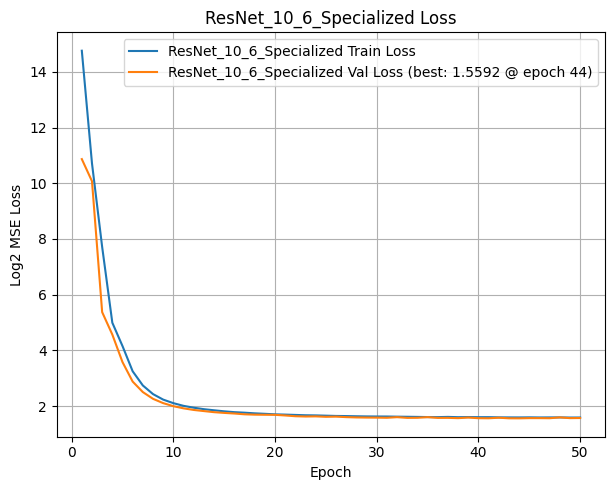

In [67]:
# --- Configuration for Specific (n, k) Combination ---
import re # Import regex for filename parsing

# 1. Target (n, k) pair
target_n = 10
target_k = 6
print(f"Target combination: (n={target_n}, k={target_k}, all m)")

# 2. Data Folder Paths
train_data_folder = r'C:\Users\theo-\OneDrive\Documents\VS Code project\Deep learning\Project\split_data_train_20000_random'
val_data_folder = r'C:\Users\theo-\OneDrive\Documents\VS Code project\Deep learning\Project\split_data_validation_20000_random'

# 3. Model Architecture
model_class = ResNet2DWithParams

# Determine specific k_max and nk_max for THIS model
specific_k_max = target_k
specific_nk_max = target_n - target_k

best_resnet_args = {
    'base_ch': 64,
    'num_blocks': 5,
    'k_max': specific_k_max,
    'nk_max': specific_nk_max,
    'n_params': 3,
}

# 4. Training Hyperparameters
best_training_args = {
    'epochs': 50,
    'batch_size': 512,
    'learning_rate': 0.00488,
    'weight_decay': 0.00027,
    'patience': 10,
    'scheduler_type': 'none'
}
val_split_ratio = 0.2
model_name = f"ResNet_{target_n}_{target_k}_Specialized"

# 5. Other Setup
num_workers = 0
pin_memory = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Specialized model input dims: k_max={specific_k_max}, nk_max={specific_nk_max}")
print(f"Using ResNet args: {best_resnet_args}")
print(f"Using Training args: {best_training_args}")


# --- Find and Load Data ONLY for the specific (n, k) combination ---
def find_n_k_files(folder_path, n_target, k_target):
    """Finds pkl files matching data_n{n_target}_k{k_target}_m*.pkl pattern."""
    pattern = re.compile(rf"data_n{n_target}_k{k_target}_m\d+\.pkl$")
    matching_files = []
    try:
        for filename in os.listdir(folder_path):
            if pattern.match(filename):
                matching_files.append(os.path.join(folder_path, filename))
    except FileNotFoundError:
        print(f"Warning: Folder not found {folder_path}")
    return matching_files

try:
    print(f"\n--- Preparing Data for {model_name} ---")
    train_files_nk = find_n_k_files(train_data_folder, target_n, target_k)
    val_files_nk = find_n_k_files(val_data_folder, target_n, target_k)
    specific_files = train_files_nk + val_files_nk

    if not specific_files:
         raise FileNotFoundError(f"No .pkl files found for n={target_n}, k={target_k} in the specified folders.")

    print(f"Found {len(specific_files)} total .pkl files for n={target_n}, k={target_k}.")

    # Instantiate dataset using only the found files
    combined_dataset_nk = PickleFolderDataset(
        file_paths=specific_files,
        max_k=specific_k_max,
        max_nk=specific_nk_max, 
        p_normaliser= None 
    )

    total_samples = len(combined_dataset_nk)
    if total_samples == 0:
         raise ValueError("No samples loaded from the specified files. Check file contents and pattern.")
    print(f"Total samples loaded for (n={target_n}, k={target_k}): {total_samples}")

    # Perform 80/20 random split on THIS specific dataset
    val_size = int(total_samples * val_split_ratio)
    train_size = total_samples - val_size

    if train_size <= 0 or val_size <= 0:
         raise ValueError(f"Calculated train ({train_size}) or validation ({val_size}) size is zero or less.")

    print(f"Splitting data: Training={train_size}, Validation={val_size}")
    train_dataset_nk, val_dataset_nk = random_split(combined_dataset_nk, [train_size, val_size])

    # Create DataLoaders for this specific split
    train_loader_nk = DataLoader(
        train_dataset_nk,
        batch_size=best_training_args['batch_size'],
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    val_loader_nk = DataLoader(
        val_dataset_nk,
        batch_size=best_training_args['batch_size'],
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    print("Specialized DataLoaders created.")
    print(f"Training batches: {len(train_loader_nk)}, Validation batches: {len(val_loader_nk)}")

except FileNotFoundError as e:
    print(f"\nData Loading Error: {e}")
except ValueError as e:
     print(f"\nData Loading/Splitting Error: {e}")
except Exception as e:
    print(f"\nAn unexpected error occurred during data loading: {type(e).__name__} - {e}")


# --- Setup Model, Loss, Optimizer ---
model_nk = model_class(**best_resnet_args).to(device)
criterion = LogMSELoss()
optimizer = optim.Adam(model_nk.parameters(),
                       lr=best_training_args['learning_rate'],
                       weight_decay=best_training_args['weight_decay'])

# Optional: Setup scheduler
scheduler = None
if best_training_args['scheduler_type'] == 'cosine':
     scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=best_training_args['epochs'])
elif best_training_args['scheduler_type'] == 'reduce_on_plateau':
     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# --- Run Training ---
results_nk = {}
if 'run_training' in globals() and 'train_loader_nk' in locals():
    print(f"\n--- Starting Training for {model_name} ---")
    train_losses, val_losses = run_training(
        model=model_nk,
        train_loader=train_loader_nk,
        val_loader=val_loader_nk,
        criterion=criterion,
        optimizer=optimizer,
        epochs=best_training_args['epochs'],
        device=device,
        model_name=model_name,
        patience=best_training_args['patience'],
        scheduler=scheduler
    )
    results_nk[model_name] = (train_losses, val_losses)
    # --- Plot Losses ---
    if 'plot_losses' in globals():
         plot_losses(results_nk)
    else:
         print("plot_losses function not found, skipping plot.")
else:
    print("\nTraining prerequisites not met (e.g., 'run_training' function undefined or data loading failed). Skipping training.")


Target combination: (n=10, k=6, all m)
Using device: cuda
Specialized model input dims: k_max=6, nk_max=4
Using ResNet args: {'base_ch': 64, 'num_blocks': 5, 'k_max': 6, 'nk_max': 4, 'n_params': 3}
Using Training args: {'epochs': 50, 'batch_size': 512, 'learning_rate': 0.00488, 'weight_decay': 0.00027, 'patience': 10, 'scheduler_type': 'none'}

--- Preparing Data for ResNet_10_6_Specialized_test ---
Found 6 total .pkl files for n=10, k=6.

Data Loading/Splitting Error: Invalid p_normaliser: None. Must be one of: ['none', 'row_standard', 'col_minmax']

--- Starting Training for ResNet_10_6_Specialized_test ---

--- Starting Training Loop for ResNet_10_6_Specialized_test ---

Epoch 1/50 (ResNet_10_6_Specialized_test)
Epoch 1 Summary (ResNet_10_6_Specialized_test): Train Loss: 12.5054, Val Loss: 10.6560, Duration: 27.27s
  ResNet_10_6_Specialized_test Val loss improved (inf -> 10.6560). Saving checkpoint.

Epoch 2/50 (ResNet_10_6_Specialized_test)
Epoch 2 Summary (ResNet_10_6_Specialized_

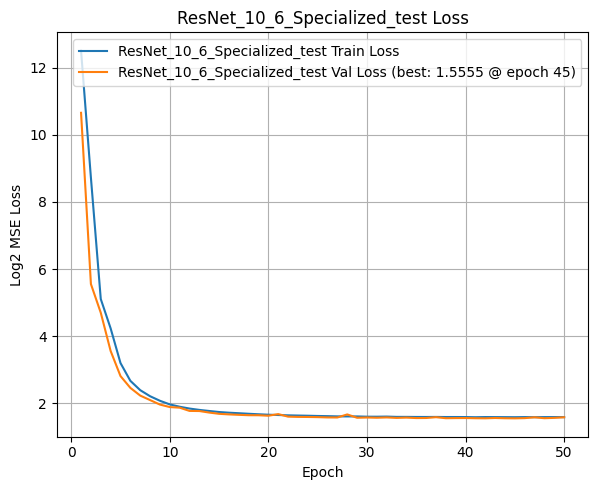

In [68]:
# --- Configuration for Specific (n, k) Combination ---
import re # Import regex for filename parsing

# 1. Target (n, k) pair
target_n = 10
target_k = 6
print(f"Target combination: (n={target_n}, k={target_k}, all m)")

# 2. Data Folder Paths
train_data_folder = r'C:\Users\theo-\OneDrive\Documents\VS Code project\Deep learning\Project\split_data_train_20000_random'
val_data_folder = r'C:\Users\theo-\OneDrive\Documents\VS Code project\Deep learning\Project\split_data_validation_20000_random'

# 3. Model Architecture
model_class = ResNet2DWithParams

# Determine specific k_max and nk_max for this model
specific_k_max = target_k
specific_nk_max = target_n - target_k

best_resnet_args = {
    'base_ch': 64,
    'num_blocks': 5,
    'k_max': specific_k_max,
    'nk_max': specific_nk_max,
    'n_params': 3,
}

# 4. Training Hyperparameters
best_training_args = {
    'epochs': 50,
    'batch_size': 512,
    'learning_rate': 0.00488,
    'weight_decay': 0.00027,
    'patience': 10,
    'scheduler_type': 'none'
}
val_split_ratio = 0.2
model_name = f"ResNet_{target_n}_{target_k}_Specialized_test"

# 5. Other Setup
num_workers = 0
pin_memory = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Specialized model input dims: k_max={specific_k_max}, nk_max={specific_nk_max}")
print(f"Using ResNet args: {best_resnet_args}")
print(f"Using Training args: {best_training_args}")


# --- Find and Load Data ONLY for the specific (n, k) combination ---
def find_n_k_files(folder_path, n_target, k_target):
    """Finds pkl files matching data_n{n_target}_k{k_target}_m*.pkl pattern."""
    pattern = re.compile(rf"data_n{n_target}_k{k_target}_m\d+\.pkl$")
    matching_files = []
    try:
        for filename in os.listdir(folder_path):
            if pattern.match(filename):
                matching_files.append(os.path.join(folder_path, filename))
    except FileNotFoundError:
        print(f"Warning: Folder not found {folder_path}")
    return matching_files

try:
    print(f"\n--- Preparing Data for {model_name} ---")
    train_files_nk = find_n_k_files(train_data_folder, target_n, target_k)
    val_files_nk = find_n_k_files(val_data_folder, target_n, target_k)
    specific_files = train_files_nk + val_files_nk

    if not specific_files:
         raise FileNotFoundError(f"No .pkl files found for n={target_n}, k={target_k} in the specified folders.")

    print(f"Found {len(specific_files)} total .pkl files for n={target_n}, k={target_k}.")

    combined_dataset_nk = PickleFolderDataset(
        file_paths=specific_files,
        max_k=specific_k_max,
        max_nk=specific_nk_max,
        p_normaliser= None 
    )

    total_samples = len(combined_dataset_nk)
    if total_samples == 0:
         raise ValueError("No samples loaded from the specified files. Check file contents and pattern.")
    print(f"Total samples loaded for (n={target_n}, k={target_k}): {total_samples}")

    val_size = int(total_samples * val_split_ratio)
    train_size = total_samples - val_size

    if train_size <= 0 or val_size <= 0:
         raise ValueError(f"Calculated train ({train_size}) or validation ({val_size}) size is zero or less.")

    print(f"Splitting data: Training={train_size}, Validation={val_size}")
    train_dataset_nk, val_dataset_nk = random_split(combined_dataset_nk, [train_size, val_size])

    train_loader_nk = DataLoader(
        train_dataset_nk,
        batch_size=best_training_args['batch_size'],
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    val_loader_nk = DataLoader(
        val_dataset_nk,
        batch_size=best_training_args['batch_size'],
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    print("Specialized DataLoaders created.")
    print(f"Training batches: {len(train_loader_nk)}, Validation batches: {len(val_loader_nk)}")

except FileNotFoundError as e:
    print(f"\nData Loading Error: {e}")
except ValueError as e:
     print(f"\nData Loading/Splitting Error: {e}")
except Exception as e:
    print(f"\nAn unexpected error occurred during data loading: {type(e).__name__} - {e}")

# --- Setup Model, Loss, Optimizer ---
model_nk = model_class(**best_resnet_args).to(device)
criterion = LogMSELoss()
optimizer = optim.Adam(model_nk.parameters(),
                       lr=best_training_args['learning_rate'],
                       weight_decay=best_training_args['weight_decay'])

# Optional: Setup scheduler
scheduler = None
if best_training_args['scheduler_type'] == 'cosine':
     scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=best_training_args['epochs'])
elif best_training_args['scheduler_type'] == 'reduce_on_plateau':
     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# --- Run Training ---
results_nk = {}
if 'run_training' in globals() and 'train_loader_nk' in locals():
    print(f"\n--- Starting Training for {model_name} ---")
    train_losses, val_losses = run_training(
        model=model_nk,
        train_loader=train_loader_nk,
        val_loader=val_loader_nk,
        criterion=criterion,
        optimizer=optimizer,
        epochs=best_training_args['epochs'],
        device=device,
        model_name=model_name,
        patience=best_training_args['patience'],
        scheduler=scheduler
    )
    results_nk[model_name] = (train_losses, val_losses)
    if 'plot_losses' in globals():
         plot_losses(results_nk)
    else:
         print("plot_losses function not found, skipping plot.")
else:
    print("\nTraining prerequisites not met (e.g., 'run_training' function undefined or data loading failed). Skipping training.")


# ---------------------------------------------------------      
Below this line are the code of the PROJECT 2: we are keeping only the cell that we are interested in like the class "PickleDataLoader", "FlexibleDenseNetworkWithParams","MoE_FCN_SoftGate"

Here is the plan for this project:  
- Increase the number of data used by 2 to see its influence on the cost
- Try deeper FCN with Residual connection
- Try Transformers
- Try batch normalization
- try ResNet architecture to see its performance

In [ ]:
# --- Data Loading and Preparation Embedded data---
# --- Configuration ---
TRAIN_DATA_FOLDERS = ['./split_data_train_20000_random']
VALIDATION_DATA_FOLDERS = ['./split_data_validation_20000_random']
max_k = 6
max_nk = 6
batch_size = 512 
val_split_ratio = 0.2 # 80/20 split
NUM_WORKERS = 0 # Safer default for Windows
PIN_MEMORY = True # Generally good if using GPU

# --- Variables to store loaders (so they are accessible by the next cell) ---
train_loader_embed = None
val_loader_embed = None

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load and Split Data ---
try:
    print("--- Preparing Data ---")
    all_files = []
    for folder in TRAIN_DATA_FOLDERS + VALIDATION_DATA_FOLDERS:
         files = glob.glob(os.path.join(folder, '*.pkl'))
         if not files:
              print(f"Warning: No .pkl files found in folder: {folder}")
         all_files.extend(files)

    if not all_files:
        raise FileNotFoundError("No .pkl files found in any specified train/validation folders.")

    print(f"Found {len(all_files)} total .pkl files.")

    # Instantiate the dataset with the combined list of files
    combined_dataset_embed = PickleFolderDataset(
        file_paths=all_files,
        max_k=max_k,
        max_nk=max_nk,
        p_normaliser= "col_minmax",
        return_col_indices= True
    )

    total_samples = len(combined_dataset_embed)
    print(f"Total samples loaded from combined files: {total_samples}")

    # Perform random split
    val_size = int(total_samples * val_split_ratio)
    train_size = total_samples - val_size

    if train_size <= 0 or val_size <= 0:
         raise ValueError(f"Calculated train ({train_size}) or validation ({val_size}) size is zero or less.")

    print(f"Splitting data: Training={train_size} ({100*(1-val_split_ratio):.1f}%), Validation={val_size} ({100*val_split_ratio:.1f}%)")
    train_dataset_embed, val_dataset_embed = random_split(combined_dataset_embed, [train_size, val_size])

    # Create DataLoaders and store them in global scope for this cell block
    train_loader_embed = DataLoader(
        train_dataset_embed,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    val_loader_embed = DataLoader(
        val_dataset_embed,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    print("\nFinal DataLoaders created successfully.")
    print(f"Training batches: {len(train_loader_embed)}, Validation batches: {len(val_loader_embed)}")

except FileNotFoundError as e:
    print(f"\nData Loading Error: {e}")
    print("Please ensure the TRAIN_DATA_FOLDERS and VALIDATION_DATA_FOLDERS paths are correct.")
except ValueError as e:
     print(f"\nData Loading/Splitting Error: {e}")
     print("Check data contents, split ratio, or if the dataset ended up empty.")
except NameError as e:
     print(f"\nDefinition Error: {e}. Make sure 'PickleFolderDatasetWithParams' class is defined and executed first.")
except ImportError as e:
     print(f"\nImport Error: {e}. Make sure required libraries (torch, pickle, pandas etc.) are imported.")
except Exception as e:
    print(f"\nAn unexpected error occurred during data loading/splitting: {type(e).__name__} - {e}")
    print("Traceback:")
    print(traceback.format_exc())


Using device: cuda
--- Preparing Data ---
Found 42 total .pkl files.
Loading data from 42 specified pickle files (expecting DataFrames)...
Finished initial loading. Total samples found: 840000
Total samples loaded from combined files: 840000
Splitting data: Training=672000 (80.0%), Validation=168000 (20.0%)

Final DataLoaders created successfully.
Training batches: 1313, Validation batches: 329


In [7]:
# --- fine tuning FCN ---
# --- configuration ---
fcn_padded_p_matrix_flat_size = max_k * max_nk
fcn_params_size = 3

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for FCN tuning: {device}")

# --- Flexible Dense Network Definition ---
class FlexibleDenseNetworkWithParams(nn.Module):
    """
    Dense Network accepting flattened padded P matrix and n, k, m parameters.
    Hidden layers are defined by a list of dimensions.
    """
    def __init__(self, p_input_size, param_input_size, hidden_dims=[128, 64, 32], output_size=1, dropout_prob=0.2):
        super().__init__()
        self.param_input_size = param_input_size
        combined_input_size = p_input_size + param_input_size

        layers = []
        prev_dim = combined_input_size
        # Input layer check: Ensure first hidden dim connects to combined input
        if not hidden_dims: # Handle case of no hidden layers (direct linear)
             layers.append(nn.Linear(combined_input_size, output_size))
        else:
            # First hidden layer
            layers.append(nn.Linear(combined_input_size, hidden_dims[0]))
            layers.append(nn.ReLU())
            if dropout_prob > 0:
                layers.append(nn.Dropout(dropout_prob))
            prev_dim = hidden_dims[0]

            # Subsequent hidden layers
            for i in range(1, len(hidden_dims)):
                h_dim = hidden_dims[i]
                layers.append(nn.Linear(prev_dim, h_dim))
                layers.append(nn.ReLU())
                if dropout_prob > 0:
                    layers.append(nn.Dropout(dropout_prob))
                prev_dim = h_dim

            # Final output layer connects from the last hidden layer
            layers.append(nn.Linear(prev_dim, output_size))

        self.network = nn.Sequential(*layers)
        print(f"Initialized FlexibleDenseNetworkWithParams:")
        print(f"  Input Size (Flat P + Params): {combined_input_size}")
        print(f"  Hidden Dims: {hidden_dims}")
        print(f"  Output Size: {output_size}")
        # print(self.network) # Optional: print the layer structure

    def forward(self, p_matrix, params):
        batch_size = p_matrix.size(0)
        p_flat = p_matrix.view(batch_size, -1) # Flatten P matrix

        # Ensure params tensor has the correct shape (batch_size, num_params)
        if params.dim() == 1: # If it's a single sample (batch size 1 during inference maybe?)
             params = params.unsqueeze(0)
        if params.size(1) != self.param_input_size:
             raise ValueError(f"Params tensor second dimension ({params.size(1)}) != expected param_input_size ({self.param_input_size})")

        combined_input = torch.cat((p_flat, params), dim=1)
        return self.network(combined_input)

# --- Training Function for One Tuning Trial ---
def run_fcn_tuning_trial(config, train_loader, val_loader, p_input_size, param_input_size, epochs, device):
    """Trains and evaluates one FCN configuration."""
    print(f"\n--- Starting Trial: {config.get('name', config)} ---")
    start_time = time.time()

    # Extract config
    hidden_dims = config['hidden_dims']
    learning_rate = config['lr']
    dropout_prob = config.get('dropout', 0.2) # Use default if not specified
    weight_decay = config.get('weight_decay', 0) # Get weight_decay from config, default to 0

    # Ensure Loss function is defined (should be LogMSELoss)
    if 'LogMSELoss' not in globals():
         raise NameError("LogMSELoss class is not defined.")
    criterion = LogMSELoss()

    # Instantiate model, criterion, optimizer
    model = FlexibleDenseNetworkWithParams(
        p_input_size=p_input_size,
        param_input_size=param_input_size,
        hidden_dims=hidden_dims,
        dropout_prob=dropout_prob
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    # Check if training functions are defined
    if 'train_epoch_with_params' not in globals() or 'validate_epoch_with_params' not in globals():
         raise NameError("train_epoch_with_params or validate_epoch_with_params function is not defined.")

    print(f"  Training for {epochs} epochs...")
    for epoch in range(epochs):
        train_loss = train_epoch_with_params(model, train_loader, criterion, optimizer, device)
        val_loss = validate_epoch_with_params(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"  Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss

    end_time = time.time()
    print(f"--- Trial Finished: {config.get('name', config)} ---")
    print(f"  Best Val Loss during trial: {best_val_loss:.4f}")
    print(f"  Total Time: {end_time - start_time:.2f}s")

    # Return the minimum validation loss achieved during this trial
    return {'config': config, 'best_val_loss': best_val_loss, 'train_losses': train_losses, 'val_losses': val_losses}

print("Setup Complete: Flexible FCN class and tuning trial function are defined.")


Using device for FCN tuning: cuda
Setup Complete: Flexible FCN class and tuning trial function are defined.



--- Starting Final Training for Selected FCN ---
Using Configuration: {'name': 'FCN_128_64_32_lr5e-4', 'hidden_dims': [512, 256, 128], 'lr': 0.0005, 'dropout': 0.3, 'weight_decay': 1e-05}
Training for 40 epochs.
Best model weights will be saved to: best_fcn_pretrained_weights.pth
Initialized FlexibleDenseNetworkWithParams:
  Input Size (Flat P + Params): 39
  Hidden Dims: [512, 256, 128]
  Output Size: 1
Starting final training run...
Epoch 1/40 | Train Loss: 13.1391 | Val Loss: 10.8700 | Time: 53.16s
  -> Val loss improved to 10.8700. Model weights saved to best_fcn_pretrained_weights.pth
Epoch 2/40 | Train Loss: 10.0961 | Val Loss: 7.9521 | Time: 52.25s
  -> Val loss improved to 7.9521. Model weights saved to best_fcn_pretrained_weights.pth
Epoch 3/40 | Train Loss: 5.2197 | Val Loss: 2.9379 | Time: 52.65s
  -> Val loss improved to 2.9379. Model weights saved to best_fcn_pretrained_weights.pth
Epoch 4/40 | Train Loss: 2.8051 | Val Loss: 2.0519 | Time: 57.54s
  -> Val loss improved to

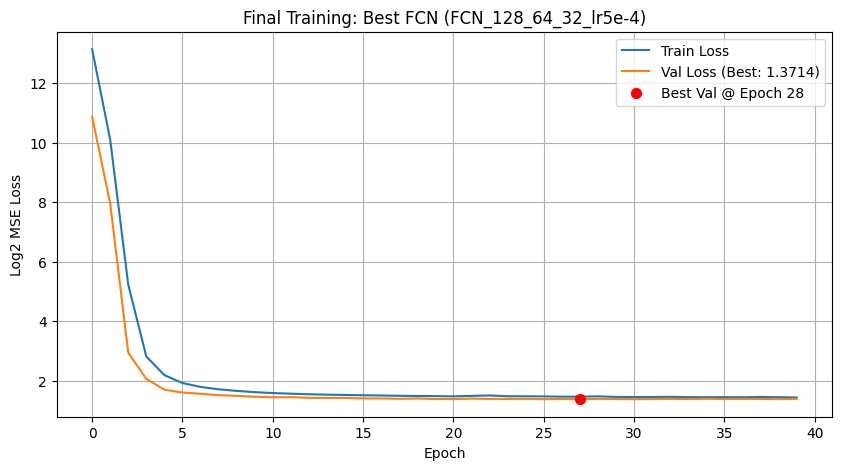


Step A (FCN Pre-training) Complete. Weights are saved in: best_fcn_pretrained_weights.pth


In [8]:
# --- Final Training of the Best FCN Configuration ---
print("Default device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

best_fcn_config = {
    'name': 'FCN_128_64_32_lr5e-4', 
    'hidden_dims': [512, 256, 128],    
    'lr': 0.0005,                  
    'dropout': 0.3,                  
    'weight_decay': 1e-5  # I added L2 regularization as it improves a little bit the generalization of the model when I test with and without it
}

# --- Training Parameters for Final Run ---
epochs = 40 #
model_save_path = 'best_fcn_pretrained_weights.pth' # Filename for saved weights

# --- Prerequisites Check ---
if 'FlexibleDenseNetworkWithParams' not in locals():
    print("ERROR: FlexibleDenseNetworkWithParams class definition not found. Run Cell 1.")
elif 'LogMSELoss' not in locals():
    print("ERROR: LogMSELoss class definition not found.")
elif 'train_epoch_with_params' not in locals() or 'validate_epoch_with_params' not in locals():
     print("ERROR: Training loop epoch functions not found.")
elif 'train_loader' not in locals() or 'val_loader' not in locals():
    print("ERROR: train_loader or val_loader not found.")
else:
    print(f"\n--- Starting Final Training for Selected FCN ---")
    print(f"Using Configuration: {best_fcn_config}")
    print(f"Training for {epochs} epochs.")
    print(f"Best model weights will be saved to: {model_save_path}")

    # --- Instantiate the Best Model ---
    fcn_model = FlexibleDenseNetworkWithParams(
        p_input_size=fcn_padded_p_matrix_flat_size, # Should be defined in previous cell
        param_input_size=fcn_params_size,           # Should be defined in previous cell
        hidden_dims=best_fcn_config['hidden_dims'],
        dropout_prob=best_fcn_config.get('dropout', 0.2) # Use dropout if specified
    ).to(device)

    # --- Criterion and Optimizer ---
    criterion = LogMSELoss()
    optimizer = optim.Adam(fcn_model.parameters(), lr=best_fcn_config['lr'],weight_decay = best_fcn_config['weight_decay'])

    # --- Training Loop (with saving best model) ---
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    start_time = time.time()

    print("Starting final training run...")
    for epoch in range(epochs):
        epoch_start_time = time.time()

        # Perform one epoch of training and validation
        train_loss = train_epoch_with_params(fcn_model, train_loader, criterion, optimizer, device)
        val_loss = validate_epoch_with_params(fcn_model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        epoch_duration = time.time() - epoch_start_time

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_duration:.2f}s")

        # Save the model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save the model's state dictionary
            torch.save(fcn_model.state_dict(), model_save_path)
            print(f"  -> Val loss improved to {best_val_loss:.4f}. Model weights saved to {model_save_path}")

    total_time = time.time() - start_time
    print(f"\nFinal FCN Training Finished.")
    print(f"  Total time: {total_time:.2f} seconds")
    print(f"  Best Validation Loss achieved during training: {best_val_loss:.4f}")
    print(f"  Best model weights saved to: {model_save_path}")

    # --- Optional: Plot Training Curve ---
    if train_losses and val_losses and 'matplotlib' in sys.modules:
        try:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Train Loss')
            plt.plot(val_losses, label=f'Val Loss (Best: {best_val_loss:.4f})')
            # Mark the best validation point
            best_epoch_idx = np.argmin(val_losses)
            plt.scatter([best_epoch_idx], [best_val_loss], color='red', s=50, zorder=5, label=f'Best Val @ Epoch {best_epoch_idx+1}')
            plt.title(f'Final Training: Best FCN ({best_fcn_config.get("name", "Config")})')
            plt.xlabel('Epoch')
            plt.ylabel('Log2 MSE Loss')
            plt.legend()
            plt.grid(True)
            plt.show()
        except Exception as plot_err:
            print(f"\nWarning: Plotting curve failed - {plot_err}")


print("\nStep A (FCN Pre-training) Complete. Weights are saved in:", model_save_path)

by doubling the number of samples, we achieve a loss of 1.37 with a fine tuned FCN 

Now we are trying to see which static normalisation is the best one. 

We can see that thanks to the normalisation, the model is converging faster and we have better loss values.  

with min_max normalization, we have a validation loss of 1.3496 with only 20 epochs and with the standard normalization (mu and standard deviation), we obtain 1.355

FCN + residual block

In [23]:
# ---------- 1. Fully‑connected Residual Net -----------------
class ResidualFCNBlock(nn.Module):
    def __init__(self, dim, dropout=0.0):
        super().__init__()
        self.lin1 = nn.Linear(dim, dim)
        self.lin2 = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h = F.relu(self.lin1(x))
        h = self.dropout(h)
        h = self.lin2(h)
        return F.relu(x + h)

class ResidualFCNWithParams(nn.Module):
    """
    Deep FCN with N residual blocks.  Works with flattened P.
    """
    def __init__(self,
                 k_max=6, nk_max=6,               # padding sizes
                 n_params=3,
                 hidden_dim=512,
                 num_blocks=6,
                 dropout=0.1):
        super().__init__()
        in_dim = k_max * nk_max + n_params

        self.input = nn.Linear(in_dim, hidden_dim)
        self.blocks = nn.Sequential(
            *[ResidualFCNBlock(hidden_dim, dropout) for _ in range(num_blocks)]
        )
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, P, params):
        b = P.size(0)
        x = torch.cat([P.view(b, -1), params.float()], dim=1)
        x = F.relu(self.input(x))
        x = self.blocks(x)
        return self.out(x)

In [ ]:
# Instantiate the ResidualFCN‐based model
model = ResidualFCNWithParams(
            k_max=max_k, nk_max=max_nk,
            hidden_dim=512, num_blocks=8, dropout=0.2).to(device)

# Loss and optimiser
criterion = LogMSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)

# training
train_losses, val_losses = run_training(
        model, train_loader, val_loader,
        criterion, optimizer,
        epochs=30, device=device,
        model_name='ResFCN')

# Plotting
results["ResFCN"] = (train_losses, val_losses)
plot_losses(results)

Results : best accuracy : 1.3437

Transformer

In [22]:
# ---------- 2. Column‑wise Transformer ---------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=16):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() *
                        (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)                       # (1, L, D)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class ColumnTransformerWithParams(nn.Module):
    """
    Treats each column of P as a token, embeds it, runs a Transformer encoder,
    then pools and regresses to the m‑height.
    """
    def __init__(self,
                 k_max=6, nk_max=6,
                 n_params=3,
                 d_model=128,
                 n_heads=8,
                 num_layers=3,
                 dim_ff=256,
                 dropout=0.1):
        super().__init__()
        self.nk_max = nk_max
        self.embed_col = nn.Linear(k_max, d_model)
        self.pos_enc   = PositionalEncoding(d_model, max_len=nk_max)
        encoder_layer  = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer,
                                                 num_layers=num_layers)
        self.param_proj = nn.Linear(n_params, d_model)
        self.regressor  = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )
        self.col_id_emb = nn.Embedding(nk_max, d_model)

    def forward(self, P, params, col_idx):
        # P : (B, k_max, nk_max)  ->  (B, nk_max, k_max)
        col_tokens = P.transpose(1, 2)
        col_tokens = self.embed_col(col_tokens)            # (B, nk_max, D)
        col_tokens += self.col_id_emb(col_idx)
        col_tokens = self.pos_enc(col_tokens)
        h = self.transformer(col_tokens)                   # same shape
        h = h.mean(dim=1)                                  # pool over columns

        h_params = self.param_proj(params.float())         # (B, D)
        h = h + h_params                                   # fuse

        return self.regressor(h)


In [ ]:
# Instantiate the transformer‐based model
model = ColumnTransformerWithParams(
    k_max=max_k,
    nk_max=max_nk,
    n_params=3,      
    d_model=128,
    n_heads=8,
    num_layers=3,
    dim_ff=512,
    dropout=0.1
).to(device)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2
)
# Loss & optimizer
criterion = LogMSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Training
train_losses, val_losses = run_training_embed_data(
    model, train_loader_embed, val_loader_embed,
    criterion, optimizer,
    epochs=50, device=device,
    model_name='Transformer',
    scheduler = scheduler
)
# Record & plot
results["Transformer"] = (train_losses, val_losses)
plot_losses(results)

result Transformers : best avg loss values is 1.54. The training is not stable as other and it needs way more training to get a good result.

ResNet

In [21]:
# ---------- 3. Small 2‑D ResNet on P “image” ---------------
class ConvResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(ch)
        self.bn2 = nn.BatchNorm2d(ch)

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return F.relu(x + h)

class ResNet2DWithParams(nn.Module):
    """
    Interprets padded P as a single‑channel image (k_max×nk_max).
    """
    def __init__(self,
                 k_max=6, nk_max=6,
                 n_params=3,
                 base_ch=32,
                 num_blocks=3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU()
        )
        self.blocks = nn.Sequential(
            *[ConvResBlock(base_ch) for _ in range(num_blocks)]
        )
        flat_dim = base_ch * k_max * nk_max
        self.param_proj = nn.Linear(n_params, 64)
        self.head = nn.Sequential(
            nn.Linear(flat_dim + 64, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, P, params):
        x = P.unsqueeze(1)                  # (B, 1, k_max, nk_max)
        x = self.blocks(self.stem(x))
        x = x.flatten(1)
        p = F.relu(self.param_proj(params.float()))
        x = torch.cat([x, p], dim=1)
        return self.head(x)

In [ ]:
# Instantiate the 2D‑ResNet‑based model
model = ResNet2DWithParams(
    k_max=max_k,
    nk_max=max_nk,
    n_params=3,     # number of extra numerical features
    base_ch=32,     # number of channels in the stem and residual blocks
    num_blocks=3    # number of ConvResBlock’s
).to(device)

# Loss & optimizer
criterion = LogMSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)

# Training
train_losses, val_losses = run_training(
    model, train_loader, val_loader,
    criterion, optimizer,
    epochs=30, device=device,
    model_name='ResNet2D'
)
# Record & plot
results["ResNet2D"] = (train_losses, val_losses)
plot_losses(results)

results : best accuracy : 1.13

In [25]:
# ---------- 4. Fully‑connected Residual Net with batchnormalisation -----------------
class ResidualFCNBlockBN(nn.Module):
    def __init__(self, dim, dropout=0.0):
        super().__init__()
        self.bn1      = nn.BatchNorm1d(dim)
        self.lin1     = nn.Linear(dim, dim)
        self.dropout  = nn.Dropout(dropout)
        self.bn2      = nn.BatchNorm1d(dim)
        self.lin2     = nn.Linear(dim, dim)

    def forward(self, x):
        # BN → ReLU → Linear → Dropout → BN → ReLU → Linear → add → ReLU
        h = self.bn1(x)
        h = F.relu(h)
        h = self.lin1(h)
        h = self.dropout(h)
        h = self.bn2(h)
        h = F.relu(h)
        h = self.lin2(h)
        return F.relu(x + h)


class ResidualFCNWithParamsBN(nn.Module):
    """
    Same as ResidualFCNWithParams, but uses BatchNorm inside each block.
    """
    def __init__(self,
                 k_max=6, nk_max=6,
                 n_params=3,
                 hidden_dim=512,
                 num_blocks=6,
                 dropout=0.1):
        super().__init__()
        in_dim = k_max * nk_max + n_params

        # initial projection
        self.input = nn.Linear(in_dim, hidden_dim)
        # stack of BN‑residual blocks
        self.blocks = nn.Sequential(
            *[ResidualFCNBlockBN(hidden_dim, dropout) for _ in range(num_blocks)]
        )
        # final regressor head
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, P, params):
        # P: (B, k_max, nk_max), params: (B, n_params)
        b = P.size(0)
        # flatten P and concat numeric params
        x = torch.cat([P.view(b, -1), params.float()], dim=1)
        # initial feed‑forward
        x = F.relu(self.input(x))
        # deep residual stack
        x = self.blocks(x)
        # regression output
        return self.out(x)

In [ ]:
# Instantiate the fully‐connected residual‐BN model
model = ResidualFCNWithParamsBN(
    k_max=max_k,
    nk_max=max_nk,
    n_params=3,        # number of extra numerical features
    hidden_dim=512,    # dimension of each FC layer
    num_blocks=6,      # number of ResidualFCNBlockBN’s
    dropout=0.2        # dropout probability inside each block
).to(device)

# Loss & optimizer
criterion = LogMSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)

# Training
train_losses, val_losses = run_training(
    model, train_loader, val_loader,
    criterion, optimizer,
    epochs=40, device=device,
    model_name='ResFCN_BN'
)

# Record & plot
results["ResFCN_BN"] = (train_losses, val_losses)
plot_losses(results)

Results : best loss values : 1.38

In [ ]:
# ---------- 5. Conv Auto encoder class -----------------
class ConvAutoEncoder(nn.Module):
    """
    Symmetric conv AE for 6×6 padded P‑matrices.

    Encoder  : same conv stem + residual blocks the winning ResNet uses
    Decoder  : transposed‑conv mirror that reconstructs P
    latent_dim controls the bottleneck size fed later to a regressor head.
    """
    def __init__(self,
                 k_max=6, nk_max=6,
                 base_ch=32,
                 num_blocks=3,
                 latent_dim=128):
        super().__init__()
        # ---- encoder (reuse weights later) ----
        self.stem = nn.Sequential(
            nn.Conv2d(1, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU()
        )
        self.enc_res = nn.Sequential(*[ConvResBlock(base_ch)
                                       for _ in range(num_blocks)])
        self.enc_flat = nn.Flatten()
        self.latent   = nn.Linear(base_ch * k_max * nk_max, latent_dim)

        # ---- decoder ----
        self.dec_fc   = nn.Linear(latent_dim, base_ch * k_max * nk_max)
        self.dec_res  = nn.Sequential(*[ConvResBlock(base_ch)
                                        for _ in range(num_blocks)])
        self.out      = nn.Conv2d(base_ch, 1, 3, padding=1)

    # -------- helper used later --------
    def encode(self, P):                      # P: (B,1,6,6)
        h = self.stem(P)
        h = self.enc_res(h)
        h = self.enc_flat(h)
        return self.latent(h)                 # (B, latent_dim)

    def forward(self, P):                     # P: (B,1,6,6)
        z = self.encode(P)
        h = self.dec_fc(z).view_as(P.repeat(1, 32, 1, 1))
        h = self.dec_res(h)
        recon = self.out(h)                   # (B,1,6,6)
        return recon


In [ ]:
# 1) Instantiate the auto‑encoder
model = ConvAutoEncoder(
    k_max=max_k,
    nk_max=max_nk,
    base_ch=32,
    num_blocks=3,
    latent_dim=128
).to(device)

# 2) Criterion & optimizer
criterion = LogMSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 3) Training loop
train_losses, val_losses = [], []
best_val_loss = float('inf')
epochs_ae = 30

for epoch in range(1, epochs_ae + 1):
    # ——— Train ———
    model.train()
    train_running = 0.0
    for _, _, p_matrices in train_loader:
        P = p_matrices.unsqueeze(1).to(device)   # (B,1,k_max,nk_max)
        optimizer.zero_grad()
        recon = model(P)
        loss = criterion(recon, P)
        loss.backward()
        optimizer.step()
        train_running += loss.item() * P.size(0)
    train_loss = train_running / len(train_loader.dataset)
    train_losses.append(train_loss)

    # ——— Validate ———
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for _, _, p_matrices in val_loader:
            P = p_matrices.unsqueeze(1).to(device)
            recon = model(P)
            loss = criterion(recon, P)
            val_running += loss.item() * P.size(0)
    val_loss = val_running / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"AE Epoch {epoch}/{epochs_ae}  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

    # ——— Checkpoint best ———
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "conv_autoencoder.pth")
        print(f"  → Best AE model saved (Val Loss {best_val_loss:.4f})")

print("Auto‑encoder training complete. Best validation loss:", best_val_loss)

# 4) Record & plot
results["ConvAutoEncoder"] = (train_losses, val_losses)
plot_losses(results)

Results : best loss values: 1.34

In [ ]:
# 2) Instantiate the auto-encoder
class ResNetRegressorFromAE(nn.Module):
    """
    Loads encoder from a trained ConvAutoEncoder and fine‑tunes
    end‑to‑end for m‑height regression.
    """
    def __init__(self, ae_checkpoint,
                 k_max=6, nk_max=6,
                 n_params=3,
                 latent_dim=128):
        super().__init__()
        # ----- load pretrained encoder -----
        backbone = ConvAutoEncoder(k_max=k_max, nk_max=nk_max,
                                   latent_dim=latent_dim)
        backbone.load_state_dict(torch.load(ae_checkpoint,
                                            map_location="cpu"))
        self.encoder = nn.Sequential(backbone.stem,
                                     backbone.enc_res,
                                     nn.Flatten(),
                                     backbone.latent)      # (B, latent_dim)

        # ----- regression head -----
        self.param_proj = nn.Linear(n_params, latent_dim)
        self.head = nn.Sequential(
            nn.Linear(latent_dim, latent_dim//2),
            nn.ReLU(),
            nn.Linear(latent_dim//2, 1)
        )

    def forward(self, P, params):
        z_img = self.encoder(P.unsqueeze(1))          # (B, latent)
        z_par = self.param_proj(params.float())       # (B, latent)
        return self.head(F.relu(z_img + z_par))


In [ ]:
# --- Instantiate the AE‑based ResNet regressor ---
ae_checkpoint = '/conv_autoencoder.pth'  # set this to wherever you saved your AE weights
model = ResNetRegressorFromAE(
    ae_checkpoint,
    k_max=max_k,
    nk_max=max_nk,
    n_params=3,        # same as in your dataset
    latent_dim=128     # must match the AE's latent_dim
).to(device)

# --- Loss & optimizer ---
criterion = LogMSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# --- Training ---
train_losses, val_losses = run_training(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=30,
    device=device,
    model_name='ResNetFromAE'
)

# --- Record & plot ---
results["ResNetFromAE"] = (train_losses, val_losses)
plot_losses(results)

ResNet showed the best loss values, we are going to fine tune it using optuna framework

In [ ]:
# ---------------- objective -----------------------
def objective(trial: optuna.Trial):
    # ----- search space -----
    base_ch    = trial.suggest_categorical("base_ch", [16, 32, 48, 64])
    n_blocks   = trial.suggest_int("num_blocks", 2, 3, 5, 7)
    dropout    = trial.suggest_float("dropout", 0.0, 0.1, 0.25, 0.3)
    lr         = trial.suggest_loguniform("lr", 1e-4, 5e-3)
    wd         = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    scheduler  = trial.suggest_categorical("scheduler", ["none", "cosine"])

    # ----- model -----
    model = ResNet2DWithParams(
                k_max=max_k, nk_max=max_nk,
                base_ch=base_ch, num_blocks=n_blocks).to(device)

    criterion = LogMSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    if scheduler == "cosine":
        sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=6, T_mult=2)
    else:
        sched = None

    best_val = math.inf
    for epoch in range(epochs):
        train_epoch_with_params(model, train_loader, criterion, optimizer, device)
        val_loss = validate_epoch_with_params(model, val_loader, criterion, device)
        best_val = min(best_val, val_loss)

        if sched: sched.step()

        # report & prune
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # save checkpoint for the best trial only (done outside)
    trial.set_user_attr("state_dict", copy.deepcopy(model.state_dict()))
    return best_val

In [ ]:
# study of the best hyperparameter for ResNet
study = optuna.create_study(direction="minimize",
                                pruner=optuna.pruners.MedianPruner(n_startup_trials=4, n_warmup_steps=5))
study.optimize(objective, n_trials=93, timeout=None)   # adjust n_trials as GPU budget allows

print("Best value :", study.best_value)
print("Best params:", study.best_params)

# save weights
best_state_dict = study.best_trial.user_attrs["state_dict"]
torch.save(best_state_dict, "best_resnet_rawP.pth")
print("Saved best model ➜ best_resnet_rawP.pth")

Best architecture after 93 trials witha value of 1.118 : base_ch = 64, num_blocks = 5, dropout = 0, lr = 3.2e-3, weidght decay = 3.8e-4

Using ResNet inside the MoE architecture:

In [ ]:
# --- MoE with soft gate architecture ---
class GatingNetwork(nn.Module):
    """Outputs softmax weights for each expert based on n and k."""
    def __init__(self, input_dim=2, num_experts=4, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_experts)

    def forward(self, n_k_params):
        x = self.relu(self.fc1(n_k_params))
        gate_outputs = self.fc2(x)
        return F.softmax(gate_outputs, dim=1)


# --- Mixture‐of‐Experts with ResNet2D experts + soft gating ---
class MoE_ResNet_SoftGate(nn.Module):
    """
    Mixture of ResNet2DWithParams experts with a soft gating network.
    """
    def __init__(self,
                 num_experts: int,
                 k_max: int,
                 nk_max: int,
                 n_params: int,
                 base_ch: int,
                 num_blocks: int,
                 gating_hidden_dim: int = 16):
        super().__init__()
        # 1) gating on (n,k) → 2‐d features
        self.gating = GatingNetwork(
            input_dim=2,
            num_experts=num_experts,
            hidden_dim=gating_hidden_dim
        )
        # 2) build N identical ResNet2D experts
        self.experts = nn.ModuleList([
            ResNet2DWithParams(
                k_max=k_max,
                nk_max=nk_max,
                n_params=n_params,
                base_ch=base_ch,
                num_blocks=num_blocks
            )
            for _ in range(num_experts)
        ])

    def forward(self, p_matrix, params):
        """
        p_matrix: (B, k_max, nk_max)
        params:   (B, 3)  where params[:, :2] = normalized (n,k)
        """
        # 1) compute soft‐gating weights
        n_k = params[:, :2]
        gate_w = self.gating(n_k)                 # (B, num_experts)

        # 2) each expert outputs (B,1)
        outs = [expert(p_matrix, params) 
                for expert in self.experts]     # list of (B,1)
        stacked = torch.stack(outs, dim=1)        # (B, num_experts, 1)

        # 3) weight‐sum across experts → (B,1)
        gate_w = gate_w.unsqueeze(-1)             # (B, num_experts, 1)
        final = (gate_w * stacked).sum(dim=1)     # (B,1)
        return final

In [ ]:
# --- Training cell --- 

# 1) configure hyper‐parameters
num_experts     = 6
k_max, nk_max   = max_k, max_nk
n_params        = 3
base_ch, n_blocks = 32, 3
gating_hd       = 16
epochs_moe      = 30
lr_moe          = 3e-4
wd_moe          = 1e-4

# 2) instantiate MoE with ResNet experts
moe_model = MoE_ResNet_SoftGate(
    num_experts=num_experts,
    k_max=k_max,
    nk_max=nk_max,
    n_params=n_params,
    base_ch=base_ch,
    num_blocks=n_blocks,
    gating_hidden_dim=gating_hd
).to(device)

# 3) loss & optimizer
criterion_moe = LogMSELoss()
optimizer_moe = torch.optim.AdamW(
    moe_model.parameters(), lr=lr_moe, weight_decay=wd_moe
)

# 4) train & validate using your helper
moe_train_losses, moe_val_losses = run_training(
    model=moe_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_moe,
    optimizer=optimizer_moe,
    epochs=epochs_moe,
    device=device,
    model_name="MoE_ResNet_SoftGate"
)

# 5) record & plot
results["MoE_ResNet_SoftGate"] = (moe_train_losses, moe_val_losses)
plot_losses(results)

results :best avg loss value: 1.19 and 1.04 in training loss. There is more overfitting in this case, maybe because the softgate is not distrubutting well the task. Therefore, ResNet is still the best model to use with an avg loss value of 1.13

# ---------------------------------------------------------    
Below this line are the code of the PROJECT 1 where we tested 4 different base model with 420,000 total datas and then choose MoE to fine tune it.

We achieve a cost of 1.3 on the validation set and 1.5 on the test set on average.

Here is a list of architecture we are going to test :
- fully dense neural network
- CNN
- RNN using LSTM
- RNN using GRU 

FIrst of all, we are going to generate the dataset using a LP-based algorithm with the libraries PuLP

In [2]:
# --- Class definition LP_based_solution to generate data ---
class LP_based_solution:
    def __init__(self,n : int ,k : int,m : int):
        """ 
        Initializes the LP_based_solution instance
        Generates a generator matrix G  of dimension n,k  with k<n
        with entries uniformly sampled from [-100, 100] (and ensuring no all-zeros columns)
        """
        self.n = n
        self.k = k
        self.m = m
        self.P = self.create_generator_matrix()

    def create_generator_matrix(self):
        """ 
        Create the P matrix, which is a k x (n-k) matrix with entries sampled uniformly from [-100, 100].

        Ensures that no column of P is the all-zero vector.

        return:
            P : (k x (n-k)) numpy array
        """
        P = np.random.uniform(-100, 100, (self.k, self.n - self.k))
        if np.any(np.all(P == 0, axis = 0)):
            for j in range(P.shape[1]):
                while np.allclose(P[:, j], 0):
                    P[:, j] = np.random.uniform(-100, 100, self.k)

        return P # we only need P to form G and train the model, so we don't concatenate with identity matrix
    
    def build_lp_problem(self, G, a, b, X, psi, k, m, s, Y):
        """
        Build and return a PuLP LP problem for a given tuple (a, b, X, psi).

        Args: 
            G   : The full generator matrix [I_k | P].
            a   : An index chosen as the first element in the quasi-sorted order.
            b   : An index chosen to occupy the m-th position.
            X   : A tuple (list) of indices of size m-1.
            psi : A tuple of m signs (s_0, s_1, ..., s_{m-1}).
            k   : The dimension of the code (number of rows in G)
            m   : The height parameter (position of b in the quasi-sorted order)
            s   : A tuple of m signs (s_0, s_1, ..., s_{m-1})
            Y   : A tuple (list) of indices not in {a} U X U {b}

        Returns:
            prob: A PuLP LP problem instance with the defined objective and constraints.
        """

        # --- Define the LP problem using PuLP ---
        X_str = '_'.join(map(str, X))
        psi_str = '_'.join(map(str, psi))
        prob = pulp.LpProblem(f"LP_{a}_{b}_{X_str}_{psi_str}", pulp.LpMaximize)
            

        # Define variable u_0, ..., u_{k-1}
        u_vars = pulp.LpVariable.dicts("u", range(k))

        # Define objective function: maximize sum(s_0 * g_ia * ui) for i in k
        objective = pulp.lpSum(s[0] * G[i, a] * u_vars[i] for i in range(k))
        prob += objective

        # --- Add Constraints ---
        # Constraint 1: sum((s_{tau_inv(j)}*g_ij - s_0*g_ia)*ui) <= 0 for j in X
        # Constraint 2: sum((-s_{tau_inv(j)}*g_ij)*ui) <= -1 for j in X
        # Map X indices to s indices (s_1 to s_{m-1})
        X_sorted = sorted(X)
        s_map_X = {X_sorted[idx]: s[idx+1] for idx in range(m-1)}

        for j in X:
            s_j = s_map_X[j] # Get the s value corresponding to index j in X
            # Constraint 1
            prob += pulp.lpSum((s_j * G[i, j] - s[0] * G[i, a]) * u_vars[i] for i in range(k)) <= 0, f"Constraint1_j{j}"
            # Constraint 2
            prob += pulp.lpSum((s_j * G[i, j]) * u_vars[i] for i in range(k)) <= -1, f"Constraint2_j{j}"

        # Constraint 3: sum(g_ib * ui) = 1
        prob += pulp.lpSum(G[i, b] * u_vars[i] for i in range(k)) == 1, "Constraint3_b"

        # Constraint 4: sum(g_ij * ui) <= 1 for j in Y
        # Constraint 5: sum(-g_ij * ui) <= 1 for j in Y
        for j in Y:
            prob += pulp.lpSum(G[i, j] * u_vars[i] for i in range(k)) <= 1, f"Constraint4_j{j}"
            prob += pulp.lpSum(-G[i, j] * u_vars[i] for i in range(k)) <= 1, f"Constraint5_j{j}"

        return prob

    def calculate_m_height(self, num_cores = 1):
        """
        Compute the m-height of the analog code given the generator matrix G by using linear programming

        """
        # Initialization of parameters
        n, k, m = self.n, self.k, self.m
        P = self.P

        # --- Construct of the full G matrix ---
        identity_k = np.identity(k)
        G = np.hstack([identity_k, P])

        max_objective_found = 1.0
        lp_tasks = []

        indices = list(range(n)) # we create an array of integers from 0 to n-1 : [0, 1, ..., n-1]
        try: 
            for a in indices : # a is an index respresenting a column in G            
                indices_minus_a = [idx for idx in indices if idx != a]
                for b in indices_minus_a: # b is another column index different from a
                    indices_minus_ab = [idx for idx in indices_minus_a if idx != b]

                    # Check if enought elements remain for X
                    if len(indices_minus_ab) < m - 1:
                        continue # cannot form X of size m-1
                    
                    for X_tuple in itertools.combinations(indices_minus_ab, m - 1):
                        # create an array of size m-1 
                        X = list(X_tuple)
                        # ~ not logical and np.isin to exclude every values of X from the set_excluded_ab
                        Y = [idx for idx in indices_minus_ab if idx not in X]

                        for psi in itertools.product([-1, 1], repeat = m):
                            s = list(psi) # s = [s_0, s_1, ..., s_{m-1}]
                            
                            # --- Solve the LP ---
                            prob = self.build_lp_problem(G, a, b, X, psi, k, m, s, Y)
                            status = prob.solve(pulp.PULP_CBC_CMD(msg=0)) # suppress the messages of pulp

                            # --- Check Status and Update Max Objective ---
                            if status == pulp.LpStatusOptimal:
                                current_z = pulp.value(prob.objective)
                                if current_z > max_objective_found:
                                    max_objective_found = current_z
                            elif status == pulp.LpStatusUnbounded:
                                # If any LP is unbounded, the m-height is infinite for this G
                                print(f"Unbounded LP found for G with (n={n},k={k},m={m}), tuple ({a},{b},{X},{psi}). Skipping this G.")
                                return (None, None) # Signal to skip this P matrix
                            elif status == pulp.LpStatusInfeasible:
                                # This doesn't affect the max unless all others are also infeasible.
                                pass 

        except Exception as e:
            print(f"An error occurred during LP solving for (n={n},k={k},m={m}): {e}")
            # if we have an error skip this P matrix
            return (None, None)

        # After checking all tuples
        if max_objective_found < 1: 
             # m-height should be >= 1. If max_objective_found remains at initial 0 or < 1 (e.g. all infeasible)
             # This might indicate an issue or edge case. The definition implies h_m >= h_0 = 1.
             # Let's default to 1 if the max calculated is less than 1, although this needs verification.
             # A safer bet might be to return None and investigate these cases.
             print(f"Warning: Max objective found ({max_objective_found}) < 1 for (n={n},k={k},m={m}). Check calculation/definition. Returning None.")
             return (None, None) # Or consider returning 1.0 if appropriate.

        return (P,max_objective_found) # Return the overall maximum finite objective value found   

In [3]:
# --- def function to store the data generated by the LP class in a .npz file ---
def save_partial_data_npz(P_list, h_list, n, k, m, base_filename="m_height_data"):
    """
    Saves generated P matrices and h_m values to a uniquely named .npz file.
    Includes n, k, m values in the saved file.

    Args:
        P_list (list): List of generated P matrices (NumPy arrays).
        h_list (list): List of corresponding h_m values (floats).
        n (int): n parameter used for generation.
        k (int): k parameter used for generation.
        m (int): m parameter used for generation.
        base_filename (str): Base name for the output file.
    """
    if not P_list or not h_list:
        print("No data generated in this run, nothing to save.")
        return

    # Convert lists to NumPy arrays
    P_array = np.array(P_list)
    h_array = np.array(h_list)

    # Create arrays for parameters (for consistent storage in npz)
    n_array = np.array([n])
    k_array = np.array([k])
    m_array = np.array([m])

    # Generate a unique filename to avoid overwrites
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f"{base_filename}_n{n}_k{k}_m{m}_{timestamp}.npz"

    try:
        # Save the arrays to a compressed .npz file
        np.savez_compressed(
            filename,
            P_matrices=P_array,
            h_values=h_array,
            n_val=n_array, # Save n, k, m
            k_val=k_array,
            m_val=m_array
        )
        print(f"\nPartial dataset saved successfully to {filename}")
        print(f"Saved {len(h_array)} samples from this run.")
        print(f"Shape of P_matrices array: {P_array.shape}")
        print(f"Shape of h_values array: {h_array.shape}")

    except Exception as e:
        print(f"\nError saving data to {filename}: {e}")


In [ ]:
# --- Iterate through parameter combinations and generate data ---

# Define parameter ranges
n_values = [9, 10]
k_values = [4, 5, 6]
# Define how many samples PER (n, k, m) combination
samples_per_combination = 100  # for ~3000 we have 63000 data and for 100 we have 2100 data

total_expected_combinations = 0
parameter_combinations = []

# Pre-calculate valid combinations and total count
print("Calculating valid (n, k, m) combinations...")
for n_val in n_values:
    for k_val in k_values:
        if k_val >= n_val: # Ensure k < n
            continue
        # m ranges from 2 to n-k inclusive
        min_m = 2
        max_m = n_val - k_val
        if max_m >= min_m:
            for m_val in range(min_m, max_m + 1):
                 # Additional check from the paper's definition: m-1 <= n-2 -> m <= n-1
                 # This is usually covered by m <= n-k, but good to be explicit
                 if m_val <= n_val -1 :
                    parameter_combinations.append((n_val, k_val, m_val))
                    total_expected_combinations += 1

print(f"Found {total_expected_combinations} valid combinations to generate data for.")
print(f"Generating {samples_per_combination} samples per combination.")
print("-" * 30)

# --- Main Generation Loop ---
run_counter = 0
for n_val, k_val, m_val in parameter_combinations:
    run_counter += 1
    print(f"\nStarting Run {run_counter}/{total_expected_combinations}: n={n_val}, k={k_val}, m={m_val}")

    # Initialize lists for this specific combination
    dataset_P_current = []
    dataset_h_current = []
    samples_generated_this_run = 0

    start_time_run = time.time()

    while samples_generated_this_run < samples_per_combination:
        # Create a new solver instance for each sample to get a new random P
        try:
            solver_instance = LP_based_solution(n_val, k_val, m_val)
        except Exception as e:
            print(f"\nError initializing LP_based_solution for ({n_val},{k_val},{m_val}): {e}. Skipping combination.")
            # Break this inner while loop and go to the next (n,k,m) combo
            dataset_P_current = [] # Ensure no data is saved for this failed combo
            dataset_h_current = []
            break

        # Calculate m-height for the P matrix in this instance
        try:
            P_matrix, h_m = solver_instance.calculate_m_height()
        except Exception as e:
             print(f"\nUnhandled error in calculate_m_height for ({n_val},{k_val},{m_val}): {e}. Skipping sample.")
             h_m = None # Treat as failure for this sample

        if h_m is not None:
            # Optional: Add sanity check for very large values if needed
            if h_m > 1e7:
                print(f"Warning: Large m-height {h_m} found for ({n_val},{k_val},{m_val}). Skipping sample.")
                continue # Skip this sample

            # Use the P matrix associated with the successful calculation
            dataset_P_current.append(solver_instance.P) # Append the P matrix that yielded h_m
            dataset_h_current.append(h_m)
            samples_generated_this_run += 1
            print(f"Run {run_counter}: Sample {samples_generated_this_run}/{samples_per_combination} -> h_m = {h_m:.4f}   ", end='\r')

        else: # If h_m is None (unbounded, error, obj<1)
            # Skip this matrix and continue to generate a new one
            # print(f"Skipped sample for Run {run_counter} due to invalid h_m. Generating new matrix...", end='\r')
            continue

    end_time_run = time.time()
    duration_run = end_time_run - start_time_run
    print(f"\nFinished Run {run_counter} ({n_val},{k_val},{m_val}). Generated {samples_generated_this_run} samples in {duration_run:.2f} seconds.")

    # --- Save the data collected in this run ---
    if samples_generated_this_run > 0:
        save_partial_data_npz(dataset_P_current, dataset_h_current, n_val, k_val, m_val)
    else:
        print(f"No valid samples generated for Run {run_counter}, skipping save.")
    print("-" * 30)

print("\nAll parameter combinations processed.")

In [4]:
# --- Example usage of the LP solution on the example provided in the instruction pdf ---
G_test = np.array([
    [1, 0, 0.4759809, 0.9938236, 0.819425],
    [0, 1, -0.8960798, -0.7442706, 0.3345122]
])

k_test = G_test.shape[0] # 2
n_test = G_test.shape[1] # 5
m_test = 2

P_test = G_test[:, k_test:]
solver_test = LP_based_solution(n=n_test, k=k_test, m=m_test)
solver_test.P = P_test

P_result, h_m_result = solver_test.calculate_m_height()
if h_m_result is not None:
    print(f"\nCalculated m-height for the specific G: h_{m_test} = {h_m_result:.7f}")
else:
    print("\nCalculation failed for the specific G (unbounded, error, or h_m < 1).")


Calculated m-height for the specific G: h_2 = 1.9242386


we got "Calculated m-height for the specific G: h_2 = 1.9242386"  meaning the LP-based algorithm should work

In [5]:
# --- Example use on a random generated P matrix ---
n_val, k_val, m_val = 9, 4, 2 
solver = LP_based_solution(n_val, k_val, m_val)

dataset_P = []
dataset_h = []
num_samples_needed = 1 

while len(dataset_h) < num_samples_needed:
    P_matrix, h_m = solver.calculate_m_height()

    if h_m is not None: # Check if m-height is finite and calculation succeeded
         # Check if h_m is realistic (e.g., not excessively large if unexpected)
         if h_m > 1e6: # Example threshold for sanity check
             print(f"Warning: Large m-height {h_m} found. May be correct or indicate issue.")

         dataset_P.append(P_matrix)
         dataset_h.append(h_m)
         print(f"Generated sample {len(dataset_h)}/{num_samples_needed} for (n={n_val}, k={k_val}, m={m_val}) -> h_m = {h_m:.4f} with P = {P_matrix}")

    else:
        print("Skipped a P matrix due to infinite m-height or error.")

Generated sample 1/1 for (n=9, k=4, m=2) -> h_m = 223.6242 with P = [[-56.78169812  19.61006987  57.36989704 -58.13407204  10.38663567]
 [ 92.02518455 -46.76778659  90.76362264 -17.30368471 -53.82621988]
 [ 51.14222307 -46.99184709  94.49832538  90.73061774 -54.09476517]
 [ 23.31461216 -35.81438581 -94.35229399  53.80837945  -9.45712277]]


to create one set of P_matrix with n = 9 and k = 4 and its results for m = 2 take around 1m30 in average and 9min for m = 3. We can see why we want to use a deep neural network to resolve this problem instead of LP.

As we see, it is very computational to generate data, that why, I decided to use HPRC to generate those data, the cell below is used for HPRC jupyter notebook.

In [ ]:
# --- LP-based algorithm and storage function data generation for HPRC with different number of sample per combinations---
# --- Class Definition ---
# create_generator_matrix, build_lp_problem, and the parallel calculate_m_height)
class LP_based_solution:
    def __init__(self,n : int ,k : int,m : int):
        """ Initializes... """
        self.n = n
        self.k = k
        self.m = m
        if not (k < n and 2 <= m <= n - k and m <= n - 1):
             raise ValueError(f"Invalid parameters: n={n}, k={k}, m={m}")
        self.P = self.create_generator_matrix()

    def create_generator_matrix(self):
        """ Create the P matrix... """
        if self.n - self.k <= 0:
            raise ValueError(f"n-k must be > 0, got n={self.n}, k={self.k}")
        P = np.random.uniform(-100, 100, (self.k, self.n - self.k))
        # Ensure no all-zero columns if n-k > 0
        if P.shape[1] > 0 and np.any(np.all(P == 0, axis=0)):
            for j in range(P.shape[1]):
                while np.allclose(P[:, j], 0):
                    if self.k <= 0:
                         raise ValueError(f"k must be > 0, got k={self.k}")
                    P[:, j] = np.random.uniform(-100, 100, self.k)
        return P

    def build_lp_problem(self, G, a, b, X, psi, k, m, s, Y):
        """ Build and return a PuLP LP problem... """
        X_str = '_'.join(map(str, X)); psi_str = '_'.join(map(str, psi))
        prob_name = f"LP_{a}_{b}_{X_str}_{psi_str}"; prob = pulp.LpProblem(prob_name, pulp.LpMaximize)
        u_vars = pulp.LpVariable.dicts("u", range(k)); objective = pulp.lpSum(s[0] * G[i, a] * u_vars[i] for i in range(k)); prob += objective
        X_sorted = sorted(X)
        if m-1 < 0: raise ValueError(f"m must be >= 1, got m={m}")
        s_map_X = {X_sorted[idx]: s[idx+1] for idx in range(m-1)}
        for j in X:
            s_j = s_map_X[j]
            prob += pulp.lpSum((s_j * G[i, j] - s[0] * G[i, a]) * u_vars[i] for i in range(k)) <= 0, f"Constraint1_j{j}"
            # Original constraint 2 was sum((-s_j * G[i, j]) * u_vars[i] for i in range(k)) <= -1
            # Let's ensure we use the correct s_j for the second constraint as well
            prob += pulp.lpSum((-s_j * G[i, j]) * u_vars[i] for i in range(k)) <= -1, f"Constraint2_j{j}"
        prob += pulp.lpSum(G[i, b] * u_vars[i] for i in range(k)) == 1, "Constraint3_b"
        for j in Y:
            prob += pulp.lpSum(G[i, j] * u_vars[i] for i in range(k)) <= 1, f"Constraint4_j{j}"
            prob += pulp.lpSum(-G[i, j] * u_vars[i] for i in range(k)) <= 1, f"Constraint5_j{j}"
        return prob

    def calculate_m_height(self, num_cores=1):
        """ Compute m-height using multiprocessing for LP solves """
        n, k, m = self.n, self.k, self.m
        P = self.P
        identity_k = np.identity(k); G = np.hstack([identity_k, P])
        max_objective_found = 1.0; lp_tasks = []
        indices = list(range(n))
        try:
            for a in indices:
                indices_minus_a = [idx for idx in indices if idx != a]
                for b in indices_minus_a:
                    indices_minus_ab = [idx for idx in indices_minus_a if idx != b]
                    if len(indices_minus_ab) < m - 1: continue
                    for X_tuple in itertools.combinations(indices_minus_ab, m - 1):
                        X = list(X_tuple); Y = [idx for idx in indices_minus_ab if idx not in X]
                        for psi in itertools.product([-1, 1], repeat=m):
                            s = list(psi); lp_tasks.append((G, a, b, X, psi, k, m, s, Y))
            if not lp_tasks: return (None, None)
        except Exception as e: print(f"Error generating LP tasks: {e}"); return (None, None)

        results = []
        cores_to_actually_use = max(1, num_cores) # Ensure at least 1 core
        try:
            # print(f"DEBUG: Using {cores_to_actually_use} cores for pool") # Debug print
            with multiprocessing.Pool(processes=cores_to_actually_use) as pool:
                 results = pool.starmap(_solve_single_lp_task, lp_tasks)
        except Exception as pool_e:
             print(f"Multiprocessing error ({pool_e}) with {cores_to_actually_use} cores. Try reducing cores?")
             # Fallback or re-raise depending on desired behavior
             return(None, None) # Or raise pool_e

        found_unbounded = False
        optimal_values = []
        for status, value in results:
            if status == pulp.LpStatusUnbounded:
                found_unbounded = True
                # print(f"DEBUG: Unbounded found") # Debug print
                break
            elif status == pulp.LpStatusOptimal and value is not None:
                optimal_values.append(value)

        if found_unbounded:
            # print(f"DEBUG: Returning None due to unbounded") # Debug print
            return (None, None)

        if not optimal_values: # If no optimal solutions were found (all infeasible/error?)
             # print(f"DEBUG: Returning None due to no optimal values") # Debug print
             max_objective_found = 1.0 # Reset to default, will trigger None below
        else:
             max_objective_found = max(optimal_values) if optimal_values else 1.0

        # Check if max is still 1.0 (or very close) or less than 1.0
        if np.isclose(max_objective_found, 1.0) or max_objective_found < 1.0:
            # print(f"DEBUG: Returning None, max_obj={max_objective_found}") # Debug print
            return (None, None)

        # print(f"DEBUG: Returning P and h_m={max_objective_found}") # Debug print
        return (P, max_objective_found)


# --- Worker function (Top Level) ---
# (Ensure this is defined at the top level for multiprocessing)
def _solve_single_lp_task(G, a, b, X, psi, k, m, s, Y):
    try:
        if k <= 0: return pulp.LpStatusUndefined, None # Avoid error in identity(k)
        # Temporarily create an instance to call the build method
        temp_solver = LP_based_solution(n=G.shape[1], k=k, m=m)
        prob = temp_solver.build_lp_problem(G, a, b, X, psi, k, m, s, Y)

        # Solve the problem
        status = prob.solve(pulp.PULP_CBC_CMD(msg=0))
        value = None
        if status == pulp.LpStatusOptimal:
            value = pulp.value(prob.objective)
        # print(f"DEBUG worker: status={status}, value={value}") # Debug print
        return status, value
    except ValueError as ve: # Catch specific init errors
        # print(f"DEBUG Worker ValueError: {ve}") # Debug print
        return pulp.LpStatusUndefined, None
    except Exception as e:
        # print(f"DEBUG Worker error for {a},{b},{X},{psi}: {e}") # Debug print
        return pulp.LpStatusUndefined, None # Indicate failure


# --- Saving Function ---
def save_partial_data_npz(P_list, h_list, n, k, m, output_dir="data", base_filename="m_height_data"):
    """
    Saves generated P matrices and h_m values to a uniquely named .npz file
    inside the specified output directory.
    Includes n, k, m values in the saved file.
    """
    if not P_list or not h_list:
        print("No data generated in this run, nothing to save.")
        return

    # Create the output directory if it doesn't exist
    try:
        os.makedirs(output_dir, exist_ok=True)
    except OSError as e:
        print(f"\nError creating output directory '{output_dir}': {e}. Cannot save file.")
        return

    # Convert lists to NumPy arrays
    P_array = np.array(P_list)
    h_array = np.array(h_list)
    n_array = np.array([n])
    k_array = np.array([k])
    m_array = np.array([m])

    # Generate a unique filename
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    unique_id = str(uuid.uuid4())[:8]
    filename_base = f"{base_filename}_n{n}_k{k}_m{m}_{timestamp}_{unique_id}.npz"
    full_filepath = os.path.join(output_dir, filename_base)

    try:
        # Save the arrays to the specified path
        np.savez_compressed(
            full_filepath,
            P_matrices=P_array,
            h_values=h_array,
            n_val=n_array,
            k_val=k_array,
            m_val=m_array
        )
        print(f"\nPartial dataset saved successfully to {full_filepath}")
        print(f"Saved {len(h_array)} samples from this run.")

    except Exception as e:
        print(f"\nError saving data to {full_filepath}: {e}")


# --- Main Generation Logic ---

# --- Parameters to Set Manually ---
n_values = [9, 10]
k_values = [4, 5, 6]
# output_directory: Where to save the .npz files
output_directory = "generated_data_notebook_dynamic"
# num_cores_to_request: How many CPU cores to try and use for parallel processing
# Uses multiprocessing.cpu_count() to get available cores by default.
# You can manually set this to a specific number, e.g., num_cores_to_request = 8
num_cores_to_request = multiprocessing.cpu_count()

# --- Dynamic Sample Count Logic ---
def get_target_samples(m_val):
    """Returns the target number of samples based on m."""
    if m_val >= 6:
        return 50   # Smallest target for the slowest combinations (m=6 for n=10,k=4)
    elif m_val == 5:
        return 200  # Moderate target for m=5
    elif m_val == 4:
        return 500  # Higher target for m=4
    else: # m_val == 2 or m_val == 3
        return 1000 # Highest target for the fastest combinations
    # --- ADJUST THESE TARGETS AS NEEDED ---

# --- Pre-calculate combinations ---
total_expected_combinations = 0
parameter_combinations = []
print("Calculating valid (n, k, m) combinations...")
for n_val_loop in n_values:
    for k_val_loop in k_values:
        if k_val_loop >= n_val_loop: continue
        min_m = 2
        max_m = n_val_loop - k_val_loop
        if max_m >= min_m:
            for m_val_loop in range(min_m, max_m + 1):
                 if m_val_loop <= n_val_loop -1 :
                    parameter_combinations.append((n_val_loop, k_val_loop, m_val_loop))
                    total_expected_combinations += 1
print(f"Found {total_expected_combinations} valid combinations.")

# --- Determine Cores to Use ---
available_cores = multiprocessing.cpu_count()
num_cores_to_use = min(num_cores_to_request, available_cores)
if num_cores_to_use <= 0:
    print("Warning: Determined 0 or fewer cores to use. Defaulting to 1 core.")
    num_cores_to_use = 1
print(f"Attempting to use {num_cores_to_use} core(s) for parallel LP solves (Requested: {num_cores_to_request}, Available: {available_cores}).")
print(f"Saving results in: {output_directory}")
print("-" * 30)

# --- Main Loop ---
overall_start_time = time.time()
run_counter = 0
total_samples_generated_all_runs = 0

for n_val, k_val, m_val in parameter_combinations:
    run_counter += 1
    target_samples_this_run = get_target_samples(m_val) # Get dynamic target

    print(f"\nStarting Run {run_counter}/{total_expected_combinations}: n={n_val}, k={k_val}, m={m_val} (Target Samples: {target_samples_this_run})")

    dataset_P_current = []
    dataset_h_current = []
    samples_generated_this_run = 0
    attempts = 0
    # Adjust max attempts based on the *dynamic* target for this run
    max_attempts = int(target_samples_this_run * 1.5) + 20 # Slightly more leeway

    start_time_run = time.time()

    # Loop until the dynamic target is met or max attempts are reached
    while samples_generated_this_run < target_samples_this_run and attempts < max_attempts :
        attempts += 1
        try:
            # Create a new instance for each attempt to get a new P matrix
            solver_instance = LP_based_solution(n_val, k_val, m_val)
            # Pass the determined num_cores_to_use
            P_matrix_result, h_m = solver_instance.calculate_m_height(num_cores=num_cores_to_use)

            if h_m is not None: # Check if calculation was successful and h_m >= 1
                 # Store the P matrix *from the solver instance* that yielded the valid h_m
                 dataset_P_current.append(solver_instance.P)
                 dataset_h_current.append(h_m)
                 samples_generated_this_run += 1
                 # Update progress line using the dynamic target
                 print(f"Run {run_counter}: Sample {samples_generated_this_run}/{target_samples_this_run} -> h_m = {h_m:.4f} (Attempt {attempts})   ", end='\r')
            # else: # h_m is None (unbounded, error, or < 1), just continue to next attempt
            #    pass # No print message for failed attempts to keep output cleaner

        except ValueError as init_err:
            # Error during __init__
            print(f"\nError initializing LP_based_solution for run {run_counter} ({n_val},{k_val},{m_val}): {init_err}. Stopping this combination run.")
            dataset_P_current, dataset_h_current = [], [] # Clear partial data
            break # Exit the inner 'while' loop for this combination
        except Exception as e:
             # Catch other unexpected errors during calculation
             print(f"\nUnhandled error in run {run_counter} (attempt {attempts}) for ({n_val},{k_val},{m_val}): {type(e).__name__} - {e}. Continuing attempts.")
             # time.sleep(0.1) # Optional small pause

    # --- Loop finished for this combination ---
    end_time_run = time.time()
    duration_run = end_time_run - start_time_run
    print(" " * 90, end='\r') # Clear the progress line before printing summary
    print(f"Finished Run {run_counter} ({n_val},{k_val},{m_val}). Generated {samples_generated_this_run} samples in {duration_run:.2f} seconds ({attempts} attempts).")

    if samples_generated_this_run < target_samples_this_run and attempts >= max_attempts:
         print(f"Warning: Reached max attempts ({max_attempts}) but only generated {samples_generated_this_run} / {target_samples_this_run} target samples.")
    elif samples_generated_this_run < target_samples_this_run:
         print(f"Warning: Only generated {samples_generated_this_run} out of {target_samples_this_run} target samples (may indicate initialization or calculation errors).")

    # --- Save data for this run (if any samples were generated) ---
    if samples_generated_this_run > 0:
        # Pass the manually set output directory
        save_partial_data_npz(dataset_P_current, dataset_h_current, n_val, k_val, m_val, output_dir=output_directory)
        total_samples_generated_all_runs += samples_generated_this_run
    else:
        print(f"No valid samples generated for Run {run_counter}, skipping save.")
    print("-" * 30)

overall_end_time = time.time()
print(f"\nAll parameter combinations processed.")
print(f"Total samples generated across all runs: {total_samples_generated_all_runs}")
print(f"Total execution time: {overall_end_time - overall_start_time:.2f} seconds.")


In [ ]:
# --- LP-based algorithm data generation and storage function for HPRC ---
# --- Class Definition ---
class LP_based_solution:
    def __init__(self,n : int ,k : int,m : int):
        """ Initializes... """
        self.n = n
        self.k = k
        self.m = m
        if not (k < n and 2 <= m <= n - k and m <= n - 1):
             raise ValueError(f"Invalid parameters: n={n}, k={k}, m={m}")
        self.P = self.create_generator_matrix()

    def create_generator_matrix(self):
        """ Create the P matrix... """
        if self.n - self.k <= 0:
            raise ValueError(f"n-k must be > 0, got n={self.n}, k={self.k}")
        P = np.random.uniform(-100, 100, (self.k, self.n - self.k))
        if P.shape[1] > 0 and np.any(np.all(P == 0, axis = 0)):
            for j in range(P.shape[1]):
                while np.allclose(P[:, j], 0):
                     if self.k <= 0:
                          raise ValueError(f"k must be > 0, got k={self.k}")
                     P[:, j] = np.random.uniform(-100, 100, self.k)
        return P

    def build_lp_problem(self, G, a, b, X, psi, k, m, s, Y):
        """ Build and return a PuLP LP problem... """
        X_str = '_'.join(map(str, X))
        psi_str = '_'.join(map(str, psi))
        prob_name = f"LP_{a}_{b}_{X_str}_{psi_str}"
        prob = pulp.LpProblem(prob_name, pulp.LpMaximize)
        u_vars = pulp.LpVariable.dicts("u", range(k))
        objective = pulp.lpSum(s[0] * G[i, a] * u_vars[i] for i in range(k))
        prob += objective
        X_sorted = sorted(X)
        if m-1 < 0: raise ValueError(f"m must be >= 1, got m={m}")
        s_map_X = {X_sorted[idx]: s[idx+1] for idx in range(m-1)}
        for j in X:
            s_j = s_map_X[j]
            prob += pulp.lpSum((s_j * G[i, j] - s[0] * G[i, a]) * u_vars[i] for i in range(k)) <= 0, f"Constraint1_j{j}"
            prob += pulp.lpSum((-s_j * G[i, j]) * u_vars[i] for i in range(k)) <= -1, f"Constraint2_j{j}"
        prob += pulp.lpSum(G[i, b] * u_vars[i] for i in range(k)) == 1, "Constraint3_b"
        for j in Y:
            prob += pulp.lpSum(G[i, j] * u_vars[i] for i in range(k)) <= 1, f"Constraint4_j{j}"
            prob += pulp.lpSum(-G[i, j] * u_vars[i] for i in range(k)) <= 1, f"Constraint5_j{j}"
        return prob

    def calculate_m_height(self, num_cores=1):
        """ Compute m-height using multiprocessing for LP solves """
        n, k, m = self.n, self.k, self.m
        P = self.P
        identity_k = np.identity(k)
        G = np.hstack([identity_k, P])
        max_objective_found = 1.0
        lp_tasks = []
        indices = list(range(n))
        try:
            for a in indices:
                indices_minus_a = [idx for idx in indices if idx != a]
                for b in indices_minus_a:
                    indices_minus_ab = [idx for idx in indices_minus_a if idx != b]
                    if len(indices_minus_ab) < m - 1: continue
                    for X_tuple in itertools.combinations(indices_minus_ab, m - 1):
                        X = list(X_tuple)
                        Y = [idx for idx in indices_minus_ab if idx not in X]
                        for psi in itertools.product([-1, 1], repeat=m):
                            s = list(psi)
                            lp_tasks.append((G, a, b, X, psi, k, m, s, Y))
            if not lp_tasks: return (None, None)
        except Exception as e: print(f"Error generating LP tasks: {e}"); return (None, None)
        results = []
        try:
            # Ensure num_cores is positive
            if num_cores <= 0: num_cores = 1
            with multiprocessing.Pool(processes=num_cores) as pool:
                 results = pool.starmap(_solve_single_lp_task, lp_tasks)
        except Exception as pool_e: print(f"Multiprocessing error: {pool_e}"); return(None, None)
        found_unbounded = False
        for status, value in results:
            if status == pulp.LpStatusUnbounded: found_unbounded = True; break
            elif status == pulp.LpStatusOptimal and value is not None:
                if value > max_objective_found: max_objective_found = value
        if found_unbounded: return (None, None)
        if np.isclose(max_objective_found, 1.0) and max_objective_found <= 1.0: return (None, None)
        if max_objective_found < 1.0: return (None, None)
        return (P, max_objective_found)

# --- Worker function (Top Level) ---
def _solve_single_lp_task(G, a, b, X, psi, k, m, s, Y):
    try:
        # Create temporary instance ONLY to call build_lp_problem
        # Ensure __init__ handles potential errors gracefully if k=0 etc.
        if k <= 0: return pulp.LpStatusUndefined, None # Avoid error in identity(k)
        temp_solver = LP_based_solution(n=G.shape[1], k=k, m=m)
        prob = temp_solver.build_lp_problem(G, a, b, X, psi, k, m, s, Y)

        # Solve the problem
        status = prob.solve(pulp.PULP_CBC_CMD(msg=0))
        value = None
        if status == pulp.LpStatusOptimal:
            value = pulp.value(prob.objective)
        # Note: Unbounded status is handled, value remains None
        return status, value
    except Exception as e:
        # print(f"  (Worker error for {a},{b},{X},{psi}: {e})", end='\r') # Can be very verbose
        return pulp.LpStatusUndefined, None # Indicate failure

# --- Saving Function ---
def save_partial_data_npz(P_list, h_list, n, k, m, output_dir="data", base_filename="m_height_data"): # Default output_dir="data"
    """
    Saves generated P matrices and h_m values to a uniquely named .npz file
    inside the specified output directory (defaults to 'data').
    Includes n, k, m values in the saved file.

    Args:
        P_list (list): List of generated P matrices (NumPy arrays).
        h_list (list): List of corresponding h_m values (floats).
        n (int): n parameter used for generation.
        k (int): k parameter used for generation.
        m (int): m parameter used for generation.
        output_dir (str): Directory to save the file in, relative to script execution location. Defaults to 'data'.
        base_filename (str): Base name for the output file.
    """
    if not P_list or not h_list:
        print("No data generated in this run, nothing to save.")
        return

    # Create the output directory if it doesn't exist
    try:
        os.makedirs(output_dir, exist_ok=True) # exist_ok=True prevents error if dir already exists
    except OSError as e:
        print(f"\nError creating output directory '{output_dir}': {e}. Cannot save file.")
        return # Stop if we can't create the directory

    # Convert lists to NumPy arrays
    P_array = np.array(P_list)
    h_array = np.array(h_list)
    n_array = np.array([n])
    k_array = np.array([k])
    m_array = np.array([m])

    # Generate a unique filename
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    unique_id = str(uuid.uuid4())[:8]
    filename_base = f"{base_filename}_n{n}_k{k}_m{m}_{timestamp}_{unique_id}.npz"

    # Construct the full path including the output directory
    full_filepath = os.path.join(output_dir, filename_base)

    try:
        # Save the arrays to the specified path
        np.savez_compressed(
            full_filepath, # Use the full path
            P_matrices=P_array,
            h_values=h_array,
            n_val=n_array,
            k_val=k_array,
            m_val=m_array
        )
        print(f"\nPartial dataset saved successfully to {full_filepath}")
        print(f"Saved {len(h_array)} samples from this run.")
        # print(f"Shape of P_matrices array: {P_array.shape}") # Optional detail
        # print(f"Shape of h_values array: {h_array.shape}") # Optional detail

    except Exception as e:
        print(f"\nError saving data to {full_filepath}: {e}")


# --- Main Generation Logic (Adapted for Notebook) ---

# --- Parameters to Set Manually ---
n_values = [9, 10]
k_values = [4, 5, 6]
samples_per_combination = 100 # ADJUST THIS AS NEEDED - START SMALL (e.g., 10) FOR TESTING
num_cores_to_use = 5      # ADJUST THIS - Use multiprocessing.cpu_count() to see available cores
output_directory = "generated_data_notebook" # Set output folder name

# --- Pre-calculate combinations ---
total_expected_combinations = 0
parameter_combinations = []
print("Calculating valid (n, k, m) combinations...")
for n_val_loop in n_values:
    for k_val_loop in k_values:
        if k_val_loop >= n_val_loop: continue
        min_m = 2
        max_m = n_val_loop - k_val_loop
        if max_m >= min_m:
            for m_val_loop in range(min_m, max_m + 1):
                 if m_val_loop <= n_val_loop -1 :
                    parameter_combinations.append((n_val_loop, k_val_loop, m_val_loop))
                    total_expected_combinations += 1
print(f"Found {total_expected_combinations} valid combinations.")
print(f"Generating {samples_per_combination} samples per combination using up to {num_cores_to_use} cores.")
print(f"Saving results in: {output_directory}")
print("-" * 30)

# --- Ensure cores don't exceed available ---
available_cores = multiprocessing.cpu_count()
if num_cores_to_use > available_cores:
    print(f"Warning: Requested {num_cores_to_use} cores, only {available_cores} available. Using {available_cores}.")
    num_cores_to_use = available_cores
if num_cores_to_use <= 0: num_cores_to_use = 1

# --- Main Loop ---
overall_start_time = time.time()
run_counter = 0
for n_val, k_val, m_val in parameter_combinations:
    run_counter += 1
    print(f"\nStarting Run {run_counter}/{total_expected_combinations}: n={n_val}, k={k_val}, m={m_val}")

    dataset_P_current = []
    dataset_h_current = []
    samples_generated_this_run = 0
    attempts = 0
    max_attempts = int(samples_per_combination * 1.5) + 10

    start_time_run = time.time()

    while samples_generated_this_run < samples_per_combination and attempts < max_attempts :
        attempts += 1
        try:
            solver_instance = LP_based_solution(n_val, k_val, m_val)
            P_matrix, h_m = solver_instance.calculate_m_height(num_cores=num_cores_to_use) # Pass core count

            if h_m is not None:
                 dataset_P_current.append(solver_instance.P)
                 dataset_h_current.append(h_m)
                 samples_generated_this_run += 1
                 print(f"Run {run_counter}: Sample {samples_generated_this_run}/{samples_per_combination} -> h_m = {h_m:.4f} (Attempt {attempts})   ", end='\r')

        except ValueError as init_err:
            print(f"\nError initializing for run {run_counter}: {init_err}. Stopping run.")
            dataset_P_current, dataset_h_current = [], []
            break # Stop this specific (n,k,m) run
        except Exception as e:
             print(f"\nUnhandled error in run {run_counter} (attempt {attempts}): {e}. Continuing attempt.")
             # time.sleep(0.5) # Optional small pause

    # --- Loop finished for this combination ---
    end_time_run = time.time()
    duration_run = end_time_run - start_time_run
    print(f"\nFinished Run {run_counter} ({n_val},{k_val},{m_val}). Generated {samples_generated_this_run} samples in {duration_run:.2f} seconds ({attempts} attempts).")

    if samples_generated_this_run < samples_per_combination:
         print(f"Warning: Only generated {samples_generated_this_run} out of {samples_per_combination} target samples.")

    # --- Save data for this run ---
    if samples_generated_this_run > 0:
        save_partial_data_npz(dataset_P_current, dataset_h_current, n_val, k_val, m_val, output_dir=output_directory)
    else:
        print(f"No valid samples generated for Run {run_counter}, skipping save.")
    print("-" * 30)

overall_end_time = time.time()
print(f"\nAll parameter combinations processed. Total time: {overall_end_time - overall_start_time:.2f} seconds.")


Using 64 CPUs from the HPRC and 2 days of computing, we only generated around 10,000 data points as the computation time increases significantly as m gets bigger.

After generating the data and using the data generated by Keegan Smith shared on campuswire.com, we are going now to train different model and see which performs the best without any fine tuning.


Loading the data

In [69]:
# --- Define the dataset class NpzFolderDatasetWithParams for npz files ---
class NpzFolderDatasetWithParams(Dataset):
    """
    PyTorch Dataset for loading data from multiple .npz files in a folder.
    Assumes each .npz file contains 'P_matrices', 'h_values', 'n_val', 'k_val', 'm_val'.
    Handles padding P_matrices.
    """
    def __init__(self, folder_path, max_k=6, max_nk=6, transform = None):
        """
        Args:
            folder_path (str): Path to the folder containing .npz files.
            max_k (int): The height to pad P matrices to.
            max_nk (int): The width to pad P matrices to.
            transform : apply transformation on the P matrix
        """
        self.folder_path = folder_path
        self.max_k = max_k
        self.max_nk = max_nk
        self.file_paths = glob.glob(os.path.join(folder_path, '*.npz'))
        self.transform = transform 

        if not self.file_paths:
            raise FileNotFoundError(f"No .npz files found in {folder_path}")

        self.all_P_matrices = []
        self.all_h_values = []
        self.all_n = []
        self.all_k = []
        self.all_m = []

        print(f"Loading data from {len(self.file_paths)} files...")
        for file_path in self.file_paths:
            try:
                with np.load(file_path) as data:
                    if 'P_matrices' not in data or 'h_values' not in data or \
                       'n_val' not in data or 'k_val' not in data or 'm_val' not in data:
                         print(f"Warning: Skipping {file_path} - missing required keys.")
                         continue
                    P_matrices = data['P_matrices']; h_values = data['h_values']
                    if len(P_matrices) != len(h_values): continue
                    if P_matrices.ndim < 3: continue

                    self.all_P_matrices.extend(list(P_matrices))
                    self.all_h_values.extend(list(h_values))

                    # Extract n, k, m (handle scalar case)
                    n_val = data['n_val'][0] if data['n_val'].ndim > 0 else data['n_val'].item()
                    k_val = data['k_val'][0] if data['k_val'].ndim > 0 else data['k_val'].item()
                    m_val = data['m_val'][0] if data['m_val'].ndim > 0 else data['m_val'].item()

                    self.all_n.extend([n_val] * len(h_values))
                    self.all_k.extend([k_val] * len(h_values))
                    self.all_m.extend([m_val] * len(h_values))

            except Exception as e:
                print(f"Error loading or processing {file_path}: {e}")

        if not self.all_h_values:
             raise ValueError("No valid data loaded.")

        print(f"Finished loading. Total samples: {len(self.all_h_values)}")

        # Convert to tensors
        self.all_h_values = torch.tensor(self.all_h_values, dtype=torch.float32)
        self.all_n = torch.tensor(self.all_n, dtype=torch.float32)
        self.all_k = torch.tensor(self.all_k, dtype=torch.float32)
        self.all_m = torch.tensor(self.all_m, dtype=torch.float32)

    def __len__(self):
        return len(self.all_h_values)

    def _pad_matrix(self, p_matrix):
        """Pads a single P matrix to the target size (max_k, max_nk)."""
        p_tensor = torch.tensor(p_matrix, dtype=torch.float32)
        k, nk = p_tensor.shape
        pad_k = self.max_k - k
        pad_nk = self.max_nk - nk
        if pad_k < 0 or pad_nk < 0:
             raise ValueError(f"Matrix shape {p_tensor.shape} > target ({self.max_k},{self.max_nk})")
        padding = (0, pad_nk, 0, pad_k) # Pad right, bottom
        padded_p = F.pad(p_tensor, padding, "constant", 0)
        return padded_p

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        p_matrix_np = self.all_P_matrices[idx]
        h_value = self.all_h_values[idx] # Already a tensor

        # Pad the P matrix (convert to tensor inside)
        padded_p = self._pad_matrix(p_matrix_np)

        # Get n, k, m for this sample (already tensors)
        n_val = self.all_n[idx]
        k_val = self.all_k[idx]
        m_val = self.all_m[idx]

        # Stack parameters without normalization
        params = torch.stack([n_val, k_val, m_val]) # Shape: (3,)

        sample = {'params': params, 'h': h_value.unsqueeze(0), 'P': padded_p}

        if self.transform:
            sample['P'] = self.transform(sample['P'])

        # Return params, h and  sample['P'],
        return sample['params'], sample['h'],  sample['P']

Initially, I used .npz files to test different models with the class 'NpzFolderDatasetWithParams'.    

After training the basic model, I switched to a larger dataset from student Keegan Smith (1 million data points), from which I randomly selected 420,000 samples using a Python script called "split_pickle_data" (not included here).

The first class "PklDataloader" is used for testing purposes at the beginning of the project and then I used the class "PickleFolderDatasetWithParams" for the rest of the project as it can loads files from different folder and combine them later.

In [7]:
# --- Define the class "PklDataLoader" to load the data from .pkl files ---
class PklDataLoader:
    """
    Loads pandas DataFrames from .pkl files generated by the splitting script.

    Uses pd.read_pickle for loading, as the files were saved using
    DataFrame.to_pickle().
    """
    def __init__(self, file_path: str):
        """
        Initializes the loader with the path to the .pkl file.

        Args:
            file_path: The full path to the .pkl file.
        """
        if not isinstance(file_path, str) or not file_path:
            raise ValueError("A valid file path (string) must be provided.")
        # You could add more robust path validation here if needed
        # e.g., os.path.exists(file_path) before loading
        self.file_path = file_path
        print(f"PklDataLoader initialized for path: {self.file_path}")

    def load_data(self, reset_index: bool = True) -> pd.DataFrame | None:
        """
        Loads the DataFrame from the specified .pkl file using pandas.

        Args:
            reset_index: If True (default), resets the DataFrame index
                         after loading, discarding the original index.
                         Set to False to keep the original index from the
                         split file.

        Returns:
            A pandas DataFrame if successful, otherwise None if an error occurs.
        """
        print(f"Attempting to load data from: {self.file_path}")
        try:
            # Use pd.read_pickle as files were saved with df.to_pickle
            df = pd.read_pickle(self.file_path)
            print(f"Successfully loaded DataFrame. Shape: {df.shape}, Index sample: {df.index[:5].tolist()}")

            if reset_index:
                print("Resetting index...")
                df.reset_index(drop=True, inplace=True)
                print(f"Index reset. New index sample: {df.index[:5].tolist()}")

            return df

        except FileNotFoundError:
            print(f"Error: File not found at '{self.file_path}'. Cannot load data.")
            return None
        except Exception as e:
            # Catch other potential errors during loading (permissions, corrupt file, etc.)
            print(f"An unexpected error occurred while loading '{self.file_path}': {e}")
            return None


# # Example for one file:
train_file = "split_data/data_n9_k4_m2.pkl"
val_file = "split_data_validation/data_n9_k4_m2.pkl"

# Create loader instances
train_loader_helper = PklDataLoader(train_file)
val_loader_helper = PklDataLoader(val_file)

# Load the data (index will be reset by default)
df_train = train_loader_helper.load_data()
df_val = val_loader_helper.load_data()

# Check if loading was successful before proceeding
if df_train is not None and df_val is not None:
    print("\nLoaded Training Data Head:")
    print(df_train.head())
    print("\nLoaded Validation Data Head:")
    print(df_val.head())

    #--- Now you can implement the 80/20 split logic ---
    from sklearn.model_selection import train_test_split
    
    validation_split_size = 4000 # Target size for the final validation set
    test_fraction = validation_split_size / len(df_val)
    
    df_extra_train, df_final_val = train_test_split(
        df_val, # Start with the loaded 10k validation data
        test_size=test_fraction,
        random_state=42
    )
    
    df_final_train = pd.concat([df_train, df_extra_train], ignore_index=True)
    
    print("-" * 30)
    print(f"Final Training set size: {df_final_train.shape}")
    print(f"Final Validation set size: {df_final_val.shape}")
    
    # Use df_final_train and df_final_val for your PyTorch Datasets/DataLoaders
else:
      print("Error loading one or both data files. Cannot proceed with this combination.")


PklDataLoader initialized for path: split_data/data_n9_k4_m2.pkl
PklDataLoader initialized for path: split_data_validation/data_n9_k4_m2.pkl
Attempting to load data from: split_data/data_n9_k4_m2.pkl
Successfully loaded DataFrame. Shape: (10000, 5), Index sample: [1, 9, 15, 16, 36]
Resetting index...
Index reset. New index sample: [0, 1, 2, 3, 4]
Attempting to load data from: split_data_validation/data_n9_k4_m2.pkl
Successfully loaded DataFrame. Shape: (10000, 5), Index sample: [244083, 244088, 244097, 244112, 244130]
Resetting index...
Index reset. New index sample: [0, 1, 2, 3, 4]

Loaded Training Data Head:
   n  k  m      result                                                  P
0  9  4  2  140.163560  [6.5178894459618135, -6.281201889271188, 99.66...
1  9  4  2  162.300346  [-88.48172895982646, 1.92925363611036, -53.250...
2  9  4  2  217.263508  [-62.70454405366304, 92.07945357330013, 37.450...
3  9  4  2  146.251829  [-89.46558729229577, 59.446747639708974, -6.71...
4  9  4  2  

load the data from split_data and split_data_validation folder

In [9]:
# --- Define the class "PickleFolderDataset" to load the data from pkl files ---
class PickleFolderDataset(Dataset):
    """
    PyTorch Dataset for loading data from a **list of .pkl file paths**.

    Assumes each .pkl file contains a Pandas DataFrame with columns
    'n', 'k', 'm', 'result', 'P'.
    Handles cases where 'P' might be a 2D array OR a flattened 1D array.
    Reshapes 1D 'P' arrays to 2D using 'n' and 'k' before padding.
    Handles padding P_matrices. 
    Returns data as (params, h, P).
    """
    def __init__(self, file_paths, max_k=6, max_nk=6, transform=None): 
        """
        Args:
            file_paths (list[str]): A list of full paths to the .pkl files.
            max_k (int): The height to pad P matrices to.
            max_nk (int): The width to pad P matrices to.
            transform (callable, optional): Optional transform applied ONLY to the P matrix AFTER padding.
        """
        self.file_paths = file_paths # it is a list
        self.max_k = max_k
        self.max_nk = max_nk
        self.transform = transform

        if not self.file_paths:
            raise ValueError("The provided file_paths list is empty.")

        # Store data directly as loaded from pickle (P can be 1D or 2D)
        self.all_P_matrices = [] # Can contain mixed ndim arrays initially
        self.all_h_values = []
        # Store n, k, m as simple Python ints initially for reshaping logic
        self.all_n = []
        self.all_k = []
        self.all_m = []

        print(f"Loading data from {len(self.file_paths)} specified pickle files (expecting DataFrames)...")
        required_columns = ['n', 'k', 'm', 'result', 'P']

        for file_path in self.file_paths: # Iterate through the provided list
            # print(f"  Loading: {os.path.basename(file_path)}") # Keep print concise
            try:
                with open(file_path, 'rb') as f:
                    data_df = pickle.load(f)

                    if not isinstance(data_df, pd.DataFrame):
                        print(f"Warning: Skipping {os.path.basename(file_path)} - Expected a Pandas DataFrame, found {type(data_df)}.")
                        continue
                    if not all(col in data_df.columns for col in required_columns):
                        print(f"Warning: Skipping {os.path.basename(file_path)} - Missing required columns ({required_columns}). Found: {list(data_df.columns)}")
                        continue

                    # Use efficient Pandas column access
                    p_matrices_list = data_df['P'].tolist()
                    h_values_list = data_df['result'].astype(float).tolist()
                    n_vals_list = data_df['n'].astype(int).tolist()
                    k_vals_list = data_df['k'].astype(int).tolist()
                    m_vals_list = data_df['m'].astype(int).tolist()

                    # Optional: Basic validation before extending
                    list_len = len(p_matrices_list)
                    if not (list_len == len(h_values_list) == len(n_vals_list) == len(k_vals_list) == len(m_vals_list)):
                            print(f"Warning: Skipping {os.path.basename(file_path)} due to inconsistent column lengths after tolist().")
                            continue

                    # Extend lists
                    self.all_P_matrices.extend([np.array(p) for p in p_matrices_list]) # Ensure numpy
                    self.all_h_values.extend(h_values_list)
                    self.all_n.extend(n_vals_list) # Keep as int
                    self.all_k.extend(k_vals_list) # Keep as int
                    self.all_m.extend(m_vals_list) # Keep as int

            except FileNotFoundError:
                    print(f"Error: File not found {file_path}. Skipping.")
            except Exception as e:
                print(f"Error loading/processing {file_path}: {type(e).__name__} - {e}. Skipping file.")
                # print(traceback.format_exc()) # Uncomment for more detail

        if not self.all_h_values:
                raise ValueError("No valid data loaded from any pickle files.")

        print(f"Finished initial loading. Total samples found: {len(self.all_h_values)}")

        # --- Convert non-P lists to tensors ---
        self.all_h_values_tensor = torch.tensor(self.all_h_values, dtype=torch.float32)
        self.all_n_tensor = torch.tensor(self.all_n, dtype=torch.float32)
        self.all_k_tensor = torch.tensor(self.all_k, dtype=torch.float32)
        self.all_m_tensor = torch.tensor(self.all_m, dtype=torch.float32)


    def __len__(self):
        return len(self.all_h_values_tensor)

    def _pad_matrix(self, p_matrix_2d):
        if not isinstance(p_matrix_2d, np.ndarray) or p_matrix_2d.ndim != 2:
            raise ValueError(f"Input to _pad_matrix must be a 2D NumPy array, but got type {type(p_matrix_2d)} with shape {getattr(p_matrix_2d, 'shape', 'N/A')}")
        p_tensor = torch.tensor(p_matrix_2d, dtype=torch.float32)
        k_actual, nk_actual = p_tensor.shape
        pad_k = self.max_k - k_actual
        pad_nk = self.max_nk - nk_actual
        if pad_k < 0 or pad_nk < 0:
                raise ValueError(f"Matrix shape ({k_actual},{nk_actual}) exceeds target padding ({self.max_k},{self.max_nk}).")
        padding = (0, pad_nk, 0, pad_k)
        padded_p = F.pad(p_tensor, padding, "constant", 0)
        return padded_p

    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()

        p_matrix_np = self.all_P_matrices[idx]
        h_value = self.all_h_values_tensor[idx]
        n_val = self.all_n[idx] # Get int value
        k_val = self.all_k[idx] # Get int value

        p_matrix_2d = None

        if p_matrix_np.ndim == 1:
            try:
                target_rows = k_val
                target_cols = n_val - k_val
                if target_rows <= 0 or target_cols < 0:
                        raise ValueError(f"Invalid target shape calculated: k={target_rows}, n-k={target_cols} from n={n_val}, k={k_val}")
                expected_shape = (target_rows, target_cols)
                expected_len = target_rows * target_cols

                if p_matrix_np.size == 0 and expected_len == 0:
                    p_matrix_2d = np.empty((target_rows, 0), dtype=p_matrix_np.dtype)
                elif p_matrix_np.size != expected_len:
                    raise ValueError(f"Flattened P length ({p_matrix_np.size}) != k*(n-k) ({expected_len}) for n={n_val}, k={k_val}")
                else:
                    p_matrix_2d = p_matrix_np.reshape(expected_shape)
            except Exception as e:
                print(f"ERROR in __getitem__ (idx={idx}): Failed to reshape P with shape {p_matrix_np.shape} using n={n_val}, k={k_val}. Error: {e}")
                raise RuntimeError(f"Data Error: Failed processing P matrix for sample index {idx}.") from e
        elif p_matrix_np.ndim == 2:
            p_matrix_2d = p_matrix_np
        else:
            raise ValueError(f"ERROR in __getitem__ (idx={idx}): P matrix has unexpected shape {p_matrix_np.shape}.")

        padded_p = self._pad_matrix(p_matrix_2d)
        if self.transform: padded_p = self.transform(padded_p)

        params = torch.stack([self.all_n_tensor[idx], self.all_k_tensor[idx], self.all_m_tensor[idx]])
        h = h_value.unsqueeze(0)
        return params, h, padded_p

# --- Example usage ---
# FOLDER_WITH_PICKLES = './split_data'
# FOLDER_VALIDATION = './split_data_validation'
# MAX_K_PADDED = 6
# MAX_NK_PADDED = 6

# try:
#     # p_transform = transforms.Compose([...]) # Example placeholder
#     p_transform = None # Or set to None if no transform needed

#     train_dataset_df = PickleFolderDataset(FOLDER_WITH_PICKLES, MAX_K_PADDED, MAX_NK_PADDED, transform=p_transform)
#     val_dataset_df = PickleFolderDataset(FOLDER_VALIDATION, MAX_K_PADDED, MAX_NK_PADDED, transform=p_transform) # Use same transform usually
#     print(f"Loaded {len(train_dataset_df)} training samples and {len(val_dataset_df)} validation samples.")

#     # Get a sample to check the output format
#     if len(train_dataset_df) > 0:
#         sample_params, sample_h, sample_p = train_dataset_df[0]
#         print("\nSample output format:")
#         print("  Params shape:", sample_params.shape, "| Params dtype:", sample_params.dtype)
#         print("  h shape:", sample_h.shape, "| h dtype:", sample_h.dtype)
#         print("  P shape:", sample_p.shape, "| P dtype:", sample_p.dtype)

# except Exception as e:
#      print(f"Error creating dataset: {e}")
#      print(traceback.format_exc())

Training model


In [4]:
# --- Define the custom MSE loss function on the log2 scale --- 
class LogMSELoss(nn.Module):
    """
    Calculates the Mean Squared Error on the log2 scale.
    Loss = mean( (log2(y_true) - log2(y_pred))^2 )
    Adds a small epsilon to prevent log2(0).
    """
    def __init__(self, eps=1e-9):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        """
        Args:
            y_pred (torch.Tensor): Predictions from the model.
            y_true (torch.Tensor): Ground truth values.
        """
        # Clamp inputs to be positive to avoid log2(<=0)
        y_pred_safe = torch.clamp(y_pred, min=self.eps)
        y_true_safe = torch.clamp(y_true, min=self.eps) # Clamp true values too for safety

        # Calculate log base 2
        log2_pred = torch.log2(y_pred_safe)
        log2_true = torch.log2(y_true_safe)

        # Calculate the squared difference and mean over the batch
        loss = torch.mean((log2_true - log2_pred) ** 2)
        return loss


In [10]:
# --- Define dense network class --- 
class DenseNetworkWithParams(nn.Module):
    """
    Dense Network accepting padded P matrix (flattened) and n, k, m parameters.
    """
    def __init__(self, p_input_size, param_input_size=3, hidden_size1=128, hidden_size2=64, hidden_size3=32, output_size=1):
        """
        Args:
            p_input_size (int): Flattened size of the padded P matrix (e.g., 36).
            param_input_size (int): Number of parameter inputs (n, k, m -> 3).
            hidden_size1 (int): Neurons in first hidden layer.
            hidden_size2 (int): Neurons in second hidden layer.
            hidden_size3 (int): Neurons in third hidden layer.
            output_size (int): Output neurons (1 for h_m).
        """
        super(DenseNetworkWithParams, self).__init__()
        self.p_input_size = p_input_size
        self.param_input_size = param_input_size
        combined_input_size = p_input_size + param_input_size # Total input size

        self.fc1 = nn.Linear(combined_input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, output_size)
        

    def forward(self, p_matrix, params):
        """
        Args:
            p_matrix (torch.Tensor): Padded P matrix. Shape: (batch, k_pad, nk_pad)
            params (torch.Tensor): Normalized n, k, m values. Shape: (batch, 3)

        Returns:
            torch.Tensor: Predicted h_m value(s). Shape: (batch, 1)
        """
        batch_size = p_matrix.size(0)
        # Flatten P matrix
        p_flat = p_matrix.view(batch_size, -1) # Shape: (batch, p_input_size)

        # Validate shape
        if p_flat.shape[1] != self.p_input_size:
             raise ValueError(f"P matrix flattened size ({p_flat.shape[1]}) != expected ({self.p_input_size})")
        if params.shape[1] != self.param_input_size:
             raise ValueError(f"Params size ({params.shape[1]}) != expected ({self.param_input_size})")

        # Concatenate flattened P and parameters
        combined_input = torch.cat((p_flat, params), dim=1) # Shape: (batch, p_input_size + 3)

        # Pass through layers
        out = self.fc1(combined_input)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

In [6]:
# --- Define CNN class ---

class CNNWithParams(nn.Module):
    """
    CNN accepting padded P matrix and n, k, m parameters.
    """
    def __init__(self, input_channels=1, input_height=6, input_width=6, param_input_size=3, output_size=1):
        """
        Args:
            input_channels (int): Channels for P matrix (1).
            input_height (int): Padded height (max_k).
            input_width (int): Padded width (max_nk).
            param_input_size (int): Number of parameters (n, k, m -> 3).
            output_size (int): Output neurons (1 for h_m).
        """
        super(CNNWithParams, self).__init__()
        self.input_h = input_height
        self.input_w = input_width
        self.param_input_size = param_input_size

        # Convolutional layers (same as before)
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 6x6 -> 3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1) # 3x3 -> 2x2

        # Calculate flattened size after conv layers
        with torch.no_grad(): # Use no_grad for dummy forward pass
            dummy_input = torch.zeros(1, input_channels, input_height, input_width)
            dummy_output = self._forward_conv(dummy_input)
            self.conv_flattened_size = dummy_output.view(1, -1).size(1) # Calculate dynamically

        # Fully Connected Layers - Input size is conv output + params
        combined_fc_input_size = self.conv_flattened_size + param_input_size
        self.fc1 = nn.Linear(combined_fc_input_size, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, output_size)

    def _forward_conv(self, x):
        """ Helper to pass input through conv layers only """
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        return x

    def forward(self, p_matrix, params):
        """
        Args:
            p_matrix (torch.Tensor): Padded P matrix. Shape: (batch, k_pad, nk_pad)
            params (torch.Tensor): Normalized n, k, m values. Shape: (batch, 3)

        Returns:
            torch.Tensor: Predicted h_m value(s). Shape: (batch, 1)
        """
        batch_size = p_matrix.size(0)
        # Validate shapes
        if p_matrix.shape[1] != self.input_h or p_matrix.shape[2] != self.input_w:
            raise ValueError(f"P matrix shape ({p_matrix.shape[1]}x{p_matrix.shape[2]}) != expected ({self.input_h}x{self.input_w})")
        if params.shape[1] != self.param_input_size:
            raise ValueError(f"Params size ({params.shape[1]}) != expected ({self.param_input_size})")

        # Add channel dim for CNN: (batch, H, W) -> (batch, 1, H, W)
        p_unsqueezed = p_matrix.unsqueeze(1)

        # Pass P through convolutional layers
        conv_out = self._forward_conv(p_unsqueezed)

        # Flatten conv output
        conv_flat = conv_out.view(batch_size, -1) # Shape: (batch, conv_flattened_size)

        # Concatenate flattened conv output and parameters
        combined_input = torch.cat((conv_flat, params), dim=1) # Shape: (batch, conv_flat + 3)

        # Pass through fully connected layers
        out = self.fc1(combined_input)
        out = self.relu3(out)
        out = self.fc2(out)
        return out

In [7]:
# --- RNN architecture ---
# --- LSTM Network ---
class LSTMNetworkWithParams(nn.Module):
    """
    RNN Network using LSTM layers, accepting padded P matrix (as sequence)
    and n, k, m parameters.
    """
    def __init__(self, input_feature_size, hidden_size, num_layers, param_input_size=3, output_size=1, dropout_prob=0.2):
        """
        Args:
            input_feature_size (int): Number of features per timestep (padded n-k, e.g., max_nk).
            hidden_size (int): Number of features in the hidden state h.
            num_layers (int): Number of recurrent layers.
            param_input_size (int): Number of parameter inputs (n, k, m -> 3).
            output_size (int): Output neurons (1 for h_m).
            dropout_prob (float): Dropout probability for LSTM layers (if num_layers > 1) and FC layers.
        """
        super(LSTMNetworkWithParams, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.param_input_size = param_input_size

        # LSTM Layer: batch_first=True means input/output tensors are (batch, seq_len, features)
        self.lstm = nn.LSTM(input_feature_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)

        # Fully Connected Layers: Input size is LSTM hidden size + param size
        combined_fc_input_size = hidden_size + param_input_size
        self.fc1 = nn.Linear(combined_fc_input_size, hidden_size // 2) # Example intermediate layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)

    def forward(self, p_matrix, params):
        """
        Args:
            p_matrix (torch.Tensor): Padded P matrix. Shape: (batch, max_k, max_nk)
            params (torch.Tensor): Normalized n, k, m values. Shape: (batch, 3)

        Returns:
            torch.Tensor: Predicted h_m value(s). Shape: (batch, 1)
        """
        batch_size = p_matrix.size(0)
        device = p_matrix.device # Get device from input tensor

        # Initialize hidden state and cell state with zeros
        # Shape: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        # Pass P matrix sequence through LSTM
        # p_matrix is already (batch, seq_len=max_k, features=max_nk) due to batch_first=True
        lstm_out, (hn, cn) = self.lstm(p_matrix, (h0, c0))

        # We only need the hidden state from the last layer of the last timestep
        # hn has shape (num_layers, batch_size, hidden_size)
        last_hidden_state = hn[-1] # Shape: (batch_size, hidden_size)

        # Concatenate the last hidden state with the parameters
        combined_input = torch.cat((last_hidden_state, params), dim=1) # Shape: (batch, hidden_size + 3)

        # Pass through fully connected layers
        out = self.fc1(combined_input)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# --- GRU Network ---
class GRUNetworkWithParams(nn.Module):
    """
    RNN Network using GRU layers, accepting padded P matrix (as sequence)
    and n, k, m parameters.
    """
    def __init__(self, input_feature_size, hidden_size, num_layers, param_input_size=3, output_size=1, dropout_prob=0.2):
        """
        Args:
            input_feature_size (int): Number of features per timestep (padded n-k, e.g., max_nk).
            hidden_size (int): Number of features in the hidden state h.
            num_layers (int): Number of recurrent layers.
            param_input_size (int): Number of parameter inputs (n, k, m -> 3).
            output_size (int): Output neurons (1 for h_m).
            dropout_prob (float): Dropout probability for GRU layers (if num_layers > 1) and FC layers.
        """
        super(GRUNetworkWithParams, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.param_input_size = param_input_size

        # GRU Layer: batch_first=True means input/output tensors are (batch, seq_len, features)
        self.gru = nn.GRU(input_feature_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)

        # Fully Connected Layers: Input size is GRU hidden size + param size
        combined_fc_input_size = hidden_size + param_input_size
        self.fc1 = nn.Linear(combined_fc_input_size, hidden_size // 2) # Example intermediate layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)

    def forward(self, p_matrix, params):
        """
        Args:
            p_matrix (torch.Tensor): Padded P matrix. Shape: (batch, max_k, max_nk)
            params (torch.Tensor): Normalized n, k, m values. Shape: (batch, 3)

        Returns:
            torch.Tensor: Predicted h_m value(s). Shape: (batch, 1)
        """
        batch_size = p_matrix.size(0)
        device = p_matrix.device # Get device from input tensor

        # Initialize hidden state with zeros
        # Shape: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        # Pass P matrix sequence through GRU
        # p_matrix is already (batch, seq_len=max_k, features=max_nk) due to batch_first=True
        gru_out, hn = self.gru(p_matrix, h0)

        # We only need the hidden state from the last layer of the last timestep
        # hn has shape (num_layers, batch_size, hidden_size)
        last_hidden_state = hn[-1] # Shape: (batch_size, hidden_size)

        # Concatenate the last hidden state with the parameters
        combined_input = torch.cat((last_hidden_state, params), dim=1) # Shape: (batch, hidden_size + 3)

        # Pass through fully connected layers
        out = self.fc1(combined_input)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# --- Example Instantiation (Adjust parameters as needed) ---
# INPUT_FEATURES = 6  # Should be max_nk (padded n-k dimension)
# HIDDEN_DIM = 128    # Size of LSTM/GRU hidden state
# NUM_RNN_LAYERS = 2  # Number of stacked LSTM/GRU layers
# PARAMS_DIM = 3      # For n, k, m
# OUTPUT_DIM = 1      # Predicting h_m
# DROPOUT = 0.3

# lstm_model = LSTMNetworkWithParams(INPUT_FEATURES, HIDDEN_DIM, NUM_RNN_LAYERS, PARAMS_DIM, OUTPUT_DIM, DROPOUT)
# gru_model = GRUNetworkWithParams(INPUT_FEATURES, HIDDEN_DIM, NUM_RNN_LAYERS, PARAMS_DIM, OUTPUT_DIM, DROPOUT)

# print("LSTM Model Architecture:")
# print(lstm_model)
# print("\nGRU Model Architecture:")
# print(gru_model)

In [13]:
# --- Define functions for training and testing the model and data pre processing, plotting---
def train_epoch_with_params(model, dataloader, criterion, optimizer, device):
    """Trains the model (accepting params, h, P) for one epoch."""
    model.train()
    running_loss = 0.0
    total_samples = 0

    # Make sure this unpacking order matches the Dataset's __getitem__ return order
    for i, batch_data in enumerate(dataloader):
        # Unpack data correctly based on Dataset return order (params, h, P)
        params, targets, p_matrices = batch_data
        params, targets, p_matrices = params.to(device), targets.to(device), p_matrices.to(device)

        optimizer.zero_grad()

        # Pass data to the model in the order its forward method expects
        # Assuming models expect (p_matrix, params)
        outputs = model(p_matrices, params)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Accumulate loss correctly using the actual batch size
        running_loss += loss.item() * params.size(0)
        total_samples += params.size(0)

        ## --- Batch-level print ---
        # if (i + 1) % 100 == 0:
        #      print(f'  Batch {i+1}/{len(dataloader)}, Loss: {loss.item():.4f}')

    # Calculate average loss for the epoch
    epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
    return epoch_loss

# --- Keep validate_epoch_with_params as is (it doesn't have batch printing) ---
def validate_epoch_with_params(model, dataloader, criterion, device):
    """Evaluates the model (accepting params, h, P) on the validation set."""
    model.eval()
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        # Make sure this unpacking order matches the Dataset's __getitem__ return order
        for batch_data in dataloader:
            # Unpack data correctly (params, h, P)
            params, targets, p_matrices = batch_data
            params, targets, p_matrices = params.to(device), targets.to(device), p_matrices.to(device)

            # Pass data to the model in the order its forward method expects
            # Assuming models expect (p_matrix, params)
            outputs = model(p_matrices, params)

            loss = criterion(outputs, targets)

            running_loss += loss.item() * params.size(0) # Use actual batch size
            total_samples += params.size(0)

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
    return epoch_loss



def load_and_split_data(train_folders, val_folders, max_k, max_nk, batch_size, val_split_ratio=0.2, num_workers=0, pin_memory=True, dataset_class=PickleFolderDataset):
    """
    Loads data from specified folders, combines them, performs a random split,
    and returns training and validation DataLoaders.

    Args:
        train_folders (list[str]): List of paths to folders containing training .pkl files.
        val_folders (list[str]): List of paths to folders containing validation .pkl files.
                                  (Data will be combined before splitting).
        max_k (int): Max height for padding P matrices.
        max_nk (int): Max width for padding P matrices.
        batch_size (int): Batch size for DataLoaders.
        val_split_ratio (float): Proportion of the *combined* data to use for validation (e.g., 0.2 for 20%).
        num_workers (int): Number of worker processes for DataLoader.
        pin_memory (bool): Whether to use pin_memory for DataLoader.
        dataset_class (Dataset): The Dataset class to use (e.g., PickleFolderDataset).

    Returns:
        tuple: (train_loader, val_loader)
    """
    print("--- Preparing Data ---")
    all_files = []
    for folder in train_folders + val_folders: # Combine paths from both lists
         files = glob.glob(os.path.join(folder, '*.pkl'))
         if not files:
              print(f"Warning: No .pkl files found in folder: {folder}")
         all_files.extend(files)

    if not all_files:
        raise FileNotFoundError("No .pkl files found in any of the specified train/validation folders.")

    print(f"Found {len(all_files)} total .pkl files.")

    # Instantiate the dataset with the combined list of files
    # Note: This loads ALL data into memory. May be an issue for extremely large datasets.
    combined_dataset = dataset_class(
        file_paths=all_files,
        max_k=max_k,
        max_nk=max_nk
        # transform can be added here if needed
    )

    total_samples = len(combined_dataset)
    print(f"Total samples loaded from combined files: {total_samples}")

    # Perform random split
    val_size = int(total_samples * val_split_ratio)
    train_size = total_samples - val_size

    if train_size <= 0 or val_size <= 0:
         raise ValueError(f"Calculated train ({train_size}) or validation ({val_size}) size is zero or less. Check data or split ratio.")

    print(f"Splitting data: Training={train_size} ({100*(1-val_split_ratio):.1f}%), Validation={val_size} ({100*val_split_ratio:.1f}%)")
    train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    print("DataLoaders created.")
    print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")
    return train_loader, val_loader


def run_training(model, train_loader, val_loader, criterion, optimizer, epochs, device, model_name="Model"):
    """
    Runs the training and validation loop for a given model.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): The loss function.
        optimizer (Optimizer): The optimizer.
        epochs (int): Number of epochs to train.
        device (torch.device): Device to train on ('cuda' or 'cpu').
        model_name (str): Name of the model for printing logs.

    Returns:
        tuple: (train_losses, val_losses) lists containing loss per epoch.
    """
    print(f"\n--- Starting Training Loop for {model_name} ---")
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    start_time_train = time.time()

    # Ensure train_epoch_with_params and validate_epoch_with_params expect (params, h, P)
    # If they don't, they need to be redefined/updated before this function is called.

    for epoch in range(epochs):
        epoch_start_time = time.time()
        print(f"\nEpoch {epoch+1}/{epochs} ({model_name})")

        # Ensure train/validate functions handle the (params, h, P) order
        train_loss = train_epoch_with_params(model, train_loader, criterion, optimizer, device)
        val_loss = validate_epoch_with_params(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1} Summary ({model_name}): Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Duration: {epoch_duration:.2f}s")

        if val_loss < best_val_loss:
            print(f"  {model_name} Val loss improved ({best_val_loss:.4f} -> {val_loss:.4f}).")
            best_val_loss = val_loss
            # Optional: Save model checkpoint here
            torch.save(model.state_dict(), f'best_{model_name.lower().replace(" ","_")}_final.pth')

    total_time_train = time.time() - start_time_train
    print(f"\n{model_name} Training Finished. Total time: {total_time_train:.2f} seconds")
    return train_losses, val_losses


def plot_losses(results_dict):
    """
    Plots training and validation losses for multiple models.

    Args:
        results_dict (dict): A dictionary where keys are model names and
                             values are tuples of (train_losses, val_losses).
                             Example: {'Dense': ([...], [...]), 'CNN': ([...], [...])}
    """
    num_models = len(results_dict)
    if num_models == 0:
        print("No results to plot.")
        return

    print("\nPlotting losses...")
    # Adjust layout based on number of models
    cols = 2
    rows = (num_models + cols - 1) // cols
    plt.figure(figsize=(6 * cols, 5 * rows))

    i = 1
    for model_name, (train_losses, val_losses) in results_dict.items():
        if not train_losses or not val_losses:
            print(f"Skipping plot for {model_name} due to missing loss data.")
            continue
        plt.subplot(rows, cols, i)
        plt.plot(train_losses, label=f'{model_name} Train Loss')
        plt.plot(val_losses, label=f'{model_name} Val Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Log2 MSE Loss') # Assuming LogMSELoss was used
        plt.legend()
        plt.grid(True)
        i += 1

    plt.tight_layout()
    plt.show()



Using a small dataset (not the final one with 420,000) to train 4 different architecture (fully connected network, CNN, RNN with LSTM and GRU) to see their performance on this small dataset that contains not all combinaisons of (n,k,m) (only 10 000 data). But I think it is enough to get an idea of which model can do the job


--- Loading NPZ Data from: ./data ---
Loading data from 16 files...
Finished loading. Total samples: 9400
Total NPZ samples: 9400, Training: 7520, Validation: 1880
NPZ DataLoaders created.

--- Starting Dense Model Training Loop ---

Epoch 1/25 (Dense Network)
Epoch 1 Summary (Dense): Train Loss: 16.5512, Val Loss: 9.5666
  Dense Val loss improved (inf -> 9.5666).

Epoch 2/25 (Dense Network)
Epoch 2 Summary (Dense): Train Loss: 8.4183, Val Loss: 7.9829
  Dense Val loss improved (9.5666 -> 7.9829).

Epoch 3/25 (Dense Network)
Epoch 3 Summary (Dense): Train Loss: 7.5857, Val Loss: 7.6198
  Dense Val loss improved (7.9829 -> 7.6198).

Epoch 4/25 (Dense Network)
Epoch 4 Summary (Dense): Train Loss: 7.3270, Val Loss: 7.4418
  Dense Val loss improved (7.6198 -> 7.4418).

Epoch 5/25 (Dense Network)
Epoch 5 Summary (Dense): Train Loss: 7.1474, Val Loss: 7.2736
  Dense Val loss improved (7.4418 -> 7.2736).

Epoch 6/25 (Dense Network)
Epoch 6 Summary (Dense): Train Loss: 6.9705, Val Loss: 7.089

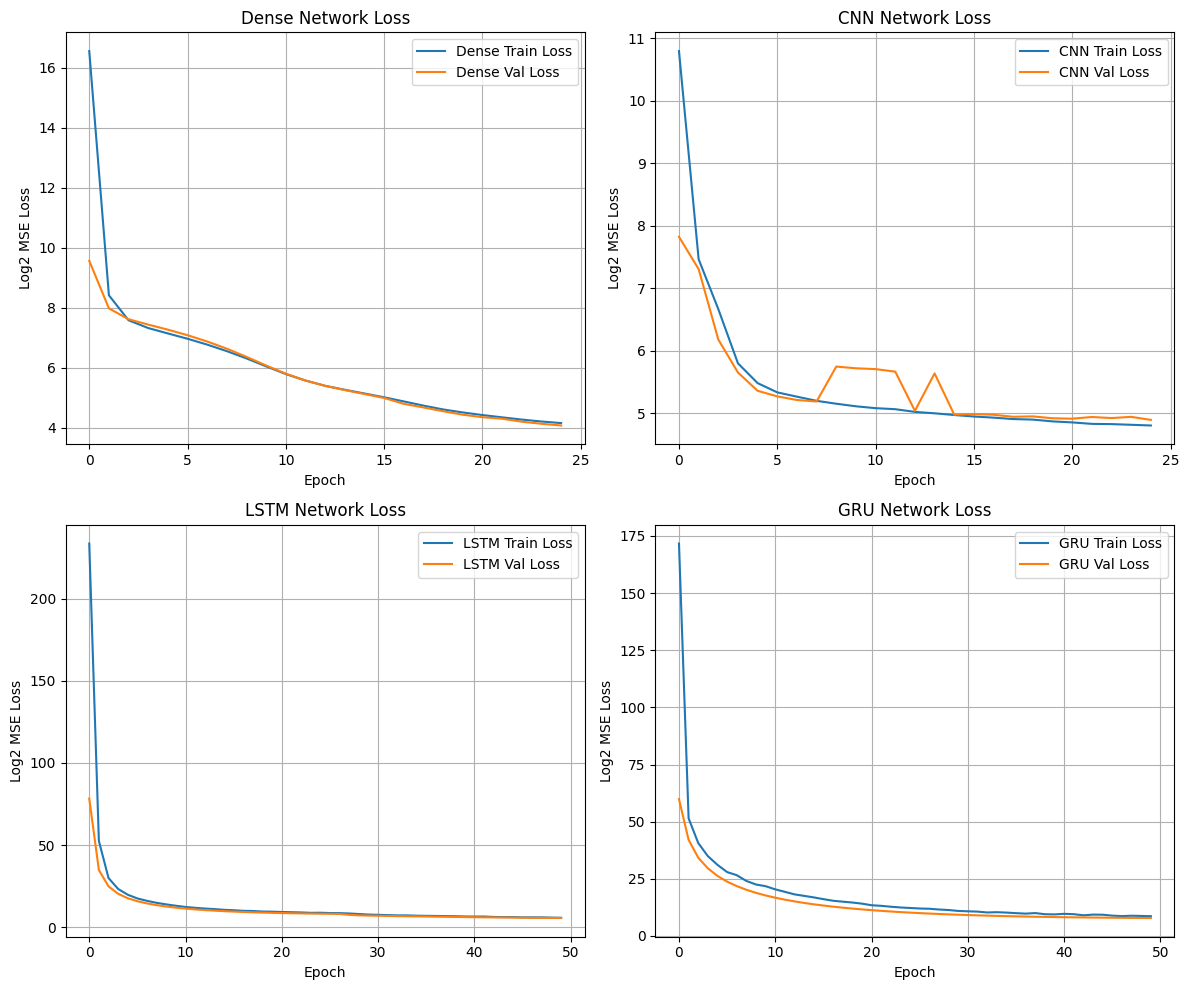

In [76]:
# --- Configuration ---
DATA_FOLDER = './data' 
MAX_K = 6
MAX_NK = 6
PADDED_P_MATRIX_FLAT_SIZE = MAX_K * MAX_NK # 36
PARAMS_SIZE = 3 # n, k, m
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --- Hyperparameters ---
LEARNING_RATE_DENSE = 0.001
LEARNING_RATE_CNN = 0.001
LEARNING_RATE_LSTM = 0.001 # Added for LSTM
LEARNING_RATE_GRU = 0.001  # Added for GRU
BATCH_SIZE = 64
EPOCHS = 25 # You might adjust this per model type later
VALIDATION_SPLIT = 0.2
# --- RNN Hyperparameters ---
RNN_INPUT_FEATURES = MAX_NK  # Features per timestep (padded n-k)
RNN_HIDDEN_DIM = 64       # Size of LSTM/GRU hidden state
RNN_NUM_LAYERS = 2        # Number of stacked LSTM/GRU layers
RNN_DROPOUT = 0.2         # Dropout probability

# --- Initialize lists for results ---
dense_train_losses = []
dense_val_losses = []
cnn_train_losses = []
cnn_val_losses = []
lstm_train_losses = [] # Added for LSTM
lstm_val_losses = []   # Added for LSTM
gru_train_losses = []  # Added for GRU
gru_val_losses = []    # Added for GRU


# --- Load Data ---
try:
    print(f"\n--- Loading NPZ Data from: {DATA_FOLDER} ---")
    # Use the NPZ Dataset class
    full_dataset = NpzFolderDatasetWithParams(folder_path=DATA_FOLDER, max_k=MAX_K, max_nk=MAX_NK)

    # Split data
    total_size = len(full_dataset)
    if total_size == 0:
        raise ValueError("NPZ dataset is empty after loading. Check NPZ files and paths.")

    val_size = int(VALIDATION_SPLIT * total_size)
    train_size = total_size - val_size
    if train_size <= 0 and total_size > 0: # Ensure at least one training sample
        train_size = 1
        val_size = total_size - 1
        print(f"Warning: Small NPZ dataset. Adjusting split to Train: {train_size}, Val: {val_size}")

    print(f"Total NPZ samples: {total_size}, Training: {train_size}, Validation: {val_size}")
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    print("NPZ DataLoaders created.")

    # --- Model, Loss, Optimizer ---

    # --- Dense Network ---
    # print("\n--- Initializing Dense Network with Params ---")
    dense_model_params = DenseNetworkWithParams(
        p_input_size=PADDED_P_MATRIX_FLAT_SIZE,
        param_input_size=PARAMS_SIZE
    ).to(device)
    criterion_dense = LogMSELoss()
    optimizer_dense = optim.Adam(dense_model_params.parameters(), lr=LEARNING_RATE_DENSE)

    # --- CNN Network ---
    # print("\n--- Initializing CNN Network with Params ---")
    cnn_model_params = CNNWithParams(
        input_height=MAX_K,
        input_width=MAX_NK,
        param_input_size=PARAMS_SIZE
    ).to(device)
    criterion_cnn = LogMSELoss()
    optimizer_cnn = optim.Adam(cnn_model_params.parameters(), lr=LEARNING_RATE_CNN)

    # --- LSTM Network ---
    # print("\n--- Initializing LSTM Network with Params ---")
    lstm_model_params = LSTMNetworkWithParams( # Ensure this class is defined in a previous cell
        input_feature_size=RNN_INPUT_FEATURES,
        hidden_size=RNN_HIDDEN_DIM,
        num_layers=RNN_NUM_LAYERS,
        param_input_size=PARAMS_SIZE,
        output_size=1,
        dropout_prob=RNN_DROPOUT
    ).to(device)
    criterion_lstm = LogMSELoss()
    optimizer_lstm = optim.Adam(lstm_model_params.parameters(), lr=LEARNING_RATE_LSTM)

    # --- GRU Network ---
    # print("\n--- Initializing GRU Network with Params ---")
    gru_model_params = GRUNetworkWithParams( # Ensure this class is defined in a previous cell
        input_feature_size=RNN_INPUT_FEATURES,
        hidden_size=RNN_HIDDEN_DIM,
        num_layers=RNN_NUM_LAYERS,
        param_input_size=PARAMS_SIZE,
        output_size=1,
        dropout_prob=RNN_DROPOUT
    ).to(device)
    criterion_gru = LogMSELoss()
    optimizer_gru = optim.Adam(gru_model_params.parameters(), lr=LEARNING_RATE_GRU)


    # --- Training Loop (Dense) ---
    print("\n--- Starting Dense Model Training Loop ---")
    best_val_loss_dense = float('inf')
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS} (Dense Network)")
        train_loss = train_epoch_with_params(dense_model_params, train_loader, criterion_dense, optimizer_dense, device)
        val_loss = validate_epoch_with_params(dense_model_params, val_loader, criterion_dense, device)
        dense_train_losses.append(train_loss)
        dense_val_losses.append(val_loss)
        print(f"Epoch {epoch+1} Summary (Dense): Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss_dense:
            print(f"  Dense Val loss improved ({best_val_loss_dense:.4f} -> {val_loss:.4f}).") # Saving optional
            best_val_loss_dense = val_loss
            # torch.save(dense_model_params.state_dict(), 'best_dense_model_npz.pth')

    # --- Training Loop (CNN) ---
    print("\n--- Starting CNN Model Training Loop ---")
    best_val_loss_cnn = float('inf')
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS} (CNN Network)")
        train_loss = train_epoch_with_params(cnn_model_params, train_loader, criterion_cnn, optimizer_cnn, device)
        val_loss = validate_epoch_with_params(cnn_model_params, val_loader, criterion_cnn, device)
        cnn_train_losses.append(train_loss)
        cnn_val_losses.append(val_loss)
        print(f"Epoch {epoch+1} Summary (CNN): Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss_cnn:
            print(f"  CNN Val loss improved ({best_val_loss_cnn:.4f} -> {val_loss:.4f}).")
            best_val_loss_cnn = val_loss
            # torch.save(cnn_model_params.state_dict(), 'best_cnn_model_npz.pth')


    # --- Training Loop (LSTM) ---
    print("\n--- Starting LSTM Model Training Loop ---")
    best_val_loss_lstm = float('inf')
    for epoch in range(EPOCHS+25):
        print(f"\nEpoch {epoch+1}/{EPOCHS} (LSTM Network)")
        train_loss = train_epoch_with_params(lstm_model_params, train_loader, criterion_lstm, optimizer_lstm, device)
        val_loss = validate_epoch_with_params(lstm_model_params, val_loader, criterion_lstm, device)
        lstm_train_losses.append(train_loss)
        lstm_val_losses.append(val_loss)
        print(f"Epoch {epoch+1} Summary (LSTM): Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss_lstm:
            print(f"  LSTM Val loss improved ({best_val_loss_lstm:.4f} -> {val_loss:.4f}).")
            best_val_loss_lstm = val_loss
            # torch.save(lstm_model_params.state_dict(), 'best_lstm_model_npz.pth')


    # --- Training Loop (GRU) ---
    print("\n--- Starting GRU Model Training Loop ---")
    best_val_loss_gru = float('inf')
    for epoch in range(EPOCHS+25):
        print(f"\nEpoch {epoch+1}/{EPOCHS} (GRU Network)")
        train_loss = train_epoch_with_params(gru_model_params, train_loader, criterion_gru, optimizer_gru, device)
        val_loss = validate_epoch_with_params(gru_model_params, val_loader, criterion_gru, device)
        gru_train_losses.append(train_loss)
        gru_val_losses.append(val_loss)
        print(f"Epoch {epoch+1} Summary (GRU): Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss_gru:
            print(f"  GRU Val loss improved ({best_val_loss_gru:.4f} -> {val_loss:.4f}).")
            best_val_loss_gru = val_loss
            # torch.save(gru_model_params.state_dict(), 'best_gru_model_npz.pth')


# --- Error Handling ---
except FileNotFoundError as e:
    print(f"\nSetup Error: {e}")
    print("Please ensure the DATA_FOLDER path is correct relative to the notebook.")
except ValueError as e:
     print(f"\nSetup Error: {e}")
     print("Check NPZ file contents/structure or if the dataset ended up empty.")
except Exception as e:
    import traceback # Make sure traceback is imported
    print(f"\nAn unexpected setup error occurred: {type(e).__name__} - {e}")
    print("Traceback:")
    print(traceback.format_exc()) # Print traceback for debugging


# --- Print Final Validation Losses ---
print("\n--- Final Validation Losses (Log2 MSE) ---")
if dense_val_losses:
    print(f"Dense Network: {dense_val_losses[-1]:.4f}")
else:
    print("Dense Network: Training did not complete.")

if cnn_val_losses:
    print(f"CNN Network:   {cnn_val_losses[-1]:.4f}")
else:
    print("CNN Network: Training did not complete.")

if lstm_val_losses:
    print(f"LSTM Network:  {lstm_val_losses[-1]:.4f}")
else:
    print("LSTM Network: Training did not complete.")

if gru_val_losses:
    print(f"GRU Network:   {gru_val_losses[-1]:.4f}")
else:
    print("GRU Network: Training did not complete.")


# --- Plotting (Modified for 4 models) ---
# Check if ALL loss lists were populated before plotting
if dense_train_losses and cnn_train_losses and lstm_train_losses and gru_train_losses:
    print("\nPlotting losses for all models...")
    # Use a 2x2 grid for the plots
    plt.figure(figsize=(12, 10)) # Adjusted figure size

    # Dense Plot
    plt.subplot(2, 2, 1) # Row 1, Col 1
    plt.plot(dense_train_losses, label='Dense Train Loss')
    plt.plot(dense_val_losses, label='Dense Val Loss')
    plt.title('Dense Network Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log2 MSE Loss')
    plt.legend()
    plt.grid(True)

    # CNN Plot
    plt.subplot(2, 2, 2) # Row 1, Col 2
    plt.plot(cnn_train_losses, label='CNN Train Loss')
    plt.plot(cnn_val_losses, label='CNN Val Loss')
    plt.title('CNN Network Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log2 MSE Loss')
    plt.legend()
    plt.grid(True)

    # LSTM Plot
    plt.subplot(2, 2, 3) # Row 2, Col 1
    plt.plot(lstm_train_losses, label='LSTM Train Loss')
    plt.plot(lstm_val_losses, label='LSTM Val Loss')
    plt.title('LSTM Network Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log2 MSE Loss')
    plt.legend()
    plt.grid(True)

    # GRU Plot
    plt.subplot(2, 2, 4) # Row 2, Col 2
    plt.plot(gru_train_losses, label='GRU Train Loss')
    plt.plot(gru_val_losses, label='GRU Val Loss')
    plt.title('GRU Network Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log2 MSE Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()
else:
    print("\nSkipping plotting as training did not complete successfully for all models.")

We get the following result for this small dataset:
- Fully connected Network: 4.0821
- CNN Network:   4.8952
- LSTM Network:  5.5501
- GRU Network:   7.8692

we can see that FCN and CNN stands out as the best based model, we are going to test them on the bigger dataset of 420,000 data to see which one is the best.

The cell below shows the result between the ground truth m-height and the output of the CNN

In [26]:
# --- Compare Actual vs Predicted Values for Saved CNN Model --
# --- Configuration ---
PKL_MAX_K = 6
PKL_MAX_NK = 6
PKL_PARAMS_SIZE = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Path to the saved model state dictionary ---
SAVED_CNN_MODEL_PATH = r'C:\Users\theo-\OneDrive\Documents\VS Code project\Deep learning\Project\best_cnn_model_pkl.pth'

print("--- Comparing Actual vs Predicted Values for Saved CNN Model ---")

# --- 1. Instantiate and Load Model ---
try:
    # Ensure required variables exist
    if 'PKL_MAX_K' not in locals() or \
       'PKL_MAX_NK' not in locals() or \
       'PKL_PARAMS_SIZE' not in locals() or \
       'device' not in locals() or \
       'val_pickle_loader' not in locals() or \
       'CNNWithParams' not in locals():
           raise NameError("Required variables (PKL_MAX_K, PKL_MAX_NK, PKL_PARAMS_SIZE, device, val_pickle_loader, CNNWithParams class) not defined. Ensure previous cells are run.")

    # Instantiate the model structure (must match the saved model)
    loaded_cnn_model = CNNWithParams(
        input_height=PKL_MAX_K,
        input_width=PKL_MAX_NK,
        param_input_size=PKL_PARAMS_SIZE
    )

    # Load the saved state dictionary
    if os.path.exists(SAVED_CNN_MODEL_PATH):
        print(f"Loading model state from: {SAVED_CNN_MODEL_PATH}")
        # Load state dict, making sure to map location to the current device
        state_dict = torch.load(SAVED_CNN_MODEL_PATH, map_location=device)
        loaded_cnn_model.load_state_dict(state_dict)
        print("Model state loaded successfully.")
    else:
        raise FileNotFoundError(f"Saved model file not found at: {SAVED_CNN_MODEL_PATH}")

    loaded_cnn_model.to(device) # Ensure model is on the correct device
    loaded_cnn_model.eval() # Set model to evaluation mode

    # --- 2. Get Validation Sample (from pickle loader) ---
    val_samples_p = []
    val_samples_params = []
    val_targets = []
    num_samples_to_get = 50
    samples_collected = 0

    print(f"Collecting up to {num_samples_to_get} validation samples from val_pickle_loader...")
    with torch.no_grad(): # Ensure no gradients are calculated
        for p_matrices, params, targets in val_pickle_loader: # Use the pickle loader
            num_in_batch = p_matrices.size(0)
            samples_needed = num_samples_to_get - samples_collected

            if samples_needed <= 0:
                break

            num_to_take = min(num_in_batch, samples_needed)

            val_samples_p.append(p_matrices[:num_to_take].cpu())
            val_samples_params.append(params[:num_to_take].cpu())
            val_targets.append(targets[:num_to_take].cpu())

            samples_collected += num_to_take
    print(f"Collected {samples_collected} samples.")

    # Concatenate the collected samples
    if samples_collected > 0:
        val_samples_p_tensor = torch.cat(val_samples_p, dim=0)
        val_samples_params_tensor = torch.cat(val_samples_params, dim=0)
        val_targets_tensor = torch.cat(val_targets, dim=0)

        # --- 3. Make Predictions ---
        print("Making predictions on the sample...")
        all_predictions = []
        with torch.no_grad():
            # Move sample tensors to the correct device
            p_matrices_device = val_samples_p_tensor.to(device)
            params_device = val_samples_params_tensor.to(device)

            # Make predictions using the LOADED CNN model
            predictions = loaded_cnn_model(p_matrices_device, params_device)
            all_predictions.append(predictions.cpu())

        # Concatenate predictions
        predictions_tensor = torch.cat(all_predictions, dim=0)

        # --- 4. Convert to NumPy Arrays ---
        actuals_np = val_targets_tensor.numpy().flatten()
        predictions_np = predictions_tensor.numpy().flatten()

        # --- 5. Print Values ---
        print("\nActual vs. Predicted m-height values:")
        print("-" * 40)
        print("Ground Truth   ---   Model Output")
        print("-" * 40)
        for actual, predicted in zip(actuals_np, predictions_np):
            print(f"{actual:<14.4f} ---   {predicted:<14.4f}") # Format for better alignment
        print("-" * 40)

    else:
        print("Could not retrieve any samples from the val_pickle_loader. Skipping comparison.")

except NameError as e:
    print(f"Error: {e}. Make sure all necessary variables and the CNNWithParams class are defined.")
except FileNotFoundError as e:
    print(f"Error: {e}. Could not load the model state.")
except Exception as e:
    import traceback
    print(f"An unexpected error occurred: {e}")
    print(traceback.format_exc())

--- Comparing Actual vs Predicted Values for Saved CNN Model ---
Loading model state from: C:\Users\theo-\OneDrive\Documents\VS Code project\Deep learning\Project\best_cnn_model_pkl.pth
Model state loaded successfully.
Collected 50 samples.
Making predictions on the sample...

Actual vs. Predicted m-height values:
----------------------------------------
Ground Truth   ---   Model Output
----------------------------------------
1.0000         ---   11.1922       
172.5314       ---   144.4963      
535.0997       ---   963.7664      
230.3048       ---   231.0020      
16540.2461     ---   324.9635      
344.1584       ---   977.9683      
2.4707         ---   17.5833       
421.7233       ---   580.8188      
242.2253       ---   108.1127      
484.5706       ---   200.4976      
193.3798       ---   102.2973      
325.6187       ---   313.4016      
1.0000         ---   101.6853      
1.0000         ---   15.0125       
113.5900       ---   14.4356       
1.0000         ---   22.9017

cell below : load all the data into the dataloader "train_loader" and "val_loader"

In [14]:
# --- Data Loading and Preparation ---
# --- Configuration ---
TRAIN_DATA_FOLDERS = ['./split_data']
VALIDATION_DATA_FOLDERS = ['./split_data_validation']
max_k = 6
max_nk = 6
batch_size = 128 
val_split_ratio = 0.2 # 80/20 split
NUM_WORKERS = 0 # Safer default for Windows
PIN_MEMORY = True # Generally good if using GPU

# --- Variables to store loaders (so they are accessible by the next cell) ---
train_loader = None
val_loader = None

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load and Split Data ---
try:
    print("--- Preparing Data ---")
    all_files = []
    for folder in TRAIN_DATA_FOLDERS + VALIDATION_DATA_FOLDERS:
         files = glob.glob(os.path.join(folder, '*.pkl'))
         if not files:
              print(f"Warning: No .pkl files found in folder: {folder}")
         all_files.extend(files)

    if not all_files:
        raise FileNotFoundError("No .pkl files found in any specified train/validation folders.")

    print(f"Found {len(all_files)} total .pkl files.")

    # Instantiate the dataset with the combined list of files
    combined_dataset = PickleFolderDataset(
        file_paths=all_files,
        max_k=max_k,
        max_nk=max_nk,
        p_normaliser = "col_minmax"
    )

    total_samples = len(combined_dataset)
    print(f"Total samples loaded from combined files: {total_samples}")

    # Perform random split
    val_size = int(total_samples * val_split_ratio)
    train_size = total_samples - val_size

    if train_size <= 0 or val_size <= 0:
         raise ValueError(f"Calculated train ({train_size}) or validation ({val_size}) size is zero or less.")

    print(f"Splitting data: Training={train_size} ({100*(1-val_split_ratio):.1f}%), Validation={val_size} ({100*val_split_ratio:.1f}%)")
    train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

    # Create DataLoaders and store them in global scope for this cell block
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    print("\nFinal DataLoaders created successfully.")
    print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

except FileNotFoundError as e:
    print(f"\nData Loading Error: {e}")
    print("Please ensure the TRAIN_DATA_FOLDERS and VALIDATION_DATA_FOLDERS paths are correct.")
except ValueError as e:
     print(f"\nData Loading/Splitting Error: {e}")
     print("Check data contents, split ratio, or if the dataset ended up empty.")
except NameError as e:
     print(f"\nDefinition Error: {e}. Make sure 'PickleFolderDatasetWithParams' class is defined and executed first.")
except ImportError as e:
     print(f"\nImport Error: {e}. Make sure required libraries (torch, pickle, pandas etc.) are imported.")
except Exception as e:
    print(f"\nAn unexpected error occurred during data loading/splitting: {type(e).__name__} - {e}")
    print("Traceback:")
    print(traceback.format_exc())


Using device: cuda
--- Preparing Data ---
Found 42 total .pkl files.
Loading data from 42 specified pickle files (expecting DataFrames)...
Finished initial loading. Total samples found: 420000
Total samples loaded from combined files: 420000
Splitting data: Training=336000 (80.0%), Validation=84000 (20.0%)

Final DataLoaders created successfully.
Training batches: 2625, Validation batches: 657


Normalize train_dataloader_norm and validate_dataloader_norm where P values are normalized

In [10]:
# --- Data Loading and Preparation ---
# --- Configuration ---
TRAIN_DATA_FOLDERS = ['./split_data']
VALIDATION_DATA_FOLDERS = ['./split_data_validation']
max_k = 6
max_nk = 6
batch_size = 512 
val_split_ratio = 0.2 # 80/20 split
NUM_WORKERS = 0 # Safer default for Windows
PIN_MEMORY = True # Generally good if using GPU

# --- Variables to store loaders (so they are accessible by the next cell) ---
train_loader_norm = None
val_loader_norm = None

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Define normalization transform ---
normalize_p = transforms.Normalize(mean=[0], std=[100])  # Maps [-100,100] to [-1,1]

# --- Load and Split Data ---
try:
    print("--- Preparing Data ---")
    all_files = []
    for folder in TRAIN_DATA_FOLDERS + VALIDATION_DATA_FOLDERS:
         files = glob.glob(os.path.join(folder, '*.pkl'))
         if not files:
              print(f"Warning: No .pkl files found in folder: {folder}")
         all_files.extend(files)

    if not all_files:
        raise FileNotFoundError("No .pkl files found in any specified train/validation folders.")

    print(f"Found {len(all_files)} total .pkl files.")

    # Instantiate the dataset with the combined list of files and normalization
    combined_dataset = PickleFolderDataset(
        file_paths=all_files,
        max_k=max_k,
        max_nk=max_nk,
        transform=normalize_p  # Add normalization transform
    )

    total_samples = len(combined_dataset)
    print(f"Total samples loaded from combined files: {total_samples}")

    # Perform random split
    val_size = int(total_samples * val_split_ratio)
    train_size = total_samples - val_size

    if train_size <= 0 or val_size <= 0:
         raise ValueError(f"Calculated train ({train_size}) or validation ({val_size}) size is zero or less.")

    print(f"Splitting data: Training={train_size} ({100*(1-val_split_ratio):.1f}%), Validation={val_size} ({100*val_split_ratio:.1f}%)")
    train_dataset_norm, val_dataset_norm = random_split(combined_dataset, [train_size, val_size])

    # Create DataLoaders and store them in global scope for this cell block
    train_loader_norm = DataLoader(
        train_dataset_norm,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    val_loader_norm = DataLoader(
        val_dataset_norm,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    print("\nFinal DataLoaders created successfully.")
    print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

except FileNotFoundError as e:
    print(f"\nData Loading Error: {e}")
    print("Please ensure the TRAIN_DATA_FOLDERS and VALIDATION_DATA_FOLDERS paths are correct.")
except ValueError as e:
     print(f"\nData Loading/Splitting Error: {e}")
     print("Check data contents, split ratio, or if the dataset ended up empty.")
except NameError as e:
     print(f"\nDefinition Error: {e}. Make sure 'PickleFolderDataset' class is defined and executed first.")
except ImportError as e:
     print(f"\nImport Error: {e}. Make sure required libraries (torch, pickle, pandas etc.) are imported.")
except Exception as e:
    print(f"\nAn unexpected error occurred during data loading/splitting: {type(e).__name__} - {e}")
    print("Traceback:")
    print(traceback.format_exc())


Using device: cuda
--- Preparing Data ---
Found 42 total .pkl files.
Loading data from 42 specified pickle files (expecting DataFrames)...
Finished initial loading. Total samples found: 420000
Total samples loaded from combined files: 420000
Splitting data: Training=336000 (80.0%), Validation=84000 (20.0%)

Final DataLoaders created successfully.
Training batches: 2625, Validation batches: 657


Using device: cuda
--- Preparing Data ---
Found 42 total .pkl files.
Loading data from 42 specified pickle files (expecting DataFrames)...
Finished initial loading. Total samples found: 420000
Total samples loaded from combined files: 420000
Splitting data: Training=336000 (80.0%), Validation=84000 (20.0%)
DataLoaders created.
Training batches: 2625, Validation batches: 657

--- Initializing Dense Network (Final Training) ---

--- Starting Training Loop for Dense (Final Data) ---

Epoch 1/15 (Dense (Final Data))
Epoch 1 Summary (Dense (Final Data)): Train Loss: 16.6144, Val Loss: 10.9389, Duration: 37.02s
  Dense (Final Data) Val loss improved (inf -> 10.9389).

Epoch 2/15 (Dense (Final Data))
Epoch 2 Summary (Dense (Final Data)): Train Loss: 10.6975, Val Loss: 10.4549, Duration: 37.38s
  Dense (Final Data) Val loss improved (10.9389 -> 10.4549).

Epoch 3/15 (Dense (Final Data))
Epoch 3 Summary (Dense (Final Data)): Train Loss: 9.9161, Val Loss: 8.7466, Duration: 37.60s
  Dense (Final 

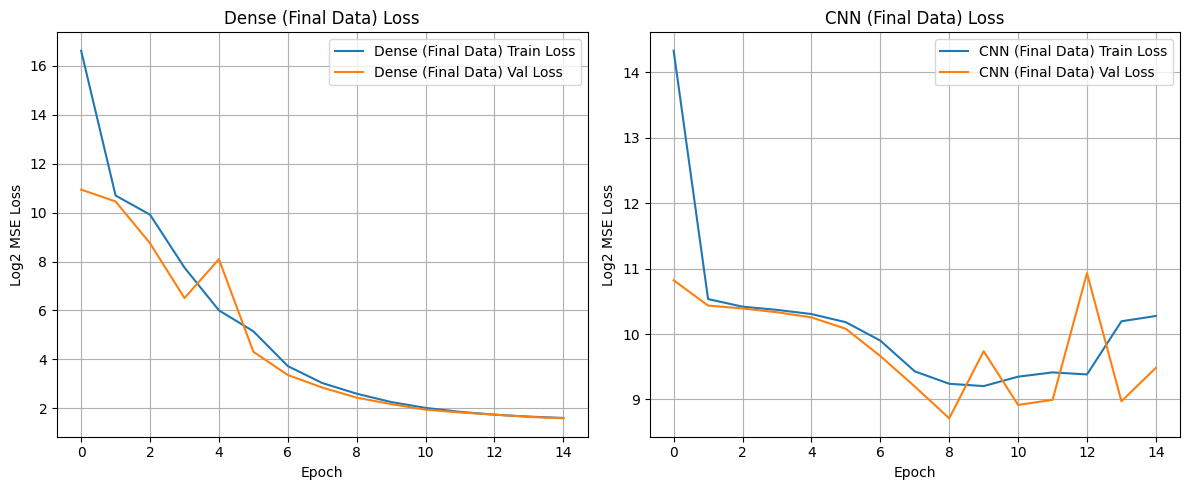

In [54]:
# --- Model Training and Evaluation ---
# --- Check if DataLoaders ---
if 'train_loader' not in locals() or 'val_loader' not in locals() or train_loader is None or val_loader is None:
    print("ERROR: DataLoaders ('train_loader', 'val_loader') not found or not created.")
    print("Please run the 'Data Loading and Preparation' cell successfully first.")
else:
    print("DataLoaders found. Proceeding with training...")

    # --- Training Hyperparameters (can be adjusted here before re-running) ---
    learning_rate_dense = 0.0005
    learning_rate_cnn = 0.0005
    epochs = 25

    # --- Model & Padding Parameters (should match Cell 1) ---
    max_k = 6 # Ensure consistency
    max_nk = 6 # Ensure consistency
    padded_p_matrix_flat_size = max_k * max_nk
    params_size = 3

    # --- Device ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Dictionary to store results for this run ---
    results = {}

    # --- Main Training Execution Block ---
    try:
        # --- Initialize & Train Dense Model ---
        print("\n--- Initializing Dense Network (Training) ---")
        # Create a new instance each time this cell runs
        dense_model = DenseNetworkWithParams(
            p_input_size=padded_p_matrix_flat_size,
            param_input_size=params_size
        ).to(device)
        criterion_dense = LogMSELoss()
        optimizer_dense = optim.Adam(dense_model.parameters(), lr=learning_rate_dense)

        dense_train_losses, dense_val_losses = run_training(
            model=dense_model,
            train_loader=train_loader, 
            val_loader=val_loader,     
            criterion=criterion_dense,
            optimizer=optimizer_dense,
            epochs=epochs,
            device=device,
            model_name="Dense (Data)"
        )
        results["Dense (Data)"] = (dense_train_losses, dense_val_losses)

        # --- Initialize & Train CNN Model ---
        print("\n--- Initializing CNN Network (Training) ---")
         # Create a new instance each time this cell runs
        cnn_model = CNNWithParams(
            input_height=max_k,
            input_width=max_nk,
            param_input_size=params_size
        ).to(device)
        criterion_cnn = LogMSELoss()
        optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=learning_rate_cnn)

        cnn_train_losses, cnn_val_losses = run_training(
            model=cnn_model,
            train_loader=train_loader, 
            val_loader=val_loader,     
            criterion=criterion_cnn,
            optimizer=optimizer_cnn,
            epochs=epochs,
            device=device,
            model_name="CNN (Data)"
        )
        results["CNN (Data)"] = (cnn_train_losses, cnn_val_losses)

        # --- Print Final Validation Losses ---
        print("\n--- Final Validation Losses (Log2 MSE) ---")
        for model_name, (train_loss_hist, val_loss_hist) in results.items():
             if val_loss_hist:
                 print(f"{model_name}: {val_loss_hist[-1]:.4f}")
             else:
                 print(f"{model_name}: Training did not complete or populate losses.")

        # --- Plot Final Losses ---
        plot_losses(results) # Assumes plot_losses function is defined

    except NameError as e:
         print(f"\nDefinition Error: {e}. Make sure models, loss, or helper functions (run_training, plot_losses) are defined and executed.")
    except Exception as e:
        print(f"\nAn unexpected error occurred during training/evaluation: {type(e).__name__} - {e}")
        print("Traceback:")
        print(traceback.format_exc())

we can see that Fully connected network (1.6 costs) performs better than a CNN (9.5 costs). This difference could be explain by :

1. Lack of Meaningful Spatial Hierarchy: CNNs excel when the input data has strong local spatial correlations and a hierarchical structure (pixels forming edges, edges forming shapes, etc.). Convolutional filters are designed to detect these localized patterns. In the P matrix, while generated from a specific process, the relationship determining h_m might not rely on the spatial arrangement of coefficients in the way CNNs expect. The value at P[i, j] doesn't necessarily have a strong predictive relationship with P[i+1, j] or P[i, j+1] that a small filter can effectively capture across all matrices.
2. Global Relationships Matter: The h_m value likely depends on more global properties of the matrix G = [I|P] and the specific linear programming problems derived from it. An FCN, by flattening the P matrix (p_flat = p_matrix.view(batch_size, -1)) and connecting every element to the first hidden layer, immediately considers all elements and their potential interactions simultaneously. It has the capacity to learn complex, non-local relationships between any coefficients in P and the parameters n, k, m.
3. Impact of Padding: CNNs often require padding (like the zero-padding used here) to maintain dimensions. This padding introduces artificial zeros, especially for smaller P matrices, which might disrupt or confuse the local filters operating near the edges. The FCN doesn't inherently suffer from this in the same way, as it just treats the padded zeros as additional input features.
4. Parameter Integration: Both models integrate n, k, m. The FCN combines the flattened P and the parameters before the first hidden layer. The CNN processes P through convolutional layers first and then combines the resulting feature map with the parameters before its fully connected layers. It's possible that the earlier, more direct integration in the FCN is more effective for this problem.

In essence: This problem seems to be more about the overall numerical relationships and the global structure represented by the matrix coefficients and the n, k, m parameters, rather than local spatial patterns. The FCN's architecture is inherently better suited to capturing these global dependencies directly.

we are going to fine tune and find the best architecture for FCN model.

In [17]:
# --- fine tuning FCN ---
# --- configuration ---
fcn_padded_p_matrix_flat_size = max_k * max_nk
fcn_params_size = 3

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for FCN tuning: {device}")

# --- Flexible Dense Network Definition ---
class FlexibleDenseNetworkWithParams(nn.Module):
    """
    Dense Network accepting flattened padded P matrix and n, k, m parameters.
    Hidden layers are defined by a list of dimensions.
    """
    def __init__(self, p_input_size, param_input_size, hidden_dims=[128, 64, 32], output_size=1, dropout_prob=0.2):
        super().__init__()
        self.param_input_size = param_input_size
        combined_input_size = p_input_size + param_input_size

        layers = []
        prev_dim = combined_input_size
        # Input layer check: Ensure first hidden dim connects to combined input
        if not hidden_dims: # Handle case of no hidden layers (direct linear)
             layers.append(nn.Linear(combined_input_size, output_size))
        else:
            # First hidden layer
            layers.append(nn.Linear(combined_input_size, hidden_dims[0]))
            layers.append(nn.ReLU())
            if dropout_prob > 0:
                layers.append(nn.Dropout(dropout_prob))
            prev_dim = hidden_dims[0]

            # Subsequent hidden layers
            for i in range(1, len(hidden_dims)):
                h_dim = hidden_dims[i]
                layers.append(nn.Linear(prev_dim, h_dim))
                layers.append(nn.ReLU())
                if dropout_prob > 0:
                    layers.append(nn.Dropout(dropout_prob))
                prev_dim = h_dim

            # Final output layer connects from the last hidden layer
            layers.append(nn.Linear(prev_dim, output_size))

        self.network = nn.Sequential(*layers)
        print(f"Initialized FlexibleDenseNetworkWithParams:")
        print(f"  Input Size (Flat P + Params): {combined_input_size}")
        print(f"  Hidden Dims: {hidden_dims}")
        print(f"  Output Size: {output_size}")
        # print(self.network) # Optional: print the layer structure

    def forward(self, p_matrix, params):
        batch_size = p_matrix.size(0)
        p_flat = p_matrix.view(batch_size, -1) # Flatten P matrix

        # Ensure params tensor has the correct shape (batch_size, num_params)
        if params.dim() == 1: # If it's a single sample (batch size 1 during inference maybe?)
             params = params.unsqueeze(0)
        if params.size(1) != self.param_input_size:
             raise ValueError(f"Params tensor second dimension ({params.size(1)}) != expected param_input_size ({self.param_input_size})")

        combined_input = torch.cat((p_flat, params), dim=1)
        return self.network(combined_input)

# --- Training Function for One Tuning Trial ---
def run_fcn_tuning_trial(config, train_loader, val_loader, p_input_size, param_input_size, epochs, device):
    """Trains and evaluates one FCN configuration."""
    print(f"\n--- Starting Trial: {config.get('name', config)} ---")
    start_time = time.time()

    # Extract config
    hidden_dims = config['hidden_dims']
    learning_rate = config['lr']
    dropout_prob = config.get('dropout', 0.2) # Use default if not specified
    weight_decay = config.get('weight_decay', 0) # Get weight_decay from config, default to 0

    # Ensure Loss function is defined (should be LogMSELoss)
    if 'LogMSELoss' not in globals():
         raise NameError("LogMSELoss class is not defined.")
    criterion = LogMSELoss()

    # Instantiate model, criterion, optimizer
    model = FlexibleDenseNetworkWithParams(
        p_input_size=p_input_size,
        param_input_size=param_input_size,
        hidden_dims=hidden_dims,
        dropout_prob=dropout_prob
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    # Check if training functions are defined
    if 'train_epoch_with_params' not in globals() or 'validate_epoch_with_params' not in globals():
         raise NameError("train_epoch_with_params or validate_epoch_with_params function is not defined.")

    print(f"  Training for {epochs} epochs...")
    for epoch in range(epochs):
        train_loss = train_epoch_with_params(model, train_loader, criterion, optimizer, device)
        val_loss = validate_epoch_with_params(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"  Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss

    end_time = time.time()
    print(f"--- Trial Finished: {config.get('name', config)} ---")
    print(f"  Best Val Loss during trial: {best_val_loss:.4f}")
    print(f"  Total Time: {end_time - start_time:.2f}s")

    # Return the minimum validation loss achieved during this trial
    return {'config': config, 'best_val_loss': best_val_loss, 'train_losses': train_losses, 'val_losses': val_losses}

print("Setup Complete: Flexible FCN class and tuning trial function are defined.")


Using device for FCN tuning: cuda
Setup Complete: Flexible FCN class and tuning trial function are defined.


In [ ]:
# --- Define and Run FCN Tuning Trials ---

# --- Check Prerequisites ---
if 'train_loader' not in locals() or 'val_loader' not in locals():
    print("ERROR: train_loader or val_loader not found. Ensure the main data loading cell was run.")
elif 'FlexibleDenseNetworkWithParams' not in locals() or 'run_fcn_tuning_trial' not in locals():
    print("ERROR: Flexible FCN class or tuning trial function not defined. Ensure Cell 1 was run.")
elif 'train_epoch_with_params' not in locals() or 'validate_epoch_with_params' not in locals():
    print("ERROR: Required training/validation epoch functions are not defined.")
else:
    print("\nStarting FCN architecture and hyperparameter search...")

    # --- Define Configurations to Test ---
    tuning_configs = [ # 22 combinations
        # --- Baseline [128, 64, 32] Variations ---
        {'name': 'FCN_128_64_32_lr5e-4_dr0.2_wd0',    'hidden_dims': [128, 64, 32], 'lr': 0.0005, 'dropout': 0.2, 'weight_decay': 0},
        {'name': 'FCN_128_64_32_lr1e-3_dr0.2_wd0',    'hidden_dims': [128, 64, 32], 'lr': 0.001,  'dropout': 0.2, 'weight_decay': 0},
        {'name': 'FCN_128_64_32_lr1e-4_dr0.2_wd0',    'hidden_dims': [128, 64, 32], 'lr': 0.0001, 'dropout': 0.2, 'weight_decay': 0},
        {'name': 'FCN_128_64_32_lr5e-4_dr0.1_wd0',    'hidden_dims': [128, 64, 32], 'lr': 0.0005, 'dropout': 0.1, 'weight_decay': 0},
        {'name': 'FCN_128_64_32_lr5e-4_dr0.3_wd0',    'hidden_dims': [128, 64, 32], 'lr': 0.0005, 'dropout': 0.3, 'weight_decay': 0},
        {'name': 'FCN_128_64_32_lr5e-4_dr0.2_wd1e-5', 'hidden_dims': [128, 64, 32], 'lr': 0.0005, 'dropout': 0.2, 'weight_decay': 1e-5},
        {'name': 'FCN_128_64_32_lr5e-4_dr0.2_wd1e-4', 'hidden_dims': [128, 64, 32], 'lr': 0.0005, 'dropout': 0.2, 'weight_decay': 1e-4},

        # --- Deeper Variations ---
        {'name': 'FCN_128_64_32_16_lr5e-4_dr0.2_wd0',    'hidden_dims': [128, 64, 32, 16], 'lr': 0.0005, 'dropout': 0.2, 'weight_decay': 0},
        {'name': 'FCN_128_64_32_16_lr1e-4_dr0.2_wd1e-5', 'hidden_dims': [128, 64, 32, 16], 'lr': 0.0001, 'dropout': 0.2, 'weight_decay': 1e-5},
        {'name': 'FCN_256_128_64_32_lr5e-4_dr0.3_wd1e-5', 'hidden_dims': [256, 128, 64, 32], 'lr': 0.0005, 'dropout': 0.3, 'weight_decay': 1e-5},

        # --- Wider Variations ---
        {'name': 'FCN_256_128_64_lr5e-4_dr0.2_wd0',    'hidden_dims': [256, 128, 64], 'lr': 0.0005, 'dropout': 0.2, 'weight_decay': 0},
        {'name': 'FCN_256_128_64_lr1e-4_dr0.2_wd1e-5', 'hidden_dims': [256, 128, 64], 'lr': 0.0001, 'dropout': 0.2, 'weight_decay': 1e-5},
        {'name': 'FCN_512_256_128_lr5e-4_dr0.3_wd0',    'hidden_dims': [512, 256, 128], 'lr': 0.0005, 'dropout': 0.3, 'weight_decay': 0},
        {'name': 'FCN_512_256_128_lr5e-4_dr0.3_wd1e-5', 'hidden_dims': [512, 256, 128], 'lr': 0.0005, 'dropout': 0.3, 'weight_decay': 1e-5},

        # --- Shallower Variations ---
        {'name': 'FCN_128_64_lr5e-4_dr0.2_wd0',    'hidden_dims': [128, 64], 'lr': 0.0005, 'dropout': 0.2, 'weight_decay': 0},
        {'name': 'FCN_128_64_lr1e-4_dr0.1_wd1e-5', 'hidden_dims': [128, 64], 'lr': 0.0001, 'dropout': 0.1, 'weight_decay': 1e-5},
        {'name': 'FCN_256_128_lr5e-4_dr0.2_wd0',    'hidden_dims': [256, 128], 'lr': 0.0005, 'dropout': 0.2, 'weight_decay': 0},
        {'name': 'FCN_256_128_lr5e-4_dr0.3_wd1e-5', 'hidden_dims': [256, 128], 'lr': 0.0005, 'dropout': 0.3, 'weight_decay': 1e-5},

        # --- More Combinations ---
        {'name': 'FCN_256_128_lr1e-4_dr0.1_wd0',     'hidden_dims': [256, 128], 'lr': 0.0001, 'dropout': 0.1, 'weight_decay': 0},
        {'name': 'FCN_256_128_64_32_lr1e-4_dr0.2_wd0','hidden_dims': [256, 128, 64, 32], 'lr': 0.0001, 'dropout': 0.2, 'weight_decay': 0},
        {'name': 'FCN_128_64_32_16_lr5e-4_dr0.3_wd1e-4','hidden_dims': [128, 64, 32, 16], 'lr': 0.0005, 'dropout': 0.3, 'weight_decay': 1e-4},
        {'name': 'FCN_512_256_lr5e-4_dr0.2_wd1e-5',  'hidden_dims': [512, 256], 'lr': 0.0005, 'dropout': 0.2, 'weight_decay': 1e-5},
    ]
    # --- Number of Epochs for Each Trial ---
    tuning_epochs = 10 # this should be enough to determinate differences

    # --- Run Trials ---
    tuning_results = []
    print(f"Running {len(tuning_configs)} tuning trials, each for {tuning_epochs} epochs.")
    for config in tuning_configs:
        try:
            result = run_fcn_tuning_trial(
                config=config,
                train_loader=train_loader, # Use the main training loader
                val_loader=val_loader,     # Use the main validation loader
                p_input_size=fcn_padded_p_matrix_flat_size, # From previous cell
                param_input_size=fcn_params_size,           # From previous cell
                epochs=tuning_epochs,
                device=device
            )
            tuning_results.append(result)
        except Exception as e:
            print(f"!!! ERROR during trial {config.get('name', config)}: {type(e).__name__} - {e}")
            print(traceback.format_exc())

    # --- Print Summary of Results ---
    print("\n--- FCN Tuning Summary ---")
    if not tuning_results:
         print("No tuning trials completed successfully.")
    else:
        # Sort results by best validation loss (ascending - lower is better)
        tuning_results.sort(key=lambda x: x['best_val_loss'])
        print("Ranked by Best Validation Loss (Lower is Better):")
        for i, result in enumerate(tuning_results):
            print(f"  {i+1}. Config: {result['config'].get('name', result['config'])} | Best Val Loss: {result['best_val_loss']:.4f}")

        best_result = tuning_results[0]
        print(f"\nBEST Configuration Found:")
        print(f"  Config Details: {best_result['config']}")
        print(f"  Best Validation Loss Achieved: {best_result['best_val_loss']:.4f}")

        # --- Plotting ---
        num_trials = len(tuning_results)
        if num_trials > 0:
            try:
                cols = min(3, num_trials) # Max 3 plots per row
                rows = (num_trials + cols - 1) // cols
                fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows), sharex=True, squeeze=False) # Ensure axes is 2D array
                axes = axes.flatten() # Flatten to easily iterate

                fig.suptitle('FCN Tuning - Validation Losses per Epoch', fontsize=16)
                for i, result in enumerate(tuning_results):
                     # Find best epoch index
                     best_epoch_idx = np.argmin(result['val_losses'])
                     best_val_loss_epoch = result['val_losses'][best_epoch_idx]

                     axes[i].plot(result['val_losses'], label=f"Val Loss (Best: {best_val_loss_epoch:.4f} at Ep {best_epoch_idx+1})", marker='.')
                     axes[i].plot(result['train_losses'], label='Train Loss', linestyle='--', alpha=0.7)
                     # Mark the best validation point
                     axes[i].scatter([best_epoch_idx], [best_val_loss_epoch], color='red', s=50, zorder=5, label='Best Val Epoch')
                     axes[i].set_title(result['config'].get('name', str(result['config'])), fontsize=10)
                     axes[i].set_ylabel('Log2 MSE Loss')
                     axes[i].legend(fontsize=8)
                     axes[i].grid(True, linestyle='--', alpha=0.6)

                # Hide any unused subplots if the grid isn't perfectly filled
                for j in range(i + 1, len(axes)):
                    fig.delaxes(axes[j])

                # Common X label
                # Find the subplot in the last row to add xlabel
                last_row_ax_indices = range( (rows-1)*cols, min(num_trials, rows*cols) )
                for idx in last_row_ax_indices:
                    axes[idx].set_xlabel('Epoch')

                plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout
                plt.show()
            except Exception as plot_err:
                 print(f"\nWarning: Plotting failed - {plot_err}")
        elif 'matplotlib' not in sys.modules:
             print("\nMatplotlib not imported. Skipping plots.")


    print("\nTuning Search Complete. Identify the best configuration from the summary above.")


BEST Configuration Found:

  Config Details:  
  {'name': 'FCN_512_256_128_lr5e-4_dr0.3_wd0',    
  'hidden_dims': [512, 256, 128],      
  'lr': 0.0005,  
  'dropout': 0.3,  
  'weight_decay': 0}

  Best Validation Loss Achieved: 1.4056


In [ ]:
# --- Final Training of the Best FCN Configuration ---
# The BEST result printed at the end of the previous cell 
best_fcn_config = {
    'name': 'FCN_128_64_32_lr5e-4', 
    'hidden_dims': [512, 256, 128],    
    'lr': 0.0005,                  
    'dropout': 0.3,                  
    'weight_decay': 1e-5  # I added L2 regularization as it improves a little bit the generalization of the model when I test with and without it
}

# --- Training Parameters for Final Run ---
epochs = 20 #
model_save_path = 'best_fcn_pretrained_weights.pth' # Filename for saved weights

# --- Prerequisites Check ---
if 'FlexibleDenseNetworkWithParams' not in locals():
    print("ERROR: FlexibleDenseNetworkWithParams class definition not found. Run Cell 1.")
elif 'LogMSELoss' not in locals():
    print("ERROR: LogMSELoss class definition not found.")
elif 'train_epoch_with_params' not in locals() or 'validate_epoch_with_params' not in locals():
     print("ERROR: Training loop epoch functions not found.")
elif 'train_loader' not in locals() or 'val_loader' not in locals():
    print("ERROR: train_loader or val_loader not found.")
else:
    print(f"\n--- Starting Final Training for Selected FCN ---")
    print(f"Using Configuration: {best_fcn_config}")
    print(f"Training for {epochs} epochs.")
    print(f"Best model weights will be saved to: {model_save_path}")

    # --- Instantiate the Best Model ---
    fcn_model = FlexibleDenseNetworkWithParams(
        p_input_size=fcn_padded_p_matrix_flat_size, # Should be defined in previous cell
        param_input_size=fcn_params_size,           # Should be defined in previous cell
        hidden_dims=best_fcn_config['hidden_dims'],
        dropout_prob=best_fcn_config.get('dropout', 0.2) # Use dropout if specified
    ).to(device)

    # --- Criterion and Optimizer ---
    criterion = LogMSELoss()
    optimizer = optim.Adam(fcn_model.parameters(), lr=best_fcn_config['lr'],weight_decay = best_fcn_config['weight_decay'])

    # --- Training Loop (with saving best model) ---
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    start_time = time.time()

    print("Starting final training run...")
    for epoch in range(epochs):
        epoch_start_time = time.time()

        # Perform one epoch of training and validation
        train_loss = train_epoch_with_params(fcn_model, train_loader, criterion, optimizer, device)
        val_loss = validate_epoch_with_params(fcn_model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        epoch_duration = time.time() - epoch_start_time

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_duration:.2f}s")

        # Save the model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save the model's state dictionary
            torch.save(fcn_model.state_dict(), model_save_path)
            print(f"  -> Val loss improved to {best_val_loss:.4f}. Model weights saved to {model_save_path}")

    total_time = time.time() - start_time
    print(f"\nFinal FCN Training Finished.")
    print(f"  Total time: {total_time:.2f} seconds")
    print(f"  Best Validation Loss achieved during training: {best_val_loss:.4f}")
    print(f"  Best model weights saved to: {model_save_path}")

    # --- Optional: Plot Training Curve ---
    if train_losses and val_losses and 'matplotlib' in sys.modules:
        try:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Train Loss')
            plt.plot(val_losses, label=f'Val Loss (Best: {best_val_loss:.4f})')
            # Mark the best validation point
            best_epoch_idx = np.argmin(val_losses)
            plt.scatter([best_epoch_idx], [best_val_loss], color='red', s=50, zorder=5, label=f'Best Val @ Epoch {best_epoch_idx+1}')
            plt.title(f'Final Training: Best FCN ({best_fcn_config.get("name", "Config")})')
            plt.xlabel('Epoch')
            plt.ylabel('Log2 MSE Loss')
            plt.legend()
            plt.grid(True)
            plt.show()
        except Exception as plot_err:
            print(f"\nWarning: Plotting curve failed - {plot_err}")


print("\nStep A (FCN Pre-training) Complete. Weights are saved in:", model_save_path)

we get the following result for the best model during training :    
- with regularization : 1.3714
- without regularization : 1.3618  

In general, we get a more regular low cost during training with regularization but with we got lucky and found out a better model without regularization 

In [55]:
# --- Define MoE FCN with hard gate ---
class MoE_FCN(nn.Module):
    """
    Mixture-of-Experts model using DenseNetworkWithParams as experts.
    Routes input to a specific expert based on (n, k) values.
    """
    def __init__(self, unique_nk_pairs, expert_config, params_size=3):
        """
        Args:
            unique_nk_pairs (list[tuple]): A list of unique (n, k) tuples present in the data,
                                           determining the number and assignment of experts.
                                           Example: [(9, 4), (9, 5), ..., (10, 6)]
            expert_config (dict): Dictionary containing arguments for the DenseNetworkWithParams
                                  expert (e.g., {'p_input_size': 36, 'hidden_size1': 128, ...}).
            params_size (int): The size of the parameter vector (n, k, m -> 3).
        """
        super(MoE_FCN, self).__init__()

        if not unique_nk_pairs:
            raise ValueError("unique_nk_pairs list cannot be empty.")

        self.unique_nk_pairs = sorted(list(set(unique_nk_pairs))) # Ensure unique and sorted
        self.num_experts = len(self.unique_nk_pairs)
        self.params_size = params_size # Store params_size

        # Create the mapping from (n, k) tuple to expert index
        self.nk_to_expert_idx = {pair: i for i, pair in enumerate(self.unique_nk_pairs)}
        print(f"MoE: Created {self.num_experts} experts for (n, k) pairs: {self.unique_nk_pairs}")
        print(f"MoE: Mapping: {self.nk_to_expert_idx}")


        # List to hold the expert networks
        self.experts = nn.ModuleList([
            FlexibleDenseNetworkWithParams(**expert_config) for _ in range(self.num_experts)
        ])

    def forward(self, p_matrix, params):
        """
        Forward pass for the MoE model.

        Args:
            p_matrix (torch.Tensor): Padded P matrix. Shape: (batch, max_k, max_nk)
            params (torch.Tensor): Raw n, k, m values. Shape: (batch, 3)

        Returns:
            torch.Tensor: Predicted h_m value(s). Shape: (batch, 1)
        """
        batch_size = params.size(0)
        device = params.device

        # --- Determine expert indices for the batch ---
        # Extract n and k (assuming they are at index 0 and 1 in params)
        # Convert to integers for dictionary lookup
        n_vals = params[:, 0].long().tolist() # Use long() then tolist() for CPU lookup
        k_vals = params[:, 1].long().tolist()

        # Get expert indices using the mapping dictionary
        try:
            expert_indices = [self.nk_to_expert_idx[(n, k)] for n, k in zip(n_vals, k_vals)]
        except KeyError as e:
            raise KeyError(f"MoE Error: Encountered an (n, k) pair {e} not in the mapping dictionary {self.nk_to_expert_idx}. Check unique_nk_pairs.")

        expert_indices_tensor = torch.tensor(expert_indices, dtype=torch.long, device=device)
        # Shape: (batch_size,)

        # --- Compute outputs from ALL experts for the batch ---
        # List to store outputs from each expert for the whole batch
        all_expert_outputs = []
        for expert in self.experts:
            # Each expert processes the full batch's p_matrix and params
            # Note: Passing raw params (n,k,m) to DenseNetwork expects them concatenated
            expert_output = expert(p_matrix, params) # Shape: (batch_size, 1)
            all_expert_outputs.append(expert_output)

        # Stack outputs along a new dimension: (batch_size, num_experts, 1)
        stacked_outputs = torch.stack(all_expert_outputs, dim=1)

        # --- Select the output from the chosen expert for each sample ---
        # Prepare indices for gather: shape needs to be (batch_size, 1, 1) to match dim 1 of stacked_outputs
        idx_for_gather = expert_indices_tensor.unsqueeze(-1).unsqueeze(-1)
        # Expand index to match the last dimension of stacked_outputs (which is 1)
        idx_for_gather = idx_for_gather.expand(-1, -1, stacked_outputs.size(2)) # Shape: (batch_size, 1, 1)

        # Gather the outputs: selects along dim=1 using the expert indices
        final_output = torch.gather(stacked_outputs, 1, idx_for_gather) # Shape: (batch_size, 1, 1)

        # Remove the middle dimension (which had size 1 because we gathered 1 expert)
        final_output = final_output.squeeze(1) # Shape: (batch_size, 1)

        return final_output

# --- Example usage ---
# UNIQUE_NK_PAIRS = [(9, 4), (9, 5), (9, 6), (10, 4), (10, 5), (10, 6)] # Based on your data
# PADDING_FLAT_SIZE = 36 # FINAL_PADDED_P_MATRIX_FLAT_SIZE
# PARAMS_DIM = 3       # FINAL_PARAMS_SIZE
# EXPERT_HIDDEN_1 = 128
# EXPERT_HIDDEN_2 = 64
# OUTPUT_DIM = 1

# moe_expert_config = {
#     'p_input_size': PADDING_FLAT_SIZE,
#     'param_input_size': PARAMS_DIM,
#     'hidden_size1': EXPERT_HIDDEN_1,
#     'hidden_size2': EXPERT_HIDDEN_2,
#     'output_size': OUTPUT_DIM
# }

# moe_model = MoE_FCN(unique_nk_pairs=UNIQUE_NK_PAIRS, expert_config=moe_expert_config, params_size=PARAMS_DIM)
# print(moe_model)
# # Check number of parameters
# print(f"MoE Model Parameters: {sum(p.numel() for p in moe_model.parameters() if p.requires_grad):,}")


MoE: Created 6 experts for (n, k) pairs: [(9, 4), (9, 5), (9, 6), (10, 4), (10, 5), (10, 6)]
MoE: Mapping: {(9, 4): 0, (9, 5): 1, (9, 6): 2, (10, 4): 3, (10, 5): 4, (10, 6): 5}
MoE_FCN(
  (experts): ModuleList(
    (0-5): 6 x DenseNetworkWithParams(
      (fc1): Linear(in_features=39, out_features=128, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=128, out_features=64, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)
MoE Model Parameters: 80,646


DataLoaders found. Proceeding with training...
Using device: cuda

--- Initializing MoE FCN Network (Final Training) ---
MoE: Created 6 experts for (n, k) pairs: [(9, 4), (9, 5), (9, 6), (10, 4), (10, 5), (10, 6)]
MoE: Mapping: {(9, 4): 0, (9, 5): 1, (9, 6): 2, (10, 4): 3, (10, 5): 4, (10, 6): 5}
MoE Model Parameters: 80,646

--- Starting Training Loop for MoE FCN (Final Data) ---

Epoch 1/15 (MoE FCN (Final Data))
Epoch 1 Summary (MoE FCN (Final Data)): Train Loss: 18.1616, Val Loss: 10.4941, Duration: 62.83s
  MoE FCN (Final Data) Val loss improved (inf -> 10.4941).

Epoch 2/15 (MoE FCN (Final Data))
Epoch 2 Summary (MoE FCN (Final Data)): Train Loss: 10.2650, Val Loss: 10.1264, Duration: 58.58s
  MoE FCN (Final Data) Val loss improved (10.4941 -> 10.1264).

Epoch 3/15 (MoE FCN (Final Data))
Epoch 3 Summary (MoE FCN (Final Data)): Train Loss: 9.8877, Val Loss: 9.6089, Duration: 62.45s
  MoE FCN (Final Data) Val loss improved (10.1264 -> 9.6089).

Epoch 4/15 (MoE FCN (Final Data))
Epo

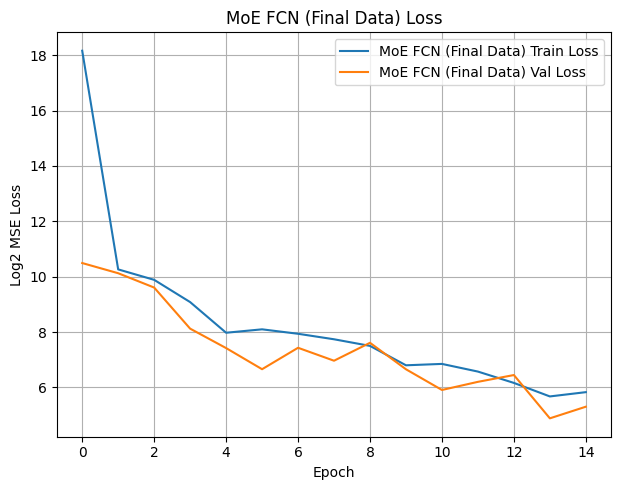

ERROR: DataLoaders ('train_loader_final', 'val_loader_final') not found or not created.
Please run the 'Data Loading and Preparation' cell successfully first.


In [56]:
# --- training MoE with gard gating model ---
if 'train_loader_final' not in locals() or 'val_loader_final' not in locals() or train_loader is None or val_loader is None:
    print("ERROR: DataLoaders ('train_loader_final', 'val_loader_final') not found or not created.")
    print("Please run the 'Data Loading and Preparation' cell successfully first.")
else:
    print("DataLoaders found. Proceeding with training...")

    # --- Training Hyperparameters (can be adjusted here before re-running) ---
    learning_rate_dense = 0.0005
    learning_rate_cnn = 0.0005
    learning_rate_moe = 0.0005 # Added LR for MoE
    epochs = 30     

    # --- Model & Padding Parameters ---
    max_k = 6 # Ensure consistency
    max_nk = 6 # Ensure consistency
    padded_p_matrix_flat_size = max_k * max_nk
    params_size = 3

    # --- MoE Specific Configuration ---
    # Define the unique (n, k) pairs
    unique_nk_pairs = sorted([
        (9, 4), (9, 5), (9, 6),
        (10, 4), (10, 5), (10, 6)
    ])
    # Configuration for the FCN experts within the MoE
    moe_expert_config = {
        'p_input_size': padded_p_matrix_flat_size,
        'param_input_size': params_size,
        'hidden_dims': [512,256,128],
        'dropout_prob': 0.3,
    }

    # --- Device ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Dictionary to store results for this run ---
    results = {}

    # --- Main Training Execution Block ---
    try:

        # --- Initialize & Train MoE_FCN Model --- # ADDED
        print("\n--- Initializing MoE FCN Network (Final Training) ---")
        # Ensure MoE_FCN class is defined correctly
        moe_model = MoE_FCN(
            unique_nk_pairs=unique_nk_pairs,
            expert_config=moe_expert_config,
            params_size=params_size
        ).to(device)
        criterion_moe = LogMSELoss()
        optimizer_moe = optim.Adam(moe_model.parameters(), lr=learning_rate_moe) # Use all parameters
        print(f"MoE Model Parameters: {sum(p.numel() for p in moe_model.parameters() if p.requires_grad):,}")

        # --- training ---
        moe_train_losses, moe_val_losses = run_training(
            model=moe_model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion_moe,
            optimizer=optimizer_moe,
            epochs=epochs,
            device=device,
            model_name="MoE FCN (Final Data)"
        )
        results["MoE FCN (Final Data)"] = (moe_train_losses, moe_val_losses)

    # --- Error Handling ---
    except NameError as e:
         print(f"\nDefinition Error: {e}. Make sure models, loss, or helper functions (run_training, plot_losses, etc.) are defined and executed.")
    except KeyError as e:
         print(f"\nMoE Routing Error: {e}. An (n, k) pair from the data was not found in the MoE mapping. Check unique_nk_pairs.")
    except Exception as e:
        print(f"\nAn unexpected error occurred during training/evaluation: {type(e).__name__} - {e}")
        print("Traceback:")
        print(traceback.format_exc())


    # --- Print Final Validation Losses (Includes MoE) ---
    print("\n--- Final Validation Losses (Log2 MSE) ---")
    for model_name, (train_loss_hist, val_loss_hist) in results.items():
         if val_loss_hist:
             print(f"{model_name}: {val_loss_hist[-1]:.4f}")
         else:
             print(f"{model_name}: Training did not complete or populate losses.")


    # --- Plot Final Losses (Adjust layout for 3 models) ---
    # Ensure plot_losses function can handle the number of models
    # If using the provided plot_losses, it should adjust automatically to a 2x2 grid
    plot_losses(results)

In [24]:
# --- Define mixture-of-experts (MoE) with soft gating model ---
# --- Gating Network ---
class GatingNetwork(nn.Module):
    """Outputs softmax weights for each expert based on n and k."""
    def __init__(self, input_dim=2, num_experts=4, hidden_dim=16):
        super(GatingNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_experts)

    def forward(self, n_k_params):
        """
        Args:
            n_k_params (torch.Tensor): Tensor containing normalized n and k. Shape: (batch, 2)
        Returns:
            torch.Tensor: Softmax weights for experts. Shape: (batch, num_experts)
        """
        x = self.relu(self.fc1(n_k_params))
        gate_outputs = self.fc2(x)
        gate_weights = F.softmax(gate_outputs, dim=1) # Softmax across experts
        return gate_weights

# --- Simple Feed-Forward Expert Network ---
class Expert(nn.Module):
    """A simple Feed-Forward Network expert processing flattened P and m."""
    def __init__(self, input_dim=61, hidden_dims=[128, 64, 32], output_dim=1):
        # IMPORTANT: Adjust input_dim based on flattened P (max_k * max_nk) + 1 (for m)
        # Example: If max_k=10, max_nk=6 => P_flat=60 => input_dim=61
        super(Expert, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2)) # Optional dropout
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, p_flat_m):
        """
        Args:
            p_flat_m (torch.Tensor): Flattened P matrix concatenated with m. Shape: (batch, input_dim)
        Returns:
            torch.Tensor: Expert's output prediction. Shape: (batch, 1)
        """
        return self.network(p_flat_m)

# --- MoE with Soft Gating ---
class MoE_FCN_SoftGate(nn.Module):
    """Mixture of Experts model using a soft gating mechanism."""
    def __init__(self, num_experts=4, expert_input_dim=61, expert_hidden_dims=[128, 64, 32], gating_input_dim=2, gating_hidden_dim=16, output_dim=1):
        super(MoE_FCN_SoftGate, self).__init__()
        self.num_experts = num_experts
        # Check if expert_input_dim is correctly set (should be max_k * max_nk + 1)
        print(f"Initializing MoE with expert_input_dim = {expert_input_dim}")
        self.gating_network = GatingNetwork(input_dim=gating_input_dim, num_experts=num_experts, hidden_dim=gating_hidden_dim)
        self.experts = nn.ModuleList([
            Expert(input_dim=expert_input_dim, hidden_dims=expert_hidden_dims, output_dim=output_dim)
            for _ in range(num_experts)
        ])

    def forward(self, p_matrix, params):
        """
        Args:
            p_matrix (torch.Tensor): Padded P matrix. Shape: (batch, max_k, max_nk)
            params (torch.Tensor): Normalized n, k, m values. Shape: (batch, 3)

        Returns:
            torch.Tensor: Final weighted prediction. Shape: (batch, 1)
        """
        batch_size = p_matrix.size(0)
        max_k = p_matrix.size(1)
        max_nk = p_matrix.size(2)

        # Prepare inputs
        n_k_params = params[:, :2] # Extract n and k for gating
        # m_param = params[:, 2].unsqueeze(1) # Extract m for experts, shape (batch, 1)
        p_flat = p_matrix.view(batch_size, -1) # Flatten P matrix, shape (batch, max_k * max_nk)
        
        expert_input = torch.cat((p_flat, params), dim=1) # Shape: (batch, max_k * max_nk + 3)

        # check expert input dimension based on actual data
        expected_expert_input_dim = p_flat.shape[1] + params.shape[1]
        # This check assumes the first expert's input dim is representative
        actual_expert_input_dim = self.experts[0].network[0].in_features
        if expected_expert_input_dim != actual_expert_input_dim:
            # This is a critical mismatch, likely requires re-instantiating the model
            raise ValueError(f"Expert input dimension mismatch! Expected {expected_expert_input_dim} based on data (P_flat: {p_flat.shape[1]}, m: {m_param.shape[1]}), but model configured with {actual_expert_input_dim}. Adjust expert_input_dim during MoE_FCN_SoftGate instantiation.")

        # Get gating weights
        gate_weights = self.gating_network(n_k_params) # Shape: (batch, num_experts)

        # Get outputs from all experts
        # Stack expert outputs along a new dimension
        expert_outputs_list = [expert(expert_input) for expert in self.experts] # List of tensors, each (batch, 1)
        expert_outputs = torch.stack(expert_outputs_list, dim=1) # Shape: (batch, num_experts, 1)

        # Weight the expert outputs
        # Reshape gate_weights to (batch, num_experts, 1) for broadcasting
        gate_weights_reshaped = gate_weights.unsqueeze(-1)

        # Weighted sum: (batch, num_experts, 1) * (batch, num_experts, 1) -> sum over experts dimension
        final_output = torch.sum(gate_weights_reshaped * expert_outputs, dim=1) # Shape: (batch, 1)

        return final_output


In [ ]:
# --- Training soft gate MoE model ---
# --- Calculate Expert Input Dimension ---
# Should be size of flattened P matrix (max_k * max_nk) + 3
expert_input_dim = (max_k * max_nk) + 3

# --- Define Expert Hidden Dimensions (extract from your config or define directly) ---
# Assuming moe_expert_config was intended to define these
# The Expert class expects a list of hidden dimensions.
expert_hidden_dims = moe_expert_config['hidden_dims']

# --- Define Gating Network Input Dimension (n, k -> 2 features) ---
gating_input_dim = 2

# --- Choose Number of Experts ---
num_experts = 6 

# --- Initialize & Train MoE_FCN Model --- # CORRECTED
print("\n--- Initializing MoE FCN Network (Soft Gate - Training) ---")
# Ensure MoE_FCN_SoftGate class is defined correctly in a previous cell
moe_model = MoE_FCN_SoftGate(
    num_experts=num_experts,              # e.g., 4
    expert_input_dim=expert_input_dim,    # e.g., (6*6)+1 = 37
    expert_hidden_dims=expert_hidden_dims,# e.g., [128, 64, 32]
    gating_input_dim=gating_input_dim,    # Should be 2 (for n, k)
    # Optional: Specify gating hidden dim, output dim if different from defaults
    # gating_hidden_dim=16, # Default
    # output_dim=1          # Default
).to(device)

criterion_moe = LogMSELoss()
optimizer_moe = optim.Adam(moe_model.parameters(), lr=learning_rate_moe)
print(f"MoE Model Parameters: {sum(p.numel() for p in moe_model.parameters() if p.requires_grad):,}")

# --- The rest of your training call looks okay ---
# Ensure train_epoch_with_params/validate_epoch_with_params pass (p_matrices, params) to model.forward
moe_train_losses, moe_val_losses = run_training(
    model=moe_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_moe,
    optimizer=optimizer_moe,
    epochs=epochs,
    device=device,
    model_name="MoE_FCN_SoftGate" # Renamed for clarity
)
results["MoE_FCN_SoftGate"] = (moe_train_losses, moe_val_losses) 


Plotting losses...


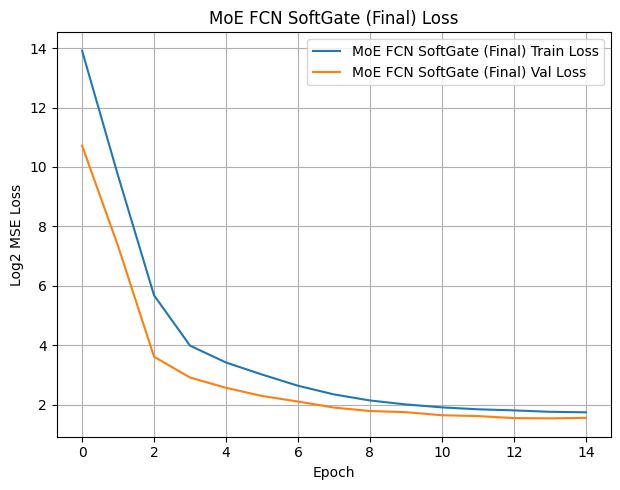

In [62]:
plot_losses(results)

The key advantage of soft gating usually lies in how it combines information:    
- Smoother Transitions & Knowledge Blending: Instead of abruptly switching experts based on n and k, soft gating allows for a smooth blend. An input might benefit from partial contributions from multiple experts, weighted according to relevance determined by the gating network. This can lead to more robust and generalized predictions.   
- Improved Gradient Flow: During training, gradients can flow back through all experts (weighted by the gating outputs and their contribution), allowing all experts to learn potentially useful features even for inputs they aren't the primary "expert" for. In hard gating, only the selected expert gets updated for a given sample.    
- Learned Routing: The gating network actively learns the best way to combine experts based on n and k, potentially capturing more complex relationships than a fixed hard assignment.  

In summary: While it's true that soft gating involves more computation per input (engaging all experts) and has layers in its gating mechanism, the performance improvement is likely due to the more flexible and nuanced way it learns to combine the outputs of its specialized experts, leading to better generalization and potentially smoother learning dynamics. If you also increased the depth of the individual experts compared to your hard-gating model, that would further add to the model's capacity.

Now, we initialize the soft-gating Mixture of Experts (MoE) model. Instead of starting from scratch, we load the weights from the best FCN model trained in Step A into each of the MoE's expert networks. This provides a strong starting point. We will then fine-tune the entire MoE model (experts and gating network) on the full dataset, using a lower learning rate.

In [ ]:
# --- Initialize MoE with Pre-trained Weights & Fine-tune ---
# --- Configuration ---
pretrained_fcn_weights_path = 'best_fcn_pretrained_weights.pth' # Path to weights from previous step
finetune_epochs = 20 # Number of epochs for fine-tuning MoE 
finetune_lr = 0.0001 # Use a potentially lower LR for fine-tuning
max_k = 6
max_nk = 6
# --- MoE Architecture Parameters (Should match MoE class definitions) ---
# Define these based on your MoE_FCN_SoftGate and Expert class structures
moe_num_experts = 6
moe_expert_input_dim = (max_k * max_nk) + 3 
moe_expert_hidden_dims = [512, 256, 128] # MUST match the structure of the saved FCN if loading weights directly!
moe_gating_input_dim = 2 # For n, k
moe_gating_hidden_dim = 16
moe_output_dim = 1

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Should be already defined

# --- Check Prerequisites ---
if not os.path.exists(pretrained_fcn_weights_path):
    print(f"ERROR: Pre-trained FCN weights not found at: {pretrained_fcn_weights_path}")
    print("Please ensure Step A was completed and the weights were saved correctly.")
elif 'MoE_FCN_SoftGate' not in globals() or 'Expert' not in globals() or 'GatingNetwork' not in globals():
    print("ERROR: MoE class definitions (MoE_FCN_SoftGate, Expert, GatingNetwork) not found. Ensure they are defined and executed.")
elif 'train_loader' not in locals() or 'val_loader' not in locals():
    print("ERROR: train_loader or val_loader not found.")
elif 'LogMSELoss' not in locals():
    print("ERROR: LogMSELoss class definition not found.")
else:
    print("\n--- Step B: Initializing MoE with Pre-trained FCN Weights ---")

    # --- Load the pre-trained state dict from the best FCN ---
    # Note: This assumes the 'Expert' network structure within MoE_FCN_SoftGate
    #       *exactly* matches the structure of the FlexibleDenseNetworkWithParams
    #       whose weights were saved. If they differ, loading will fail or require mapping.
    print(f"Loading pre-trained weights from: {pretrained_fcn_weights_path}")
    pretrained_fcn_state_dict = torch.load(pretrained_fcn_weights_path, map_location=device)

    # --- Instantiate the MoE Model ---
    print("Instantiating MoE_FCN_SoftGate model...")
    moe_finetune_model = MoE_FCN_SoftGate(
        num_experts=moe_num_experts,
        expert_input_dim=moe_expert_input_dim,
        expert_hidden_dims=moe_expert_hidden_dims, # Must match saved FCN structure
        gating_input_dim=moe_gating_input_dim,
        gating_hidden_dim=moe_gating_hidden_dim,
        output_dim=moe_output_dim
    ).to(device)

    # --- Load weights into each expert ---
    num_experts_loaded = 0
    total_experts = len(moe_finetune_model.experts)
    print(f"Attempting to load pre-trained FCN weights into {total_experts} experts...")

    # We need to adapt the keys if the saved model was FlexibleDenseNetworkWithParams
    # FlexibleDenseNetworkWithParams saves keys starting with 'network.LAYER...'
    # The Expert class uses keys starting with 'network.LAYER...'

    # Create a state dict mapping for one expert based on the FCN weights
    expert_state_dict = {}
    fcn_key_prefix = 'network.' # Assuming FlexibleDense... uses this prefix for its Sequential block
    expert_key_prefix = 'network.' # Assuming Expert class uses this prefix

    keys_matched = 0
    for key, value in pretrained_fcn_state_dict.items():
        if key.startswith(fcn_key_prefix):
            # expert_key = expert_key_prefix + key[len(fcn_key_prefix):] # Keep the same sub-keys
            expert_key = key # If both use 'network.' prefix, keys might match directly
            expert_state_dict[expert_key] = value
            keys_matched += 1
        else: # Handle cases where the FCN might have other parameters not in the sequential 'network'
            print(f"  Skipping key '{key}' from pre-trained FCN (not part of 'network').")

    if keys_matched == 0:
        print("ERROR: No keys starting with 'network.' found in the pre-trained FCN state dict. Cannot map weights to experts.")
        print("Pre-trained keys:", pretrained_fcn_state_dict.keys())
    else:
        print(f"  Mapped {keys_matched} parameter keys from FCN state dict to expert structure.")
        load_errors = []
        for i, expert in enumerate(moe_finetune_model.experts):
            try:
                # Load the prepared state dictionary into the current expert
                # strict=True ensures all keys in expert_state_dict must match expert keys
                missing_keys, unexpected_keys = expert.load_state_dict(expert_state_dict, strict=True)

                if not unexpected_keys and not missing_keys:
                     num_experts_loaded += 1
                else:
                     print(f"  Warning: Loading weights into Expert {i} encountered issues:")
                     if missing_keys: print(f"Missing keys in Expert {i}: {missing_keys}")
                     if unexpected_keys: print(f"Unexpected keys in Expert {i} state_dict: {unexpected_keys}")
                     load_errors.append(i)

            except Exception as e:
                print(f"  ERROR loading weights into Expert {i}: {e}")
                load_errors.append(i)

        print(f"Successfully loaded pre-trained weights into {num_experts_loaded}/{total_experts} experts.")
        if load_errors:
             print(f"Failed to load weights correctly for experts: {load_errors}. Check model structure compatibility.")


    # Proceed only if weights were loaded successfully
    if num_experts_loaded == total_experts:
        print("\n--- Step C: Fine-tuning the Pre-initialized MoE Model ---")

        # --- Setup Optimizer and Criterion for Fine-tuning ---
        optimizer_moe_finetune = optim.Adam(moe_finetune_model.parameters(), lr=finetune_lr, weight_decay = 1e-5)
        criterion_moe_finetune = LogMSELoss()

        # --- Run Fine-tuning Training ---
        # Option 1: Use run_training function (ensure it saves the best model)
        if 'run_training' in globals():
            print(f"Starting fine-tuning using 'run_training' for {finetune_epochs} epochs with LR={finetune_lr}...")
            moe_finetune_train_losses, moe_finetune_val_losses = run_training(
                model=moe_finetune_model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion_moe_finetune,
                optimizer=optimizer_moe_finetune,
                epochs=finetune_epochs,
                device=device,
                model_name="MoE_Finetuned"
            )
             # Optional: Plot results if run_training doesn't plot
             # plot_losses({"MoE Finetuned": (moe_finetune_train_losses, moe_finetune_val_losses)})

        # Option 2: Use manual loop if run_training isn't suitable or available
        elif 'train_epoch_with_params' in globals() and 'validate_epoch_with_params' in globals():
            print(f"Starting fine-tuning using manual loop for {finetune_epochs} epochs with LR={finetune_lr}...")
            best_finetune_val_loss = float('inf')
            moe_finetune_train_losses = []
            moe_finetune_val_losses = []
            finetune_start_time = time.time()
            finetune_save_path = f'best_moe_{moe_num_experts}experts_finetuned_weights.pth'

            for epoch in range(finetune_epochs):
                epoch_start_time = time.time()
                train_loss = train_epoch_with_params(moe_finetune_model, train_loader, criterion_moe_finetune, optimizer_moe_finetune, device)
                val_loss = validate_epoch_with_params(moe_finetune_model, val_loader, criterion_moe_finetune, device)
                epoch_duration = time.time() - epoch_start_time

                moe_finetune_train_losses.append(train_loss)
                moe_finetune_val_losses.append(val_loss)

                print(f"Epoch {epoch+1}/{finetune_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_duration:.2f}s")

                # Save the model if validation loss improves
                if val_loss < best_finetune_val_loss:
                    best_finetune_val_loss = val_loss
                    torch.save(moe_finetune_model.state_dict(), finetune_save_path)
                    print(f"  -> Val loss improved to {best_finetune_val_loss:.4f}. Model weights saved to {finetune_save_path}")

            total_time_finetune = time.time() - finetune_start_time
            print(f"\nMoE Fine-tuning Finished. Total time: {total_time_finetune:.2f} seconds")
            print(f"Best Validation Loss achieved: {best_finetune_val_loss:.4f}")
            print(f"Best fine-tuned MoE model weights saved to: {finetune_save_path}")

            # --- Plot Final Training Curve ---
            if moe_finetune_train_losses and moe_finetune_val_losses:
                 try:
                      plt.figure(figsize=(10, 5))
                      plt.plot(moe_finetune_train_losses, label='MoE Fine-tune Train Loss')
                      plt.plot(moe_finetune_val_losses, label=f'MoE Fine-tune Val Loss (Best: {best_finetune_val_loss:.4f})')
                      best_epoch_idx = np.argmin(moe_finetune_val_losses)
                      plt.scatter([best_epoch_idx], [best_finetune_val_loss], color='red', s=50, zorder=5, label=f'Best Val @ Epoch {best_epoch_idx+1}')

                      plt.title(f'Fine-tuning Pre-Initialized MoE (LR={finetune_lr})')
                      plt.xlabel('Epoch')
                      plt.ylabel('Log2 MSE Loss')
                      plt.legend()
                      plt.grid(True)
                      plt.show()
                 except Exception as plot_err:
                      print(f"\nWarning: Plotting fine-tune curve failed - {plot_err}")

        else:
             print("ERROR: Cannot run fine-tuning - suitable training functions not found.")

    else:
        print("\nSkipping Step (Fine-tuning) due to errors loading pre-trained weights into experts.")



With this technique, we go from 1.37 loss on the validation set to 1.344 loss. 

FINAL TEST CELL : 

Explanation of the project so far :   
- 1st step of the project: generated data using PuLP and HPRC :   
 generated 10 000 data so far with 128 CPU but couldn't generate more due to heavy computational in particularly with bigger m.   That why, I decided to use Keegan Smith student's data. I took 420,000 data from his 1 million data and I splitted at the end in a 80/20 ratio for training and validations set.   
 
- 2nd step:  
 it was to load all the data and preprocess it for the model using the class "PickleFolderDataset" to load the data from pkl files.    
 
- 3rd step: train the model using MSE loss function on the log2 scale:     
for this part, I decompose in multiple step:  
    - step A: testing different basic architecture (Fully connected Network (FCN/dense layer), CNN, RNN with LSTM and GRU) on small dataset
    - step B: test the two best architecture one the big dataset : FCN turns out to be the one
    - step C: fine tune FCN architecture and fine-tune hyperparameters
    - step D: test MoE architecture with hard and soft gate with dense layer : soft gates gives better results.  
    - step E: use the weight of the best FCN model to initial the weight of the each expert of MoE with soft gates function
    - step F: fine tune the hyperparameters to get the best models possible. 

Finally, you can run the final evaluation cell either by loading the best model.

In [3]:
!pip install tamu_csce_636_project1


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\theo-\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


PROJECT ONE FINAL CELL, PROJECT TWO FINAL CELL IS BELOW THIS ONE

In [4]:
# --- Final cell for Evaluation and Testing for project one ---
import numpy as np
import os
import traceback
from collections import defaultdict
from tamu_csce_636_project1 import Evaluator
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import glob

# --- Constants ---
max_k_padded = 6  # Max height for padding P
max_nk_padded = 6 # Max width for padding P
model_path = "best_moe_finetuned_final.pth"
test_data_folder = './split_data_small_test'
params_size = 3 # n, k, m
p_flat_size = max_k_padded * max_nk_padded # 36
expert_input_dim = p_flat_size + params_size # 39
gating_input_dim = 2 # Only n, k for gating
num_experts = 6 # Should match the trained model
expert_hidden_dims = [512, 256, 128] # Should match the trained model
gating_hidden_dim = 16 # Should match the trained model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Evaluator Setup ---
try:
    evaluator = Evaluator(
        first_name="Theo",
        last_name="Lin",
        email="theo.lin@tamu.edu",
        print=True
    )
    print("Evaluator initialized successfully.")
except Exception as e:
    print(f"Error initializing Evaluator: {e}")
    evaluator = None # Set to None if initialization fails

# --- Dataset Class Definition ---
class PickleFolderDataset(Dataset):
    """
    PyTorch Dataset for loading data from a **list of .pkl file paths**.

    Assumes each .pkl file contains a Pandas DataFrame with columns
    'n', 'k', 'm', 'result', 'P'.
    Handles cases where 'P' might be a 2D array OR a flattened 1D array.
    Reshapes 1D 'P' arrays to 2D using 'n' and 'k' before padding.
    Handles padding P_matrices.
    Returns data as (params, h, P).
    """
    def __init__(self, file_paths, max_k=6, max_nk=6):
        """
        Args:
            file_paths (list[str]): A list of full paths to the .pkl files.
            max_k (int): The height to pad P matrices to.
            max_nk (int): The width to pad P matrices to.
        """
        self.file_paths = file_paths # it is a list
        self.max_k = max_k
        self.max_nk = max_nk

        if not self.file_paths:
            raise ValueError("The provided file_paths list is empty.")

        # Store data directly as loaded from pickle (P can be 1D or 2D)
        self.all_p_matrices = [] # Can contain mixed ndim arrays initially
        self.all_h_values = []
        # Store n, k, m as simple Python ints initially for reshaping logic
        self.all_n = []
        self.all_k = []
        self.all_m = []

        print(f"Loading data from {len(self.file_paths)} specified pickle files (expecting DataFrames)...")
        required_columns = ['n', 'k', 'm', 'result', 'P']

        for file_path in self.file_paths: # Iterate through the provided list
            # print(f"  Loading: {os.path.basename(file_path)}") # Keep print concise
            try:
                # Ensure pickle is imported before using it
                import pickle
                with open(file_path, 'rb') as f:
                    data_df = pickle.load(f)

                    if not isinstance(data_df, pd.DataFrame):
                        print(f"Warning: Skipping {os.path.basename(file_path)} - Expected a Pandas DataFrame, found {type(data_df)}.")
                        continue
                    if not all(col in data_df.columns for col in required_columns):
                        print(f"Warning: Skipping {os.path.basename(file_path)} - Missing required columns ({required_columns}). Found: {list(data_df.columns)}")
                        continue

                    # Use efficient Pandas column access
                    p_matrices_list = data_df['P'].tolist()
                    h_values_list = data_df['result'].astype(float).tolist()
                    n_vals_list = data_df['n'].astype(int).tolist()
                    k_vals_list = data_df['k'].astype(int).tolist()
                    m_vals_list = data_df['m'].astype(int).tolist()

                    # Optional: Basic validation before extending
                    list_len = len(p_matrices_list)
                    if not (list_len == len(h_values_list) == len(n_vals_list) == len(k_vals_list) == len(m_vals_list)):
                            print(f"Warning: Skipping {os.path.basename(file_path)} due to inconsistent column lengths after tolist().")
                            continue

                    # Extend lists
                    self.all_p_matrices.extend([np.array(p) for p in p_matrices_list]) # Ensure numpy
                    self.all_h_values.extend(h_values_list)
                    self.all_n.extend(n_vals_list) # Keep as int
                    self.all_k.extend(k_vals_list) # Keep as int
                    self.all_m.extend(m_vals_list) # Keep as int

            except FileNotFoundError:
                    print(f"Error: File not found {file_path}. Skipping.")
            except Exception as e:
                print(f"Error loading/processing {file_path}: {type(e).__name__} - {e}. Skipping file.")
                # print(traceback.format_exc()) # Uncomment for more detail

        if not self.all_h_values:
                raise ValueError("No valid data loaded from any pickle files.")

        print(f"Finished initial loading. Total samples found: {len(self.all_h_values)}")

        # --- Convert non-P lists to tensors ---
        self.all_h_values_tensor = torch.tensor(self.all_h_values, dtype=torch.float32)
        self.all_n_tensor = torch.tensor(self.all_n, dtype=torch.float32)
        self.all_k_tensor = torch.tensor(self.all_k, dtype=torch.float32)
        self.all_m_tensor = torch.tensor(self.all_m, dtype=torch.float32)


    def __len__(self):
        return len(self.all_h_values_tensor)

    def _pad_matrix(self, p_matrix_2d):
        if not isinstance(p_matrix_2d, np.ndarray) or p_matrix_2d.ndim != 2:
            raise ValueError(f"Input to _pad_matrix must be a 2D NumPy array, but got type {type(p_matrix_2d)} with shape {getattr(p_matrix_2d, 'shape', 'N/A')}")
        p_tensor = torch.tensor(p_matrix_2d, dtype=torch.float32)
        k_actual, nk_actual = p_tensor.shape
        pad_k = self.max_k - k_actual
        pad_nk = self.max_nk - nk_actual
        if pad_k < 0 or pad_nk < 0:
                raise ValueError(f"Matrix shape ({k_actual},{nk_actual}) exceeds target padding ({self.max_k},{self.max_nk}).")
        # Padding format: (pad_left, pad_right, pad_top, pad_bottom)
        padding = (0, pad_nk, 0, pad_k)
        padded_p = F.pad(p_tensor, padding, "constant", 0)
        return padded_p

    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()

        p_matrix_np = self.all_p_matrices[idx]
        h_value = self.all_h_values_tensor[idx]
        n_val = self.all_n[idx] # Get int value
        k_val = self.all_k[idx] # Get int value

        p_matrix_2d = None

        # --- Reshape if necessary ---
        if p_matrix_np.ndim == 1:
            try:
                # Calculate target shape based on n and k ints
                target_rows = k_val
                target_cols = n_val - k_val
                if target_rows < 0 or target_cols < 0: # k can be 0 if n=1, but cols should be >= 0
                     raise ValueError(f"Invalid target shape derived: k={target_rows}, n-k={target_cols} from n={n_val}, k={k_val}")

                expected_len = target_rows * target_cols

                # Handle edge case: k=n -> P is empty (0 elements)
                if p_matrix_np.size == 0 and expected_len == 0:
                    # Create an empty 2D array with correct dimensions (k rows, 0 cols)
                    p_matrix_2d = np.empty((target_rows, target_cols), dtype=p_matrix_np.dtype)
                elif p_matrix_np.size != expected_len:
                    raise ValueError(f"Flattened P length ({p_matrix_np.size}) != k*(n-k) ({expected_len}) for n={n_val}, k={k_val}")
                else:
                    # Reshape only if the size matches the expected length
                    p_matrix_2d = p_matrix_np.reshape((target_rows, target_cols))

            except Exception as e:
                print(f"ERROR in __getitem__ (idx={idx}): Failed to reshape P with shape {p_matrix_np.shape} using n={n_val}, k={k_val}. Error: {e}")
                # Depending on severity, you might want to return None or skip this sample
                raise RuntimeError(f"Data Error: Failed processing P matrix for sample index {idx}.") from e
        elif p_matrix_np.ndim == 2:
            p_matrix_2d = p_matrix_np
        else:
            # This case should ideally not happen if data generation is correct
            raise ValueError(f"ERROR in __getitem__ (idx={idx}): P matrix has unexpected shape {p_matrix_np.shape}.")
        # --- End Reshape ---

        # Pad the (now guaranteed 2D) matrix
        try:
            padded_p = self._pad_matrix(p_matrix_2d)
        except ValueError as e:
            print(f"ERROR in __getitem__ (idx={idx}): Failed to pad P matrix derived from shape {p_matrix_np.shape} (n={n_val}, k={k_val}). Error: {e}")
            raise RuntimeError(f"Data Error: Failed padding P matrix for sample index {idx}.") from e


        # Use the tensor versions of n, k, m for stacking
        params = torch.stack([self.all_n_tensor[idx], self.all_k_tensor[idx], self.all_m_tensor[idx]])
        h = h_value.unsqueeze(0) # Ensure h has shape [1]
        return params, h, padded_p

# --- Model Class Definitions (Copied from your selection) ---
class GatingNetwork(nn.Module):
    def __init__(self, input_dim=2, num_experts=4, hidden_dim=16):
        super(GatingNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_experts)
        print(f"Initialized GatingNetwork: input_dim={input_dim}, num_experts={num_experts}, hidden_dim={hidden_dim}")


    def forward(self, n_k_params):
        x = self.relu(self.fc1(n_k_params.float()))
        gate_outputs = self.fc2(x)
        gate_weights = F.softmax(gate_outputs, dim=1)
        return gate_weights

class Expert(nn.Module):
    def __init__(self, input_dim=39, hidden_dims=[512, 256, 128], output_dim=1):
        super(Expert, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2)) 
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
        print(f"Initialized Expert: input_dim={input_dim}, hidden_dims={hidden_dims}, output_dim={output_dim}")


    def forward(self, p_flat_params):
        return self.network(p_flat_params.float())

class MoE_FCN_SoftGate(nn.Module):
    def __init__(self, num_experts=6, expert_input_dim=39, expert_hidden_dims=[512, 256, 128], gating_input_dim=2, gating_hidden_dim=16, output_dim=1):
        super(MoE_FCN_SoftGate, self).__init__()
        self.num_experts = num_experts
        # Initialize sub-modules
        self.gating_network = GatingNetwork(input_dim=gating_input_dim, num_experts=num_experts, hidden_dim=gating_hidden_dim)
        self.experts = nn.ModuleList([
            Expert(input_dim=expert_input_dim, hidden_dims=expert_hidden_dims, output_dim=output_dim)
            for _ in range(num_experts)
        ])
        print(f"Initialized MoE_FCN_SoftGate: num_experts={num_experts}")


    def forward(self, p_matrix, params):
        # Input type and shape validation/casting
        batch_size = p_matrix.size(0)
        p_matrix = p_matrix.float().to(params.device) # Ensure float and same device
        params = params.float()

        # Prepare inputs for gating and experts
        n_k_params = params[:, :2] # First two elements (n, k) for gating
        p_flat = p_matrix.view(batch_size, -1)
        expert_input = torch.cat((p_flat, params), dim=1)

        # Dynamic dimension check (optional but good practice)
        expected_expert_input_dim = p_flat.shape[1] + params.shape[1]
        # Accessing internal layer requires care, assuming Expert structure is stable
        actual_expert_input_dim = self.experts[0].network[0].in_features
        if expected_expert_input_dim != actual_expert_input_dim:
            raise ValueError(f"Expert input dimension mismatch! Expected {expected_expert_input_dim}, but model configured with {actual_expert_input_dim}")

        # Get gating weights and expert outputs
        gate_weights = self.gating_network(n_k_params)
        expert_outputs_list = [expert(expert_input) for expert in self.experts]

        # Stack expert outputs along a new dimension (batch_size, num_experts, output_dim)
        expert_outputs = torch.stack(expert_outputs_list, dim=1)

        # Reshape gate_weights for broadcasting (batch_size, num_experts, 1)
        gate_weights_reshaped = gate_weights.unsqueeze(-1)

        # Weighted sum of expert outputs
        # Broadcasting: (batch_size, num_experts, 1) * (batch_size, num_experts, output_dim)
        # Result before sum: (batch_size, num_experts, output_dim)
        # Sum along dim=1 (experts): (batch_size, output_dim)
        final_output = torch.sum(gate_weights_reshaped * expert_outputs, dim=1)

        return final_output

class LogMSELoss(nn.Module):
    def __init__(self, eps=1e-9):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        # Ensure inputs are tensors and on the same device
        y_pred = torch.as_tensor(y_pred, device=y_true.device)

        # Clamp inputs to be positive before log2
        y_pred_safe = torch.clamp(y_pred, min=self.eps)
        y_true_safe = torch.clamp(y_true, min=self.eps)

        # Calculate log base 2
        log2_pred = torch.log2(y_pred_safe)
        log2_true = torch.log2(y_true_safe)

        # Calculate the squared difference and mean over the batch
        loss = torch.mean((log2_true - log2_pred) ** 2)
        return loss


# --- Helper: Padding Function (Standalone for prediction function) ---
def _pad_matrix_pred(p_matrix_2d, max_k, max_nk):
    if not isinstance(p_matrix_2d, np.ndarray) or p_matrix_2d.ndim != 2:
        raise ValueError(f"Input must be a 2D NumPy array, got type {type(p_matrix_2d)} with shape {getattr(p_matrix_2d, 'shape', 'N/A')}")
    p_tensor = torch.tensor(p_matrix_2d, dtype=torch.float32)
    k_actual, nk_actual = p_tensor.shape
    pad_k = max_k - k_actual
    pad_nk = max_nk - nk_actual
    if pad_k < 0 or pad_nk < 0:
        raise ValueError(f"Matrix shape ({k_actual},{nk_actual}) exceeds target padding ({max_k},{max_nk}).")
    padding = (0, pad_nk, 0, pad_k) # Pad right, bottom
    padded_p = F.pad(p_tensor, padding, "constant", 0)
    return padded_p

# --- Prediction Function for Evaluator ---
# Global model variable to load only once
loaded_model_for_pred = None

def predicted_m_height(n, k, m, p_list):
    """
    Predicts m-height for a list of P matrices using the loaded MoE model.

    Parameters:
        n (int)
        k (int)
        m (int)
        p_list (list): a list of P matrices, each matrix will be a numpy array

    Returns:
        a list of scalars, e.g. the m-height value, one for each matrix
    """
    global loaded_model_for_pred, device, max_k_padded, max_nk_padded, model_path
    global num_experts, expert_input_dim, expert_hidden_dims, gating_input_dim, gating_hidden_dim

    # --- Load Model (only once) ---
    if loaded_model_for_pred is None:
        print("Loading model for prediction...")
        try:
            loaded_model_for_pred = MoE_FCN_SoftGate(
                num_experts=num_experts,
                expert_input_dim=expert_input_dim,
                expert_hidden_dims=expert_hidden_dims,
                gating_input_dim=gating_input_dim,
                gating_hidden_dim=gating_hidden_dim
            )
            # Load state dict, mapping to the correct device
            state_dict = torch.load(model_path, map_location=device)
            loaded_model_for_pred.load_state_dict(state_dict)
            loaded_model_for_pred.to(device)
            loaded_model_for_pred.eval() # Set to evaluation mode
            print("Model loaded successfully for prediction.")
        except FileNotFoundError:
            print(f"\nERROR: Model file not found at {model_path}")
            raise
        except Exception as e:
            print(f"\nERROR loading model: {e}")
            raise

    # --- Process Inputs ---
    predictions = []
    with torch.no_grad(): # Disable gradient calculations for inference
        for p_matrix_np in p_list:
            try:
                # Ensure p_matrix is a numpy array
                if not isinstance(p_matrix_np, np.ndarray):
                    p_matrix_np = np.array(p_matrix_np)

                p_matrix_2d = None
                # --- Reshape if necessary ---
                if p_matrix_np.ndim == 1:
                     target_rows = k
                     target_cols = n - k
                     if target_rows < 0 or target_cols < 0:
                         raise ValueError(f"Invalid target shape: k={target_rows}, n-k={target_cols} from n={n}, k={k}")
                     expected_len = target_rows * target_cols
                     if p_matrix_np.size == 0 and expected_len == 0:
                         p_matrix_2d = np.empty((target_rows, target_cols), dtype=p_matrix_np.dtype)
                     elif p_matrix_np.size != expected_len:
                         raise ValueError(f"Flattened P length ({p_matrix_np.size}) != k*(n-k) ({expected_len}) for n={n}, k={k}")
                     else:
                         p_matrix_2d = p_matrix_np.reshape((target_rows, target_cols))
                elif p_matrix_np.ndim == 2:
                     p_matrix_2d = p_matrix_np
                else:
                     raise ValueError(f"P matrix has unexpected shape {p_matrix_np.shape}.")
                # --- End Reshape ---

                # Pad the matrix
                padded_p = _pad_matrix_pred(p_matrix_2d, max_k_padded, max_nk_padded)

                # Prepare tensors for the model
                # Add batch dimension (batch size = 1)
                padded_p_tensor = padded_p.unsqueeze(0).to(device)
                params_tensor = torch.tensor([[n, k, m]], dtype=torch.float32).to(device)

                # --- Predict ---
                output = loaded_model_for_pred(padded_p_tensor, params_tensor)
                predictions.append(output.item()) # Get scalar value

            except Exception as e:
                print(f"ERROR predicting for one P matrix (n={n}, k={k}, m={m}): {e}")
                # Decide how to handle errors: append None, 0, or raise?
                # Appending None might cause issues with the evaluator if it expects numbers.
                # Let's append a placeholder like 0 or NaN and print a warning.
                predictions.append(0.0) # Append 0.0 as a placeholder for failed predictions
                # Or use float('nan') if appropriate: predictions.append(float('nan'))

    return predictions

# --- Run Evaluator ---
if evaluator:
    print("\n--- Running Evaluator ---")
    try:
        sigma = evaluator.eval(func=predicted_m_height)
        if sigma:
            print("\nEvaluator Results (sigma):")
            print(dict(sigma))
        else:
            print("Evaluator returned no results (potentially due to errors in predicted_m_height).")
    except Exception as e:
        print(f"\nError during evaluator.eval(): {e}")
        print(traceback.format_exc())
else:
    print("\nEvaluator not initialized. Skipping evaluator.eval().")


# --- Evaluate on Small Test Dataset ---
print(f"\n--- Evaluating on Small Test Dataset: {test_data_folder} ---")
try:
    # --- Load Test Data ---
    test_files = glob.glob(os.path.join(test_data_folder, '*.pkl'))
    if not test_files:
        raise FileNotFoundError(f"No .pkl files found in the test folder: {test_data_folder}")

    test_dataset = PickleFolderDataset(file_paths=test_files, max_k=max_k_padded, max_nk=max_nk_padded)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False) # Use a reasonable batch size
    print(f"Loaded {len(test_dataset)} test samples.")

    # --- Load Model (or reuse if already loaded) ---
    if loaded_model_for_pred is None:
        print("Loading model for testing...")
        test_model = MoE_FCN_SoftGate(
            num_experts=num_experts,
            expert_input_dim=expert_input_dim,
            expert_hidden_dims=expert_hidden_dims,
            gating_input_dim=gating_input_dim,
            gating_hidden_dim=gating_hidden_dim
        )
        state_dict = torch.load(model_path, map_location=device)
        test_model.load_state_dict(state_dict)
        test_model.to(device)
        print("Model loaded successfully for testing.")
    else:
        print("Reusing already loaded model for testing.")
        test_model = loaded_model_for_pred # Reuse the globally loaded model

    test_model.eval() # Ensure evaluation mode

    # --- Calculate Loss ---
    criterion = LogMSELoss()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for params, targets, p_matrices in test_loader:
            params, targets, p_matrices = params.to(device), targets.to(device), p_matrices.to(device)

            outputs = test_model(p_matrices, params)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * params.size(0) # Accumulate loss correctly
            total_samples += params.size(0)

    if total_samples > 0:
        average_loss = total_loss / total_samples
        print(f"\nAverage LogMSELoss on '{test_data_folder}': {average_loss:.6f}")
    else:
        print("\nNo samples processed from the test dataset.")

except FileNotFoundError as e:
    print(f"\nERROR loading test data: {e}")
except ValueError as e:
     print(f"\nERROR processing test data: {e}")
except NameError as e:
     print(f"\nDefinition Error: {e}. Make sure classes/functions are defined.")
except Exception as e:
    print(f"\nAn unexpected error occurred during test set evaluation: {type(e).__name__} - {e}")
    print(traceback.format_exc())

print("\n--- Cell Execution Finished ---")


Using device: cuda
Evaluator initialized successfully.

--- Running Evaluator ---
Loading model for prediction...
Initialized GatingNetwork: input_dim=2, num_experts=6, hidden_dim=16
Initialized Expert: input_dim=39, hidden_dims=[512, 256, 128], output_dim=1
Initialized Expert: input_dim=39, hidden_dims=[512, 256, 128], output_dim=1
Initialized Expert: input_dim=39, hidden_dims=[512, 256, 128], output_dim=1
Initialized Expert: input_dim=39, hidden_dims=[512, 256, 128], output_dim=1
Initialized Expert: input_dim=39, hidden_dims=[512, 256, 128], output_dim=1
Initialized Expert: input_dim=39, hidden_dims=[512, 256, 128], output_dim=1
Initialized MoE_FCN_SoftGate: num_experts=6
Model loaded successfully for prediction.
σ = {
    # n, k, m
    (5, 2, 2): 57.28731422441739,
}

Evaluator Results (sigma):
{(5, 2, 2): 57.28731422441739}

--- Evaluating on Small Test Dataset: ./split_data_small_test ---
Loading data from 21 specified pickle files (expecting DataFrames)...
Finished initial loadin

we have a higher loss values (1.54) compared to what we have with validation set with a loss value of 1.34

# ---------------------    
BELOW is the final cell for the project 2 

In [7]:
# --- Final cell for Evaluation and Testing for the project two ---

import numpy as np
import os
import traceback
from collections import defaultdict
from tamu_csce_636_project1 import Evaluator
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import glob

# --- Constants ---
max_k_padded = 6  # Max height for padding P
max_nk_padded = 6 # Max width for padding P
model_path = "best_resnet2d_no_norm.pth"
test_data_folder = './split_data_small_test'
params_size = 3 # n, k, m
p_flat_size = max_k_padded * max_nk_padded # 36


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Evaluator Setup ---
try:
    evaluator = Evaluator(
        first_name="Theo",
        last_name="Lin",
        email="theo.lin@tamu.edu",
        print=True
    )
    print("Evaluator initialized successfully.")
except Exception as e:
    print(f"Error initializing Evaluator: {e}")
    evaluator = None # Set to None if initialization fails

# --- Dataset Class Definition ---
# --- Define the class "PickleFolderDataset" to load the data from pkl files ---

# --- Normalisation function ---
EPS = 1e-9
def norm_none(t):
    return t                                      # raw P

def norm_row_standard(t):
    mu  = t.mean(dim=1, keepdim=True)
    std = t.std (dim=1, keepdim=True) + EPS
    return (t - mu) / std                         # each row N(0,1)

def norm_col_minmax(t, to=(-1., 1.)):
    lo, hi = to
    col_min = t.min(dim=0, keepdim=True).values
    col_max = t.max(dim=0, keepdim=True).values
    rng = (col_max - col_min).clamp_min(EPS)
    return (t - col_min) / rng * (hi - lo) + lo   # columns -> [-1,1]

NORMALISERS = {
    "none":           norm_none,
    "row_standard":   norm_row_standard,
    "col_minmax":     norm_col_minmax,
}

# --- Data Loader class from Pickle files ---
class PickleFolderDataset(Dataset):
    """
    PyTorch Dataset for loading data from a **list of .pkl file paths**.

    Assumes each .pkl file contains a Pandas DataFrame with columns
    'n', 'k', 'm', 'result', 'P'.
    Handles cases where 'P' might be a 2D array OR a flattened 1D array.
    Reshapes 1D 'P' arrays to 2D using 'n' and 'k' before padding.
    Handles padding P_matrices. 
    Returns data as (params, h, P).
    """
    def __init__(self, file_paths: list, max_k :int = 6, max_nk:int = 6, transform:callable=None, p_normaliser:str = "none", return_col_indices=False): 
        """
        Args:
            file_paths (list[str]): A list of full paths to the .pkl files.
            max_k (int): The height to pad P matrices to.
            max_nk (int): The width to pad P matrices to.
            p_normaliser (str): key in NORMALISERS (str) – 'none', 'row_standard', 'col_minmax', ...
            return_col_indices (bool): if True -> __getitem__ returns an extra tensor [n‑k] with 0…n‑k‑1
            transform (callable): additional callable applied AFTER padding & normalisation
        """
        super().__init__()
        if p_normaliser not in NORMALISERS:
            raise ValueError(f"Invalid p_normaliser: {p_normaliser}. Must be one of: {list(NORMALISERS.keys())}")
        
        self._normalise = NORMALISERS[p_normaliser]
        self.return_col_indices = return_col_indices
        self.max_k,self.max_nk = max_k,max_nk
        self.transform = transform

        if not file_paths:
            raise ValueError("The provided file_paths list is empty.")

        # ------------------------------------------------------------------
        # LOAD DATA  
        # ------------------------------------------------------------------        
        # Store data directly as loaded from pickle (P can be 1D or 2D)
        self.P_raw, self.h_vals, self.n_vals, self.k_vals, self.m_vals = \
            [], [], [], [], []

        print(f"Loading data from {len(file_paths)} specified pickle files (expecting DataFrames)...")
        required = ['n', 'k', 'm', 'result', 'P']

        for fp in file_paths: # Iterate through the provided list
            # print(f"  Loading: {os.path.basename(file_path)}") # Keep print concise
            try:
                with open(fp, "rb") as f:
                    df = pickle.load(f)
                if not all(col in df.columns for col in required):
                    continue

                self.P_raw.extend([np.array(p) for p in df['P']])
                self.h_vals.extend(df['result'].astype(float).tolist())
                self.n_vals.extend(df['n'].astype(int).tolist())
                self.k_vals.extend(df['k'].astype(int).tolist())
                self.m_vals.extend(df['m'].astype(int).tolist())

            except FileNotFoundError:
                    print(f"Error: File not found {fp}. Skipping.")
            except Exception as e:
                print(f"Error loading/processing {fp}: {type(e).__name__} - {e}. Skipping file.")
                # print(traceback.format_exc()) # Uncomment for more detail

        if not self.h_vals:
                raise ValueError("No valid data loaded from any pickle files.")

        if not self.h_vals:
                raise ValueError("No valid data loaded from any pickle files.")

        print(f"Finished initial loading. Total samples found: {len(self.h_vals)}")

        # --- Convert non-P lists to tensors ---
        self.h_vals  = torch.tensor(self.h_vals , dtype=torch.float32)
        self.n_vals  = torch.tensor(self.n_vals , dtype=torch.float32)
        self.k_vals  = torch.tensor(self.k_vals , dtype=torch.float32)
        self.m_vals  = torch.tensor(self.m_vals , dtype=torch.float32)

    def __len__(self):
        return len(self.h_vals)

    def _pad(self, p2d: torch.Tensor):
        k_act, nk_act = p2d.shape
        pad = (0, self.max_nk - nk_act, 0, self.max_k - k_act)  # (W_left,W_right,H_top,H_bottom)
        return F.pad(p2d, pad, value=0.)

    def __getitem__(self, idx):
        # --- reshape / pad ---
        p_np   = self.P_raw[idx]
        n, k   = int(self.n_vals[idx]), int(self.k_vals[idx])
        target = (k, n - k)
        if p_np.ndim == 1:
            p_np = p_np.reshape(*target)  # raises if shape mismatched
        p_t = torch.tensor(p_np, dtype=torch.float32)
        p_t = self._pad(p_t)

        # --- normalise ---
        p_t = self._normalise(p_t)

        # --- extra transform hook ---
        if self.transform:
            p_t = self.transform(p_t)

        # --- build output ---
        params  = torch.tensor([self.n_vals[idx], self.k_vals[idx], self.m_vals[idx]],
                               dtype=torch.float32)
        h       = self.h_vals[idx].unsqueeze(0)

        if self.return_col_indices:
            col_idx = torch.arange(target[1], dtype=torch.long)      # 0 … n‑k‑1
            if target[1] < self.max_nk:
                 col_idx = F.pad(col_idx, (0, self.max_nk - target[1]), value = 0)
            return params, h, p_t, col_idx

        return params, h, p_t
    


class LogMSELoss(nn.Module):
    def __init__(self, eps=1e-9):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        # Ensure inputs are tensors and on the same device
        y_pred = torch.as_tensor(y_pred, device=y_true.device)

        # Clamp inputs to be positive before log2
        y_pred_safe = torch.clamp(y_pred, min=self.eps)
        y_true_safe = torch.clamp(y_true, min=self.eps)

        # Calculate log base 2
        log2_pred = torch.log2(y_pred_safe)
        log2_true = torch.log2(y_true_safe)

        # Calculate the squared difference and mean over the batch
        loss = torch.mean((log2_true - log2_pred) ** 2)
        return loss

# ---------- 3. Small 2‑D ResNet on P “image” ---------------
class ConvResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(ch)
        self.bn2 = nn.BatchNorm2d(ch)

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return F.relu(x + h)

class ResNet2DWithParams(nn.Module):
    """
    Interprets padded P as a single‑channel image (k_max×nk_max).
    """
    def __init__(self,
                 k_max=6, nk_max=6,
                 n_params=3,
                 base_ch=32,
                 num_blocks=3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU()
        )
        self.blocks = nn.Sequential(
            *[ConvResBlock(base_ch) for _ in range(num_blocks)]
        )
        flat_dim = base_ch * k_max * nk_max
        self.param_proj = nn.Linear(n_params, 64)
        self.head = nn.Sequential(
            nn.Linear(flat_dim + 64, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, P, params):
        x = P.unsqueeze(1)                  # (B, 1, k_max, nk_max)
        x = self.blocks(self.stem(x))
        x = x.flatten(1)
        p = F.relu(self.param_proj(params.float()))
        x = torch.cat([x, p], dim=1)
        return self.head(x)

# --- Helper: Padding Function (Standalone for prediction function) ---
def _pad_matrix_pred(p_matrix_2d, max_k, max_nk):
    if not isinstance(p_matrix_2d, np.ndarray) or p_matrix_2d.ndim != 2:
        raise ValueError(f"Input must be a 2D NumPy array, got type {type(p_matrix_2d)} with shape {getattr(p_matrix_2d, 'shape', 'N/A')}")
    p_tensor = torch.tensor(p_matrix_2d, dtype=torch.float32)
    k_actual, nk_actual = p_tensor.shape
    pad_k = max_k - k_actual
    pad_nk = max_nk - nk_actual
    if pad_k < 0 or pad_nk < 0:
        raise ValueError(f"Matrix shape ({k_actual},{nk_actual}) exceeds target padding ({max_k},{max_nk}).")
    padding = (0, pad_nk, 0, pad_k) # Pad right, bottom
    padded_p = F.pad(p_tensor, padding, "constant", 0)
    return padded_p

# --- Prediction Function for Evaluator ---
# Global model variable to load only once
loaded_model_for_pred = None

def predicted_m_height(n, k, m, p_list):
    """
    Predicts m-height for a list of P matrices using the loaded MoE model.

    Parameters:
        n (int)
        k (int)
        m (int)
        p_list (list): a list of P matrices, each matrix will be a numpy array

    Returns:
        a list of scalars, e.g. the m-height value, one for each matrix
    """
    global loaded_model_for_pred, device, max_k_padded, max_nk_padded, model_path
    # --- Load Model (only once) ---
    if loaded_model_for_pred is None:
        print("Loading model for prediction...")
        try:
            loaded_model_for_pred = ResNet2DWithParams(
                k_max=6,
                nk_max=6,
                n_params=3,
                base_ch=32,
                num_blocks=3
            )
            # Load state dict, mapping to the correct device
            state_dict = torch.load(model_path, map_location=device)
            loaded_model_for_pred.load_state_dict(state_dict)
            loaded_model_for_pred.to(device)
            loaded_model_for_pred.eval() # Set to evaluation mode
            print("Model loaded successfully for prediction.")
        except FileNotFoundError:
            print(f"\nERROR: Model file not found at {model_path}")
            raise
        except Exception as e:
            print(f"\nERROR loading model: {e}")
            raise

    # --- Process Inputs ---
    predictions = []
    with torch.no_grad(): # Disable gradient calculations for inference
        for p_matrix_np in p_list:
            try:
                # Ensure p_matrix is a numpy array
                if not isinstance(p_matrix_np, np.ndarray):
                    p_matrix_np = np.array(p_matrix_np)

                p_matrix_2d = None
                # --- Reshape if necessary ---
                if p_matrix_np.ndim == 1:
                     target_rows = k
                     target_cols = n - k
                     if target_rows < 0 or target_cols < 0:
                         raise ValueError(f"Invalid target shape: k={target_rows}, n-k={target_cols} from n={n}, k={k}")
                     expected_len = target_rows * target_cols
                     if p_matrix_np.size == 0 and expected_len == 0:
                         p_matrix_2d = np.empty((target_rows, target_cols), dtype=p_matrix_np.dtype)
                     elif p_matrix_np.size != expected_len:
                         raise ValueError(f"Flattened P length ({p_matrix_np.size}) != k*(n-k) ({expected_len}) for n={n}, k={k}")
                     else:
                         p_matrix_2d = p_matrix_np.reshape((target_rows, target_cols))
                elif p_matrix_np.ndim == 2:
                     p_matrix_2d = p_matrix_np
                else:
                     raise ValueError(f"P matrix has unexpected shape {p_matrix_np.shape}.")
                # --- End Reshape ---

                # Pad the matrix
                padded_p = _pad_matrix_pred(p_matrix_2d, max_k_padded, max_nk_padded)

                # Prepare tensors for the model
                # Add batch dimension (batch size = 1)
                padded_p_tensor = padded_p.unsqueeze(0).to(device)
                params_tensor = torch.tensor([[n, k, m]], dtype=torch.float32).to(device)

                # --- Predict ---
                output = loaded_model_for_pred(padded_p_tensor, params_tensor)
                predictions.append(output.item()) # Get scalar value

            except Exception as e:
                print(f"ERROR predicting for one P matrix (n={n}, k={k}, m={m}): {e}")
                predictions.append(0.0) # Append 0.0 as a placeholder for failed predictions

    return predictions

# --- Run Evaluator ---
if evaluator:
    print("\n--- Running Evaluator ---")
    try:
        sigma = evaluator.eval(func=predicted_m_height)
        if sigma:
            print("\nEvaluator Results (sigma):")
            print(dict(sigma))
        else:
            print("Evaluator returned no results (potentially due to errors in predicted_m_height).")
    except Exception as e:
        print(f"\nError during evaluator.eval(): {e}")
        print(traceback.format_exc())
else:
    print("\nEvaluator not initialized. Skipping evaluator.eval().")


# --- Evaluate on Small Test Dataset ---
print(f"\n--- Evaluating on Small Test Dataset: {test_data_folder} ---")
try:
    # --- Load Test Data ---
    test_files = glob.glob(os.path.join(test_data_folder, '*.pkl'))
    if not test_files:
        raise FileNotFoundError(f"No .pkl files found in the test folder: {test_data_folder}")

    test_dataset = PickleFolderDataset(file_paths=test_files, max_k=max_k_padded, max_nk=max_nk_padded)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False) # Use a reasonable batch size
    print(f"Loaded {len(test_dataset)} test samples.")

    # --- Load Model (or reuse if already loaded) ---
    if loaded_model_for_pred is None:
        print("Loading model for testing...")
        test_model = ResNet2DWithParams(
                k_max=6,
                nk_max=6,
                n_params=3,
                base_ch=32,
                num_blocks=3
        )
        state_dict = torch.load(model_path, map_location=device)
        test_model.load_state_dict(state_dict)
        test_model.to(device)
        print("Model loaded successfully for testing.")
    else:
        print("Reusing already loaded model for testing.")
        test_model = loaded_model_for_pred # Reuse the globally loaded model

    test_model.eval() # Ensure evaluation mode

    # --- Calculate Loss ---
    criterion = LogMSELoss()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for params, targets, p_matrices in test_loader:
            params, targets, p_matrices = params.to(device), targets.to(device), p_matrices.to(device)

            outputs = test_model(p_matrices, params)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * params.size(0) # Accumulate loss correctly
            total_samples += params.size(0)

    if total_samples > 0:
        average_loss = total_loss / total_samples
        print(f"\nAverage LogMSELoss on '{test_data_folder}': {average_loss:.6f}")
    else:
        print("\nNo samples processed from the test dataset.")

except FileNotFoundError as e:
    print(f"\nERROR loading test data: {e}")
except ValueError as e:
     print(f"\nERROR processing test data: {e}")
except NameError as e:
     print(f"\nDefinition Error: {e}. Make sure classes/functions are defined.")
except Exception as e:
    print(f"\nAn unexpected error occurred during test set evaluation: {type(e).__name__} - {e}")
    print(traceback.format_exc())

print("\n--- Cell Execution Finished ---")


Using device: cuda
Evaluator initialized successfully.

--- Running Evaluator ---
Loading model for prediction...
Model loaded successfully for prediction.
σ = {
    # n, k, m
    (5, 2, 2): 232.09636442839175,
}

Evaluator Results (sigma):
{(5, 2, 2): 232.09636442839175}

--- Evaluating on Small Test Dataset: ./split_data_small_test ---
Loading data from 21 specified pickle files (expecting DataFrames)...
Finished initial loading. Total samples found: 210
Loaded 210 test samples.
Reusing already loaded model for testing.

Average LogMSELoss on './split_data_small_test': 1.192421

--- Cell Execution Finished ---


we have a loss value of 1.13 on the validation set and 1.19 on a random test dataset

BELOW is the final cell for the project 3

In [ ]:
# --- Final cell for Evaluation and Testing using MoE Model ---
import numpy as np
import os
import traceback
from tamu_csce_636_project1 import Evaluator 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import glob
import pickle # Added pickle import

# --- Example data for evaluator ---
n_example = 10
k_example = 4
m_example = 6
h_example = 88543.569681
p_matrix_example = [
    [-7.52184427, -57.74586771, -48.71046795,  23.23668689,  23.36435179,  51.45308046],
    [31.87368356,  83.63596904,  50.5374336,   33.60093896,  91.04825051, -63.93171139],
    [-73.42479922,   1.11927727,  65.41713301,   6.20760315,  26.15257919, -35.69797147],
    [46.8110863,  -78.60525878, -32.49234644, -52.18220206, -58.38216159,  12.51061669]
]

custom_inputs = {
    f'[{n_example},{k_example},{m_example}]': [ p_matrix_example ]
}

custom_outputs = {
    f'[{n_example},{k_example},{m_example}]': [ h_example ]
}
# --- Configuration for MoE Evaluation ---
moe_model_path = 'best_moe_resnet_65_5_sparsegate_e6_k2_finetuned.pth'

# MoE Model Hyperparameters (Should match the trained MoE model)
moe_args = {
    'num_experts': 6,
    'k_max': 6,
    'nk_max': 6,
    'n_params': 3,
    'base_ch': 64,
    'num_blocks': 5,
    'top_k': 2,
    'gating_hidden_dim': 16
}

# Padding Constants 
max_k_padded = moe_args['k_max']
max_nk_padded = moe_args['nk_max']

# Test Data Folder
test_data_folder = './split_data_small_test'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Evaluator Setup ---
try:
    evaluator = Evaluator(
        first_name="Theo",
        last_name="Lin",
        email="theo.lin@tamu.edu",
        print=True
    )
except Exception as e:
    print(f"Error initializing Evaluator: {e}")
    evaluator = None 

# --- Required Class Definitions ---

# --- Dataset Class Definition ---
EPS = 1e-9
def norm_none(t): return t
def norm_row_standard(t):
    mu  = t.mean(dim=1, keepdim=True); std = t.std (dim=1, keepdim=True) + EPS
    return (t - mu) / std
def norm_col_minmax(t, to=(-1., 1.)):
    lo, hi = to; col_min = t.min(dim=0, keepdim=True).values; col_max = t.max(dim=0, keepdim=True).values
    rng = (col_max - col_min).clamp_min(EPS); return (t - col_min) / rng * (hi - lo) + lo
NORMALISERS = {"none": norm_none, "row_standard": norm_row_standard, "col_minmax": norm_col_minmax}

class PickleFolderDataset(Dataset):
    def __init__(self, file_paths: list, max_k :int = 6, max_nk:int = 6, transform:callable=None, p_normaliser:str = "none", return_col_indices=False):
        super().__init__()
        if p_normaliser not in NORMALISERS: raise ValueError(f"Invalid p_normaliser: {p_normaliser}")
        self._normalise = NORMALISERS[p_normaliser]; self.return_col_indices = return_col_indices
        self.max_k,self.max_nk = max_k,max_nk; self.transform = transform
        if not file_paths: raise ValueError("The provided file_paths list is empty.")
        self.p_raw, self.h_vals, self.n_vals, self.k_vals, self.m_vals = [], [], [], [], []
        required = ['n', 'k', 'm', 'result', 'P']
        for fp in file_paths:
            try:
                with open(fp, "rb") as f: df = pickle.load(f)
                if not all(col in df.columns for col in required): continue
                self.p_raw.extend([np.array(p) for p in df['P']])
                self.h_vals.extend(df['result'].astype(float).tolist())
                self.n_vals.extend(df['n'].astype(int).tolist())
                self.k_vals.extend(df['k'].astype(int).tolist())
                self.m_vals.extend(df['m'].astype(int).tolist())
            except FileNotFoundError: print(f"Error: File not found {fp}. Skipping.")
            except Exception as e: print(f"Error loading/processing {fp}: {type(e).__name__} - {e}. Skipping file.")
        if not self.h_vals: raise ValueError("No valid data loaded from any pickle files.")
        print(f"Total samples loaded: {len(self.h_vals)}")
        self.h_vals = torch.tensor(self.h_vals , dtype=torch.float32); self.n_vals = torch.tensor(self.n_vals , dtype=torch.float32)
        self.k_vals = torch.tensor(self.k_vals , dtype=torch.float32); self.m_vals = torch.tensor(self.m_vals , dtype=torch.float32)
    def __len__(self): return len(self.h_vals)
    def _pad(self, p2d: torch.Tensor):
        k_act, nk_act = p2d.shape; pad = (0, self.max_nk - nk_act, 0, self.max_k - k_act)
        return F.pad(p2d, pad, value=0.)
    def __getitem__(self, idx):
        p_np = self.p_raw[idx]; n, k = int(self.n_vals[idx]), int(self.k_vals[idx])
        target_shape = (k, n - k)
        if p_np.ndim == 1: p_np = p_np.reshape(*target_shape)
        p_t = torch.tensor(p_np, dtype=torch.float32); p_t = self._pad(p_t); p_t = self._normalise(p_t)
        if self.transform: p_t = self.transform(p_t)
        params = torch.tensor([self.n_vals[idx], self.k_vals[idx], self.m_vals[idx]], dtype=torch.float32)
        h = self.h_vals[idx].unsqueeze(0)
        if self.return_col_indices:
            col_idx = torch.arange(target_shape[1], dtype=torch.long)
            if target_shape[1] < self.max_nk: col_idx = F.pad(col_idx, (0, self.max_nk - target_shape[1]), value = 0)
            return params, h, p_t, col_idx
        return params, h, p_t

# --- Loss Definition ---
class LogMSELoss(nn.Module):
    def __init__(self, eps=1e-9): super().__init__(); self.eps = eps
    def forward(self, y_pred, y_true):
        y_pred = torch.as_tensor(y_pred, device=y_true.device)
        y_pred_safe = torch.clamp(y_pred, min=self.eps); y_true_safe = torch.clamp(y_true, min=self.eps)
        log2_pred = torch.log2(y_pred_safe); log2_true = torch.log2(y_true_safe)
        return torch.mean((log2_true - log2_pred) ** 2)
    

# --- MoE with sparse soft gating

class ConvResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(ch)
        self.bn2 = nn.BatchNorm2d(ch)

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return F.relu(x + h)

class ResNet2DWithParams(nn.Module):
    """
    Interprets padded P as a single‑channel image (k_max×nk_max).
    """
    def __init__(self,
                 k_max=6, nk_max=6,
                 n_params=3,
                 base_ch=32,
                 num_blocks=3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU()
        )
        self.blocks = nn.Sequential(
            *[ConvResBlock(base_ch) for _ in range(num_blocks)]
        )
        flat_dim = base_ch * k_max * nk_max
        self.param_proj = nn.Linear(n_params, 64)
        self.head = nn.Sequential(
            nn.Linear(flat_dim + 64, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, p, params):
        x = p.unsqueeze(1)                  # (B, 1, k_max, nk_max)
        x = self.blocks(self.stem(x))
        x = x.flatten(1)
        p = F.relu(self.param_proj(params.float()))
        x = torch.cat([x, p], dim=1)
        return self.head(x)

# --- Sparse Gating Network ---
class SparseGatingNetwork(nn.Module):
    """Outputs raw logits for each expert based on n and k."""
    def __init__(self, input_dim=2, num_experts=4, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_experts) # Outputs logits

    def forward(self, n_k_params):
        """
        Args:
            n_k_params (torch.Tensor): Input tensor containing normalized 'n' and 'k' parameters, shape (B, 2).

        Returns:
            torch.Tensor: Raw logits for each expert, shape (B, num_experts).
        """
        x = self.relu(self.fc1(n_k_params))
        gate_logits = self.fc2(x) # Raw logits, no softmax here
        return gate_logits


# --- Mixture‐of‐Experts with ResNet2D experts + sparse gating (Top-K) ---
class MoE_ResNet_SparseGate(nn.Module):
    """
    Mixture of ResNet2DWithParams experts with a sparse gating network (top-k).

    Selects the top_k experts based on gating network logits, applies softmax
    only to the selected experts' logits, and computes a weighted sum of their outputs.
    """
    def __init__(self,
                 num_experts: int,
                 k_max: int,
                 nk_max: int,
                 n_params: int,
                 base_ch: int,
                 num_blocks: int,
                 top_k: int = 1, # Number of experts to select per input
                 gating_hidden_dim: int = 16):
        """
        Args:
            num_experts (int): Total number of expert networks.
            k_max (int): Maximum height dimension for the input P matrix padding. Used by experts.
            nk_max (int): Maximum width dimension for the input P matrix padding. Used by experts.
            n_params (int): The dimension of the parameter vector input (excluding P matrix). Used by experts.
            base_ch (int): Base number of channels for the ResNet experts.
            num_blocks (int): Number of blocks in the ResNet experts.
            top_k (int): The number of experts to route each input to. Must be <= num_experts.
                         Default is 1 (standard sparse MoE).
            gating_hidden_dim (int): Hidden dimension size for the gating network.
        """
        super().__init__()
        if not 1 <= top_k <= num_experts:
            raise ValueError(f"top_k ({top_k}) must be between 1 and num_experts ({num_experts})")

        self.num_experts = num_experts
        self.top_k = top_k

        # 1) Gating network producing raw logits
        self.gating = SparseGatingNetwork(
            input_dim=2, # Assumes gating is based on first 2 params (n, k)
            num_experts=num_experts,
            hidden_dim=gating_hidden_dim
        )
        # 2) Build N identical ResNet2D experts
        self.experts = nn.ModuleList([
            ResNet2DWithParams(
                k_max=k_max,
                nk_max=nk_max,
                n_params=n_params,
                base_ch=base_ch,
                num_blocks=num_blocks
            )
            for _ in range(num_experts)
        ])

    def forward(self, p_matrix, params):
        """
        Forward pass for the sparse MoE model.

        Args:
            p_matrix (torch.Tensor): Input P matrix, shape (B, k_max, nk_max).
            params (torch.Tensor): Input parameters, shape (B, n_params).
                                    It's assumed params[:, :2] contains normalized (n, k).

        Returns:
            torch.Tensor: Final output tensor, shape (B, 1).
        """
        batch_size = p_matrix.size(0)
        n_k = params[:, :2] # Extract n, k for gating

        # 1) Compute gating logits
        gate_logits = self.gating(n_k) # Shape: (B, num_experts)

        # 2) Select top-k experts
        top_k_logits, top_k_indices = torch.topk(gate_logits, self.top_k, dim=1)


        # 3) Compute weights for selected experts (softmax over top-k logits)
        top_k_weights = F.softmax(top_k_logits, dim=1) # Shape: (B, top_k)

        # 4) Compute outputs from ALL experts initially
        all_expert_outputs = torch.stack(
            [expert(p_matrix, params) for expert in self.experts],
            dim=1
        ) # Shape: (B, num_experts, 1)

        # 5) Gather outputs of the selected top-k experts
        # Expand indices to match the dimensions of all_expert_outputs for gather
        # Target shape for indices: (B, top_k, 1)
        indices_expanded = top_k_indices.unsqueeze(-1).expand(-1, -1, all_expert_outputs.size(-1))
        selected_expert_outputs = torch.gather(all_expert_outputs, 1, indices_expanded)
        # Shape: (B, top_k, 1)

        # 6) Compute final output: weighted sum of selected expert outputs
        # Expand weights to match the shape of selected_expert_outputs for broadcasting
        # Target shape for weights: (B, top_k, 1)
        top_k_weights_expanded = top_k_weights.unsqueeze(-1) # Shape: (B, top_k, 1)

        final_output = (top_k_weights_expanded * selected_expert_outputs).sum(dim=1) # Shape: (B, 1)

        return final_output


# --- Helper: Padding Function (Standalone for prediction function) ---
def _pad_matrix_pred(p_matrix_2d, max_k, max_nk):
    if not isinstance(p_matrix_2d, np.ndarray) or p_matrix_2d.ndim != 2:
        raise ValueError(f"Input must be a 2D NumPy array, got type {type(p_matrix_2d)} with shape {getattr(p_matrix_2d, 'shape', 'N/A')}")
    p_tensor = torch.tensor(p_matrix_2d, dtype=torch.float32)
    k_actual, nk_actual = p_tensor.shape
    pad_k = max_k - k_actual; pad_nk = max_nk - nk_actual
    if pad_k < 0 or pad_nk < 0: raise ValueError(f"Matrix shape ({k_actual},{nk_actual}) exceeds target padding ({max_k},{max_nk}).")
    padding = (0, pad_nk, 0, pad_k); padded_p = F.pad(p_tensor, padding, "constant", 0)
    return padded_p

# --- Prediction Function for Evaluator ---
loaded_model_for_pred = None # Reset global model variable

def predicted_m_height(n, k, m, p_list):
    """
    Predicts m-height for a list of P matrices using the loaded MoE model.
    """
    global loaded_model_for_pred, device, max_k_padded, max_nk_padded, moe_model_path, moe_args

    # --- Load MoE Model (only once) ---
    if loaded_model_for_pred is None:
        try:
            # Instantiate the MoE model using configured arguments
            loaded_model_for_pred = MoE_ResNet_SparseGate(**moe_args) # Use MoE class and args

            # Load state dict, mapping to the correct device
            if not os.path.exists(moe_model_path):
                raise FileNotFoundError(f"MoE Model checkpoint not found at: {moe_model_path}")
            state_dict = torch.load(moe_model_path, map_location=device)

            missing, unexpected = loaded_model_for_pred.load_state_dict(state_dict, strict=True)
            if missing or unexpected:
                 print(f"Warning: Loading MoE state_dict reported issues.")
                 if missing: print(f"  Missing keys: {missing}")
                 if unexpected: print(f"  Unexpected keys: {unexpected}")

            loaded_model_for_pred.to(device)
            loaded_model_for_pred.eval() 
        except FileNotFoundError as e:
            print(f"\nERROR: {e}")
            raise
        except NameError as e:
             print(f"\nERROR: MoE Model Class (e.g., MoE_ResNet_SparseGate) not defined. {e}")
             raise
        except Exception as e:
            print(f"\nERROR loading MoE model: {type(e).__name__} - {e}")
            raise

    # --- Process Inputs ---
    predictions = []
    with torch.no_grad():
        for p_matrix_np in p_list:
            try:
                if not isinstance(p_matrix_np, np.ndarray): p_matrix_np = np.array(p_matrix_np)
                p_matrix_2d = None
                # Reshape if necessary
                if p_matrix_np.ndim == 1:
                     target_rows, target_cols = k, n - k
                     if target_rows < 0 or target_cols < 0: raise ValueError(f"Invalid target shape: k={target_rows}, n-k={target_cols}")
                     expected_len = target_rows * target_cols
                     if p_matrix_np.size == 0 and expected_len == 0: p_matrix_2d = np.empty((target_rows, target_cols), dtype=p_matrix_np.dtype)
                     elif p_matrix_np.size != expected_len: raise ValueError(f"Flattened P length ({p_matrix_np.size}) != k*(n-k) ({expected_len})")
                     else: p_matrix_2d = p_matrix_np.reshape((target_rows, target_cols))
                elif p_matrix_np.ndim == 2: p_matrix_2d = p_matrix_np
                else: raise ValueError(f"P matrix has unexpected shape {p_matrix_np.shape}.")

                # Pad matrix using global padding constants
                padded_p = _pad_matrix_pred(p_matrix_2d, max_k_padded, max_nk_padded)

                # Prepare tensors (add batch dim)
                padded_p_tensor = padded_p.unsqueeze(0).to(device)
                params_tensor = torch.tensor([[n, k, m]], dtype=torch.float32).to(device)

                # Predict using MoE model
                output = loaded_model_for_pred(padded_p_tensor, params_tensor)
                predictions.append(output.item())

            except Exception as e:
                print(f"ERROR predicting for one P matrix (n={n}, k={k}, m={m}): {type(e).__name__} - {e}")
                predictions.append(0.0) 

    return predictions

# --- Run Evaluator ---
if evaluator:
    try:
        print('Running evaluator (results on log2 scale)')
        sigma = evaluator.eval(            
            inputs= custom_inputs,
            outputs= custom_outputs,
            func=predicted_m_height
            )
    except Exception as e:
        print(f"\nError during evaluator.eval(): {e}")
        print(traceback.format_exc())
else:
    print("\nEvaluator not initialized. Skipping evaluator.eval().")


# --- Evaluate MoE on Small Test Dataset ---
print(f"\n--- Evaluating MoE Model on Test Dataset ---")
try:
    # Load Test Data
    test_files = glob.glob(os.path.join(test_data_folder, '*.pkl'))
    if not test_files: raise FileNotFoundError(f"No .pkl files found in test folder: {test_data_folder}")

    # Use correct padding dimensions and potentially the normalizer used during training
    test_p_normaliser = "none" 
    test_dataset = PickleFolderDataset(
        file_paths=test_files,
        max_k=max_k_padded,
        max_nk=max_nk_padded,
        p_normaliser=test_p_normaliser
        )
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False) # Use a reasonable batch size

    # Load MoE Model (or reuse)
    if loaded_model_for_pred is None:
        test_model = MoE_ResNet_SparseGate(**moe_args) # Use MoE class and args
        if not os.path.exists(moe_model_path): raise FileNotFoundError(f"MoE Model checkpoint not found: {moe_model_path}")
        state_dict = torch.load(moe_model_path, map_location=device)
        test_model.load_state_dict(state_dict, strict=True)
        test_model.to(device)
    else:
        test_model = loaded_model_for_pred

    test_model.eval() 

    # --- Calculate Loss per Group and Overall ---
    criterion = LogMSELoss()
    grouped_test_outputs = defaultdict(lambda: {'predictions': [], 'targets': []})
    total_samples = 0

    with torch.no_grad():
        for batch_idx, (params, targets, p_matrices) in enumerate(test_loader):
            params, targets, p_matrices = params.to(device), targets.to(device), p_matrices.to(device)
            outputs = test_model(p_matrices, params) # Use MoE model

            # --- Group outputs and targets by (n, k, m) ---
            params_np = params.cpu().numpy().astype(int)
            # Move outputs/targets to CPU *before* appending to avoid GPU memory buildup if dataset is large
            outputs_cpu = outputs.cpu()
            targets_cpu = targets.cpu()

            for j in range(params.size(0)):
                n_val, k_val, m_val = params_np[j, 0], params_np[j, 1], params_np[j, 2]
                key = (n_val, k_val, m_val)
                grouped_test_outputs[key]['predictions'].append(outputs_cpu[j]) 
                grouped_test_outputs[key]['targets'].append(targets_cpu[j])     

            total_samples += params.size(0)

    # print(f"Finished processing {total_samples} test samples.")

    # --- Calculate Average Loss per Group and Overall ---
    avg_loss_by_group_test = {}
    overall_total_loss = 0.0
    overall_total_samples = 0

    print(f"Calculating average loss for {len(grouped_test_outputs)} (n, k, m) groups found in test set...")
    if not grouped_test_outputs:
         print("Warning: No data processed or no groups found in the test set.")
    else:
        for key, data in grouped_test_outputs.items():
            group_count = len(data['predictions'])
            if group_count > 0:
                # Stack collected tensors for the group and move to device for loss calculation
                group_preds = torch.stack(data['predictions']).to(device)
                group_targets = torch.stack(data['targets']).to(device)

                # Ensure shapes are compatible (e.g., [N_group, 1])
                group_preds = group_preds.view(-1, 1)
                group_targets = group_targets.view(-1, 1)

                group_loss = criterion(group_preds, group_targets).item() # Get scalar loss value
                avg_loss_by_group_test[key] = group_loss

                # Accumulate for overall average
                overall_total_loss += group_loss * group_count # Weighted sum
                overall_total_samples += group_count
            else:
                 print(f"Warning: Group {key} collected, but has 0 samples.")

        # --- Display Grouped Results ---
        print("\n--- Test Set Loss per (n, k, m) Group ---")
        df_test_results = pd.DataFrame.from_dict(avg_loss_by_group_test, orient='index', columns=['Avg Log2 MSE'])
        df_test_results.index.names = ['(n, k, m)']
        df_test_results = df_test_results.sort_index()
        # Include counts in the display
        df_test_results['Count'] = [len(grouped_test_outputs[idx]['predictions']) for idx in df_test_results.index]
        print(df_test_results.to_string(float_format="%.6f"))

        # --- Display Overall Average Loss ---
        if overall_total_samples > 0:
            average_loss = overall_total_loss / overall_total_samples
            print(f"\n--- Overall Average LogMSELoss on '{test_data_folder}': {average_loss:.6f} ---")
        else:
            print("\nCould not calculate overall average loss (0 samples processed).")

except FileNotFoundError as e: print(f"\nERROR loading test data/model: {e}")
except ValueError as e: print(f"\nERROR processing test data: {e}")
except NameError as e: print(f"\nDefinition Error: {e}. Ensure MoE_ResNet_SparseGate class is defined.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {type(e).__name__} - {e}")
    print(traceback.format_exc())

Using device: cuda
Running evaluator (results on log2 scale)
σ = {
    # n, k, m
    (10, 4, 6): 0.7839998654778485,
}

--- Evaluating MoE Model on Test Dataset ---

ERROR loading test data/model: No .pkl files found in test folder: ./test_data


we have a loss value of 0.88 on the validation set and 0.9349 on a random test dataset